## Setup

> Generates the table 'harbors_h3' in schema 'ship2ship'.

__Notes:__

1. Running on DBR 16.1+ for PySpark bindings.
1. Running on a "classic" cluster (vs Serverless) as we are applying Spark configs.
1. Reach out to your sales team to join the spatial sql private preview (aka you need the proper config to apply in the cell currently showing `%run ../common/classic_enable_spatial_preview.py`)

---
__Original Author:__ Timo Roest | __Maintainer:__ Michael Johns | _Last Updated:_ 06 FEB 2025 

In [0]:
%pip install -U "databricks-spatial[viz] @ git+https://github.com/databrickslabs/mosaic.git@spatial-utils-v1" --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False) # <-- turn off AQE
spark.conf.set("spark.sql.shuffle.partitions", 1_024)                # <-- default is 200

# -- import databricks + spark functions
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

# --other imports
import os
import warnings

warnings.simplefilter("ignore")

In [0]:
# - VIZ
from spatial.viz.keplergl import *
from spatial.viz.helpers import *

kviz = KeplerViz(spark)

In [0]:
%run ../common/classic_enable_spatial_preview.py

__Configure Database__

> Note: Adjust this to your own specified [Unity Catalog](https://docs.databricks.com/en/data-governance/unity-catalog/manage-privileges/admin-privileges.html#managing-unity-catalog-metastores) Schema.

In [0]:
catalog_name = "geospatial_docs"
sql(f"use catalog {catalog_name}")

db_name = "ship2ship"
sql(f"CREATE DATABASE IF NOT EXISTS {db_name}")
sql(f"use schema {db_name}")

DataFrame[]

__AIS Data Download: `ETL_DIR` + `ETL_DIR_FUSE`__

> Downloading initial data into a Volume location under ship2ship schema. After the Delta Tables have been created, this location can be removed. You can alter this, of course, to match your preferred location.

In [0]:
VOL_DIR = '/Volumes/geospatial_docs/ship2ship/data' # <- assumes path already exists
os.environ['VOL_DIR'] = VOL_DIR
print(f"...VOL_DIR: '{VOL_DIR}' (create)")

...VOL_DIR: '/Volumes/geospatial_docs/ship2ship/data' (create)


In [0]:
ls -lh AIS_2018_01_31.zip

-rwxrwxrwx 1 root root 91M Feb  6 02:49 AIS_2018_01_31.zip*


In [0]:
%sh
# see: https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2018/index.html
# - [1] we download data locally to workspace
wget -np -r -nH -L --cut-dirs=4 -nc https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2018/AIS_2018_01_31.zip > /dev/null 2>&1
# - [2] unzip to volume
unzip -n AIS_2018_01_31.zip -d $VOL_DIR

ls -lh $VOL_DIR

Archive:  AIS_2018_01_31.zip
total 735M
-rwxrwxrwx 1 nobody nogroup 735M Feb  6 02:55 AIS_2018_01_31.csv
-rwxrwxrwx 1 nobody nogroup  42K Feb  6 04:27 harbors.geojson


In [0]:
schema = """
  MMSI int, 
  BaseDateTime timestamp, 
  LAT double, 
  LON double, 
  SOG double, 
  COG double, 
  Heading double, 
  VesselName string, 
  IMO string, 
  CallSign string, 
  VesselType int, 
  Status int, 
  Length int, 
  Width int, 
  Draft double, 
  Cargo int, 
  TranscieverClass string
"""

AIS_df = (
    spark.read.csv(VOL_DIR, header=True, schema=schema)
    .filter("VesselType = 70")    # <- only select cargos
    .filter("Status IS NOT NULL")
)
display(AIS_df.limit(5))          # <- limiting for ipynb only

MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
367353660,2018-01-31T01:37:52Z,40.78783,-73.91983,0.1,96.0,35.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A
367353660,2018-01-31T01:36:42Z,40.78783,-73.91983,0.2,320.0,35.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A
367353660,2018-01-31T01:34:11Z,40.78783,-73.91983,0.2,167.0,35.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A
367353660,2018-01-31T01:31:51Z,40.78783,-73.91983,0.0,170.0,34.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A
367353660,2018-01-31T01:33:02Z,40.78783,-73.91983,0.1,125.0,35.0,RED HOOK,IMO9501916,WDE4476,70,0,107,16,4.9,80,A


In [0]:
(AIS_df.write.format("delta").mode("overwrite").saveAsTable("AIS"))

In [0]:
%sql select format_number(count(1), 0) as count from AIS

count
"521,867"


## Harbors

This data can be obtained from [here](https://data-usdot.opendata.arcgis.com/datasets/usdot::ports-major/about), and loaded with the code below.

To avoid detecting overlap close to, or within harbours, in Notebook `03.b Advanced Overlap Detection` we filter out events taking place close to a harbour.
Various approaches are possible, including filtering out events too close to shore, and can be implemented in a similar fashion.

In this instance we set a buffer of `10 km` around harbours to arbitrarily define an area wherein we do not expect ship-to-ship transfers to take place.
Since our projection is not in metres, we convert from decimal degrees. With `(0.00001 - 0.000001)` as being equal to one metre at the equator
Ref: http://wiki.gis.com/wiki/index.php/Decimal_degrees

In [0]:
%sh
# we download data to volume
cd $VOL_DIR && \
  wget -np -r -nH -L -q --cut-dirs=7 -O harbors.geojson -nc "https://services7.arcgis.com/n1YM8pTrFmm7L4hs/ArcGIS/rest/services/Principal_Ports/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

ls -lh $VOL_DIR

total 735M
-rwxrwxrwx 1 nobody nogroup 735M Feb  6 02:55 AIS_2018_01_31.csv
-rwxrwxrwx 1 nobody nogroup  42K Feb  6 04:27 harbors.geojson


In [0]:
one_meter = 0.00001 - 0.000001
buffer = 10 * 1000 * one_meter

major_ports = (
    spark.read.format("json")
    .option("multiline", "true")
    .load(f"{VOL_DIR}/harbors.geojson")
    .select("type", F.explode(col("features")).alias("feature"))
    .select(
        "type",
        col("feature.properties").alias("properties"),
        F.to_json(col("feature.geometry")).alias("json_geometry"),
    )
    .withColumn("geom", dbf.st_astext(dbf.st_geomfromgeojson("json_geometry")))
    .select(col("properties.PORT_NAME").alias("name"), "geom")
    .withColumn("geom", dbf.st_astext(dbf.st_buffer("geom", buffer)))
)
major_ports.limit(1).display() # <- limiting for ipynb only

name,geom
"Albany Port District, NY","POLYGON((-73.6581599996329 42.6427099999428,-73.6598893243966 42.6251518709614,-73.6650108417069 42.6082684910299,-73.6733277345257 42.592708678971,-73.6845203893261 42.579070389636,-73.6981586786611 42.5678777348356,-73.71371849072 42.5595608420168,-73.7306018706515 42.5544393247065,-73.7481599996329 42.5527099999428,-73.7657181286144 42.5544393247065,-73.7826015085458 42.5595608420168,-73.7981613206047 42.5678777348356,-73.8117996099397 42.579070389636,-73.8229922647401 42.592708678971,-73.8313091575589 42.6082684910299,-73.8364306748692 42.6251518709614,-73.8381599996329 42.6427099999428,-73.8364306748692 42.6602681289243,-73.8313091575589 42.6771515088557,-73.8229922647401 42.6927113209146,-73.8117996099397 42.7063496102496,-73.7981613206047 42.71754226505,-73.7826015085458 42.7258591578688,-73.7657181286144 42.7309806751791,-73.7481599996329 42.7327099999428,-73.7306018706515 42.7309806751791,-73.71371849072 42.7258591578688,-73.6981586786611 42.71754226505,-73.6845203893261 42.7063496102496,-73.6733277345257 42.6927113209146,-73.6650108417069 42.6771515088557,-73.6598893243966 42.6602681289243,-73.6581599996329 42.6427099999428))"



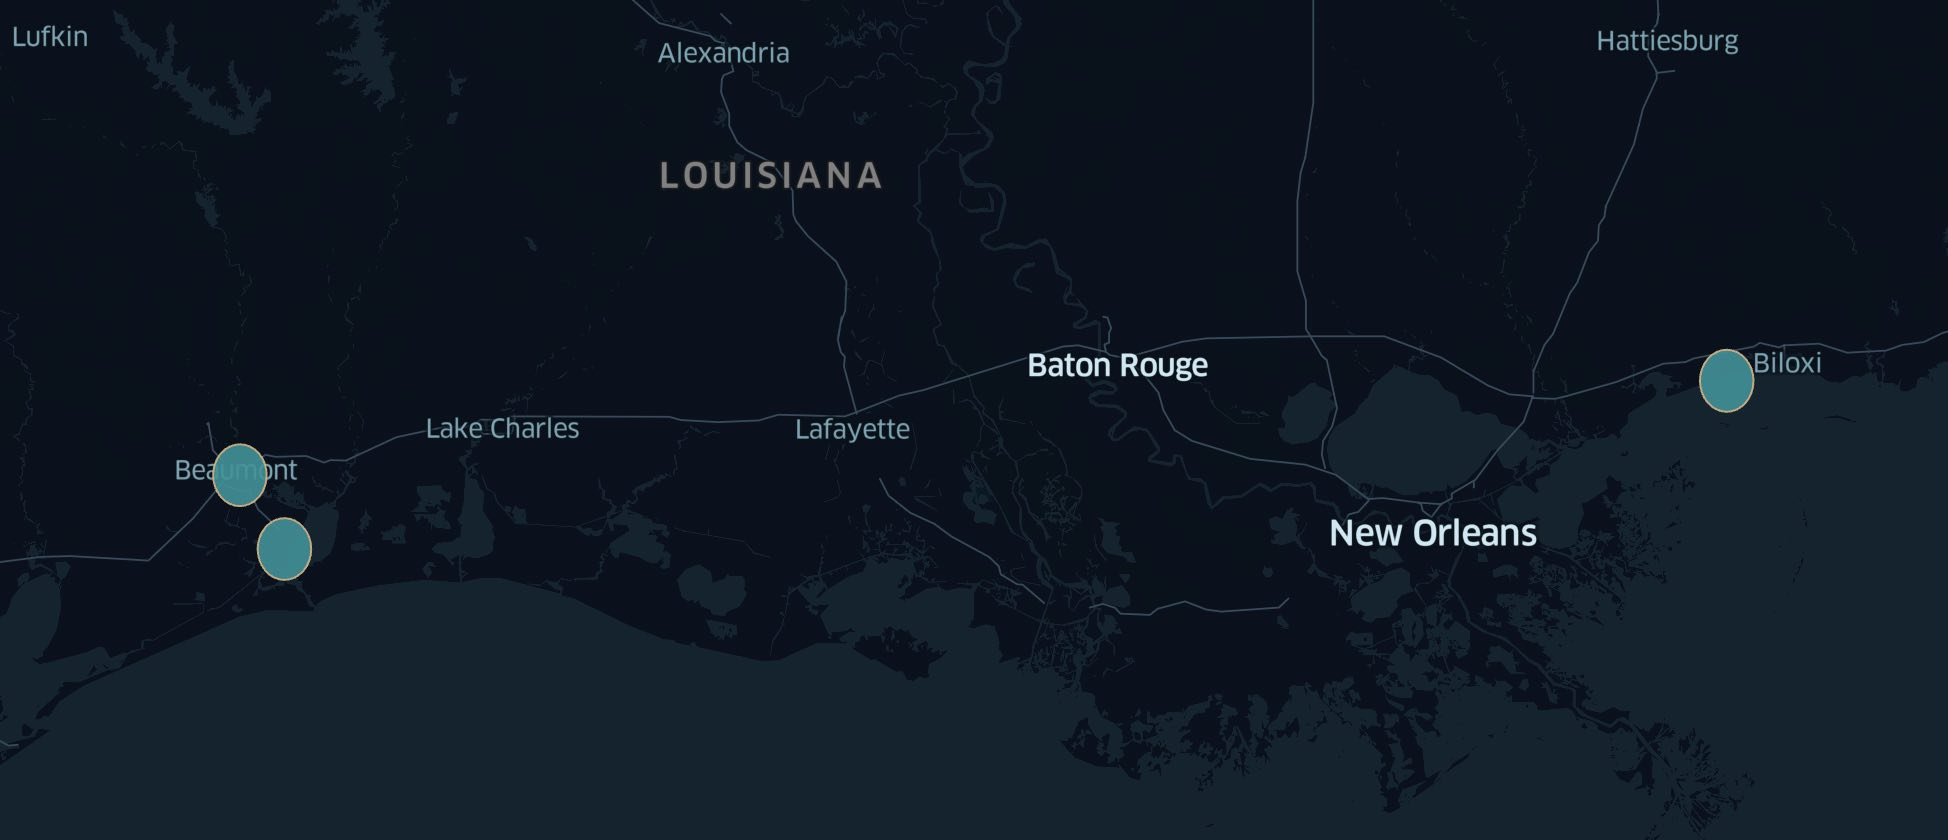

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAAB5ygAwAEAAAAAQAAA0ikBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIA0gHnAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAUFBQUFBQgFBQgMCAgIDBAMDAwMEBQQEBAQEBQYFBQUFBQUGBgYGBgYGBgcHBwcHBwhISEhISUlJSUlJSUlJSX/2wBDAQYGBgkJCRAJCRAnGhYaJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJycnJyf/3QAEAHr/2gAMAwEAAhEDEQA/APkyiiiukyCiiigAooooAKKKKACiiigQUUUUAFFFFAwoq15G+NXj69xVd0ZDhhg0MVxtFFFIQUUUUDCiiimMKKKKACiiikSFFFFMYUUUUDCiiigAooooAKKKKACiiigAooooAKcGKggd6lgTe/zLlfWrQihzkH/ZIoSJvYdA+9AMYwAKnqEvHCAvQVIHUjdniqIY2QsF+Xr2rNdW34fgnHt1rUVlcZU5qGWDzWDZxxikNOxFDGVZopB94fyohTy2d2BAHAq1txhmPKjGaq3E3RUJ9cigNxszxhBGoyMZBzVSiikyrBRRRQMKKKKBhRRRQIKKKKQBRRRTGFFFFIkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArXinhv0FvettlAwkx/k3t71kUU0Fiae3ltpTDMu1h+vuKdGPNjMfdeR/hVy3uopoxZ3+Sg+5J/En+I9qhltZrO4UNgg8qw+6w9QaYFGirE6qT5qcq386r0hoKKKKBhRRRQIKKKKECCirFxay2xUSYIcZVhyCPY1XoAKKKKACiiikAUUUUAFFFFADxI4GAx/OmkknJOTSUUAFFFFAgpSCAD2NJT0YDIYZB60AMopSMEjrinxqS65GQTimhkdFOYbWK+hxTaBhRRRQA5W2sG9KGG1ivocU2pGBZQ684GD7YoEIjBc5GQRil3R4xsP5//AFqjooAcq7jgED68VJGUjJZvmI6YqGigAooooGFFFFABRRUwXZGJepJwPagQ0RSEZA5647/lVi1kAzGep5FVVdlbeOtK5G7cnGefpTBoluIyjlh0b+dV60I5BOhjfrVKRDGxU0CT6DKKKKQwooooYMKKKKQBRRRTsFgooopCCiiigAooooAKKKKACiiigAooopoaCiiigAooooAKKKKQgooooAKKKKACiiimMKKKKBhRRRQBp6v/AMfp/wBxP/QRWZWnq/8Ax+n/AHE/9BFZlNkx2CiiikMKKKKBhRRRQAUUUUAFFFFABRRRQIKKKKQDyQ+WY/NSBSQW7Cm1IjPtIXGBz0zQIjopT6+tJTGFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKRIUUUU0NBRRRQMK1NU5a2b+9bxmsutbU0Ihs3OOYAPy/8A10xPcyaKKKQwooooAKKKKACiiigAooooEFFFFABRRRQAUUUUWCwUUUUWCwUUUUWCwUUUUgCiiigQUUUUAFFFFMYUUUUAFFFFAwooooEFFFFIR//Q+TKKK6TwjpFtruv2+mXhYRS7slTg/KpPv6V0mLdlc5uird/Altf3FtHnZFI6DPXCsQKRLK8ktHv0iZreNgryAfKCegJoC5Voq1a2N5feZ9jiaXylLvtGdqjqT7V6D4U8JmTS7vXNQ0+W8KKptYBkCUt/Fx1AppXJlNJanmlFem2em2d8Nde+0xbGays9yxAt8j8ndgnqRivPbLT73UZTBYQtO4BYqgyQB1NFgUkypRXQ6dGi6XqKyacbp0AH2gMcQc9Tjg5rOttJ1O8jSW0tpJUkfy1KKTlsZwMe1IfMZ9Fa2o6DrOkqsmpWksCt0Zl4z6Z6ZrJoHvsFFFFAy/aMNhTPINSyRK/zEZOOKy60rckxgliaZDVtTOIIJB6ikqZ4iHYKOF5/CoaRQUUUUgCnFSoBPfpTokDyBT0NXrjaISMD2piuZtFFFAwooopAFFFFMAooooGFFFFAgooooAKKKKQBRRRTAKkjiaU4HQdTUdKCQcg4NAF4SwxA+Xzz0qoHwzP/ABHp+NR0UXFYezs/3jnFNyaSpIyitlwTQBbhjVArNwx6YPWrdUVuGaXjAX39Ku0yWBAYYIyKovAS7NwqD/PSrjtsQtjOKzWllZcMeDQEbkVFFFSWFFFFAgooooGFFFFMYUUUUMTCiiigYUUUUMTCiiikAUUUUCCiiigAooopjCiiikAUUUUCCiiigAooooAKKKKYwrSs74RL9muR5kDdu6k91rNopg1c2JrGcfPAvnW79GjHb3HUEVmMio2Cc46jBB/rSRzSwndE7If9k4q+NWuiNtwEnX0kUH9etArMoyiMMFi57H600xurbCOa00udLc5lt2ib1Rsj8jUpggmGLS6jHs4KH6ZORRYLmU0LIpYkcdQOozUNaZ0+/tjvaIsh6lfmBH4VSkhYN8gJH0oBMhopxVl+8CPrTaRRoWl2iobW7G+Bj+Kn1Wory0a1cfMHjcZRx0IqpS5JABPSmKwlFFFIYUUUUAFFFFABRRRQAUUUUCCnZG3GOc9abTw7Ag9dvTNIQyirTBZFaRByRznt/wDrqrQAVP5g8tVUYdeB+NRFGUZPT/62akQoqFjy2eB/WmAiwyNngjAzzTSu1QTwckfyqcSHd++yp7HpUu2OdgQc45btn/OKYXKiwyONyjIokiePG7oake4fd8nygcAU7zX2bvvL/ED2NAalWlBKnIODUskQEpRP17UplCHEPAHfHJoHcZvB6oP1/wAacNkmQq7TjOc0hkVuWQZ9uKioAKKKKQwooooAKKKKACptuYN391v51DVu2AdXjJ6imJlSijpwaKkB8bbZFPTmr10AY84zg9fSqUUZkbA6dzVi6kB/dqenWqE9ynRRRSGFFFFABRRRQAUUUUDCiiikIKKKKBBRRRQAUUUUAFFFFAwooopgFFFFIQUUUUAFFFFMYUUUUAFFFFKwWCiiimMKKKKACiiigDU1bH205/uJ/wCgisutPV/+P0/7if8AoIrMpsmOwUUUUhhRRRQAUUUUAFFFFAwooooAKKKKACiiigAooopCJElaPoB+VMJB6DH0pKXadu7sKBCUUUUDCiiimMKKKKLiuFFFFAwooooAKKKKACiiigAooqWCCa5mW3t0MkjnCqoySfYUARUVLNDLbStBcIY5EOGVhgg+hFStY3i2i37QuLd22rJg7S3oD0zSJKtFFFAwoqe4trm1KC5iaMyKHXcCMqehGexoa1uVt1u2iYQuxVXIO0kdQDTC5BWvrICXEUA/5Ywon5c/1qfTNKvXsJ9eSJZLezYBskfePTjqcViSyvNI0shyzHJNMW7GUUUUigorSsdJvtRt7q5tEDR2aeZKSQML/XpWbQK4UUUUDCiiigAoooosKwUUUUWCwUUUUDCiiigAooooAKKKKACiiikIKKKKBBRRRQAUUUUygooooEFFFFABRRRSAKKKKBH/0fkyu5+HH/I4WX0k/wDQGrhq6vwTqVnpPiW1v79/Lhj37mwTjKkDgc9TXUt0c8/hZiav/wAha8/67yf+hGux0z/knWrf9fUX/stW7vSPAV3dTXTa86mV2cgQtxuOfSo9Jv8Aw1Bb6p4Wvbp/sNy6vDdBDncuOSvXHFOxDldaIi+Hv39Y/wCwfL/MVZ0G9u18Ba0yzODE8IQ7jlRuHA9Pwp8Fx4Z8J6df/wBn6gdSvb2EwJsQqiK3UnP+NYek6rY2/hDV9Mmk23Fy8RjTB5CkE84xRsJq93bsbngJZNSttfjuZ9rTWm0yysSBnIySewqbVYh4M8LxW2mOJ5tWz513Hyuxf4EPv/jXOeFtVsdO03WoLuTY93amOIYJ3Nzxx0/GrHhzWtOm0m68M6/J5drIDJBLgt5Uo+mTg/560J6BKLu30LPhf/kUPEn+5D/Nqu2N/ead8NZJrGVoZGvthZeDgrzg9ulYeh6nYWHh7XNOnlAmuljWIAEhtpOcHHH40DVbD/hAzo/m/wCl/bPN2YP3NuM5xj9aEwcbt+pt+HNSvdV8Ma/ZalM9zHDbiWPzCWKsMngnnsK8wrsfDOqWNhpWt293Jsku7by4hgnc3PHA469646lfYuKs2FFFFI0CtOCMxr97IPNZlTRSmI9yPTPFMlo0mUMCp6Gs2aExH1U9DV+KUSrkcHuKWSNZRtbP4UEp2MmirctqVGY+fbvVSlYrcfGdrqR2PatC4QvHx1HNZ6HawIzntitJpCkXmEdhxTQmZVFOYhmJAwD2ptSUFFFFAgooooAKKKKACiiigYUUUUxhRRRSEFFFFAgoooplBRRRSJCilwSCQOBSou9gucZoAdEm9sfpzWqBgYqtbb8EMMD6fhVqqRLYVWmR3ICgYPU9xVmmOcKfm2+9MSMx43TlhgHpzUdPkYs5J60yoZYUoBPApKKACiiigAooopjCiiigYUUUUhBRRRQAUUUUAFFFFABRRRQIKKKKBhRRRQAUUUUCCiiigAooooAKKKliiMh4xx1zQgGbHxnaceuKbWlcMViwep44rNqhp3CinRxvLIsUY3M5AAHcngV6H4m8GWWkaU13YzPNNaSJFdK2MKzoGyMDpk45osJySaTPOqK6HwnY2up+IrKxvU3wzPh1yRkYJ6jmqGq26Qavd2lsuFSd0RRzwGIApBza2KUU80BzC7If9kkVfGrXDDFyqTj/AG1BP5jBouND1q0g+1XVlNFF13sjAfmRVMWl0bY3ghcwA7TJtO0H0z0zTuGjNJJ9MuT5c0bwbuNwbcoPrg8j8Kp3VhNattb5s9COhHY1DBaXV0rtbQvKIhucqCQo9TjoK2NLi1+8j8qwtXvIV42+WXUe2ccfnRe4npsY7xpyY2zt6j+tV66PUrM2QEdzZm1mON6sGXjHYN2z6VSi0LWLiYwW1nNIwAJARiQD0zxQNSMmipri2ubSUwXUTRSL1VwVI/A1ej0LWprb7bFZTvB13iNiuPXOKQ7oy6K7TxhpFlpr6WmnRbDc2kcjgEsWdup5z+QrnINI1a5kkit7SWR4vvhUJK/Xjj8afkJSTVzOordH2P8A4R85sJDcedj7Xk7AP7mOmarWWiaxqKeZY2c06f3kQkfn0pBcy6KsXVpdWUxt7yJ4ZB1VwVP5Gq9ILhRRRTGFFFTjyNozncOvvQDHCMRp5jN94HA+op32beqspxkDNOaVTEpkXcSScfSo5LhjhU+UAdqZOpYkj/dMM5YDn8KrJGdodgMA+o5B/wAKYkrq+8nPbn0qeRoHUNgjPGQPSgLWIJHZmIzkA8U63fZJg9G4qEjBwDmkoKsPkx5jFTkE5/OnQuEb5vung1FRSAnVifMk9R/M1BUqnETj1IFRUwCiiikMKKKKACiiigAooooEFPRyjBh2plFAyxIm7MsfKnk+oqAAsQo78UqOyNuXrVyIxyOHAw45I7Uydhkj+QvlR9e5qpU0+TIScdfX0qGgaCiiikMKKKKACiiikIKKKKYBRRRSAKKKKYBRRRRYLBRRRSAKKKKdwuFFFFIAooooEFFFFAwooopjCiiigAooooAKKKKACiiigAooooA09X/4/T/uJ/6CKzK09X/4/T/uJ/6CKzKbFHYKKXBIJA4FJSAKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAgqRAHBTPzfw1HRSEFFOLswwTR8oHPJP6UxjaKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFdN4M/wCRr0z/AK7rXM103gz/AJGvTP8ArutNbkz+Fmt4q8Oa9ceI9QngsJ5I5J3ZWWNiCCeoIFa+rWd3YfDSzt72J4ZReklXBU4IfHBrP8UeK/Edp4iv7a2v5o4o5nVVVsAAHgCtLWb+81L4bWl1fytPKb0gsxycAPinpqY+9aNzldMl8Gw2iHVYbu4uGzvEbKqLzxjueK0NZ0PQdOfTdYtmml0q/DEpkCVSvBGenWtHU5LbwtpGlrY2EE8l7biaS4mTfkt/CvPGKl8YySzeEdCmmt1tmcyt5aLtUZPGAemetFtB31Vupc8fHw1DLbxSxXBuRZxiEqy7AvO3cOpPrip78+E08GaY8sF0baSWQxqrLv35IO44xiue+JCt/adg+Plaxiwexxmn6mCfh/ojgZVbiUE+nzNTb1ZKXux1M220i1ufDOq6oWkV7OWNI1zhdrEfeHc1Jpuh6JZ6JF4g8SPMyXLskEEOAzbeCxJ7ZrR05g3gfxAw6GeH/wBCFa1zqEieA9IvLayhvEgLxS+chcIc8cAjGfWlZDcnt5/ocvqmg6Rd6Suu+GmlEIlEM0M+CyM33TkdjWnqek+C/DdwNJ1Zby5ulVTJJEVVAWGflB61g3Pia/utLm06Cyt7a3nZC5gjK5ZTleckZrc03xS+qz2+i+J9PTUNzLCJCpWdQeOo64/Ci6G1IueCYtNeHxHEJXSyNvjzGHzCPLckDviq+m6R4H8QynSNLa7tr1lPlSTFSjsBnBA9fwrV0zSE02bxdpFjumWK32oByxzk446kZxXIeAbW4n8WWRiU4hcu5/uqoOc/yo7IX80k/wCrEeleH4LjS9buLzcs+mKu0A8bskHP5VF4N0a017Whp96WEZjdsocHKjI9a7DSm/tGDxglmPMabLoq8llDucgVl/DSCYeInuWQiOCCUuxHC8Y5NCWqG5O0itoPhWx1bRbrU7qc262s4WR+CBHgEnHc88UQaN4c8Qa5ZaT4eeeONw/nyTYJwozlQPUA1b05yPh3rJU8Ndx/llaxvAa7vFVlifyCGbB/vHacL/wLpS00QXfvO+x0GnaV4G1nVRoNqt5DKzMqTMykMVyTxjjOK4HVo7WHUp4LJGSKNygDncfl4JJwOpGa9nl0/wAQafczajo2g2y3TbsTJKHxu6lVyOa8Puo7iK5kju1ZZgx3hhghu+ackOm7vcgoooqTUKKKKBhRRRQAUUUUCCiiii4XCiiigYUUUUiQooooAKKKKYwooooAKKKKACiiigAooopAf//S+TSMUlFFdJiFFFFAwooooAKKKKACiiigAooooAKKKKACiiigQ9HKMGBxWoXVWVT1asin7ySpbnbxTE1c16pXQCgAADccmnQtJI/mH7vI+lFyhbbtGTnFBK0ZWhiErEE4xVuVVS3Kr2x/OnW4xEOx5zUF3tyv97+lA73ZTooopIpBRRRQwYUUUUAFFORC7bV60sieW5TOcUhDKKKKACiiimMKKKKQBRRRQIKKKKBj0UM4UnGeKtC0G0hjzng1SpQSpDDgimJl4W7KjoCDux+lKLYL8w6g5H4f41XS5dE24z6ZqVbvHEi/lTFqXKWqq3QONyke9WqZLQUyQqEJYAgetPpCAetAGZFCZG2njjPSkljEZ2hsmtNjtUt6fhWVI/mMWqWUncZRS8YznmkpDCiiigAooopjCiiigAooooAKKKKQgooooAKKKKACiiigAooooGFFFFMAooopCCiiigAooooAKkErhPLB4qOigCVz8iDsM/nmoqKKYzuPh/pqXuvreTjMGnobiT/gP3R+fP4V0fheS+1rU9Y07U4ZEj1lHYF1ICyLkr1HYfyrI0XXrbw54SuJNOuAuq3kyjAGSka9+Rj1/OoLL4geKkuIpri8aSJXBZCq/MoPI4GapNKxhJSbdin4Khkt/GljBKNrxzMrD0IDA11fhWzSXxZrt/hDLZid4vMwFDlyAST0xUFxqGhQ/EO21i0uUNpKwmducIxUhs/jz+NY+keIbHTPFOoT3ZMlhfmaKQr/AHHYkMBQrIJXldrsdRokuvW+rJLrOr2lzZzErPG1yjKUYYOFJwMe1YHhq+tYdYvfCs2ZtN1GR4Rt52sCQjr+nP49qrSeF/DQYzp4gh+z9QNh83Hptz1qLw7e6XoFleaz5qy6hgxWkeDlc8GQ/h0/+vRcLKzsbHiSH/hC9EXw1bHdcX5MtxMBgGMEhUB/n/8AXrI0Ow8USaV9ptL8adYbyFeSbylZu+McmrEWr2Wv+F5dN1qcR31ixktZX6uG5ZCf89qnSXR/EXhiw02e/TT7nTi4Kyg7XVznII70dR6pWZqeJEu38EWk2qXEd5PDdmNZ43EmUZScFh/Xnijx94g1fTdStbOwuHt4xaxufLO0ljnkkcnpWPq15okHg1NC067+0TRXfmMSCu7KnJUf3R0ql481Cy1PUra6sJRLGttHGWHTcucj9aGxRjqrrudhdQjxHD4TvNRxJNcyNHKxH31Ru/5frXN+KvF2vR+IbqG0unghtpTFHGhwoCHHI6HOO9SP4hs7PRPDbW0ge40+V5JYx1A35wfqKXXNM8N6vfza3a6xFDDcN5jxSKfNUnlsL35pt9hRVn7y7/maHjOVp9b8PTPjdJb27HHAyWzR478TajpuvXGl6RKbWJNrSFMAu7KCST6YwMVmeKNX0q91TRZrCbfDbQQo5PVdjc7vfFYfjW+tdS8TXd5ZSCWGQrtYdDhAD+opN72HCO10bSf8kyf/ALCH/sgqPS7DxX/ZMFwmpLptkSfJ82fyg3OTgDk8+tVU1KyHgJ9KMo+1G98zy++3aBmta7Oi+J9G0zfqUdhcWEPkSRSg4IH8S465oHqvvLPjiO4fw3o13qEsdxdgyRtNGwcOoPHzDrXldd/4kv8ARn8M6bpOl3Bna0lk3EjaTnndjsCTxXAUpbl01oFFFFI0CiiigAooooAKKKKACiipYuCZCMhOfx7UCDySMbmCk9jTvs7EHaytjsDULMWJZjkmkBIORTDUcpweeh4NOEYJwHX8cignzDno38//AK9N2MRuAOPWgBCMHH8qSiikMKKKKACiiikIKKciM7bV61O1rIPu4NMLlainMjr94EUgVm+6CfpQAlXLQfMzegxUaW8j9flHvVlitvFtXr2pib6Gex3MW9TmkoopDCiiikAUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKdh2CiiigYUUUUCCiiigAooooGFFFFABRRRQAUUUUAaer/APH6f9xP/QRWZWnq/wDx+n/cT/0EVmU2KOwoJHSkoopDCilOO1JQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUCCiiigAopQCxwKViDwvQf5zQA2iiigYUUUUAFFFFABRRRQAUUUUAFWrK8uNOu4r60bZLCwZDjOCPrVWigRZvbu41C7lvbpt0szFnOMZJ+lWn1jUJNJj0RpB9kjkMipgfeOec9e9ZlFAWR1GneMtf0yyXT7eZWhT7iyIr7P93I4rO1HXtW1aFINQnMyxuzruAzluvP8ASsiincXKr3sdK/i7XJdJ/saaVZLcJsG9AWVfQNjNO0XxRrelQ/2bZyqYJW+5IodQTxkZHFcxSqxVgynBByDRcORWtY2ZNU1Czt73R0kHkXEmZRgclTxg4yPwp2jeJNZ0Et/Zs5RHOWQgMjfUHioNQVbiNNSjHEvyyAdnHX8+tZVGwWTR02reL9c1mFbe7lURKwcJGiqNw6HgVfX4g+J1jC+dGZAMCUxr5n/fWK4qii7FyR2sbNn4g1jT5Lia0uGSS6IMj9WJBz1PvWvceO/ElzavamdYxINrtGio7D3YDNcfRRdjcIvoaGmarqOjXQvNNmMMoGMjuPQg8EV0GoeO/EupWrWc1wscUgw4jUIWB9SOa4+ii4OKbu0aUWrX0OmTaPG4FtO4kdcDllxjnr2rS8Java6JrUd5eqWhKvGxX7y7xjcPcVzdFIHFNNHoVpZ+GrC9S/TxA5jjcOFSJxIcHOM56n1rmPEeqpret3WqRIUSZ8qD1wAAM+/HNYlFO4lGzuFFFFJlMKKKKACiiigYUUUUMTCiiikIKKKKYwooooAKKKKQBRRRQIKKKKBhRRRQAUUUUCCiiigZ/9P5ObbuO3p2ptFFdBiFFFFMYUUUUAFFFFABRRRQAUUUUAFFFFABRRRSEFFFFAGhahQhIPPerVYtW4p3JCMQB0z3qkyWupfqpdKNofvnFW6jkjWUbW+vFBKMoqwGSCAamaLZFvfqeg9K0UUIoUHOPWqV22XC+g/nQUncqUUUVJQUUUUCLVqFLnIycZFR3H+uapLUDfnOD6etSXSAgOOo6/SqDqUaKKKQwooooAKKKKGDCiiikIKKKKAClAJOBSU+OQxtuX9aALC2rA/Ng+lWfJViGYYOMcGqJnkLh/Tt2q5DK8n3h+I6VSE7jxEgUKRkD/HNSAAAAdBUMknBjTl+lIrLCAsjEsfqaCSxRRRTEV7gN5ZKk8fyrNrZIBGD3rIdSjFT2qWXEbRRRSGFFFFAwoooGM80wHMpXGe4z+dNq0VWSEFDkp1+lReTLjO04phciop7oUOG60ykAUUUUAFFFFIQUUUUAFFFFABRRRQMKKKKACiiigQUUUUAFFFFABRRRQAUUUUAFT7vLiCj7zcn2HaoKKAJlKrGXHLHj6ZqGiigAooopjCiiigYYrVihaTSZmKEeW6uGx1B4IB9qf8AudOt4XaJZJ5V3/PyFU/d496o3F5c3R/fyFh6dAPw6UydyrUiMo+SQZU/mKjopDHtEwJwCQM849KZVyWZAzhVOTkE5/CqdAIKKKKQBRRRTQBRRRQMKKKlMQGAWAJ7HtQIiopSCp2twRSUDCilUZYAnGe9ThLfHLnP0oFcr1MqOjbWGNwxz+lKAsR35DY6Y/rTUywbnng5z3z/APXpgRUVPK6suDgtnkgVBSAKf5j5DbjkdKZRQBKQrqZFGCOo7c+lRU9XKjb1U9RT/LQnCOMe/FAENFSmFwC3UDuDmoqQgooooAv2m3ax75qJ7pzwgwKiilMRyOQeoqRod4MkRyD27iqC2uo37RN/e/QU77VJ6Cq3Tg1PHAXXe3C+3JNANIcbqUjAwPpVckk5JyavIR93ywUHbuPqDVSVQkhUdKARHRRRSY2FFFFIQUUUUAFFFFMYUUUUWCwUUUUhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFO47hRRRQMKKKKACiiigQUUUUDCiiigAooooAKKKKANPV/+P0/7if+gisytPV/+P0/7if+gisymxR2CiiikMKMGiigAoowcZooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHo21snp0P0puOcLzSVKjkDanBwcnvwKBERGODRRRQMKKKKACiiigQUUUUDCiiigAooooAKKKKACiiigAooooA09NkRnaymP7u4+X6N/Cfzqo9rcJK0PlsWU4OAT0qOHPmptGTuGB+NbOqahepeyxRzMEVsAKcfypk9dCgmmag/3YH/ABGP51DcWs9o4jnXaxGcZB/lTXuJ5P8AWSM31JNQ0D1CiiikMKKKKACiiigAooooAKKKKBBRRRQMKKKKACiiigQUUUUhBRRRTQ0FFFFABRRRSAKKKKBBRRRRcdwooopjCiiiiwrBRRRSEf/U+TKOtFFdBgFFFFNDQUUUUDCiiigAooooAKKKKBBRRRQMKKKKACiiigQdeBVyK3IxJIcY5x/jVOn73xt3HHpQhE0ssnm/ITjjA+oqx9pQfKQSfbp+FZ4JHIqSKUxEkDJNO4WNWq9xGHXdySOgFLDN5o5+8KnoI2M37OVAZjhcZP8AhVethlDAq3INRpCqoUPIJzRYpSM1UZgSoyB1ptaUrpEpAAJbnFZp55pMaZLFIYzwoJ/WtBl8yMoTgn9KyunIq3aY3Hr0/Cmga6jJYirBV57fjULIyHDDFarIH257HNZchYuSwIzzzQEWMoxjrTlUuwUd6vzQoULAYIH8qBtmdRRRUgFFFFAgooooAKKKKAJImRWy67hVlrrHCCqVFO4WH73BJBIJ64p0e95Bg/Me5+lRVdt/L5OACO5PNCBstIgTuST3NPrPe4O8lOnAp1vLIz7W+YHv6UybMukZGDWQw2sV6Y9a2KzrpcS59RQwiVqKUDOfakqSgooop3HcKKKKLhcv2ijYW75xRNNIjFFXtnPtTLaRUQ7+BnrRcuCBsIIPXHtTJ6lRmLEsxyTSUUUiwooooAKKKKBBRRRQAUUUUhBRRRQMKKKKBBRRRQAUrEEkgYHpSUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUDCiiimM1NW4uI0/uRIP0rLrU1cbrpZl+5LGjL9MY/pWXTe4o7BRRRSGTCRWP7xR9RwaYyMnUcevY0ynK7LwDx6dqBDaKnUK67mAHPJHH6f4Ux0CgMp3A96LAR0UUUDCilAJOByak+WPr8zfoP8aBCogXEknA7DuajZi7Fj3pGYsSzHJNJQBKP3ihCfmHT39v8Kd9mlC7sfh3qCigCxKVRREoGR94+9V6KKACiiigYUUUUAFFFFABRRRSEKrFTlTinKhkJC4B9KZRQIl2xj5S3zeo6UxlZeoptT5zAd38J+X8eopgQVJG5jcN+dR0UIZpSxLKu5evUEd6qi4ZIwicEd6sWpJjwexqgTkkgYzTJS6FuGeRnCHBzUE5zKxFSWozLn0FQyf6xvqaB9RlFFFIYUUUUhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRTGFFFFABRRRSAKKKKYBRRRRYLBRRRQMKKKKACiiigAooooAKKKKACiiigDT1f8A4/T/ALif+gisytPV/wDj9P8AuJ/6CKzKbFHYKKKKQwooooAkUgqUJxzkZphBU4NJRQIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUkX3x+Ofp3qOlBIOQcUCJJNowuPmHXJ/Soqe2Aq4HUE/r/9amUAgooooAKKKKQBRRRTGFFFFABRRRQAUUUUAFFFFABRRRQBqaaqxeZfyD5bcZX3c8KP61mszOxdjkk5JrUvv9Ft4tPH3h+8k/3m6D8BWTTYl3CiiikMKKKKACiiigQUUUUhBRRRTuO4UUUUXC4UUUUDCiiigAooopCCiiigQUUUUygooooEFFFFIAooooAKKKKBBRRRQMKKKKACiiigR//V+TKeCNjKfYimUV0mNgooopAFFFFO4XCiiigAooooAKKKKQBRRRTAKKKKQBRRRTGFFFFAgooopCJI5Xj4U4FX1uImOM4JrMp8ab228j8M00waNeikGcc9aWqMzKmDCRt3rTHUoxU9q1GjRzlhnFNeFJMk9T3pWL5jLqSKQxtkdO4qy1tksV4x0H4VDE4ik+fp7Uh3NKs+WORptpOS3T6VfVgw3Kcg0bRu398YpkJ2ECKpLAAE9TUUs0Wxl3ZJBpk8pVtgOOP1qhQUkFFFFSUFFFFAgooooAKKKKACiiigApcnGO1JRQA5EZ22r1rQhCp8g59Wxx9KzattKTbgLx/CfyqgZLJcCPA4Y98VRd2kbc3Wm0UrglYkdVUAZBPtUdFFIAooooAKKKKACiiimUFFFFABRRRQAUUUUAFFFFAgooopCCiiigYUUUUAFFFFMAooooGFFFFAgopevWkpCCiiiiw7BRRRQIKKKKACiiigYUUVJEgd9pOKYGiP9J0vHV7Vv/HH/wADWVWtYD7PcrHMcxzgxt/wLp+tZs0TQyvC/wB5CQfwpiRHRRRSKCiiigAqeMbonHpgioKmhkWNiW5BGKYmQgEnAoq0IwwxCwOeueDUMvDkenH196AuKp2xs3dvlH9aiqeVdkca9+SfxqCkCCiiigYUUUUAFFGCelFABRRRQIKKKKACiinI2w5AB+tACAZpWVl6im5pwYr0oAQAk4AyakeMRr8zfN6Ck8wgYQBfXFR0hEuxVXe5yD0x3/OkZwUCKMAHPXNEhOQhGNoxj+dR02AUUVatkBJkbotA7j1/c25DcFs4FQpGsq4Xhh+RqJ3aRtzdabRcVi8oFqpZjkt0AqkTkknvSUUXGgooopAFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAoooplBRRRQAUUUUAFFFFAgooooAKKKKBhRRRQIKKKKBhRRRQAUUUUAFFFSQp5syR/3mA/M0AaGr/wDH6f8AcT/0EVl1f1R/M1CdvRsf988f0qhTYlsFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAWYgrrtkPGcAd+feq1FFAgooooAKKKKQBRRRTGFFFFABRRRQAUUUUAFFFFABWjpkSNOZ5f9XAPMb3x0H4ms6tWY/ZtNigH3rg+Y/wDujhR/WmhMz5pXnleaTlnJJ/GoqKKQwooooAKKKKBBRRRQAUUUUAFFFFIQUUUUAFFFFABRRRTGFFFFKwWCiiigAooopgFFFFIQUUUUygooooAKKKKQgooooEFFFFOw7BRRRSEf/9b5MooorouY3CiiimAU4I5GQpI+lNopCJDFIDgqajoooAKKUDNJQAUUuDjPakoAKKKKACiiimMKKKKBhRRRSYmFFFFAgqRZXQYQ4qOigC/FcFsmTAAqypDKGHfmsepVldBhT+NVcTiatFUI7k7/AN509qtRyrLnbnigloWRA455x29eKpxQBmYP24rQooBMijiWPp3AzUhOBmlpjsFGTxTAzZEfJkK7QT3qKpZJWk69PSoqk0QUUUUgCiiigQUUUUAFFFFABRRRTsOwUUUUhBRRRQAUUUUASvtCKq8nqfxqKg0UAFFFFAwpQCSAOppKcp2sG9DmmBpxxqir8o3AVnStvkZvWp2uiykBcZ96qUxJdwooopDCiiigYUUUUAFFFFAgoooosFgooooGFFFFFxXCiiigYUUUUCCiiikAUUUUCCilPqPypKYwooopCCiiigAooooGFSxDLABtpP8AKoqsJNGq4dASOnFUDLcgSOIjt2+tLrH/AB/ufVVJ/wC+RVSVy8aszcnPFW9YB+2b/wCF0QqfUbQKCVuZdFFFIsKKKKACiiigBQcEH0qysyK+4kkdgR0/HNVaKBND3cyMWNMoooGFFFFABRRRQBPb48zaf4gRT4YC22TPHt1qsCQQR1FWUuFUH5cE+nT/AOtTJd+g64MbkNnkcH6e1VWbIC44FIcZ44FJSBIKKKKCgooooAKKKKACiigcnFIkkILqZM5I61HUsg2Yj9OvuaioAKtQOCrQngt0P1qrRTQxSCDg9RSVaULcDnhx+tVmUqSrDBFACUUUUhBRRRQAUUUUAFFFFABRRRTGFFFFABRRRSsFgooop2CwUUUUIEFFFFAwooooAKKKKACiiigAooooEFFFFABRRRSAKKKKYwooooAKKKKACtHSkD6jCD0Dbv8AvkZ/pWdWppfyvPN/zzhcj6ngfzpoT2M6V/MkaQ/xEn86ZS4OM9hSUhhRRRQAUUUUAFFFFABRQMZ5o+lABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVIoUxvnqMEVHT1YDcD3GKBMZRSlSACe9JQMKKKKGJhRRRQAUUUUDCiiigAooooAKKKKAHIpdwi9WOB+NaGrMDeGJPuwqsY/wCAj/GjSY1e+Rn4SLMjH0CjP86oSOZJGkbqxJP40+guoyiiikMKKKKACiiigQUUUUIEFFFFABRRRSEFFFFABRRRQAUUUUAFFFFMYUUUUAFFFFABRRRSEFFFFMYUUUUgCiiimgQUUUUAFFFFABRRRSEf/9f5MoooroMAooopjCiiikIKKKKACiiigAooooAOvAopQSCCOopWYscnrQA2iinMpQ4NMdxtFFFABRRRSYMKKe0bqMsOKZQIKKkMThd3p1HcfWo6ACiiigAoycYoooAtW8pD4duCO9XPNj/vD86yaKdxNGm1xEAcNz9Kga63IQBg+/NU6KLjsgooooGFFFFABRRRQAUUUUDCiiigQUUUUrhcKKKKYBRRRSEFFFFABRTlOGHGaHGGPX8etADaKKKYwooopCCiiimhoKKKKBhRRRQAUUUUAFFFFIkKKKKBhRRRQIKKKKACiiigYUUUU2DCiiikIKKKKACiiigAooooAKKKKACiiigYUUUUxhWsn+m6cU6y2vzD3jPX8jWTVqzuTaXKTAZA4YeoPUU0yWVaKvX9obaYlOYX5jbsQf8ACqNA0FFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQIKKKKBhRRUiJn534Ufr7CkIneNjGilgMDPJx1qLyf9tPzqN3Z23N1ptUFibyf9tfzpuxQcFx+GT/So6KQE7eWgVom+YdetW8LcRgsMGs2rlqCNzk4UUxNFRgVJU9uKSnyNvct60ypYBRRRQAUUUUAFFFFAwooopjCiiigAooooEFFFFABRRRQMKKKKBBRRRQAUUUUXC4UUUUDCiiikIKKKKBBRRRTGFFFFAwooooAKKKKACtS1+TTruTu2xB+Jyf5Vl1qN8mjoO8sxP4KMfzNNCZl+1FFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSglTuU4IoESMTsAwOe+Kip7MXOTknFMoAKKKKACiiigYUUUUAFFFFABRRRQAUUUUAalp+5sLq47viJfx5P6CsutS6/c6da2/d90rfjwP0FZdNiQUUUUgCiiikIKKKKdx3CiiikAUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigYUUUUwCiiigYUUUUhBRRRQB//9D5MooorpsY2CiiigYUUUUAFFFFFhWCiiikAUUUUCCiiigAqQyFlCtzjoajooAKUYBywyKSlYgnIGBTGBIJyBgUrHcfQdhTaKQhwds5znPXNO3Kv3Op7nt/n1qOigCWJtpKk4DAik8picDB+hFR0UAOZGX7wIptScGL3DfzH/1qjoAKKKKYwooopAFFFFOwWCiiigAooooGFFFFABRRRQAUUUUCCiiikIKKKKACiiigAoo+tSmQ+g29ge1ADFCn7xwPalZ8gKBgD8aQsW602gAooooAKKKKACiiigAooopjCiiigAoooouFwooopCCiiigAooooAKKKKACiiigAooooGFFFFAgooooGFFFFOwWCiiikIKKKKBhRRRTAKKKKQBRRU8KK7rk/UGgRYtb3yUNvOvmwP1X0919DT59OcL59ofPh65XqPZh1FK9vE3ONv0qjFPLBJ5kDFD7GqBeRFRWt9stLvi/j2uf+WsfB/EdDUU2nSKnnWzi4i9U6j6r1FFh37mdRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU5FLsFHem1NBuL7R0IwfpQJixQ7vnfhB+tOn3nBA+QdMdKjlk3tx90dBTFdkOVOKYvMFXPJ4HrStGy89R6jkUjMzdTSx/6xfqKBjKUAk4Ayau/ZgZCeiDtT5JUh+VAM0C5uxWFu+MuQo96dJMoTyo+nrUDu0hyxzTKB27hRRRUgFFFFAgooooAKKKKaGgooooGFFFFABRRRQIKKKKQBRRRTGFFFFAgoooosFgooooAKKKKACiiikIKKKKYwooooAKKKKBhRRRQAUUUUAFal98lnZw+iM//fR/+tWYAScCtPV/luhADnyY0T8hTE9zLooopDCiiigAooooAKKKKACiiigBQC3TtzSU9HKBgP4himUCCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAuTjA7050KHBIP0NM6cinsVdyTxn+dAhlFKQQSD1FJQwCiiikAUUUUwCiiigYUUUUAFWbO3N1cpAOAx5PoB1P5VWrWg/wBE0+S56SXH7tP90feP9KaEytf3AubpnThF+VB6KOBVKiigAooopDCiiigAooooYmFFFFIQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRTGFFFFIAooopgFFFFAwooooAKKKKQgooooEf/R+TKKKK6TEKKKKBhRRRQAUUUUAFFFFAgooopAFFFFABRRRQIKKKKYwooooAKKKKACiiikIlkZjhc8ADj8KiqRNznZ14OM1HQAUUUUDCiiimMKKKKACiiigAooooAKKKKACiiii4rhRRRSAKKKKBBRRRQMKKKKBBUpViAq4IHp/h1qKigAooopoaCiiikIKKKKACiiigAooopjCiiigAooopAFFFFAgooooAKKKKYwooopAFFFFOwWCiiikAUUUUwCiiigAooooA6jwhYWup61FaXi74mDEjJHRSRyKm8aaZZ6Vq/2WxTZH5atjJPJznk1N4B/5GOAf7L/APoJq18Rf+Q//wBsk/rWf2i/snA1p6Rpk+r38VjB96Q9T0A6kn6CsyvSvhpCrancTEcpFx+JFVJ2RMUdI/h/wZoEaJqrB5GHVy2T7hV7U1vDHhPX7Z20Vwki90JIB7blbnFcB42nkm8R3QY8IQo+gUVo/Dud017ygflkjYEfTn+lZ8uly762OPu7afTLyS1mUCSJipB55Fej+GNA0vVNBnv72IvMpcAhiMYUEcA+9YfxAiWLxC7pwXRGP1xj+ldt4IOfC1yT/fk/9AFOT91CS1PHViWRTyCQeB/SvSdE8PaVdeFptSniJnVZSG3EY2g446V5w06RqQn3vpXsHhwk+Brgn+5P/I057IUN2eNzSOWEfQfzr0m88O6VF4OTVkiIuTFGxbcerEA8dO9eXMSZOfWvbdQ/5J4n/XCL/wBCWifQcUeLW1u91cJbxDLSMFA9ycCvZU8OeFPDltG+suHlcdWLcnvtVe31ryLTLv7DqEF4RnypFfHrg5r23V9H03xpaRXlncgOgwrDkc84YdQaU9xxOa1eHwReafPNprKtyikooLAk/RuteVqP3mD6102seFtY0HE8q7ogeJEOVz2z6fjWfcIl5GNQhGHBxMo7H+8PY/zqorR2Jb1R3Xi7w7pWmaJDeWURSRmUE7icgqT3+leWV7f49/5Fq3/66J/6Aa8RAycUU9hyO58EaBb6zdTSXylreFeeSMsenI+hrQ8Y+HdOstPttT0hCsMhw3JP3hlTz+Nbmnp/wj3gaW7PyzXKkj1y/wAq/kOafoGPEPg2bTW+aSEFF+o+ZP8ACob1uVbSx4tXeeBdH0/WLu4i1CPzFSPcBkjnIHbFcM6lHKMMEHpXpnwy/wCP+6/65D/0IVc9iI7mF4w8Of2Heh7cE2s3KE84PdSfb+VWfA2j2GsXc8WoR+Ysce4DJHOcdq9DW5s/FltfaLdYWeCR1HtgkKw/ka5zwHYz6brd/ZXK7ZI48Ef8CHI9jUc2liranmmqwx2+o3EEQwkcjqo9gxAqgBk4rU1v/kL3n/XaT/0I1Z8NaadU1m3tSMoW3P8A7q8n/CtL2jcm2p6ho/g7RP7OtRqURa5nTd94jtnAAPYV5NrWntpepz2Tf8s3IHuOx/KvTPFOumy8UWEcbYS0wXA6fP1/8dxVH4k6cBNb6rGPllXYxHqOQfxH8qzi7Mp7HllFFFbEBRRRQA+NDI4QcZqQzbRtiG0evc0lv/rl/H+VQ0xBRRRSGFPj/wBYv1FMooEaU83ljav3j+lZpJJyauXA8yNZR+NU6YohRRRSKCiiikSFFFFABRRRQAUUUU0NBRRRQMKKKKBBRRRSEFFFFAwooopgFFFFABRRRQMKKKKACiiigAoooosKwUUUUAFFFFABRRRQMKKKKACiiigDQ0uJZL1C/wByPMjfReapzStNK8zdXYsfxrRtcRaddTj7z7Yh9Dyf0rKpiW4UVIzJsCJn1Oe5qOkAUUUUDCiiigAooooAKKKKAHgDYT3BH5UyiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKfGQHBPbp9e1MqU/Iu3+I9fYelAiM5yc9aSiigAoooosFgooopAFFFFMAooooAlgheeZIY/vOQBVzUpkecQxf6qAeWv4dT+JqSx/wBFt5dQPDD93H/vN1P4CsqmLqFFFFIYUUUUAFFFFABRRRQAUUUUhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFMYUUUUDCiiigAooooAKKKKBBRRRQAUUUUIEf/9L5MooorpMgooooAKKKKQgooop2CwUUUUDCiiigAooopCCiiimAUUUUDCiiigQUUUUAFFFFACglTkcGnFgQ2RyTkGm4JGR2qxCq43EjIIPr+FAiAqwGSCAabVqckNy/J7DtVdwob5DkUAhtFFFBQUUUUAFFFFABRRRQAUUUUCCiiikIKKKKYwoooosFgooooAKKKKACiinKxXkdaQhy/I3zehBx71HRRQAUUUUAFFFFABRRRTGFFFFAwooooAKKKKACiiiiwrBRRRSEFFFFABRRRQAUUUUxhRRRQAUUUUAFFFFABRRRQwZ2ngH/AJGSD/df/wBBNafxAs7ufXA8MTuvlLyFJHeuT8P6t/YupR3+wSbMjaTjqCOvPrXfn4nEHH2If9/P/sayad7otWtY8vksbuJd8sLovqVIFdz8ObtINYe3c48+MqPqCD/IGjXPHR1nTpNP+zCLeQd27PQ56YFcHb3E1rMlxAxR0IKkdQRT1a1Fomdr470m7h1uW8WNjDPhlYDjOACPrxWj8O9Kuv7SfUZI2SKNCASMAs3GB+Gas2XxLdYgmoWokYDlkbbn8CDUeo/EmeWFotOtxCzDG9juI+gwBU62sVpuc/46ukuvEM3lnIiCx/io5/Wu5+H0iXGg3Nmpw4ds/R1AB/Q14vJI8rmRzlmOST6mtjQ9evdBuTcWhBDDDK3Rh71TjpYlS1K13pl/bXTW00Lq4OMYPP09a9i0+CTR/A0y3o2OYpDtPBG/IUfXkVlx/E2AxgzWR3/7L8fqK5DxD4xvtdj+zbRDADnYvOT2ye/5UrN6FKyOQ/j/ABr27UP+SeJ/1wi/9CWvEBwc129x4wM/h9dC+zgBUVPM3f3SD0x7etOaegos4yGJ55VhiGWcgAepNaK/2vpFx8vm28q/VT/SqdldvY3Ud3EAXiYMM8jIOa9Sh+JcLRgXdllx3VuPyI4pyb7CVjotGu7vU/C08uur/C43MMbkA6kf1rwuGZ4ZjsPDcMPUV2ev+OrzV7drK3jFvC/DYOWYehPHFcIpwwJpRTV2OTR7b4+/5FuD/ron/oJryTRrBtT1O3sl/wCWjgH2Hc/lXVat4uTXrOHS5oRAgZcuGJ6DHTA9axtE1T/hGtUeeWETSRhkAzjr3zg0JNRBtXPZtebw4YItM1mYRoMMqZI4HA6VW8PP4VtJ2tdEuAZJuSu4nO3614xr+sya5qD3zrs3AAKDnAA9f1qppd/Jpl/DfR8mFg2PXHUfiOKXI7D5tTd8aaZ/Z2uzBRiOb96v/Auv65rovhl/x/3X/XIf+hCue8TeJk8RCFjbiF4sjIbOQe3QVD4Z8Rf8I7PLOIfO81duCduOc56GnZ8thaXFm1S40jxNcXtucMk8mR2I3HIPsa9z0yWw1NU1u0A3TRhCe/Bzg+4NfN1/c/bLya7xt812fHpuOcV0XhrxXc+H/Mj2edDJzsJxg+oPNJx0GnqY+t/8he8/67Sf+hGvR/hvpwjiudWlGB/q1J9OrH+VeXXtz9svJbojHmuzkem45rr7bxkbTQTolvbhSyMpk3c/N1OMf1pyTskJbnY3yeAtQunvLq5DSyHLEMw/lW1rFvZa94Zlj05xMka5jYf3o+31xxXz2SSc12nhvxhJoFtJamETo7bgC2MHGD2PWk4NDUjiyMEikqzdyxz3Mk0SbFdiwXrgE9PwqtWhDCiiimhImt/9cv4/yqNhhiB2NSW/+uX8f5UyT/WN9TTDqMooopDCiiigC/auChQ9ufwpk1v/ABx9PT/CqoLIeCQalW4lBGTkenFMm2t0R+XJ/dP5UpikH8JP4GrH2s/3f1ppu37AUBqVaKvJMk3ySgZPSqssZjbB6djSsBHRRRSGFFFFMAooooAKKKKACiiikIKKKKACiiimhoKKKKBhRRRQIKKKKBhRRRQAUUUUAFFFFK4rhRRRTAKKKKACiiigYUUUUAFFFFAGo3yaOg/56TE/kuKy61Lz5dPs4/Z2P4tx/KsumxIKKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooEFFFFAwooooEFPdSAGJzu5/GljBzu2lh9O9NZ2fG49OlArjaKKKBhRRRQMKKKKBBRRRQMKcqs7BFGSxwB7mm1qaaoi8y/ccQD5fdzwv+NMTYamyxmOwjOVtxg+7nlj/AErLpWYsxZjkk5JpKASCiiikMKKKKBBRRRSEFFFFABRRRTsOwUUUUAFFFFAwooopEhRRRQAUUUUAFFFFAwooooEFFFFAwooopjCiiigAooooAKKKKACiiigQUUUUgCiiigD/0/kyiiiukyCiiikIKKKKBBRRRQMKKKKYwooooEFFFFIAooopjCiiigAooopCCiiigQUUUUAXrQ5VkPT/ABp7x7WLKNoweR2qnDKYmz1B61pqyuMqc1SJehSa3G1mBJYH0qp04Naku4ISvHBye9ZdJoa1CiiigsKKKKLiuFFFFAwooopMTCiiigQUUUUAFFFFMYUUUUDCiiigAooooEFSyhRt2dCtRVIp+Rx2xn9RSER0UUUxhRRRQAUUUUAFFFFAwooooAKKKKACiiigAooooAKKKKTEwooooAKKKKBBRRRQMKKKKBBRRRTGFFFFDBhRRRSEFFFFAwooopgFFFFIQUUUUDCiiimAUUUUDCiiikSFFFFMY5DhgfQ1oauMalP/AL39Kza1NZ/5CUx9dp/NRT6C6mXRRRSKCiiigAooooAKKKKACiiigAooooAKKKKAJrf/AFy/57UyT/WN9TUyBYVWU/MT0x0FV2JZix780xdRKKKKQwpQCxAHekpynawb0OaAFk/1jfU0ypZQC29OQ3P0NRUMQVNCA5MZ/iHH1FQ9eBUsJKyr9cf0oQiMggkHqKtE77XJ5Kn/AD/Oorj/AFzfh/KpgAtoc/xUwfQp0UUUhhRRRQAUUUUDCiiigAooopCCiiimAUUUUDCiiigAooooEFFFFAwooopCCiiigQUUUUxhRRRSAKKKKLhcKKKKYwooooAKKKKANTU/lNtF/cgTP1PNZhIwAB+Naer/APH5/wAAT/0EVl02JbBRRRSGFFFFABRRRQAUUUUAFFFFAEnWPA7HJqOnBsAj14ppBBwaBBRRRQMKKKKLiuFFFFABRRRQgQUUUUAFFFFFwuFFFOVGc7V5NAMlKkQBjwc8fQioKncMse2TqDx6ioKQgooopjCiiigYUUUUAFFFFABWrf8A+jQRaeOq/vJP99u34CmaXCr3Bmk5S3UyMPXb0H51RmleeVppDlnJJ/GjoT1I6KKKLjuFFFFABRRRQAUUUUgCiiimgQUUUUDCiiigAooooAKKKKQgooooEFFFFABRRRTuO4UUU5OTjGc0AxtFKQVOD+tJSAKKKKYwooooAKKKKACiiigAooooAKKKKBBRRRSEf//U+TKKKK6TIKKKKVhWCiiimAUUUUAFFFFIAooopjCiiikIKKKKLhcKKKKYwooooEFFFFIQUUUUDCrdqWLkEkgCqlSxSGN93bvTQuhpsNylfWsuSN0PzDHNaoIIyO9ZUpfzDvOSKbJiR0UUVJYUUUUCCiiigYUUUUAFFFFAgooopjCiiii4XCiiigYUUUUAFFFFABS7jgL2pKm8sLEWcEHOBSJIaKKKYwooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAgooopAFFFFABRRRQIKKKKACiiigAooooAKKKKACiiimUFFFFABRRRQIKKKKQBRRRTAKKKKBhRRRQIKcVYKGI4PelQMzgJ1zxVq5BKYXop+btyaEK5SrU1jm9L9mRCP8AvkVl1rspvdOR15ltcqw7lD0P4dKY2ZFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBNCx3eWRlW4I/rTJFCOVByBUluQJMnrjj61E24Md3XvTF1G0UUUhhRRRQA5WKHIqz50HXy+aqUUCsXftSrwicflTTcq2CUzjpzVSimLlQ+R/McvjGas3J2qkQ7VBCu6VR7/ypZ23Sn24/KgOpDRRRSY2FFFFABRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiikIKKKKACiiimMKKKKQgooopgFFFFABRRRQAUUUUDNTV/+Pz/gCf8AoIrLrU1f/j8/4An/AKCKy6bEtgooopDCiiigAooooAKKKKACiiigAqRBliTzgE1HSgkHIoEJRT5AQ3IxxmmUAFFFFABRRRQAUUUUgCiiimAUUUUAFKASQB1PFJUyIVAmb7oP4mkIiIIJB6ikpSckkd6SmMKKKKBhRRRQAUUUUAFFFORGkcRoMsxwAPWgDStPk0+8k7kIg/E8/wAqy61b50tol02E52ndK3q/p9BWVTZKCiiilYdgoooosFgooooGFFFFABRRRQIKKKKACiiigYUUUUAFFFFAgooopAFFFFAgooooAKKKKYyZCzjyzyMfl71DUi8owHXg/hUdIQUUUUxhRRRQMKKKKACiiigAooooAKKKKACiiigD/9X5MooorpMQoooouFwooooAKKKKACiiilYLBRRRQAUUUUAFFFFMYUUUUAFFFFAgooooAKKKKQgooooGTpOUQp29uDTNqN90nPof8ajo6cincQUVJJy27+8Mn61HSAKKKKLDsFFFFMAooooGFFFFIQUUUUxhRRRQxMKKKKQBRRRTGFFFAGeBQIkjJUluw4yO2aYSSck5NPOVTb3J5+nFR0CQUUUUDCiiii4XCiiigYUUUUAFFFFABRRRQAUUUUAFFFPjjMh2ggH3oFcZRT3jeM4YUygYUUUUCCiiikAUUUU7BYKKKKQBRRRQIKKKKACiipHQxgZIyw6UAR0UUUxhRRRQAUUUUAFFFFIQUUUU0NBRRRQMKKKKADpyKtx/v4zGT8y8iqoBYhRyTVsIkAIZvnI468UEsp9KntriS1mWaI8jt2I7g1BRQM0r23iKC9tB+5kPI/uN3B/pWbV2yu/szMkg3wyDEi+o9R7jtRd2ZgAmibzIH+64/kfQ0xLsUqKKKRQUUUUAFFFFABRRRQIKKKKBhRRRQAVYV1kGyXr2b/Gq9FAh8kZjbaaZU5BaAN/cOPwqCmCCiiikAUUUUAFKAScAZNTQRCRju6CnNPtykQCj19aYXHRp5GZJMA44HeqlKSScnk0lK4BRRRSAKKKUAscAZpgJRT/KkwSVOBTKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUhBRRRQAUUUUxhRRRQIKKKKGDCiiigAooooGFFFFAGpq//AB+f8AT/ANBFZdamr/8AH5/wBP8A0EVmlcAMDkH+dNiWw2iiikMKKKKACiiigAooooAKKKKACiiigBzMzYLHOBim0qqWOBSUCCiiigYUUUUAFFFFKwrBRRRTAUAnJHakopRjPPAoGSRqQGcg4APP14qMknqc4qaaNU2le4qChkhRRRQMKKKKBhRRRQAUUUUAFamkcXof+4jt+SmsutTSuJJ2/uwSH9KaE9jMJJOTyTSUUUhhRRRQAUUUUCCiiigYUUUUCCiiikAUUUUAFFFFMAoooouFwoooouFwooopCCiiigAooooAKKKKAFBIOQcGnM5cDdyR39qZRQBKqB0+U/MOo9fpUVKpwQT+lSSAHMgOQT9KYIiooooKCiiigAooooAKKKKACiiigAq5Fbq6B2J59KqDORjrWqm7YMnJpkyZ/9b5MooorpMQoooosFgooooAKKKKQBRRRTAKKKKBhRRRQIKKKKACiiigYUUUUCCiiigAooopAFFFFFgsFFFFADmbdyevc02pHxgHGCRzj9DUdAgooopjCiiigAooooGFFFFAgooopAFFFKDwR60CEooooGFFFFABUqDClz7jH1FRU4HAwPxpgNooopAFFFFABRRRQIKKKKYwooooAKKKKACiiigYUUUUAFHTkUUUAabKJoRg+4JrMIIODUsczx8L09DUZJJyeppkpWEooopFBRRRQIKKKKACilIwcZzSUhBRRRQAUUUUAPQBnAPTv9BRI5kcse9N6Dg9aSmhoKKKKGDCiiikIKKKKACiiigAooopjCiiigYUUUUAFFFFABRRRQAVds7xrUlGAkifh0PQ/wCB96pUUxGjdWaKn2q0JeBvzQ+jf41nVZtbuW0k3x8g8Mp6MPQ1bubWKaM3lhzGPvx90/xHvQLbcy6KKKRQUUUUCCiiigAooooGFFFFAgooooQItwfPG8X4iqlPjcxuG/OnTLiQ46HkfjTDqRUUUUhhRRRQBLFIYyfQ8HFSPbMBujO4VWp6yOn3TimKwgR2OACSKsLaufvHb+tNNzKRjIFQs7N94k0halxrVAOCcn8aja0cfdINVw7DgEil8yT+8fzphZky2+OZjtFP8+OMbYV/GqhYscsc/WkoC3cupd9pB+IqvKgVspyrcioqtxr5sDJ3U5FAbFSiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAgooooAKKKKBhRRRSJCiiigYUUUUwCiiigYUUUUAamr/APH5/wAAT/0EVljk4rU1f/j8/wCAJ/6CKy6bEtgooopDCiiigAooooAKKKKBBRRRQMKKKKACiiigQUVI4UkMn8Xb0qPpwaACiiigAooooGFFFFABRRSjBOCcCgCc/LAA45Y/L9Kr09+vb6jP9aZSJCiiimMKKKKBhRRRQIKKKKAFAJOByTWvLt063NsvNxMP3h/uqf4fqe9MsgtrbvqLDLK2yIHpuPU/gKzHdnYu5yzHJJ9aYtxtFFFIoKKKKBBRRRSAKKKKYwooooYmFFFFIQUUUUxhRRRQMKKKKQgooooEFFFFABRRRQAUUUUAFFFFABRRRQAVLH0YHpjP49B/OoqkjfbleMNjOaAI6KVsbjt6dqSncdwoooouFwooooGFFFFABRRRQADrVgXMg44/Kq9X7Yjy8N2NMTP/1/kyiiiukyCiiii4rhRRRQMKKKKTEwooooAKKKKYBRRRSEFFFFAwooopgFFFFAwooooAKKKKBBRRRQMKKKKAHjlCD/CMj86ZShivSpElcOuTgZ7cCgkiopSpUkHscUlA0FFFFAwooooAKKKKACiiigQUUoOCD1xSdeTRYLBRRRSAKKKKBBRx2pSMHFBwSccCgBKKKKACiiimMKKKKBhRRRQAUUUUMTCiiikIKKKKYwooooAKKKKACiiigYUUUUAFFFFAgooooAKKMk9aKQgooooAKKcu0HL8j0pD14pjEooooGFFFFIkKKKKdh2CiiigAooooAKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFTW9xLbSiaE4YfqPQ+1Q0UAatzFBdQNfWg2FSPNj7DPcexrKq9p9wtvcfveYpBscf7J/wqG7t2tbh4G52ng+o7GmJdivRRRSAKKKKBhRRRQAUUUUAFFFFAgqUgmIOex2/1qKphjyCD13cUAyGiiigYUUUUAFFFFAgooooGFFFWREIl8yXn0WgVyAI5GQpI+lDKyHDDGeasm7OMKoFV3dpG3NTBXGVatGw5X1FVakibbKp96Aewki7JGX0NMq7cxFm3rzxyO/1qlQCYUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAgooooGFFFFAgooooAKKKKACiiigAooooGFFFFAGpq//AB+f8AT/ANBFZdamr/8AH5/wBP8A0EVl02JbBRRRSGFFFFABRRRQAUUUUAFFFFAgooooAKKKKACnFtwyetNooCwUUUUAFFFFAwooooAKco3MF9Tim1JF98H+7z+VAmNYAMQOQDTaKKQgoooplBRRRQAUUUUAFKAScDrSVpaXGpufPk/1cAMjfh0H50xNjtSIh8mwXpAvzf77cmsupJZGmkaV+Wckn8ajpXBBRRRQMKKKKACiiigQUUUUDCiiigQUUUUgCiiincLhRRRSAKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRTKCiiigAooooAKKKKBH//Q+TKKKK6TIKKKKQgooooAKKKKbBhRRRQgQUUUUMGFFFFIAooooAKKKKaBBRRRQMKKKKACiiigQUUUUgCiiimAUUUUgJZJBIBhcck/nTGXGCOhGaFUt0pzkYVAche/1oER0UUUxhRRRQAUUUUDCiiigQU+RAjlRzimUrEsxY9+aAEooopAFFKASQB1NKw2sV9DigQ2iiigAooooAKKKKBhRRRTAKKKKBhRRRQAUUUUCCiiigYUUUUhBRRRQAUUUUwCiiigYUUZNL1PFIkSiiimMKKKKBhRRSnHFAhKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWtJ/punrN1ltsI3uh6H8OlZNaulZ8yc/wAPkvn8qaJfcyqKVVLHavJNJSGFKFJUt6UlKCQCPWgBKKKKBhRRRQAUUUUAFSz5EpHp0+lRqpYhVGSalmxuAHJAAJ96YupDRRRUgFFFFMYUUUUhBRRRTAnt03yj25ouJPMfjovApkT7JA3bvUj27gkoNy9RimLqV6KUgg4IwaSkUFFFFAFpLkg/vBn3HWnvEkwLxHn0qlU9uG8wEdOaZLXVEFFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigQUUUUhBRRRQAUUUUDCiiigAooopgal7++s7W67hTE31Xp+lZf1rUtP39hc23dMTL/wHhv0rLpsEKcZOOlJRRSGFFFFABRRRQIKKKKACiiigAooooGFFFFABRRRQAUUUUWFYemN43dOhpmDRSg47ZoASiipV8r5g2T6EUARU5WI4yQD1xSYznHSkpAB9qKeBgbiPp6UygQUUUUxhRRRQMKKKKACtVv8ARdLVOj3Tbj/uL0/M1Vs7VruYR52oPmdv7qjqaW+uVuZ90YxGgCIP9kdKZL3KdFFFIoKKKKACiiigAooooAKKKKQgooopgFFFFAwooooEFFFFABRRRSAKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUDCiiimAUUUUDCiiilcVwooooA//9H5MooorpMQooopAFFFFFgsFFFFABRRRQAUUUUAFFFFAgooooAKKKKYwooooYMKKKKQgooooGFFFFABRRRTYMKKKcqljgdaQh2dse09TyB6VHRRQAUUUUxhRRRQAUUUUDCiiigQUpBBIPUUlPYgqD3HB/pSEMoopwHRiMrnmgBUbY4YjOKRzucsO5zT/MGcbQF6YH+NRUAFFFFAwooooAKKKKBBRRRQMKKKKYwooooAKKKKACiiigAooopCCiiigAooopjCiiigAooooAKKKKBBRRRSELnjGPxpKKKYwooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFaulMVNyw7QOf5VlVqadxDeN/0xI/MimiZbGa7FjuPU/rSKpY4FBJJyaSkMUgg4IwaSiigYUUUUAFFFFABRRRQBJG+wk+oIqOpol4dz2H86hoEFFFFIAooopjCiiigQUUUUDCnq7p904plFAFn7RvXZKuR6jrVb6UUUCsFFFFAw68CtBEEXzOccbR/n61RU7WB9DVq5WRnAAJAHGKZLKrKUODTamSIltrgjPf0NRMpUlWGCKQxKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUiQooooAKKKKACiiimMKKKKAL+mSiK9j3/AHXOxvo3FVZ4jBM8LdUYj8qi6citTVsNcJP3miSQ/Uj/AOtT6B1MuiiikMKKcELAkdqbQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQIKUAk4FJR16UgJEJKsme3A+nNR0vKn0PSkpggooooGFFFFABRRWhpkSSXPmS/6uEGRvovb8TTEye6IsbcWCcSOA0x/UL+HesipZ5WnmeZ/vOST+NRUMEgooopDCiiigAooooAKKKKACiiigQUUUUAFFFFAwooooAKKKKACiiigAooopEhRRRQAUUUUAFFFFABRRRQMKKKKACiiigAooooEFFFFAwoqREDg8gHIxnvmmMCrFT24p2ASiiigAooopAFFFFMD/0vk5lZfvDrTacrsowDwe3agksff2H+FdJiNoqWVdpAOAcc49aioAKKKKBhRRRQAUUUUCCiiigAooopCCiiigYUUUUxhRRRQIKKKKQgooooAKKKKYwooooYMKVSVYFeDSUUhCtncd3XPNJT/mclj9TTKACiiimMKKKKBhRRRSEFFFFAgooooAKlziHae7ZH5VFUsikYYfdI4oAiooooAKKKKACiiiiw7BRRRQAUUUUxhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSnHGKSigTCiinbTt3ds4osA2iiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFalkCLK9fsEUfm1ZdbV9GLCzisgcvKfNf8ALAH86aJfYxaUjGPfmkopFCgFiFHJNPk27vlOcAD8uKRSAG9SMCmUCCiiigY7a2M449abR7UUCCiiigCeH5laLuw4+oqClBKkMO3NSTAbt69G5H9aAIqKKKQgoooplBRRRQAUUUUAFFFFABRRRQAUUUUAFODuowrEfjTaKAJxcTDvmpCy3K4xiQdPeqlW4laFWlfjjAB9aZLKnTg0UVJEI2kVZW2KTyQM4/CkUR0VfubJIoRcwSiaMttyAQQcZ5BqhTFcKKKKQwooooAKKKKACiiigAooooAKKKKBBRRRSAKKKKBBRRRQMKKKKaBBRRRQMK1NT62v/XvH/WsutTU+tr/17x/1pie5l0UUUhhSkgngYpKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigQUUUUAFFFFIAooopgSiZwBj7w7nk007mUt155/GnoEdSpO09QT/KoTxxQIKKcAuRk8Hr7Uro0Zwe/QigdxlFFFAwrVb/RdMVOj3R3H/cXp+ZqlawNdXEcC9XOPw7n8qm1Cdbi6Zo/9WmEQf7K8CmJ7lGiiikMKKKKACiiigAooooAKKKKACiiikIKKKKYwooooAKKKKACiiikIKKKKBBRRRTGFFFFIQUUUUAFFFFOw7BRRRQMKKKKACiiihiYUUUUhBRRRTQ0WYhG2ADh8gjPt70ydNkhPXPNRAkHI6inSSGRtxphbUZRRRSYMKKKKECCiiigZ/9P5MqRv3Z2qeRwTUdWQEmViFww5z2rqMWVqKKKQBRRRQAUUUUgCiiigQUUUUDCiiimAUUUUgCiiimAUUUUgCiiigQUUUUAFFFFMYUUUUMGFFFFIRKxCoEU5zyf8PwqKlOMDHpzSUAFFFFMYUUUUDCiiikSFFFFABRRRQAVKkpUbT8ynsaipyHDZxnFAAwAYgZx79abR15NFAwooop2CwUUUUAFFFFABRRRQMKKKKACiiigAooooAKKKKBBRRRQMKKKKACiiigAooooAKKKKACnKpbOOwzSAE9KASAR68UCEpwYgFexptFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJYI/Nnji/vsB+Zq5q0xn1CZuyttH0XipNFQPqMRI4TLH8Af61myOZJGkPViT+dPoT1GUVKqq0bY+8OfwqKkMKKKKBhRRRQAUUUUMTCiiikIUAk4HJqZhti2OfmByB6UQfeZR1YED61BTGFFFFIQUUUUAFFFFMYUUUUDCiiigQUUUUgCiiimMKKKKANBIwkYeNdzEVGYHc75m21VDMv3SR9KQsWOWOfrTJsXQ9vD93k+o5qObYyLKowSTVWrL/8eyfX/GgLWLmnfv4rix6mRdyf7yc/qKyq1dOIhiub0ffhQBfYudufwrKoGt2FFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUCCiiigAooooGFFLgnpS7HPRT+VADa1NT62v/XvH/Ws/ypT0RvyNa7Qy3tirbGE1sNuMfeTt+IpolmJRU32a4/55P/3yaPs1x/zyf/vk0hkNFTfZrj/nk/8A3yaPs1x/zyf/AL5NAEPbFFWktZWyHjdT2O00w2twpx5bH6A0wuQUVN9muP8Ank//AHyaPs1x/wA8n/75NICGipvs1x/zyf8A75NREFSVYYI7GgBKKKUEYORQMSilwcbu1JQAUUq43Dd070lAgooooAKKKKBhRRRQIKKKKACnbcIG9Tim04sSAp6DpQAgxkZ6d6UuWUKf4elNopCCiinojyuI4xuZjgAUyjSs/wDRrOe9PDN+6j+p+8fwFZVaepMsZisYzlbdcEju55b/AArMpsS7hRRRSGFFFFABRRRQAUUUUAFFFFABRRRQIKKKKACiiigYUUUUAFFFFABRRRQAUUUUAFFFFAgooooAKKKKBhRRRQAUUUUAFFFFAgooopWCwUUUU0CCiiigYUUUUCCiilALEKoyT2FAxKK1F00xqJL+QW6noDy5/wCAj+tG7R0+UJNJ/tEgfpTsK5//1Pk9Nufm/L/69K7ufkI2gdqjqRSSjKeQBke3IrqMSOiiikAUUUUhBRRRQAUUUUAFFFFABRRRQMKKKKBBRRRTGFFFFFgsFFFFIQUUUUAFFFFMYUUUUMGFOCkgnsKbTycIAO/JpCGUUUUDCiiimAUUUUDCiiikIKKKKBBRRRQAUUUUAFFOY7jn2A/IU2mNBRRRQAUUUUhBRRRTQ0FFFFAwooooAKKKKACiiigQUUUUDCiiigAooooAKKKKACiiikIKKf8Au9vct+lMpgFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDV0knzZlX77QuF+uKyquafN5F7DKegYA/Q8H9Kju4fs91LD/cYgfTtT6C6kAJU5FORUPLtgfrTACTgUUgHsynhRgfrTQCxwKSigAoowcZooGFFFFDEwooopAOVtrBh2NPmXbIw9efzqKpRM+ADhgOgIpgyKipZVAIdfutyP8ACoqQgooooAKKKKBhRRRTGFFFFABRRRSEFFTQ289w22FC59hV7+zBDzezpD/s53N+QppCuZdFanm6XB/qoWnb1kO0fkP60f2ko+5aQD6rn+Zphcy6K1P7WuB91IgPQIMUfbbOX/j4tFz6xkp+nIoHdmXVl/8Aj1T6/wCNW/J0qb/VTvCfSRcj81qwdNuDAn2Vkn2nPyMPfscUWE2Mhgmg0u7eZSgk2bc8Zw3OBWNWxriuL8s5OHVWAPbI6fnWPQwj3CiiikUFFA54FX4tMvpRuEZVf7z/ACj9aYrlCitT7HYw/wDH1dBj/diG79TgUfa7GH/j2tQ5/vSnd/46OKLBcoRQTTnbCjOf9kZq+NKmQZupI7cejtz+QzUUup3so2eYUX+6nyj9KokknJo0DU0/s2mp/rLst7Ih/maN2jp0SaQ/7RCj9Ky6KLhY1Pttkn+qsk/4GzN/hR/aMfa0g/I/41l0Urisan9pjtaW/wD3wf8AGj+0z2tbf/v3/wDXrLop3YWRqf2o/a3gH/bMUf2rN2ihH/ABWXRRcLI1P7Wuuyxj/gC/4Uf2ve9ig/4Av+FZdFK7FZGp/bGodnA/4Av+FH9s6l/z1/8AHV/wrLooux2Rp/2zqX/PY/kP8Kb/AGvqR/5bt+lZ1FO7HZGgdV1E/wDLdvzp8Or30UyyPKzhTypPBFZlFFwsjbv7m9gmDw3EhhlG+M7j0Pb6iqP9pX//AD8P/wB9GrNmReWzae33xl4T791/Gsogg4PWhsSXQuf2lf8A/Pw//fRo/tK//wCfh/8Avo1SoouOyLv9pX//AD8P/wB9Gj+0r/8A5+H/AO+jVKnbGC78cHii4WRb/tK//wCfh/8Avo0f2lf/APPw/wD30apUUXCyLv8AaV//AM/D/wDfRqcao8g2Xsa3C+rcN+DDmsuii4WRq+Rptz/x7zGB/wC7L93/AL6H9arz6fd243yJlP7y8r+YqlViC7ubU5gkKew6fl0oCzIVYqcrQFJBI7Vp/bbW44vbcZ/vxfK35dDU8VhbyqzWUqynsrfK3Pbnj8aLCuYdFTzwXEDbZ0KH3GPyqCkMKKKKBhRRRSEFFFFO4XCiiikAUUUUwJHIYAjsAPyqOgcHNSykMwcfxAH+lAiKtlP+JXbiU/8AH1MPlH9xT3+p7VW02FZboPL/AKuIGR/ov+JqrcTPczPPJ1c5/wDrU0G+hD15NFFFIYUUUUgCiiimAUUUUDCiiigAooooAKKKKACiiigQUUUUDCiiigAorZ0jw9revOU0i0kudpALKPlBPYscKPxNdvD8KNcYbrm9sYPVWlJb8lUj9aiVWKdmx2drs8vor0m4+FfiiJS9sba8VRk+RLux+BAP5DtXJXWjLps7W2qTeRMn3o9jFh+eKcZxl8LE01qYdTQW81zIIoELsewq9v0iL7scsx/2iFH6ZNRzag7RGC2QQRHqF6n6nqasV2RTWF7B/rYWA9cZH5jiqlWIby6t/wDUysg9ATj8qujVJpc/aIY7jHJLLzj6jFGgamVRWzDfWiSK8FmFbcMliXA57A0+71e9S6lWGQKoY4+Ven5UaCuzFCs33QTUgt52+7Gx/A1cOr6kes5/DA/pUZ1PUD1nf88UaD1IxZXh6QSH/gJ/wpstpdQrulidB6kEU4316es8h/4Ef8afHf38HzpK4B9TkH8DxS0FqUqK1Pt1tPxeWyk/3o/kP5dDS/Y7Gf8A49bkKf7sw2/+PDinYd+5lUVdm068txueMlf7y/MPzFVxBO33Y2P0BoC5FTth2b+3SrAsb1ukEh/4Cf8ACrh02/mQEROMfwkYH4UWE2ZNFaY0fUj/AMsSPqQP60v9j3g5k2RjuWdcD8jRZjujLo61q+Vplv8A66Vrhh/DGML/AN9H+lIdVkjG2yjS3Hqoy34saLBfsU0tLqT/AFcLt9FNWl0jUCMmLaPViB/M1C+oX0n353P/AAIiqrMzHLEk+9GgammNPhh+a8uEVR/Ch3sfwHSg6ikAKadGIR/fPLn8e34VlUUXFbuOZmdi7ksx6k8mm0UUij//1fkynoQMhuhGOKZRXSYj2TA3Kdw9RTKkjKgkP0YY4pZYjGRzkHoaAIqKKKQBRRRQIKKKKBhRRRTAKKKKLBYKKKKACiiigAooooGFFFFAgpcHGccUlHGKQgooopjCiiigYoBY4HU0h4OKVTtYN1wc0E5JPrSJEooopoaCiiigYUUUUAFFFFABRRRQxMKKKKQgqQriPJ6k8fSgAL8zcnsP8aYSWOTyTQAlFFFMYUUUUgCiiigQUUUUxhRRRQAUUUUDCiiigAooooAKKKKACiiigAooooAKKKmEaAEu3QA4HXmgTIgNxxwPrTpNpclelNJLEk96SgApQCc47UlFAwooo68CgAooIIODRQAUUUUAFFFFABRRRQAUUUUAFFFFAgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVryuL3TzcyjE0BVC398Hpn3FZFaicaPIR/FOAfwUmmiWZgJUhh2qeULIPOT/gQ9DVejNIYUVMWKRqqnBbkkU3eG++M+44P+FACHhAPXn+n+NMqSTGVIOQQMfyqOgAooooGFFFFIQUUUUAWoh5sTRd15FVafG5jcMOamcRS/MhwxPQ0xFaiggg4NFIAooooAKKvw6ZezLvEexP7z/KP1qX7Lp8H/HzceYf7sIz/AOPHimkFzLq3BY3dzzDEzD16D8zxVn7fBDxZ2yKf7z/O368Cqs97d3P+vlZh6Z4/IcU9A1PVvhD4b0rV/GyabrcUV5D9nlcxk7l3ADGceleo67rXwO8Pazc6HfaATNav5cjJECufYlwf0rzn4A/8lBT/AK9Zv6V6L4v0D4MXXiu+n1/WZ7e/eXM8S52h+4z5Rx+dBEvi1OZ+K3gfw9p/hqx8aeDmaGyu2QNFuYqVkUsrKGyR0wRmvN/D3wt8beJ7NNR0uxzayglJZHRFbBxxk5PPtXs/xltbw+BtK/4RkwyeGLby8NGxZycbULZ428kdc5PNcj4Q8MfFrWfD1tJpuqNpWkxg+QZJjCCCScgICSCScE/hSe4J6HnHif4feLPCEaz65ZGKFztEqMrpn0JUnB+uK9q8MfB64b4fanLqWmpJrV1zZbnBKoVXaQc7RnJPPNd3qOl+IIfg7rNh4vuo9RuYYpHjmR/Myq4ZMsQCSCOp5rm/Ces6s/wK1XUXu5jc25lWOUuS6hdmAGzkY7UWE5No+b9V8H+I9F1mPw9fWbi/mClIUw7MGyBjaTnoa7RPgh8R3t/tH9nqOM7DNGH/AC3f1r0D4A/aNe8T6jruszyXlzZWyRxSTMXZRIxzgsT2BH4mvM9V+KPjVvE8+qQ6nPGqTsUhVyIggbhdn3SMcHjmgq7vZHGP4c1yPW08OTWjxag7iNYXG1izdBzxz2PSu4tPhH8Qb6eWwi01o2tmw7yOqpnGeGJ54PbNfQHj+0t7rxd4E8RogSa5uo0cjqVOx1B+mT+dcR8bvHXivRfFiaTo+oS2dvHbxybYTtJZicknqenTpTFzN2seNeINA8ReE5F07xZYsFbJicsCDjrscZB+lc266U6kxvLE3owDD9K+nPHN9P4m+Bena7qpEt4JIm8zGCWDtGTx6jrXyh2ouVHU+vfDvh74d6T8MLHxX4i0mO6PlAyuFLO5aQqOCR7VHoOl/Bf4lPPpOjabJY3cUZkBAMbbcgZGGZTgkZBFdDomhW3iT4I6fpN3erp8ckKsZ3xtQrKWGckDqPWovCXgjw98Morrx1e6p/aCCAxiSGP5NrMMkBWbJJAGcgUGV99T5Z1bT9U0LxDdeGbSMNcQTtAvlpl35wuOp+YYNdgvwY+Jt9ALqay5IyEkmQP+Rbj6V3nwjli8XfFTWPFF3FtZEkmiRuShdgi/iE4rzzxb8S/GT+ML+5tNTuLeO3uXSKKNyI1RGKgbRwcgc5HNI0u72Rwtz4Z12z1tPDt5aPDfyOsaxPwSXOFwehB7EHFHiLw1rPhS/Gma7B9nuCgk27lb5WyAcqSO1fWXjqOHVpPAPip0C3M17aqxH92ULJj6Ajj615L+0N/yPUX/AF5Rf+hPQEZ3Z5i3g7xEnhtfFrWuNMZtom3L13bfu53deOla3hz4Y+NfFVoL/SbEm2P3ZZGWNW/3dxBP1HFeyXf/ACbfB/vj/wBKjXWa/p/iTxV8M/D4+HszRhI4vNSOTyWIWPaRnK9GHIzz1osHOz57u/hF8QLEzG40xhHBG0ryB0KbVBJwQ3Xjp1rF8NeAvFfi4F9CsXmiU4MrEJGCO25iAT7CvorxnPqvhr4MLofiu8L6xcsIwPM3uV83dgtnLAIME8jtXV6v4c8U2/w80fQPAtxHZSCOMzyl/KYgplsMOcsxycU7C52fJ3if4feLfCEaz65ZNFAx2iVCHTJ7FlJwfriuMr7a0PQvFKeB9c0L4hXcV4kkLmCQyiRl+Unljg8MARXxLSZUXcKKKKRQUUUUCCiiigAooooAKKKKYwoooouFx6O8brIhwynIPuK1biBb9WvrP73WWLuD3I9Qax6vabL5N/C/bcAfoeDQmJ9yjRU1zF5FxJD/AHGI/I1DQO4U7I2kY59abSg9M8gdqQCUUuDjI5ApKACiiimMKKm8lyAV5yM471EQVOGGPrQInSAshdsj0460RgqcoQy9/wAPamyu/wBw9MD88VDTEaMepXEI8tW8yP8Auy4Yfl2qTzNLuf8AWI1s57p8y/keR+FZVFFx2L9xp8sKefGRNCf405H4+lUKsW91PavvgYqe47H6jvV//Qb/ANLWc/8Aftj/AOy/yoFexkUVPcW09q/lzqVPb0P0PeoKkAooooAKKKKACiiigYVKgLA7vuqCfxNRVatIDcSCFeshC/TPJP4Ypgy2f9F0wDo902f+AL/iaywMkD1q7qM6z3TeX/q4wET/AHV4/wDr1RobEgooopDCiiigQUUUU0NBRRRQMKKKUDJA6ZoASinyIYztJB+lMoAKKtW9ldXX+ojLDuegH4nirf2Wxtv+PufzG/uQ8/mx4p2FcyqK1PP0pels7f7z4/kKPtliv3LJf+BOxosFzLq/Dpt1KnmkCKP+9Ido/WpRqezmC2hjbs23JH0yaozXE9w++dy59zQGpe+x2Mf+vu1J9I1LfrwK9E8H+DtI1O3OtamkpsEYqis21pnHUKF5Cjuc+w9uE8NaM/iDXLTSUJCzP87Djai/M5yeMhQce9fRF3Jb5S1skEVpbL5cKL0Cjv8AU9STzUWc5ci+ZhiKyow5+vQU3jJbLY2kaWtqnCxRDao+vr75qpuPrTaK7IQjBWij5+pUlUfNN3Y5WZGDKSCOQR1pdQtNM8R24svEEe8gFYrkf62Invn+IZ6g0yipqUozWpdDETpSvBnh2ueHbrw1qLWN/gqw3Rvj5JE7Mrf0rq/D39nad4NvNXnsILyWO6Ea+coPDBe/XvXe67o6+KNBl0/ZvvbNWmtG5J7F48f7QHHviuG8OXsNh8Pr65nto7xBeKDFJnachR29K5qbd3GW6/q57vOqlNVI7P8AqxPo0ug+MGudKuNKgspVhaSOe3+XaV9fzrk/DC6uLfVf7JeJUW2LT+YAcoM/d4PNdd4a1ux1y4k8OwaemlG+Rl862+9wCcNuB4/GsrwhbPaR+JbVzlorOVCfdSRWm9hbXRH4WWM+E/ETYBKpFg/iaxNM8M3uutPdQNHDbxHEk0zbUBPbPrW34WUr4Q8Sf7kP8zT9TLp8OdOW3OFmu5DJjuRuxn8qXQq7Tdu5kal4QvdNsm1O3lgvraM4d7d94XPqKybzQbyDSINeUpJa3DFPkOSjDswxwa63wBvaLWrWf/VPYyFgemR0P6mn+A/9Kh1DTNQAOlPFvnZjgRsPusD6n+ntRa4c7V/I4ttCvI9FXXZikcEj+XGGPzuR1KjHQVq61/bQ8P6Qb94jaMr/AGcIMMADg7jitH4hm5h1SHTgnl2FvCotApypQj72fUnrUnif/kTvDf8AuTf+hClbcak3ytnnlFFFI2LEN1c25zBIyfQ8flUx1PUG6zv+BxVGincVkWje3rfenkP/AAI/41IkskkZLyPgdeTz6dao1dtiHQxNyBQJlYK8hOOcdz2pW2LHtU5JOTSqyJvjblT3HtSSRhMMpyrdKBkVFFFIYUUUUAFFFKAT0GcUAJRV6O2QgMxznmpjBCf4adieZH//1vkyiiiugxCpeHGAcYycHp6nFRU+MqG+bpyPzFCEMopzKFPBB+lNoGFFFFAgooooAKKKKACiiigYUUUUCCiiigYUUUUwCiiigYUUUoJGcd6BCUUpxxj8aSgAooooGFFFSRsASrchuDiiwiOiggg4NFABRRRSAKKKKACiiimAUUUUgCiiigQ5ixA3enH0ptLk429utJQAUUUUxhRRRSAKKKKYBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKADrwKVjkk0lFAgoopQcHOM/WgY4J8u9uB296ZTmdnO5jk02gQAkHIpzMW5NNooGHXk0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVqWH762urXuU8xfqh/qKy6vabMIL6J2+6W2n6Nwf500J7FGnKpY+g9TUtzCbe4khP8DEflUFIB8hBc7eg4H4cUyn5OwAjjOQaZQA/OUA7g/zplHTkVJuVvv8H1H+FAEdFB60UDCiiigAooqSKKSZgkSlj7An+VFhDVAPLdB1pCcnPStY6ZKgH2mRLdB/ePzH3wOabnSbfoHuW9/kX/GixNyiv78iMj5z0I7/AFq2mlXeN8wWBP70hC//AF6VtVuFBS2VLdf+mYwfxPWqc7vKwldixYDJPr0o0DUveXpVv/rJHuG9EG1fzPP5Un9pmLiyhSD3A3N+ZrLoouFiaa4nnbdM7Ofc5qGiikMKKKKAPa/gEQPiCmf+fWb+lei+MPgVrfiPxRf65bajbRRXkpkCuH3KCOhwMfrXylHJJE2+JijeqnBqf7dff8/En/fR/wAaYmne6Z9WeP59G8CfCpPAIvEvL+UKgUEZ/wBZ5juVBO0DoM1d8QeHrv4n/DrQV8IXUSC0jQS27PtXcEClW2g4KEHAPrXx6SzEsxyT3NWLe8vLTd9lnkh3cHYxXP1waLi5T6+tNAHhL4QeIPD9zexXV5FDLJOsTbliMigKmf8AgP51hfCmKHxT8K9Z8G2s6RXzvJhXPaQKVbHXGQQTXy0JpgHAdsSfe5PP19aWC4ntpBNbSNE46MhKkfiKLhyn0j8LxJ8MPHtz4X8UyRQvqNum2RWzHvBJQFiB1GR9cVDqX7PviC58RyyWl1b/ANmTTGQSFjvWNjnG3HJA464r5zmmnuJDNcSNI56sxJJ/E1pQazqiR/Zje3CxEY2iRgv5ZxQNxe6Pqbx14j0y5+InhDwzpsqyrpl1G0rKQQrEqqrkdwBk/WvL/wBoAg+PyR/z6RfzavHJI5klDoTnqCOtPME853zuS3qTk0CSSsz6T1llP7OlgoIyHQY/7bsa+Xu1X3iuRF5SyFkH8OTj8ulUmVlOGGKCon1drDAfs52ozglIh/5HrI+BPiK01G0v/h5reJLe6RnhVuhDDEiD/wBCH4182GacxiEyMYx/Dk4/KmI7xsHjYqw6EHBoFyaWPo7wJInww+KV1oGuShLe5QwRTvwCrMGiYn3xg+hqfxJ8BPEGp+J7m+0m5tv7PvJmmDux3IJDuI2gHOM8YPNfNckksrb5XLt6scn9a6Cy1LVJ7RrK3vZ43QfLGsjBXUdRgHGaBNNao+iPit4t0jQb7wx4dsZRcDQ54Z59pztEICqpx/ERkkfSt34jfDVvidd2fijwtqNuytCsTBySpUEsGBUHn5uQRXxw24sS+c55z1zVq2v7+yyLO4lg3dfLdlz+RFAcnZn1F8TBpngj4WWfgFbpbm9d1yBjOA5kdivUDdwM12Gq3fg218J+HrfxZcz6C7WymKG2d1I+VQd3lg8dOo7+ua+JJHklcySMXY8kk5J/GvoOL4peCPEuj2WnfEPR5bi4sUCJPbtjIwBnhkIzgZGSM0XE4mpqvwx8IeLdKvtb8E6/Nf3NnGXZJ235wCcElVZcgHB5FdLHbWXxj+HOm6bZ6gltq+nBQyMcZZF2Hco52sMEEA4NcBffFHwloehXmh/DnSJLJ79SktxO3zYIIOMsxJwTjJAHpXhEP2mFxNbsUcdGVsEfQg0Ak+p7Pq/wQ8UaFo17rOqX9qsdpE0mxHcl8dhlVGTXiFXLq+1G6+S9uJZtvaR2b+ZNU6LFpPqFFFFAwooooAKKKKQBRRRTsFgooooAKKKUAk4AyaLBYSlBIOR1FKyMuNwIz602iwGnqwBu/PHSZFkH4j/GsytS6/e6dazd03Rn8Dkfoay6HuJBRRRSGOV2Q5H4jsaDgk7RgfWm09VUjJPPYDrmmAyrkNuT80g47Cnw2+z535Pp6VbpkuXYKY6K4wwzT6KZBTltizFlPX1qqYZQcFT+HNa1FIpSZjlHAyVIH0ptbVVJbZWBaPg+naiw1IoUUUUiy/b6hJEnkTKJof7jdvoe1TNYw3QMmmvuPUxNw4+nqKyqVWZSGU4I6EULzJsDKykqwII6g0laq30N0oj1JNx6CVeHH19RUNxp8kSefCwmh/vr2+o6inYd+5QoooqQCiiimAVr6Y/lQ3UoHzJHwe4ycVkVqWP/AB63n/XMf+hCmgexnOAApXOCO/1plPUM/wAo6Dn6UypEFFFSlAVMinj096AIqKKKYwooopCCilALHCjJPpWhHpd7Iu9k8tP70h2j9aaQ/UzqciPIwSNSzHsBk1p+Vplt/rpDcv8A3Y+F/Fj1/CmvqkwUx2irbof7g5P1brTC/YkbTXXD3si264H3uWP/AAEc037Rp9ucWsJmf+9L0/BR/WqE4feGfOWA5P0q3BCEAdvvH9KCempLM97dDFxLheyjgD8BgVTktWVcqd1aFFArmOUZfvAj602taUOUIjODWf5Ex52/rQUmQ0UpBBIPUUlIo9g+F1osVrq2stjcqJbR9P8Alocv79AP1rua5v4eBR4LuWByx1DBHoBEMGulxV4b7T8zxs0l+8jHshKKXFLXSebcTFGKWigVyzZT/ZbuKfsjAn6d/wBK4HVdR0zw9eax4X1Wxe5hlvDcLsfbhXAZRnOeAR3rta85+JAUeKpiBhjFEX/3tg/piuWtpVi11T/Q9fLnenOL7r9SK18VaFoxe48P6QYrsqVWWWQvtz6A5/pWBoutnS01MTxtM+oQNFuBxhm53Gsiii53cqNTStaGnaNqelNCXOoKihgcbdpJ5/Ormj6/bW2lSaDrVq11ZO/mLsO1439VPvXP0UDaTOpn8Q6VY6Vc6Z4bspITeDbLNMwZ9n90Y4FZsutRjw9DoFhC0IZ/MuZCRmRuw47CsiigLI2L3W01Dw7Do99Cz3Fm37icHoh6q3qP/rVT1fW0v9F0vSREyNYK4LE8NuOeKp01kVxtYZFIasjHoq09q4+4cj9aiMEoGStBpdEVFWo7Vm5f5R+tXUREGFGKBORkdeBVuKCUfNnbkVd2rndjn1p1FiXIynhZFDMevanOn7lJPw/U1cnQyR4XqDmqskcgRE2k4B6c9TQUmVqKcUcDJUgfSjb8m89zgUhjaKKmgjWR8N0AzQBD14Fa0agKDtCk9cUGKP8AugfSlClSB2AxTIbuPooopkn/1/kyiiiugwCpYsglgcY69en4VFUsPLEdAQc0ANkILkg5HrTKKKACiiigAooooAKKKKACiiigYUUUUCCiiigAooooAKKKKZQUUUUAKCQcjtSs7P8AeOcU2igAopSSSSeppKBBTxvTDrkZ700AkgDqaXcdu3tnNIQ3ryaKKKYwooopCCiiigAooooAKKKKZQUUUUhDyBsDDrnB/pTKUDJwTigjBwDmgBKKKKaBBRRRQAUUUUAFFFFK4XCiiimMKKKKACiiigAooooAKKKKACiinbW27scetADaKnELHaCMZz+lEcO9QcjJ6A96BXIyF2gg89xTRjvxUsm0Dbgbu+On+fWoaAQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANTVf3kkV2P8AlvGrH/eHB/lWXWof3+kg97eTH/AX/wDr1l02JC5OMZ4pKKKQwop4jdmCKpZj0A5NaC6ZIgD3si26/wC1yx+ijmmK5mUVqebpcHEcLTkfxO20fkKP7WnTi2SOD/cUZ/M5oC5Xi0+9n5jhYj1IwPzNWP7NSLm8uI4vYHe35Cqct1cz/wCulZ/Yk4/Kq9Aamr52mQf6mFp2/vSHA/75H9ajk1S8ddiMIU/uxjaP05/Ws6ii4WFJJOSck0EFTg+x/OkqWUYK+6j+VSIiqX70P+4f0NRhWbhRn6VJEVyUc4DDH40wIqKcylGKt1FNpAFFFLggA+tACUUUUAFFFFABRRRQAUUUUDCiiimMnSeVV2Dn09acUuXGWyQff+lTqYrdASMkjqP8aga6kJ+XAFMj0EQ3ERwAcemMipZyHiV2G1vSo/tUvtUDuztubrQOw2iiikUFOR2jcSIdrKcgj1ptFAjXuUW+gN/CMSL/AK5B/wChD2Pesir+mTCG9jLfdc7G+jcVVniMEzwt1Riv5UwXYiooopDCiiigCZEMoPPKjp7VEQQcEYpKkk5Ib1A/woER0UUUDCiiigQUUUUgCiiimAUUVc+yHdy3H60A2V442kOFrRjiWJcDr3NPRFQbVGBTqZDdxjxrIMNVN7VhzGc+xq/RQJMihBfTLmFhzE6yAfX5TWVW9ZuJLp7XH+uidMn1xkfyrBoZaCiiikUFXbWMYMh+gqoqM5wozWsqhFCjtTJkx1FFFMzCiiigAooooAKKKKAKM8DFt6DOeoqn04NbVRvEkg+YfjSsWpGTRT5E2OV9KZSLCp7e5ntX8yByp7+h+o71BRQI1ftNhdcXUPkuf44un4qf6U1tMkdTJZOtyg/u/eH1U81mU5XZGDISpHQjg07hbsIyspKsCCOoNJWmNUldQt3GlxjoXHzfmMUv2vT2+/ZD/gMjD/GgLsy61LH/AI9bz/rmP/QhR5mkN96GVP8AdYH+Yq9HZ2cllJNaztFvOzExVQcYJ6U0hNmAhAbk4GCM/hSMu09Qfoc1pf2VKfuzQn6SCj+yLvsYz9HX/GlYLoy6sQAlZMdNtXP7JuF5meOJfVnH9M07yNMtyDLcPI3pEuP1NKwrmTViG1ubg4gjZ/cDj86ufb7aH/j0tUB/vSfOf8BUE2oXtwMSStt9BwPyFGgak/8AZnlc3k8cPtnc35CjfpMH3UkuG9WOxfyHNZdFFx2NQ6rcKNtsqW4/2FGfzOTWfJLLM26Vy59WOajop3HZD0Kqcsu4elPEipzGuGPrzj6VDRSCxa3soRX+Y9SD79KdJc5GYzg5/SqhZm+8c0lMViWOUpJvPOetagIIyKy4omkPHTua1aETIryz+U23bnjPWqizESGTnntVmS28yQvuwDT1t4l7Z+tA7ooBJZTkAn3qylp/fP5VdooFzHq/w5kjbR9U05QQY2juBzweqt9O31rqq8n8G6wmi6/BPOQLeb9xNnOPLfAJOCOBwf6V7DeW/wBluGiB3L1VhyGU8g/iKdCVpyh31/r+up5uZU21GqvT+v66Faiiiuo8kKKKKAJYImnnjgXq7BR+JxXkvjm9S/8AFmoTxHKLJ5Q/7ZgIce2Qa9ce+XQtNudelHMKlIAf4pn4A9wBya+eZHeV2kkO5nJJJ7k9a45vmq6dNPv/AKR7mApuFG7+1+S/pjaKKKo6gooooAKKKKACiiigAooooAKKKKACiiigBCMgjpn0oAwAOuKWigBCARg1TuYzhdg4GelXaKQ07GSsUjHAU/jV+GHysknJNT0UDcrhRRRTJCiiigD/0PkyiiiugxCpG5jUjgdD9ajqWFmDgKepGaaERUU5zl2PqTTaBhRRRQAUUUUWCwUUUUWCwUUUUhBRRRQAUUUUAFFFFAwooooAKKKKaBBRRRQMKKUY709/L48vPvmgTGq21t3pQQDkqDim1M0imLYBjBzSEQ0UUUxhRRRRYLBRRRSAKKKKBBRRRQAUUUU0NBRRSgE8ChgxWIJ49BTacBztbg/1ppGODSAKKKKYBRRRQMKKKKBBRRRQMKKKKACiiigAooooAKKKKACpxNsCiMY7n3qJH2HOAfrUnmyMdq8D0UYoEwed3Oc4x0xTI/8AWL9RUrwTkgiMgEcAA0iwzg/6tvbg0wIKKl8if/nm35GjyJv7jfkaQEVFPKOOCpH4UvlSnkI35GgCOipPJl/uN+Ro8qX+435GgZHRUnlS/wBxvyNHlS/3D+VAEdFP8uT+6fyo8uT+6fyoAZRT/Lk/un8qNj/3T+VADKKdsf8Aun8qNj/3T+VADaKdsb0NG1vQ0ANopdrehowR1FACUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVNFBPOdsKM59hmrv9j6h/zzGfQsuf507CujMorU/sbUv+eWfoy/40h0fUh/ywP5j/GizC6MyitA6TqI/wCWDU06ZqA/5YP+VFguijRVw6ffj/l3k/75NRG1uV4aJx9VNAXIKKnFtcnpE/8A3yaclndSMESJyT7GgLlvTP3pnsz/AMtozj/eXkVl1t21oLCdLi8nSIoQdg+ZvpgdM0k93ZW0zixhVzn/AFj/ADfkOlMV9dCjb6fd3I3xphP77cL+Zqz5Om23+vlNw/8Adj4X8WP9Kqz3c1181xKzHsOw/wA/SqlINTVOqSKpjtkW2Q/88/vfiTyf0rOkDE7y2/Pf/Go6KLjsFFFFIYUUUUAFFFFAgp7PuKnH3QB+VMopCJPNkxgHA9uKkTdMNjckdD/Q1XpysynKnBp3AmBEi+W3DrwD/Sq5BBwatrtcpM/UHDf0NQSKytlu/OexoYDVUswUdTTpSN+0dF4H4UkX+sX6ilkCKxCZ44OaQEdFFFAwooooEFFFFABRRRTQ0FFFFAy3FOpURSjjpmgwRE5WQAelVKKYrFsWoPKuDQ1o4GVINVKejshypxQKzGEEHBoq6SlxGzEYZB1qlSGmFFFFAB05FamqgPLHdjpcRqx+vQ/yrLrWiAvdPNuP9bbZdPdT94fh1poGZNFFFIYUUUUAFToxeMw9+o/wqCigTCin5D/e4Pr/AI0hDKeeDSEKUYLuPrimUVYUW5UbiVPfFMLleipmEGcKx/KhY0DbZW2+nv8AjQFyGipJImj56qehFR0gJYY/McDsOtatV7ZQItw6tViqJk9QooopkhRRRQBJA6xTxyt/AwOf51mX8XkXs0Q6Bzj6HkVYhBu72O2/hLgH6Dr+lVr2b7RdyzdmY4+nb9KRcVqVacqlmCjqabV+2hK/O4we1BTdiaKJYhgdT1NS0UUzMKKKKBBRRRQAUUUUAFFFFABRRRQBQu1+YN6jFVK1ZYxKu3OKhNouOGOaRaloUKKlMEqnG0n6U8Wsp64H1oKuivRU7W8q9s/SoKQXCiiigYVqal+5ENiP+WKZb/fbk1HpkSyXavJ/q4QZG+i8/wA6qTStPM8z9XJJ/GmLqRU5mLHJptFIBxbKhfTNTl/NiK45XnimRR7wxPpx7miEkMQD1BGD39qBENFBBBwaKLDsFFFFKwWCiiimMKKKliiMpIBwB1NAiMAk4AyauR2o6yflVlI0jGFFSU7EOQgAAwKWiimSFFFFABRRRQAV614R8VW99bQ+HdacRvGNlrcHoBwBG/t2BryWiolG/qGjTjJXTPoi4tp7WQxTqUYfr9D3qCvMdF8da1pMaWsxW+tFP+pnG7H+633h7dR7V1cXxA8PS83WmzwnH/LKQMM9/vAcVaxElpOP3Hm1Mt1vTl950dW47dBA19eyLbWked8rnA4GcKOpPsK4q4+IunQr/wASzSg0n965csB/wFcZ59/auD1rxFq2vzCXUpi6rjbGOI1wMfKvQH3pSrTlpFW82XRy6MXeq7+S/wAzT8XeJz4gukhtVMNhagrBGep9Xb/ab9PzJ5GiilGKirI9Bu4UUUVQgooooAKKKKACiiigAoopMgHBPJoAWiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0fkyiiiugxFAJOBzUr/IqoOMjJpqEqrOOvQfjTCzNyxz9aYhKKKKCgooooAKKKKACiiigAooooEFFFFIAooooAKKKKYwooooEFFFFABT443lcRxqWZuABTKejvE4kjO1lOQRQMWWJ4ZGilG1lOCKjrU1j5r0zDpKiOPxUVl0MkkiUM4U9wf5VHTkbYwYdqkZEMfmRnp1B7UgIaKKKBhRRRTGFFFFIQUUUUAFFFFMYUUUUAFPQhSSfQgfjTKUbec8ccUCEp7cqH7nIP4UynM2Qo9B/WhANooooGFFFFABRRRQAV2WgaHY6j4e1nU7kMZrFFMWDgZOeo79K5WK0up/9TEze4Bx+dekeFoJIfCPiSOUbT5cfXt96mlqZ1HZaHl1dHp3hPxHqsAurCyeSJujcKD9MkZrMEOnImZZ2dv7qLj9TXZQ6JJFpttdanqY0+GZd1vHI7livrtXgA0JDlK2xyr6Ve6dqsFjqkDQuXTKOOoJ/UfStbxxY2un+J7qzsYhFEmzai9BlAePxNdj4oVTp/hmaWZbuTeyCZSTuUOMckAn8a6m/wBD0x/Fl9rckiXlzaRCZbNfvlkQbSc8Y71XL0Mvaaps8HvdK1HTZY4L6BopJQGVT94g9OBzzW2ngrxKbf7ZLYyrCBuPGWx/u5z+ldF4Qu38ReOYr3URukO+U555VTtA9AOw9qtq9wmsHU5PEVuZVm3/AHpOBnlMbcbccYpJIqU5LQ8/jTSnBBSYFevzD/Ct/wANeHNP1+aeeaV7ays4/MmkJBIHOAOOpwar+JpLB/Ed9LpzobeVtykcDJAJ/XNdF4eyPAHiDyseZujzt/u8f/XoW4Sk+W6Kcl58NVzbLY3hA4E2/k++N2P0pdL0iK+8G3Vzp9sZb37ascbAZk24BwDXnXXk16bo95d2Xw5v5LKRopGvVTcpwcMq5APbNC1CUbLRmJrGmeKdHtopryCaCPGC+cjJPAJBIFU9Ls/FOtBjpaTTqhwWBwAfTJwK7Hw5d3V3ZeIdMupnmt0s2kCuxbDKOoz05rl9F0XULrS5L+W/XTtPWTaWdmAd8dAq9TigFLR3K2q2ninRCo1RZoA/3STkH6EZFOgsPFl1PFbW8c7yTRiVAO6Ho2egB967O7gC/D69Q6gmpJFcxtG43ZTJAI+bkdf1o8Xaze6boWiWmnyGBrizRpHQ4ZgoAVcjnHWiwlNvRIytD01zY+Ihq8W66srcFd/JR/myR71yumL4g1OX7LpYlmYdk7D3PQfjXV+EZZJtE8TSzMXdrUEsxySfm6k1qaNbeV8PzJb3senvd3REkzlhlVGAgKgntmhA5WbOM1Sz8VaKFOqJNAr8Bjggn0yMjNWNP0nxnqluLqwhmkiPRuAD9M4z+FdDBLZWfh3VNMv9Ygvlmj3wIC7FZVORjcOM1buTb+L7KwXR9UWyubaBYjZyMY1LL3Qjgk0BzPsed3dzrdhcPaXryRSpwytwRVf+1dR/57tT9YtdTstRlttY3/aUwGLncSMcHPORjpWZSuapKxof2tqP/PdqX+1tR/57tWdRRcdkaP8Aa2o/892o/tbUf+e7fpWdRRdhZGj/AGtqX/Pdv0o/tfUv+e7fp/hWdRRcLI0v7X1L/nu36Uf2vqX/AD3b9P8ACs2ii4WRpf2xqX/Pc/p/hSjWNR/il3D0IBB/Ssyii7CyNT7baTf8fVquf70R2H8ulG3Rm6POv1Cn+VZdKAWOFGSaLisafkaUely6/WPP8jR9k08/dvR+MbCqIEbAI3ysDjPY802SNozg8g9DQHzND7Bbn7l5F+OR/Sj+zPS6tz/wPH8xWX16U4qy/eBH1oD5ml/Zqj713b/gxP8ASj7Bbj715F+GT/Ssuigdman2OwH3r1fwRjR9l0wdbwn6Rn/Gsuii4W8zU8nSR1uJG+iY/maPtdjB/wAe1sHP96Y7v/HRxWXRRcLF+XU72UbTIVX+6nyj9KodeTRRQFgrqvCGgweItTksbiV4lSF5cpjOVxxz9a5WvR/hf/yMM3/XrL/NaEtSajai2jzvzJFJAY/nV6zttXviRYRTz46+WGbH5Vnt94123hy18Vy6dJJpV39hshJ80ryiJC+BxnqePSkhydkc1cxaxZSiC7WeGRuivuUn6A9a9Ag0CLS/D9vqmp2F1qF3ds2IQzqI1Xu23nJ96v62mpN4GNxq1zHd3FrdqYbiNxIdpHTcOevrVfX9d1mHwfoV1FeSrLP53mMGILYIAye9Vaxi5OVrHBQx6xfTytpEFwY9xwke99o7AkenvUF0dbt5Psl758bt/A4YE/geTXTaBa+LptMafT737BY7z+8klESl++D1NdD4lTUH8FWt1qs6XN3bXm2O4jcPlCufvD39eeKVtCnKzseUTQzW8hiuI2jcdVYEH8jSi3uGhNysbGJTgvg7QfQnpmvQPGO3XNG03xZEBvdfs1zjtInQn68/pTtbX+zfDWjeGVO2S7Iup/rIcID+H8qLFKexwtrpep3yGSytZZ1XqURmA/IUtnpt3e3yWEcTmQsFZQpJXnBJHbFezeJbXxBaXkem6Dew2FnaxoqJ56RMTjJLDOefesfWbqaDVtB1GO5jGoT7Ybs27qd2HUAnYSPmFNxsQqrZxPiHwzeaPqs1lbwzSwoyqkhQncWAOMgYzk4qfW/CV5pdnY3McMzm4g82b5CRGfQ4HHHrWr471vV4/E95aR3cqwwyIUQMcKQqkED1zWn431rVo7DRkjupVW5sVaUBiN5IGSfXNDS1GpS9080tLC+v2KWVvJOw6iNS2PyqKe2uLWUwXMTxSDqrgqfyNeyXFnrFh4c0my8P3MNkJYRPM7SpE7u/PUnOBWL4nWWfwrBLrNxBPqVtPsV45EdmiYfxFT2NFgVS7PL+nBop7/ez64P5jNMqTUKKKKBhRRRQIKKKKQiaE8mM9H4/HtSK5X93IMrnken0oThWfuMY+poDK3En/fXf8fWmAOvlSAryOCKc8kcjbip59DT3jby9pOccqR6dx/WqtAEm1D0bH1H+GaTy2P3efp/h1plFIBwUltnQ9OabRS8tk9e5oGJRRRQIKKKKYwooooAKKKKBhUkcbStgfiaWGLzXx0A61PcP5YEKcDHNMTfQjd1QGKLp3PrVegAk4FXEt1UbpiBntmgNinRVox25O1XwffpUckJjAYHcp7igLkNT287206Tx/eQ5+vqPxqCikM0NQgSORZ4P9TONye3qPwNZ9atky3MD6dKQCfniJ7MO341nzQy28himUow7GmxLsRUUUUhhRRRQAU8NxhuR/npTKKQmP8tjynzD2/rR5cn90/lTKKBEhSUkkqcn2oJlVQpyB6dKjooAKKKeih3Ck4zQBctZMjyz26VbqvFB5TFs54xViqIe4UUUUxBSEhQSegpaq3EoUeWv3jQNIl0392tzeH/llGQD/tPwP61mpG0hworYki+z2y2B/wBY5Ekvt/dX+tMVQo2qMAUirkUUCx89W9anoopkhRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACs65j2vvHRv51o0Uhp2MWitVoIm6qPw4qzBYw26i8nG4f8s0P8R9T7CixfMiDa1lprb/lluiMDuEHOfxNZFWLqSeaZpbjl2/zxVehjQUUUUhk0btHhuCAc9Rn/Gl8oElVJJBxj2phCsm8HDDqP8KTzHyGzyO9MRJMCFTJyeefXnioKukifCupB6fQ/wCBqu8TI+zqTyMUCTIqKCMcGnKVGc8nHFIobRT2U7QxGP60ygAq7aA4Y/SoIYjK3oB1rSVQoCqMAUyJPoOooopkBRRRQAUUUUAFFFFABRRRQAlIGVuhBp1NZdwwf8aBi0tIAAMCloEFFFFABRUZMvYAe+akoGFFFFAgooooAKKKKAIzEjcNk/iaZ9nh/u/qanooHcg8p1/1bkex5FODSAfOuT/s/wD16looC4lLRRQIKKKKACiiigAooooAKKKKACiiigD/0vkynpsJ+fgUyiugxJpcjC7QoHIxz1qGnA5wGztFK6hWIU5Hb8aYDKKKKBhRRRQAUUUUAFFFFIQUUUU0CCiiigAooopWCwUUUUxhRRSkEY96QhKKcAGIUdTxTadgCnhRn5zgdfekVtpzgH60jEsxY9+aANW9US2tnMDyUMYz32HH9aya1D+80cHvFNj8GH+IrMJJJJ6mmxISpQyLGQudx6102g+DNc8SIZ7CIR26cNPM2yMHODg45x3wDXdw/DHR4l/07V2kfnIgi4Hpyx5/KsvaK9lr6BK0Vebt6njNFezT/DHR5Q32DV2jc/cWeLj6FlPH1xXBeIPB2u+GwJb6ISW7cLcQnfET0xuwMH6gZ7UKor2enroOLUleLT9DlqKKK0GFFFFFhWCiiigAooooGFFFFABRRRQAoAOcnFJTiQQMdhzTaBBRVi3tbi6bbAhb1PYfU9KvfZ7C05u5POcf8s4un4t/hTsFzOihlnfy4ULsewGa0Dp8EH/H9cLG39xBvb8ccCo5dSnZPJtwIIv7qcZ+p6ms6gNTU8zSYvuRSTH/AG22j/x2j+1Hj/49oIofcLk/mc1l0UXCxcl1C9n/ANbM5HpnA/IV23g7V9CtNK1XStbneBb4IoZFLHAznoD6157RRfqKUU1Y76fTfh6sLtBqt00gUlQYuCccD7tWr298M+JdPsJNRvXsbuygWB18surhehXHf615vRRcnk8z0HWtd0S4sNFstNLhNOkbdvHzbdwIY9snrgdKg1jxSE8Zv4j0ZyyApjII3AKFYEHscGuFoouwVNHe3WuaTp3iuDxF4fy0TnzJISCu1mGHUcYwcnGKt3Vp4Fv7iS+h1OW0WVi7QNEzMpPJCkcYrzqP/WL9RV2aRE5TbnvxRcTh2LNze20N1IlkizwqxEbToC23tmtzwt4ot9IuLmDUrcSWN9H5cyRjBx2IGe2TXFUUXLcE1Znpcll4BCmePVpfLPIi8j5/pnGKyoNbsYfB13pKuftMl2sqKV/gAHJPTPFcTRRcnk7s7DwtrFlpkOrLfOVa7tHijwCcu306Vd0vUdC1Hwyvh3Wbh7J7eYzRShC6ncOQQOa4Kii43BPU9CuNU8O2fhW+8P6bNJNLLJHIJHUqHIIzgdgAO9Z3irWLHVLTSIbNy7WlosUuQRhhjI561x1FFwUEnc7Dw3q9jp2k61aXblZL23EcQAJywzxx061Y8P61o7aNceGvEHmJbyyCWKaMbjG+MHj0/wDr1w9FFwcE7nXalpvhKzs5GsdTkvLg48tViKL153Fvb0qe20zwZNHFcvq0tuQAZImiYtnuFZePpXFUUByvudN4u1uHXtae9tVKwqixpu+8VQYyfc1zNFFBSVlZBRRRSGFFFFABRRRQAUUUUAFFFFABUsfmBSVO336frRC+yQHr2pJCxchiTgmmIjpcnGM8elJRSGSmXAxGNn8/zpgd14BIptFAgooooGFFFFABRRRQAUUUUAFd58O9QsNO12SbUZ1t4mt3Te/AySuK4OimnbUmUbqx6I3hHwyWJHiS3/74/wDsqsRDSNX8Mp4e/tKK1n0+5kZWl+WOZGJwwNeZ0UX8ieR9Wej3c+i2Hgy50O0vVurk3KSMVGFPTO3PUDHWs/XdQsrjwlodlBKrzW/m+YgPK7jxn61xFKFyCfSi4KFj0eNtL8ReFbDTHv4rC505nysx2q4c5yD6/wD16Zqlzo1t4LGh2N4tzPFdiRiBgNleSoP8I6Z9a86p5TEYfP3ug+lFw5PM9F+H5i1T7Z4Wvhm3uk85T2R48HP4iua8Vat/aviG5vYTiNH2RY7InC4/LNSReLtWt9NOmWgigRo/LaSNAJGX0Lda5ihvSwRj7zkz1PVo9C8aNDq0epxWF75SpPFcfKCyjGVauOuraw0LVLR7W9S/ETLJIYgQoKtnAJ68Cudooeo1C2l9D0DxvBpl9ezeIdO1CGdLkofJB/eA7QDkegxVrWjpfiDQNOu4b+GG40+28qSCQ4Ylem31zivNaKLi5Ntdj0pZtF8V6FYWN5fJYahpymIGb7jx9vm7Yrlta0aw0qJPs+pQ3srNhlhyQox13dPwrnqKGNRtsx7cop9sf5/OmU/rH9D/AD//AFUykUFFFFAwooooEFFFFIQ8f6tvqP60ynucAIDwP50ygCaJnzsXv6+opssZjfb+VSxq8bgE7Rnp60t2DvB7Yph1KtFFFIApysVYMOoptFAEzRs+ZIx8p7DtUJBBwacrMpypwam3rMP3mFYdD6/WmBXopSCDg0lIYUUUUCCiiimUWLdlyY2/j4zTpIZXlJx1PX2qrTzJIRgsfzpisTl0gG2L5mP8VViSxyxyTSUUgsFWIHGTG/Kt/Oq9FAMfIhjYqaZV4j7RDkffWqNMEwrSh1DKC3vV8+IdM/eX6H+lZtFAWNOXT9yGewbz4h1H8a/Uf1FZlSRTSwOJIWKMO4rQ/tJZuL23Sb/aA2N+Y/woFqZdFavk6XP/AKmZoG/uyDI/Mf1qOTSrxV3xqJk/vRncP05/Siw7ozqKUgqcMMEdjSUgCiiikIKKKKAClUlSGHbmkooGa6Osi7l6U+shJHj+6cVZF2cfMuTVXIcS9RVA3b54UCo2uJWGM4+lFw5WXpZVjU889hRYoqB9SuRlYj8oP8T9h+HWsqtW6B+w2UI7h2/NuKB2sOQs+ZXOXk+Zj9afRRTJCiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRVu2t1cGec7YU6n1PoKAHW8MYT7Vc/6teg7sfT6etV553uJDI/4AdAPQU64nad8kbVXhVHQCoKAGuiupVqyijrnIOBxntWvTSwBCnvSKTsY+DjNLg4zjgd61HSLA3AAD8KrvcbTtjGVHWgrmKYGTjOPrTxGwI3ghe5qx5UU3zRHHqKkeOUlzwVPY57fSgLlZ/NMjAbjgn8qseU8qASfKy9+ualWaMj7w/lUDs0sgWIkAdSOlArld4mU7ep9qmEbeWGjTDg4Of581eAwMCloFzGb9nnY5I69yasi2j24PX1qzRQHMypbxujNn7v88VboopibCiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFJS0UAFFFFABRRRQB//T+TKKKK6TEUDJx/OnyMrEbewAP4U6FlDbXAwe57VG4wxB7GgBtFFFAwooooAKKKKACiiikIKKKKBBRRRTuO4UUUUAFFFFAwooooAKK9IuPAulWMVu2p65HbPcRLKqNGTw3/Aqw9e8KSaPZRara3UV/ZTNsEsXZvQjnHT1p2ZCqRZydFKqu5wilj7UhyDg0izRsJ4QslpdcRT4+YfwkdD9PWvQ/B3geKZ21nxAM2ML4ijX/l4Yen+wO579K4LRNHudb1S106FW/wBJlVCwHCgn5j+Aya+kr1rdGSwswFtbRRFCB0AUYJ98nnNS05yVNfP0/wCCYYiv7GHP16f15Ed3ezXbDd8sa8JGvCqBwAB9KqUUV2RiorlitD52c5Tk5Sd2JVu2vJLcGMgSQvw8TjKMO4IPFVaMUSgpLlkghOUJc0XZnmHjjwdBpgj1nQgz2Nw5RouS0Mh5257qf4a4R9K1GNdxhYj25/lX03YPFIZNOuCfs94pik5x94YBB7EZ4NfNerWN9oWq3OnzOwkgkZC6kjdg8MPqOa40uSTpy+XofRYev7amp9epltHIp2spB9CKBFIein8qvLqupBcCZse/P60r6nqi8PK65/Cr0NdSmLec9I2/I04Wl0ekL/8AfJroo7TVZfD8uvfapAsc4hCc85Gc5z2+lYB1C/6G4k/76P8AjQCd9iCSGWIgSoyZ/vAj+dR1oR6peINrv5qHqsnzA/nUvmaXc/62NrZ/VPmX8jyPwoHdmVRWr/Zsf3/tUXlf3s8/989c0hTR1+UyTMR/EFUA/gTmiwXMuitPZpB/5azD6qP8alVtPt1D28TXLnvIMKP+AjrRYVyG2sbi7jLIoWMfxHgD8aft020++TdSDsvyoPx6mory7ubhUE7evyjgD04FZ9AJF641C5uF8vIjjHREG1f/AK/41RoooGFFFFIYUUUUAFFFFABRRRQAUUVdtWTlT97+lAmxESNU3SrtPv3/AAqnVi4djIVzwO1Q7WIyAcUwQ2iiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB3zLhumehptTNkwqf7pI/PmoaBBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpDxGP9o5/L/JqOnM27HGMDFAhUAOSegB/+t+tNJJAB6DpUjbBEAvVuv4dqioAKKKKBhRRRQAUUUUAFFFHXgUASn5Yh/tH9BUVSy43bR0UY/z+NRUCQUUUUDCiiigQVKiAoZGzgccUxducNwPWrA/1LxqQcc/hxRYTGRxq27adxxwOlRK7Icr1oVmQ5U4NOaQuPnAJ9ehpAOjBd95ONvJJp6shBiZsqehPY1Wop3AcylWKnqKbUwIlIV+D0B/xprARkr1YevT8qAFWGRhkDj3oZBH1IY+gPSoySTk8mkpATicjoi/lURXAzkfSm0UATr88JXunI+lQU+N9jg9u/wBKJF2OV9KYDKKKKQBRRRTKCiiigAooooAKUAscKMk0lWbZ0QtuOCelAmSIotl3ufmPaqVXGhMp3LIGNRm1lHTB+lMSZCqs5woyaVo3X7ykYq3bxOjFnGOKihcvujY53DjPrQFytRRRSKCnxyyRNviYofUHFMopEmoNVnYbbpEuF/2xz+BHNL/xKbj+/bN/32v+NZVFO4rGodKmcbrR0uB/sHn8QcGs+SKWFtsqlD6EYpgJU5BwRWhHql4i7HYTJ/dkG4frzRoGpnUVqfa9PfmWzwT1KOR+nNGdGbqs6fQqR+tFguZdFankaU/3bp0/3kz/ACNH2C3b/VXkR/3sr/SiwXMuitT+yZ2/1UsMn+64/rimtpGorz5JI9iD/I0WY+ZGbRVl7K8T78Lj6qarkFTgjBoHcSta/Oz7GOywo35kmsmtS5/fabbT94y0R/mP0poTJqKah3KG9RmnUzMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqCQu7LbwjLucACgaHwK93OY1bZEgy7+gHU/4VbnuROFWMbYlGEX29T7mqd5IltF/Z1ucgHMrD+JvT6CoLWTIMZ7cigbWly5RRSEgDJoJFppVSdx61TafzJVVfu5H41eoG1YhaENJvPTGKZJGFi2qQo75pn2l2B8tCffrSSkgZnGfQDOPzpD1Iohhjj7vQt0q9GuFHJOe5qrHFJIQZOFHQf8A1qvUBJjWVW+8AfrSgADAGBS0UyQooooAKKKKAI5JBGu5qSOTzCxH3R0NS0UDCiiigQUUUUAFFFRSTJEOeT2FAyWikIBGDS0CCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//1PkyiiiukyJIiA+e4BI+opjMWYsepp6YAZu+MY+vGajoEFFFFAwooooAKKKKACiiikIKKKKBBRRRQAUUUUxhRRRQMKKKKAPavGGjabqX9ly3mqQ2LrZRqEkBJI9RisnX7ZdM8EQadpMgvrRrjzJrpCCofGAoXJI/GtPxT4ffxGNNurC9tVWK0jjYSSgHI57A+tZd3HY+FvB15os15Dd3t/IrbIW3KgUjkn8K0fU5YvRK5uTWXiPQNK0618J2eXlgWW4nVFZmduduW7CsHxdaXkujafrmpWottTExhlUKB5mPmViB19Knu7YeNdK0640y9ijvrSEQTQSPsJ29GX1rATTH8MaxptzrNxDMonVnjjfzCiqR8xH+elJjj+J6t4IuPGZmurvXEMNpHasYk2InzsQF4HzdM9a1QoEzgelU9B0+5S91/U2uo7q3vBG8Lo+75A5OMdsA4q3uUTnJ4IxRQ+Kb/rb/AIJ52Yv4Eu1/x/4BFGP3i1KuA0h9KFj2MGYjApqsD5h9RXSeaPjfzMq+CAM0kchkbY2MGmQkBjn0pICBICaAHR4RGk6kcCq2t3H9reI7fQNSVJ7TVLESJlRvilUEEhv+A5qwhDK0ZOCeRUetC00m803xHqVwkaWVnIEjz88juTgAfSuav8cH6/1+B6WXvSovL8b/APBPOtIuTonga7vY4Y5bi3v9iNIu7adoGRT9O1q68YaDrFrrixyyWduZ4ZQoVlK544+lZCXcUvw8vFd186TUA+zIzggc464qHwVPDDYa8srqhexdVDEDJ54FK+yPScdG+tzpbXxNrFv8PTfRTATRXQgVtq8IFGBjGPxryO4nku55LqdsySMWY4xknr0r0bQbdNc8FXOhWs0aXkd0JgkjBdy7QOM/jXnE8L208lvJgtGxU4ORkHHBofQumkmyKiinMu1ivWpNRtFFFAC8Y96kXfERIV7cfjRFwd7DKjr+NTxETL5L545BpiZUJLHJ5JpKleLYM7gQemO9RUgCiiigYUUUUAFFFFABRRRQAUUUUAFKCVIYcEUlFAFxjGyrPIOSPu+pFNuVdW6nYe3apjGGhQ7dxA4H1qo7S4Ikz83r/SmQiKinsuFVh3/mKZSLCiiigAooooAKKKKACiiigAooooAKKKKACilALHApKACiiigAooooAKKKeiNIcL160AMoq4sCbd0p256c1C5iztA6DG4d/wAKYriEBY8MeWwQPzqKnMxbGewx+VNpAFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJUOUaM+mR9RUVKCVOR1FJQIKKKKBhRRTkRpHVEGWYgD6mgBtFPkjeJ2jkG1lOCPemUAFPjKq4Zug5p0cLyAle1RkEEg9RQITryaKKKBhRRg0UAFFFFAFuCJJFyeoyPzpqIyP6Mrfof8/rTbeTy3wejdavuAVOenfFMhuxnOnzDZ0bp/hSSBRt2dCKsrETGYwQw6g+lUznoe1JjQlFFFIBQSpDDtUs/+tJHQ4P6VEAWIUck1PKpLBV5KLz+FAFeiiigAop6Bi42DJ7UBGLFe46+1ADKlkyVRv9nH5GkcRqMKSzdz2pzMjqq/d2/iKYENFKQR1780lIAooooGFFFFABRRRTAKKKKBhUiyyL0Y1HRQIleaRxtY8UxWKMGHam0UASzACQkdG5H41FVlU86LA+8n6imfZ5v7v6imFyGilKlTtYYIpKQBRRRSAKKKKACiiinYLBRRRRYLBTldk5UkfSm0UBYtJfXqfcnkH/AjVoarM423aJcL/tjn8COay6KdwsjV26VcfdZ7VvRvnX8xzVkWc6WE0KAXCsysjREMAR1yOvT2rBp6SSRNvjYqw7g4NFxWL1u5wYnGGXsas1EmrTnAuVScD++PmH0Yc1f8qG6jM9iSwH3oz95f8RTJaKtFFFBIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVFLKsS5PXsKBhLKsS5PXsKl3HToPOb/j6nHH+wh7/U9qjtY1VTqV4Mon3FP8bdh9B3rOnmkuJWmlOWY5NBSRFTlYowYdRTaKksvi7X+JSPpzSSs5Tej8HsBjpVGrO13RUj5U9fr70ybEUO0SAv0rRY4+ZyAg7etUyVtzgDL9z2FRSSvIcsfwoBq5ZluRtAj7jn2qOB3aQKxJB9eelMWCVu2PrVuK3EZDE5NAnZIs0UUUyAooooAKKKKACimswUFm4AqCK5VztbgnpQOxZooooEFFFFABRRUUzmNNwGeRQMc5ZcFRnnn6VAkIALSfPuGc/55pPMMke5PlfPAyOaLdmA8uQEemf5Uhk0cnmAHaRUtQIBEBHnJ7VPTEwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//V+TKKKK6TIeCFXI5JyPpTKeqblZh/DTKBBRRRQMKKKKACiiigAooooEFFFFABRRRQAUUUUDCiiigAooooAKKKKACiiigD0j4XXixeIn02RsJqEDwjJwN4+dT9flwPrXqm3b94YPTFfPujNJY3CazuMa2rhlIJBZh0UEYPPf2r6Ja9ttcs4fEWnqRBd53KcZSQEhlP5Z9+tFOXJUs9n+f9fkefmNLnpqa+zv6f1+ZX2k9OaSil3HvzXYeINpaXI9KU9jQAiqzsEUZJOAB615R8T75LnxObOJtyafDHbZB4LKNzY/FsH3FewLeW+i2cuv3v+rt+I1/56SkfKo+nUntXzXfNPeX0tzIS8s7NI7H+8xJJ/OuOpLmqabL83/X4nuZdS5Kbm/tfkv6/Aqi3dgGTkH9Kti2j27T19aihlkLgPkg9Pw/Cr1Ox1tsynhdCfQd6irUnUtGQvJOP51Ua2ZcYOfX2osUmVqsDEoUMQNvHXBxVeikMkaNgTxkevao6kErqAFOAKGZWGduG9ulADVdkOR+I7GrW5YE3KOX5APYU0Qq21wcJgZJqGV/Mct27UxbiPIXxkAAdAKZRRSKCiiigAooooAKKKKAJhBKQCF4P0pfs83939RV6Fg0a47DFS07EczM77LL7VAylGKt1FbFVprcSfMvDUWBS7mdRUksflNtznio6RRrx/wCrX6CmzLviI9OakpaozMpPmRk9PmH4df0qKrU6CJw8fGaiAEpwBhvboaRomRUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUASQnEq/Wmuu1yvoaaDjkVZcA26u3LZxn86YitRRRSGFPSN3OEGaZV0yKkI8njJpiYLaqo3St/hSySpEu2HGT6VXkmaRQrdvSoaBW7kjyvIArHOKjoopDCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA+Pklf7wx/UUynJneMdc0jYydvTtQISiiigYUdORRRQBrX3+lW8eor94/JL/vDofxFZNaWmyp5jWkxxFcDafZv4T+BqjNE8ErQyDDKcGmyV2JreZUBVzx2qGUq0hZehqOigdgp6IXbb09T6UylyenrSGOkYM529BwPoKZRUmMx5/un9DQIjooooGFaFupK72OTjA9hVaGAy5OcAVdiiMQI3ZBpkSYhXK8MCeoNVrhAQJk6Hr9aXYxJCjOOtSRkYMUnQ+tBKZQop7oUYqe1MqSyeN3Cs2c7RxntmlRmEWU++zfypqDdE4B5GDj2FPVWaH93ycnPrTBlaiiikA9UdssvarbiQrvj4K/ex3Ioixu/dHgDofX/AD3qMxyFVZzgDnPpn+tMRCS8zAYy386jqfzcMPKXGPzNQkkkk9TSGSxuCPLf7p6H0NRspVip6im1JKMMP90fypjI6KKKQgooooAKKKKYwooooGFFFFABRRRQAVKJpV6Mfx5qKigRcB8+Ntw+ZRwap1atWxIV9RVd12uV9DTEtxtFFFIoKKdsc9FP5VMkHG+U7V/WgVyJEaQ4UZqysER+Qv8APUTzcbIhtX9agphqSyQvH1GR60scLP8AMflX1NOS4ZRtcbh71HJK8n3jx6UC1JtlrnG8/wCfwpPKgb7smPr/AJFVqKB2LJihXlpAR7Uqi23BeTnuelVaKAsSzRGJsdQelRVZnO6OI9eP8KrUAgqSKWSCQSxMVYdCKjopDOjgmi1IHdiKcd/4X/wNV5I5YWKSLhgeQfSsy2fbJg/xcVuC6SVBbXnzKeA4+8v+IqjJqzMc3Mn3to25xUq3CshcjG3tU0+ny20ZJcNEfusOmP6GqBG2392OT9O1IrRl9ZEf7pzTgQehzisanKzKcqcGi4cpsUVSjuu0g/EVZEsZGdw/OglpklFR+ZH/AHh+dQyXKocL81AWLVFU1uwWwwwPWozdvngDFA+Vl5jtUt6DNNWRGTeDxVIzySqynA4zxVm2trdbb7bdsTHu2hF6sQM9ewoCxJH51y/l2iFz3PQD609msrM7nIu5x/37U/8As38qq3GoSzJ5EQEMI6InT8T3qhRcpRNjWJXlkgZz1hRsdgT1wKx6UknrT1UlCQMkkAfzoGtER0oBJwBk1IYwgBkPXsP8aVd0jeWg2g9cf1pBcVISxweo7D+pqQxTrwgwPY1cRFjXatPpkcxSlhkdQ5HzAYIqmMZG7p3rZqtNAJPmXhv50DUiwCCMilqOJGRArHOKkpkhRRRQIKKKKACiimsyoMscCgBkq7o2HtWVVuWd3HyAqvrVSkaRRat3cyYLZ47mrxZVGWOPrWbDE0hyDtx3q80YMZVmJ96CZbhLKY13bc84qUdOaijiVVxncD69KlAAGBTExkmSAo7nnFG1RwcnPHOTUlFADTtUbjwFH6UK25Q3TNI6lkKg4zTgABgUAVnfZOSF3Hb2pqm4WQIxznn2qzsHmeZ7Yp9IdwooopkhRRRQAUUUUAFFFFABRRRQAUUUUAFFJS0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//W+TKKKK6TIljcgMoGS4wKY67WK5zjikUkMCOoNPlBErA+tAiOiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVcsrQ3Uh3HZGg3O56Af4+lQ29vJcyrDEMs36e5q7eXESRixtD+6Q5Zv77ev09KYn2Ir27FwyxxDZBFwi+3qfc10XhLxbceGrl45E+0WFyQLiHucdGQ9mGfoe/Yjj6KmUVJWY1ofUdvFbapaf2jocwvbYnHyffQ+jr1B/D36VW6cGvnTT9R1HTJTc6bcSW0gGC0bFSR0xxXdQ/FPxKiKt1HaXhUY3TQ5Y/UqVpxq1I6NX/Bnn1ctpyd4O34nqIBJAAyTV/7Pb2cIu9YmW1hOdqsQJJCBnCKeSTXjlz8UfE0yMlqttZFhjdbxBWGfQsWx/wDXriLrU9Qvrz+0L2d57jIO+Rix46DnsPTpRKrUlotPzCll1OLvN3/BG94s8V3fiW6C7Ps9lASILcdFHq3qx7k1zAnlAwGq9qEIl/4mFuMxS8tj+Fj1B/GsulGKirI773J4ZFRsOMr06VajMnmE53oe4PSs6lDFTlTj6VQmjXyd2MfjTVbcMEYOM4+tU1unH3hu/SlaW3f7ysf8/WgnlKzqUYqeoptX0/eNyN6NnB9PalNrGTkZA9KCuYoqjOcKM1LFA0hBPC+taKqqDCjAprhwMxgE+9FhcxnSStJx0UdAKipzKVO1uCKbSKCiilCls47DNAxKKKKACiiigAooqWOJ5Dx09aBFi1Vxl/4TVssoIBOM+tNjjEa7RVWWSaNyM8HpxTI3ZeqoLoBirrjHHrUCyGWQbyemBj19abJFKpLOPxoGl3Cdw8hI5HaogCTgd6SpYAGlUGkVsjVoooqjIo3fVR9aqq21gw7GrF3/AKwfSqtI0Ww+RdrZH3TyPpTKkRhjY/Q/oatNBEIt3cDOQaB3sUaKui2BiHZ+tQSQPEu5iPTigLohooopDCiiigAooooAKKKKACp1kUoI5BkDuKgooETSxqgVlJww71DV2BNsbGQfKex9qihH7wNt+Un6/SmK4iw7ow+4AnoPWlZPKjKv95scemKsXCyMMBQR196z+nBoBahRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAp+EHU5+n+J/wAKZRQA8vxtUAD9aZRRQAUUU+MKZFDcgnFADKK0Lny1T7oyeBWfTEncK1o7uG7RbbUOo4SYfeX2b1FZNFANFq6tJbR9snKnlWHKsPUGqtaFte+QptpwJoGPK+nup7Gi6sRGn2m1bzYD/F3X2YdqAv3K8Uihdjkj0INDiZRuDll9Qar05XZDlTigLCmSQ8Fj+dMzUpKP1+U+3SoyMHBpAJRRRQMv2jDYV75zUszbQD2zyazUdkYMvUVppNHJwDz6GmZyQ9QBnHc5qpcPGTjPI61JNCXwycMP5VVa3lHQZFAJIQkPHj+JP1H/ANaoaUEqwPcGnOAG+XoeRSZQRuY3DfnTyTDJuToeR9DUNTAFoCT/AAHj8aBiz7SVkUYDD9agqcfPbkf3Dn8DUFDEXbdPlLBsE+nJAokQuuE7kkjB/rVTLEbR064qykxCDc2ADjA6mgQ2DC7m25Zegps0hL7RwF6AetSxugYSu3LDBH9ai8otIdx4HJPqKAHR7mw8igrnqahdt7lvWpppAUCLwvb6Dj/Gq1A0FFFFIAooooAKKKKYwooooGFFFFDEwooopCCiiimMkhO2VT7/AM6luVPm5H8VVqtfaPkBxlxwCaYnuPVUt13vy56Co/tUnoKrlix3Mck0lAW7k5uZj3x+FRM7Ocsc02ikOwUUUUAFFFFABRSqpZgo6mppIfLQMx+Y9qAIKKKKBllBHJGEdtpXOPxpxtW6owIqpSglTkHFMViRoJVBJHAqKrMM7hwrHIPFJcRhH+UYBoFfoyv05FSpMydMHnPPrUVWLe1nupBHCpOe/YfU0DZpaZcXkk/lIA0TcurfdAHUn0pbi+sFkZYrVXUHhizc49qgubiOCI2Nmcp/y0f++f8AAdqzkjd/ujNO5NluaP8AaMY+7aQfiCf60fbrN/8AW2SH/cZl/wAazSjL94EfWm0rjsjU36Q/3o5o/wDdYN/OjyNLf7l06f76Z/kay6KLjsan9nRt/qruFv8AeJX+Ypx0S/2h0VXU91YY/WsmtXTCZDNZk8TRkKP9ocj+VAndDG0jUl6wN+GD/KoW0++XrBJ/3yarnzYWKHKMOCOhrXsJJoo2v7iV/Kj4Vdx+duw+g70A7kMOnSxYnvWFvH/tfePsF60XckfkiztoysSNu3OeWOMfSqFxcS3Upmmbcx/zgUtw2WCA5CDH40BZ3G+WBgs6j9f5U7bAOrFvoMfzqCikMsh4ARtjJPvTJC+OvyH06VDT0cr7g9RTCwvWMjuDn86v26qIgVHXrVEIW/1Z4PH/ANY1atGypX05oJlsW6KKKZAUUUUAFFFFABRRRQAUhIUZJwKWopl3RsPagZHJcoownzH9Kou7SHLGmUUjRKxdtTwVbGD9Kikt3Q8cjPGOahRtjBuuKuRus7tvHbgfzoE9NSxEoRAoqSq6QLG28HoKmVlb7pB+lBDFACjA6U1VK9WJ+tPpKYhaKKKACikJCjJqJxJuUL93v68UDJqQAjqc0tFAgooooAKKKKACiiigAooooAKKKKACiiigBOtAzjnrS0mecUALRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9f5MooorpMgqZ0YgEZIUYPtioacrMpypwaBMbRUyhXyx+UDk4/zxUNAIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRTlUu21eppvTg0CCnojyOI4wWZjgAUsUUk0giiUszcACtR5Y9MQw2xD3BGHkHRf8AZX+ppoLhO406E2UJBmcfvWHYf3B/WsejryaKASCiiikMkYbYwD1Jyfw4/wAaYAWOB7n8qmDJIMSnBA4NCpwxRgxxgDv+vtTFcgooopDLVrdSWrllwysMMh6MPQ1YubSNovtllloT95e6H0Pt6Gs2vcfCXg2DQ449W18edczJlLM42KrdDL1ySOQuOO/spTtpuyZNRTnJ2R5hpHhLxFroD6ZZSSRk48wjanTP3mwOnv8AzFdN/wAKs8S7STJaBuymYZP04x+teu3F5c3KhXc+WoACLwqgdAFHFU6pUaj3kkefPNIJ+5G/qzxHVfBHinRkEt7Yv5Zyd8eJF45OShOPxxXKV9R215c2jb7eQp7DofqOhrlvEfg3T/EcTXeiwpaamuWaNeI5x3wOiv3HY9/URJThrPVdzooYynVfKtH/AF1PFbVSELHuatUbDH+7IKleCDwRj1zRVmrCiiimIzrrHm8elVqklJMjE+tR0jVbBV6CLaCX6sMY9qpKpY7V5JrVLCNAZD9TQhSZnTReU2M5B6VFTnILEjoTTaQ0FFFTLBIWCkY96AIacm3cN4yO9SywNGN3UVBQBelSCIDK5z7mnLFbvkLzj3qgSWOTyalgdkcAfxEA0xW0L6RIhJUYPSobvdtH93NTxyLIMr+VOIBOCM0EX1Mer1rER+8bv0qtMgjkKjp1FWLWQ/6vGf6UFvYu0UUUzMhmj8xMDqOlZfTg1tVQuogD5g79frSLi+hUqVGDL5bceh9KiopFGtESUG45I61HcA+UxPtiq0dyUXBXPvT2uVdSrLwaZFncp0U/Efqfy/8Ar0uIz/ER9R/9ekWR0U/av98fr/hRsHZgfz/woAZRT/Lb1H5j/Gjy27YP0INADKKmMLIN0nA9uaZuA+6v58//AFqAuIqM3QfjUsaqsi5YE5HA5qIszdTmnxkpmT04H1NMGW3eZn2RjA9SP8akjiCfMx3N6mh5dsQkAznH61ELtO4NBGpYZAxBOePQ4pDGjDDDP1ojlWUEr29akpiKElsQ3yZxVUqynDDH1rZqKSJZQN3b0pWKUu5lkEcGkq6bTP8AH+lVpI2iba314oKTI6KXBAz60lIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASSIEcqDnGKjpzNux7DFIQQcEYNAiSXOVz/dGKiqZyHjUjqoIP8ASoaAQUU5VLZx2GfypxQBFYHls8fSgCOrMFzcWchaFtpPBHUEe471WqdDvQqANw6k+n/1qYMvedp13/x8J9mkP8cYyv4r2/CoptNuI082LE0X9+PkfiOoqgASQB1NSwzzW774HKN7UCt2IaK1heWl2dt/EFY/8tY+D+K9DVW6spbXDkh43+668g//AF/aiw7lOiiikMKlgG6VR75/KoqVWKkMpwRQI2aKzTdSnpgfSnLdOPvDd+lO5HKx13tBGB8x6moV+eMr3TkfTvSTSeY+4dKbG+xw3pSZVtBlWU/49n+o/pUUqBHwOh5H0qRD/o7r6EGgOhHHI0bZH4ippI1Yb044yMdD7exqrU8Evlk7skHtQDHRq0WWYD7vGcVYYzqAFwSck8VXuFBIlTkNTEnkQAZyBQKxKfMmUhl+ZeQf6U7DJGoccAc+nP61Ek7KrZwTnIz+tBmaTIcbh1wOMYoAe8WSHX5gAPl74qqw2sV9DipGKqf3bE1GSScmgaEqQRuy7lGR7VHVi23+Z8oyO9A3sV6K1Dbwk521Xmjgj9c+gosK6KdFFFIYUUUUxhRRRQIKKKKQgooooAKKKKdx3Ciiii4XCiiigAooooAcqs5woyan+yybc5GfSm2zYlA9eK06aRLdinbQlSXcYPQVYcR43OAce1SUhAIIPQ0E3MuUKGwq7fxzmoqcwKsVJzt4oYAYHfHP1pGg2iiigCxBaXd0Ga2heUJ94opbH1xUjhp41K/eXqK+q/2bMf2TrWf+e8X/AKC1cN8Y/h/F4Z1weJbBCul3z5dUHEcp5K8fwv1H4imRza2PG7SGWKAvBaG5m6nKFwi9sgdzVObUr2dSjykL02r8ox9BX1L+z3KbjSvEMrjq8f5bX4r5k0zTLrWtTj0vS7dri6nfaiL3P8gB3JouCeruZkce/LMcKOpqU3JUbYlCivoK2/Z18S3Fqr3eo2ttKRkRAM4B92GB+QNeVa94A17wzr9toGsqsTXbqkUwOYmDMF3A8dCeQcEUhqSZx4uJQc5zTpMSp5yjBBwa7Tx58PtV8AXNrb6jNHOLtGdHizj5Tgg5A5GRXReGfhD4i8Q+GD4ntZ4Y4XWRlifdvcRkg4wMckHHNAXW55BUkcbSHC10PhXwvfeLNdt9BsWVJLjdhn6AKpYk49hU3i7QLvwfrc3h64mSaW3Clmizj5lDY556Ggd+iOdkhjVCVbJXrRaWl7ey+XYwyTyDnEalj+Q5rQ8P6ZNrmr2uiW/D3sqRA+m44J/AHNfZviXxJ4a+Cmg2em6VYiaecEJGCEL7QN0kj4JPJpicraHyDdWOpRwg69YXFvjhZ3iZDj0bIGayZ5heyiKP5IYhhF9vX6mvrPwb8c7TxZrEXh3XNMS2F6fLjcP5iFj0VlZR97pXlfxZ8BW/h3xlaRaKghtdYx5afwxyFgrKP9nJBHpnFFyU9bM8ZQWzONuVI7HvU9npOoanfxabp0RuLidtsaL1Y9cc16rL8DPF6+IE0GF4ZMxLM9wCRGisSBnIyTlTgAVvaL4DvfAHxS8N2F5dJdG5ZpAUBAACsMc0D5l0Z4hrWhav4cvf7O1u3a1uNofY2M7W6HgkVk17p+0Cu7x6vOD9ji/m9VPC3wM8V+I7KPUrmSLTreZQ8fnZLsD0OwdAevJFIakrXZ4tRXrnjT4NeJvB1i2ql47+yjx5kkOQyZ7sp7e4J96oeBPhXrnj22lv7C4gt7aGTymaUnduwDwqg9j3IoHzK1zzRHZG3LVqIgzb06N1HpXvmpfs5+I7a1efTtQt7uRRkR4aMt7AnIz9cV5X4S8E6t4o8SN4ahZbS6hDl/OyNpjOGBA5znigV0zFor2vSvgD4uvTK2oXUFiiOyruy7NtJG4AYwDjIyc1xnjj4ceI/ASpdX+y5s5W2LPDnAbqAwIypPbqPemRocPUbyIn3jiu08FfDrxN4/8AMm03y7e0hba88pIXd12jAJJA69q7fWP2fdf0rT59Rg1C2uhbo0jIQyHaoycE5HQd6B6LdnikciyDK/lUlRRHK8DFS0AwooopiCo5H2IW9KkqjdvkhB25NIaWpTooopGoVaiaBFDNnePTNVaKBNF9JFkLKpILHOfbinbTEQqEfMe/J6VFFCrAlX7YzjGDVpAw6n8+/v8ASmQwVwXZCeQen4UPuOFXjnk1HLhcsq7mPH0qcnAJ64oELRRRTEJQSB+NRSS7OFG5vQURedj97j+tA7E1FIBgAZziloEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFRkgSDkZIxjvUlRybsDb6jP0oGSUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//0PkyiijBPSukyCiiniNmOF56dPegQ6EoGPmHjFNfZn5DmkZSuOQc+hzSquc54wM/4UCGUUUUDCiiikAUUUUxhRRRQAUUUUAFFFFABRRRQAoJU5HBFWYY3u5hGiFnb0OPxPFMt7eW6lEMIyx/ID1PtV+a5itIjaWJyW4kl7t7D0H86ZLHTzQ2CNa2R3SNxJL/AOyr7e9Y9FOVd2cdfT1oGlYbRRRSGFFFSLFI4yoyKBEdFStDIgyw4qPBxn1oAkV2KmMnIxx+HNRVMJVVQqqOnJPXmmxoJG2k4pgek/Dfw/BfXc2v6jH5lppuCqHpJMfug+y9T+HbivUp5pLmZ55Tl3OTWb4dshpfhDT7VfvXRe6kx33HCE9f4R/9arlPDRveo+v5I8jM6zc1SWy/MUHHSikorqPMFp6O0brJGdrKQQR2IplLQF7HIfEHSknji8T2y4MreVdKOgkA+V8D+8OvuPevLa+h3tjqWk6jpB/5eIGZB28yP5l/Udq+eK4Yrlk4dvyPoqNX2lONR79fVBRRUcrbY2bpxWhoZRJJye9JRRUmoAkHIqeWUvjDHpg1EEdhlQT9KCjL94EfWmIbUkaq7bWOM9PrUdPRgjhiM4pAXUtUXBbnFWQABgVT+2f7H61LtJDAv1+7z0pkNPqMumwgX1/pVCr9yA0e7IyDVChlR2ClBIII6ikopFBTg7L90kfSkCsxwoz9KkEEpGQtAiMsWOWOfrVm0Hzk+1Ilq5Pz8CryoifdGKZLY+iiimQFVbpSY9392rVQXD7Ij78UhrczKKKKRqFFFFABRRRQAUUUUAFFFFAFiKcqNr/MtXfMiVNwI2+1ZVFMlxNEW0Wd3JH14qpMyl8JgKPSoaKASJfNby/K4xUYBY4UZJqWKBpeeg9a0EjSMYUUA3YhggMfzMeSOlWqKKZDYVUeSU5CBhg8HHWrdFAIoRTSO4DNgfhT7pFx5hPPTFVZFkDFpBjNMLMQATnHSkXbqKGZeAePTtTtyEfMvPqDj/Go6KQyTEZ7kfhmk2Z6MD+n88UyigCYRtsOBk5HTn19Kh6cGiniRxxuOPTtQAyin789VB/DH8sUuYz1Uj6H/GgCOipNsZ6MR9R/hTCMGgBKKKKBhRRRQAUUUUAFFFFABRg0YNKSSAPTigBKKKKADp0pwPzZYZ9abUkX+sX6igRIzwrkKuQw9abGqMjluCOlIyNC2GAIP60qbnbEYwD1/wAaYiQx+QCx5BGD9T6VAz7gBgDHpVh5EcKmN7DjOeM1VYFSVPUUAiQBUAfIbnGKXzEAbYpUkY65qJVLMFHU1JJC8fJHGcA0DCMEhsDnGBUVSo4VWUkjOOR7UMqbNyMSc4PHrQBFVy1vZbXKYEkTfeRuh/wPvVOigDVlsorhDcacSyjloz95f8RWVUkcskLiSJirDoRWl9rtLzi/Ty5D/wAtYx/6Evf8KBbGTRV+40+aFPOQiWE9HTkfj6VQoHcKKKKQwooooAsB1kjEbnDL0J6URAq/lvwHGKr05XKjHUehpisOkjaNtpqOrqss6hCDkd+4/wAfeqbAqSp7cUrCRagHmI8RPuKqkEHB6ipIZPLfd7Gmu7OctQA+FsOAeR15o80L8yD5j1J5P4f/AKqaqsMEDO4HGPyqPpwaAA8nNFFFIBQCeBUkLlJAR34pIsbwD34/PilgG6VR75/KmM1apXeMLxz61dprHapY9hmmZox6KKKRoFFFFAwooooAKKKKBBRRRSEFFFFABRRRQAUUUUAFFFFAACQcir8LzvycFfU1RUAsAeBmtSJPLTbnPpVIJEtFISAMmoWuIlOM5+lMgpEc+c3Q5IHrUJJJyavXKZUOvQf1qjSNEFFFFIZ9Y/s6EjQdeI7SR/8AoDVd+G3imx+Inh68+H3irD3KRlY2J5eMdGH+3GcH6Y96o/s6/wDIA1//AK6J/wCgNXzFpmr3+iatDq+nSGO5tpN6N7jsfUHoR6U7mXLds+wvhB4W1HwgfE+j6gvMcsYSQdJF2MQw+oI+led/s6abDP4i1XU5AC9rCqJ7eaxyfyXH419FeEfFth408MLrdnhZGQpPH3jkUcqfbuPY18t/AXxFb6P4wn028dY49Tj8tWbgeYhyoz7jcPrR2J1aZ2Xiz4X/ABN17xPda3BqUKI0pa3HnuhjQH5QABgYHpW38ZrO6T4a6ZPrMqPqtjLDukU/ecqVcjvycE1xvj74PeN7jxJean4f/wBMtLyVpVAlCMhc5KkORwD0x2ryzxb4B8W+EdPt73xEAkdzIURRIJCGAzzjIHHvSY1rbU9t+M5XxJ8OfD/iuIbmyhY+nnR/MP8AvpQK9Q0C+h8LDwp4KkIDXVjJvU/31VG/Ulq4H4ZW8Xjj4U/8I5cYdrG7VMHsqyLKD+RYVyPxK8U/ZPjNpsytiLSGt4z6AMdz/o2KfmK1/dNT4ReGDpvxR19ZFwmliWNPT95J8v8A44DXgXjTVf7b8W6rqmcrPcyFf90HC/8AjoFfcniKG38J6T4o8VQgLLdQhwR/eWPYv5sa/PTqcmhlwd3c9I+EIRviPowfp5rn8RG2P1r0b9o0g+JtMWQkILMkfUyNn+leH+FtZPh3xHp+t4JFpOkjAd1B+YfiM19ffE/wH/ws/S9O13wzcxPNEhMZY4SWN8HG4A4IPr7g0ClpJNnyN4WcJ4o0kwA7heQYJ6/6xa+qvjiqf2l4Rb+L7fgfTdHXIfD/AOBviLTfElprHiQwxW9lIJRGj72d15UcDAAOCeag+Lvie11j4iaHotlIJE0yeMSFTkebJIuR/wABAGfejoDd5aHefHXxrqvhfT7LTtElNtcagXMkycOI48fKp7ZLdf8AGvn/AOGmqalqvxK0SfU7qW6kWUgNK5cgbGOMsTXpX7Sv/H7on/XOf+aV5P8ACX/ko2i/9dj/AOgNSe4RXunpnxX06PVvjJpOmTf6u5W1jb/daRgf0r1n4r+D/GHiyKysfDV3HbWkIYyxs5j3NwF+6DkAdB714z8adRk0j4q2OqRcvaRW0oH+47HH6V6l8UPB+ofEjSdM1/wfcrKyISE8zasiPgjB6blPY0+5PY1vh54S8S6D4e1HQvGV1FdWs6kRASFwispDjLAcHg47V80eDPAnjjxTDcW/h+drbTklIkkeVo4mccdFyWOMdqsyfCH4lQWdxfXkPkRW0bSNunUkhRk4Ck54r2fwjaXniH4GHSvCjiK/w8bYbYS4l3MN3Ysnf3pD21TL3wy+Hni3wbr73F5q0V5YSRMkkUbu3z8FTtYYBBHWsPw7DHB+0Nq6xjAMLsfqyRk/mTVH4N/Dzxd4d8TNrXiCL7FAsbxBHcFpHbpgKT0AJ5rT0P8A5OI1b/r3P/ouKmJ7s8o+MHibxB/wn2oWSX88cFm6rCiOUVBsU8BSOcnr1r1/VLyfxF+z6dR1ZjcXAgVjI3UtHPtDE+uBzXgfxf8A+Sj6z/11T/0Wle5W/wDybg//AFwb/wBKaXcprRDvhBqGm6/8OrnwZaX39n6n+9UshxJiQ5DqOM8fKcc8dq8v8S/DP4h+Drae7FxJd2OD5kttK/3D13ocHHr1FczoPwz8Za7osXiTw9CJ4y7KAsgSQMhwSMkfoa+oPhfbeNtF0HUD8RJCLSNQYhcOHdUUHfuIJ+XGMAmmhPTVM+L48beKkqITQyXEvkjahclB/s54/SpaENhRRRTEFVPLVpnLYPQAZ9qtVWCs8vmLgqeD2IxSGhJoIwpZflI/KqYQ7wrAjNX2gDLgnnPU8/hUO5onIByqgDJGTz+VBSYjWrFiUIA96gkjMR2sRn2q8LhWUso5Xsaqy3DSfKvC/wA6ATZYgkXy+BgggH8e9WGAZcevpVC3ZchG9cj3NXd3XHJB5GaBNalch0iIiByScnvU8Lbo1PtRtVu2F7jGMmommw3lxjJI/U0BuTRv5i7gMVJUMICr5YbcR1qamJiAAdKWimO4jGSCe3FAD6KQHIB6ZpaBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFIaAFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9H5MooqRIZpP9WjN9ATXSZEY4OaswqXkBYDbycdv85qZNL1CT7sD/iMfzq/Dp13GoWQxpg87nHA/DNOxLaKE8O7bs6dMD+dQOGRWDjnhc+vf+lbDw26grLdRrnptBaq7W2nBfmvC3OeE/8Ar07EpmPRWp5OkjrcSH6J/wDXo8vSB1lmP0Uf40rF3MuitTGjD+K4P4L/AI0eXpB6Syr9VB/kaLCuZdFan2bTD0vCPrGf6Gj7FZH7l6n4qwosO5l0Vqf2dGfuXcB+rEf0o/sqQ/cngb6SCiwXRl0Vqf2Ren7gRvo6/wCNIdH1If8ALE/gQf60WYXRmUVeOmagvWB/wGaiNndr96GQfVT/AIUWC6K1WbW1lu5fLiHTkk9APUmn29jPPJsKlFHLM3AUepqe5u41i+xWOVh/ibu59T7egoBvsLc3MUMRsrE/Ifvyd3P9B7Vl0UUAkFFFFIZMs7DhwHHvSM0bcKmD7GoqejbGDYzimKwvlsMM4wuaGkZicE7ewpruztubrTaQChipypx9KVnZzljmm0DrQAUU7adu7tnFNoGfUcgUafpaIcqtjAFPttqtUGk3Iv8Awto94rbtlv8AZmx2MJK4Pocfn1qetcL/AAkfP49WryuFFFFbnILRRRQI1tD51SJcZBDAj22mvmgjBIBz719H2c/2KK71NgSLO3klwOpO0gAHsTnrXzhXHL+NL0X6nu4FWw6v3f6BVO7fACDvzU0syxD1J7Vmu7O25utM64rqNpyEB1J6Aim0UjQ1RLERkMKhd4XwXbj0/wD1VQopk8o5goYhDkdqbRRSKCiiigAooooAKKKKANSFEVBs5z39amrIWSRPusRVqG5JbbJ36GmZuLLtFRvKkY+Y/hUQnLJuA6ttFMVizRVY3UYbHJ96d9oh/vfoaQWZPVW7I8sDvmmNd/3F/OqjOzncxyaClEbRRRSLCiiigAooooAKKKKACiiigAooooAKcqljgU2rLhUVSBlSPvDg570CZat2UxgKOBxU9ZsE3lna33T+lE825wUJwBTI5dTSorMW5lXvn61Ot2v8SkfSgOVlyimq6uMqcinUyRCQASegrHII6jGea12YL171FOEMZLDp0pFRdjMooopGgUUUUAFFFFABRRRQAVIuGGxjj0PoajooEKQVODwRSVL5rEYYBvqOaQmI9iv05oAjopSADwcikoGFFFFABRRRQBJGQCQRncMVGQQcGnxgkkggbRnJplAgooooGFPQhXDN0BzxTKkjG5thGc+nagTJ5D5sRkPGDxUUQAdSGHXpz/hT0gdiVY4x26//AFqeYY0G4guB15/pTF5FYB1JYcbeM0+NpHcLvPPvU/niTAwOvIIz+VIFcAnyhzxwcUBcgZ3ViA5OO+TVmNncCJx2ySe4zUO6ND80WD7k1aUrwGTaWHpnj3oEyoUR2KxdewPel8thHhhjnJP0qZISpZTyvP1H0pJE3IN8nC9e/NAXK2YypBBBHQj+tR09k2gMDlT3plIoKKKKBli3up7V98DlT39D9R3q95lhfcTD7LKf4lGUP1Hb8KyaKdxWLdzZXFrgyLlD0deVP0NVKt217cWuRG2UPVG5U/UVcENnqGfso8ifr5ZOVb/dPY+1Ar9zIopzIyllYYK9Qe1NpFBRRT0AJKnuMD69qAHwNtlHvx+dSXSEPv7H+dVatwSM/wC5cbgaZL7lSip5YGj5HK1BSAkBcKHB4BwP501mZjljk0ob5Ch9cimUgCiilALHA6mgBRlGVvxFTbzHJ5q8huf/AK1QFSvUYp8bAZR/un9D60xmorBgGXkGlIBGDWXulhO0HH8qlW6kH3gDTuRykEqhZGUDAB70ytGO4SQ4I2ntS3Kbo8jqvNKw79zNooopFBRRRTGFFFFABRRRQAUUUUCCiiigAooopCCiiigApQSDkcUlFAxxZm+8SfrTaKKYIsRTBVMbjKn0pgQOW2Z46Z71FTlYhgfQ5phYbRU86qrjZ0Iz+dQUgOg0XxX4j8OwzW+iX0tpHcY8xYyAGwCBnr61z/uaKKAN3RfE/iDw6syaJfS2i3AxIIzgNj1H41hgsG3g4YHOfekooA77Tfij4/0q3FrZ6xN5ajAEm2TA9i4Y/rWFr3inxL4mKSa9fTXYQ5QOflB9lGFH5Vz1aMEqeUAzAEcc0Cemtjc0DxF4k8NJINEv5bMT4LiM8HHTIOeazL+a71S7l1C/maa5mbc8jHLMfU0gIIyKWnYi5sar438Z6np7aTqmqTT2jhQY2I2kKQRnjPBFcbWvIgkUqaymUoxVuooLixtdToPjbxX4YQxaHqMttGTkxghkz67WBH6Vy1FIdj0PUfiv8QtTga2udXlEbjBEYWMkH3RQf1rgI5popluY3IkRg4buGByD9c1HRQCSRu654m1/xK8UmvXsl40IIQyH7oOM4xjris7T9QvdJvYtR02ZoLiE7kkXgqenFU6UAkgDqaANjU9b1XxBfnUtbuXu5wgUu552r0H61d0Lxl4o8NEjQ9RmtVPJRTlD/wAAbK/pWFKBFGIh1bk1WoFY77Uvid441m3az1LVZmhcYZU2xgj0OwLkVh6H4r8QeGZWm8P3stmX+8EOVb6qcqfxFYcADSqCMjn+VW5IEEbBBg9fypi0Wh0N98QvGuo3sGoXerTvNbNuiIIUKfUKoC/pWdD4s8R2+tSeIob6VdRlyHnB+YgjBzxjoK56ikVZF3UdRvtXvZdR1KZri5mOXkfksQMc/gK018VeIl0U+HFvpRpx/wCWGfk5Ofr15rn6KAsdVoHjfxX4YjMOh6jLbRE5MYIZM+u1gR+lWNd+IPjLxLbm01nU5ZoDyYxhEP1CAA/jXG1NDCZTzwB3oBpbjI85wF3fTrV4MyoDvwT0D8cVVkgeL5gcgd6iZ2YYbnHfvTFuaBnZD86ED161E13/AHV/OqqSOn3TipfOR/8AWoD7jg0CsWVHnqHLHjsOBn9aWKUvuUryvpTE8uGNpEJYGmrPKRkpx2PQfrQKw6Z3Qb84LDAHp61EYnMShRkt8xNKMzHEhBI5wP8AOOakjEjMwlyMnjnHT0oHsVDmPaRw3Wo6lKNIzFQeD0PXmnCMOQgOGHXigq4wbpNsYAyKvqhwRyG4y3vVUwmIebkEA5471ajmWTPbH8qCX5A4cKEU9epP+cVGojMm3bknqAOB7U5CZG+Y8Yxx0/OrAAAwKBDG2qQRgE8UKScq3B9v8aJGZELKMmlRiw+bqDg0xEcrSoB5Y3VPRRQAUUUUCCiiigAooooAKKKKACiiigAooooATHOc/hS0UUAFFFNBBJx1HBoAdRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//S+YP7WuV/1KRRf7qD+uaifVNRf707D6HH8qoUV1XMbIleaaT/AFjs31JNSWrYfGetQIjO21Rk1K8LwgOSOvagH2LM0RdtzMFUCqzwH70Z3r7VEzM53McmpY45vvICPegWxCMZ56VpfZ4f7v6mqsvOPMAV/wDPWryElFJ64FApMqzwADenGOoqlV26k6Rj6mqVA47BRRRSKCiiigApQSOhxSUUATC4nX7sjD6E1KL++XpPJ/30aqUUxWLUt9dzp5c0rMvoTVWiikAUUUUDHZUrg8Ed6TBxnHB70lFAgooooGFFFFABRRRQA5WZTlTg1ZVkl3Fox8oJ4quihj8zBQKsz7Y4xGnGeT9PemSz1f4aaql1b3PheVgHY/aLQHJJcA+Yo47qM445Ga7ggqSCMEV85WE1xa3Md5bSNBLEQ6SKcEEelfQ+ja1Z+MLY3lkBHfp/x8W2ep/vx55Kn06j+cwn7OT5tn+D/wCCcWOwzqrngtV+X/AJaKUhlYqwwQcEGiu08MKKKTUdQ07wzbLqOtt87DdBbA/vJT2yOdq+pP8AgDnUqqCuzWhh51ZcsTE8d6pFo3h6LSN4W61JhJIvcQoflz6bmHHrgivCHuJCx2tgdsVb1jVrzXNSm1S/cvLM2T6AdlHsBwKzK5YJq7luz6SMIxSjHZDmYscnrTaKKooKKKKACiiigAooooAKKKKACiiigA68CrqwxRoDP1P14/KqisVYMO1aTNHJEWJ+UimTIz5VVW+QgqenNR0UUhk5kV4sOMuOh9qMj7N0/i/pUFW4tpgIcEjd260xMqUVJIoQ4B/DuKjpDCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAo6881PcFd+xAAF9PWmxxqwZ3OFWmyuruWUYzTF1I6KKKQwooooAcrMpypwanF1JjoDVaigVizHvnl3E4x/nirNycREeuKzgSDkHBoJJOScmmK2olFFXreDA3uOT0FA27FVInf7o/GpGtpFXI59hWlRRYjmMWitKaFXUsBhgKzaC07hRSgFiFHJNBBBIPUUhiUUUUAFFFFABRRRQAUUUUAFFOKlevekCs33QT9KAJYyFR2K5zx7VDVoxt5CrjGTk54x2piJEThmyfyH50ybkHXgVKIWP3iF789fyo80gFUwvuP85pgYht3frQMdmNeg3e54H5Uhkc98Adh0/KhY3f7oJqwlq3Bc49qBaFqEsYwW6mlkjWQeh6ZqSimQV/ssXHXj9asUUUBcKKKQEEZByKBFC4dxIVzx2+lEG1lKyDgf1/nUsyCUgr/AAnB71DOiRjah78j6D/69ItbWGkjzGQDcpPQD+X0qJlKnaabRSKsFFFFABRRRQMKUEggg4IpKKLiubaFNWTy3+W7UfK3aQDsff3rGLMRgkkCprSb7PcxTf3GBP071a1Gze3neQjETsShHIIPIxTFsZtOCs33QT9KkyViUpwTkE1GWZvvEn60hjSCDg1btB8zN6DH51Uq1aH5yPUUwexMsgeV4m6HgVRZSrFT1FTvGfMfbncPmH9aJwWCy4xuHNJkorUUUUFBQAScCnAZUt6dqRchgQcHNAEzfvQGYhSvBz/hUTrsbbnJHWjBZuOST1pvXk0CFJJ60lFA5OKBiglTkdRU32mXGDg/UUn2eb+7+oqJlKkqwwRRqISiiikAUUUUxhRRRQMKKKKACiiigAooooAKKKKQgoop6bQ4L9M80IBCrKSpHIptbPB561jtjcdvI7VVhJ3EooopDCnKpZgo6mm1Zt5I4yd/BPegGLcRlApzkAYqrV6ObzZCjj5W6Cmy22AWjPHoaYk+jKdFKFLHCjP0pOnBpFBSjbn5s/hSUUAP8tiQq856YplWEdoOWXI7elJMjlyQuBnA/wA/hTFcIp2jOOq+lWmuYwoK8k9qqGI7QcFT33cfzxU0drkZkOPYUCdhn2uT0FQu7ucvWmsUafdWkkiSQfMOfWgV0ZVFPkQxuUPOKZSLFAJIA6mkqRI3f7nUe9W3iAQuVGc7iP5jNMTZQqxbJuk3HovNRYQ/dOD6H/GrH+qtz/ec/pQDIJX3uW/Ko6KKQDlYody8EVJ9om/vfoKhooCwVIkUkn3Rx61JbKrSEMM8d60SQBk0xORQ+ySeoquyOhwwxWqHQgkMDjrUFw26HKcgmgSkzPq/buNqonH97/GqFSRtsYErnP8AnigpouyNGS6k5YL0P9KprCzruHFXGlVhgfebgDuDz+VMMxVFLfMp6nGKCVche2deh3fzqAgg4IwauF2BQy8hScnHtkU913wHB3Y5BoHcrRiVR5kfTvUkhFwu5B8w6jvSQo4KsuCG6j2qLG2UhmKkd6AGxvsbPY8H6VdjCrMwPU8jNRuocgMQJCMgjoaiKTHLOSNvc/0oDctyO0K5OOW/SlWSF84wCeuarNHI8QYgk9eT29qbbyKjEP0OP0oFbQYyywnuPcdDU8ZQOQ+ApAIB6ZIq23CH+Lj86zd67AuOQMZ60AtTS3ZUmPDY96iImY7gdpHY8j9KrwxK4JGc/lz7HmpVkMTmOTOD0JOaBWLQzjnrRgAk+tRCUb9rYwfukdD7UryKoIBG4A8fhmmKxLRTVOVByD9OlOoEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADWYKCzHAFNjUKCR/ESfzofJ+THXqfbvUlAwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9P5MooorpMjSg2LDvHHcn6UsqtKAq8A8kmmW6tsBfp2H9atUzN7kCQRpzjJ9TU9FFMRDJGpVjtBbH41USSSKJs+uBnsa0ap3XAHv09vX+lIa7FIksSx5JpKKKRoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKAScAZNACVLjHzScnsP8AGjiPBHLfoP8A69R8k+pNAiyzOsIcfxHB9MDoMUy3ubi0uEurWRopYzuV0OCD7EVODHs+zyHBHU/rSEWsY/vGm0JOx6XpfxO1CTbDrtlFqCgYMq/upc9iWXg/TFdAfH3hZVBayvA5PA3pt/Pr+leHtcMMeV8o7gAdajeV5OHOcVmqaXwtr5kzhGbvKKfyPZbr4kvCcaJp8duQeJZiZX/AcAHt3/WvK9UuL7Ubl7+/naeRurSMWb6c9B6DoKzFdl+6SK0GInhIQ8kdKcYRTv1H8KstEZtFBGODRVFhRRRQAUUUoVm+6CfpQAlFTrbyt2x9alW0P8TflTFdFOitEWsQ65P1qURRgY2j8qLC5jJp4jcjIUn8K1gAOBxS0WFzGWIJjztp4tZSOcCtGiiwuZlEWh/ibFO+ynbt38delXKKA5mUDaP2Ipv2WT1FaNFFg5mZf2eb+7+oqaOOZEcAYJxir1FAcxQW0c/eIFSraxjqSatUUBzMg+zw/wB39TR9nh/u/qanooFdkBtoSOmPxqFrQfwN+dXaKAuzLa3lXtn6VEQQcEYNbNIQGGCMiixXMY5BHWgAscDkmtQxL/CSv0NQyQSsMbwfqMfyosPmK6wFx8jAkdaPs8g5f5QOpo8ueI7gD+HNWVuY2XEnHr6UBd9CnmM4ypH0NC+UGGcsO/b/ABp9wqpJhKgoGTb4f+ef6mlEsQ6Rj86gopBYsPOGQoqhQar0UUBYKKKKBhRRRQAUUUUAFFFFAE1uqtIA/wCFalY6NtcN6GtimiJBRRRTICs1baRjzwK0qKQ07FeK3WM7s5NWKKKYCEBgQehrIYBWIHY1sVjvnedwwc0mVEbRRRSLCiiigAoqaJA+c/h9anEcEcoVjuJ7dh9aYrkcQZBuY4TuD3/Cpy8kgKgFOmCeKdLAJPmBw1ShcoFfn1oIbK/kyGJlc5PUGqJBU4PUVrSOI1LGq3k+eRKflyOaBplNVZjhRk1djtQvMnJ9KsIioMKMU+gTkIAAMCloopkhRRRQAUUUUAQXDMsZK/SordZFVvcZFSG3DSeYxyPSoJ52JMa8AcH3pFLsiv5j5JBIyc8VKsiNxMuffv8AjVepo4Hk5HA9TQWxyxoFYsQW7c8VHsA6sP1/wq0LQfxN+VLJbBlG08jjmgVyiQAeDn6UBSxwoz9KlFvKTjbUotG/iYD6UDuiARSEgbSM+1J5cn90/lVsWrL918VLEjxgmVs0WFzFDyyo3SZUdvWgR7vuHPt0NPebzDhhkZ49RSmFfL80E7fcc0g9SNk2jJBx057GrNtfzWymPiSI9Y25U/4U2OVBhCcqeu72poNu5C7SpJ7Uw9TQFvb3YLae21z1gc9f909/51nyW7oTuVkx1DA8UxYXIDxnPP0NXF1K/hYDzmbHUMcj6c0B6FDy2P3efof6daFLROGxgj1rUktob6M3FgNsg5eH+q+o9qyw7pwCRjtQO9y/tMgWZDhsfgfaoDOUkKsPk6bTUCSuhyp/DtU8rpLF5hGGBxQTYR4Fb5oT17VB5cn90/lSB2AwD3z+NWo7lydrDPB/SgeqIVim6qpqdrYMu4fKfSpftAxuAyvfHUfUUsc6uCxG0DqT0oE2ytaruYk9B2pJ4WVi45B5q2pjVxtGPMGfyqUjIxQK+plzDbIV9AB+lRVbMDPIRnAUAZ/CpltYx97JosVdDIbgBCJDyv61Tdi7Fj3q3cQgDeg6dQKpUmCtuFFFFIAooooAKKKKBhRRRTuFwooooGFFFFABRRRQAUUUUCH+Y+Nu446YplFFAwooooAKKKKACpFmlXox/nUdFAiwjebIMrz1yOKuOvmAqGGOh4zzWYrFTleDViIny8YJBJ+6ee1MTQ1oCgJYgY6e9RKAWAPc1Nccy/LzkCkMTxMCcHnsetAJllQsL7N3D9B6Us27ohJb056H6U1IC7eZN1PardBLKiws7+ZKAPYf1q3RRTFcKKKKBGXcf65vw/lUYRjyATmrs0KtIrE4BODVWYuXIk6j8qRomAjdcM3yj170skzScfw/561DSgE9KQwAyQCcZqxdcOFHQDipo0Z4vKk4I6VFIPO+YcOvBX/CmK+pVooopFBRRRQAqsynKnBoLFjljn60lFADlbGR2IoDEAgdD1ptFAgq8hHlcAI3Yn+mfaqNPeNozhqYMmURbgrfez1XP+fyq82Ap3DcPTrWRV5JGeLjqvXk8igloiwz42oeSSc9O3f8KnSMbGRcjPXPY+lRrK0jqFbaPTv+vX/PFXqBNmc5MEigHIUfz60ksLglwdy9c1NJbl5C2cA1NHCsalQTk9TQO5QWJm2f7f8ASrL/ALseXN8yno3oasOpYcAbh0JpkuNp3LuUAGgL3EeHfGqq3Qfgaht1VlcFc+9Kp8sGSE7k6lT1FTxsCB5eNvf2oERRO8ZEUo69DUssSuD8o3HvSToWUMv3lORUqkMoYd+aAv1BVCKFHQUpAJyRyKWimSIQCMGqrwxx/OMj0x/KrdFA0yC3z5YVhjFT0UUAFFFFAgooooAKKKKACiiigAooooAKKKKACiiigBiFjkt6nH0p9JS0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/U+TKsW8XmNuboKr1p267Yh7811GEnoT0UUUzMKKKKACqd2OFPpmrlVbv/AFY+tIa3M+iiikahRRRQAUUUUAFFFFABRRRQAUUUUAFFFOXZn5849qAG0VL+5/2v0o/c/wC1+lArli0U/MSODRdIiqGUAc9qrBkB4Dfn/wDWpXYsoOTjPQnPSmK2tyKiipRGR80nyr+v4UhjFRn6dup9KcWC5WPoep7n/wCtSM+4bQMKO1PaB0Te35UwIafG4RtxGcdKZRSAe772LHjNMoooGFFFFABSgkHIODSUUAXGVJIjNzuxzj1qnVq2kVco/Q+tOW2DPnOU7Y/lTJvYqqjOcKM1bS07yH8BVwAKMAYFLRYlyIlhiXooqWiimIKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFNZVb7wB+tOooAqS25di4PXtVdreVe2fpWnRSKUmYtFarwxyfeHPqKpPbSJyvzD2oKUivRRRSKCiiigAooooAKKKKACiiigArSglV0C9wMYrNoBIORTE1c2qKyVkZX35yferNvNywkPXnJoIcS7RRRTJCiiigArKmcSSFh0q3cShV2KeT19qz6TLiuoUUUUiwpy7M/PnHtTaKALAYRxsYifmOOevFV6lbaI1HOeT/T+lRUxIv28275H6jp71brIRWZsJ1HNaPmeWFEx5PcUESQ3ymkk3y9B0FWKrNdRg45PuKkjlEudoOB3NAnclooopiCiiigAooooAKKKKAIZZDGOFJP6VR8uWQ52/e5z9a1KQAAYFIpOxXjtlXl/mP6VZoopibCiiigQUUUUAFQXH+pb/Pep6guP9S34fzpDW5mU7e2NuTj0ptFI1JlU/eX7p7kZxjtREcOZCOF5psblGyDgd+9WTNCwwMoT3AFMlihmhRiVyobge3XNV5J3kGDgCrEZk3BH+ZTkZ65qk2Nx29M8UAkOjkeJxJGSrLyCK1iIdV5XEV36dFk/wAG/nWNSgkHI60rgxXR43KSAqy8EGpJPlVY/QZP1NWpLs3ixpcKDIp5k7lR2Pr9arPMDyg2k9T1NMCAYzzVqJY/vqSNnXPoaq1Mh/dSD6fzoGyJWZTlTg1Z27l3zHavYD/CoU+UeYe3A+v/ANamEknJOTQBoR+WYg5JwnTPUUi3O9wqqefWp7XTrqSImQCOOQZDOQB+XWhYdNtXzNO0rDtGvA/FqZGg6lqdY4J/+PWdWP8Adf5G/DPB/OoZke3YLcKYyem7p+fSgQ2sqZQkhUdBWmXRV3EjFZszB5Cy9DSZUSKiiipZTCinKrOdqAknsKvppV6y73QRL/ekIUfrzRYVzOorU+zadD/x8XJkP92IZ/8AHjxR9tsof+Pa1Un+9Kd36cCnYVzLorV+3W1xxe26n/bi+Vvy6Gj+z4bjmwnVz/cf5W/Xg0WC5lUVNNbz27bJ0KH3FQ0FBRRRQMKKKKACiilAJ4AzQAlFTLbXDfdic/RTVhNNv5GCiBxnjJUgfrTFcqxRSTSCKJSzNwAKSSNopGjbGVODg56VqyzRafGbWzbdK3Eko/8AQV9vesegEFFFFIYUUUUAFLk7QvpzSUUASxECQE8kdB6ntWkqAEseWPf/AArKQ7WDHsc1sU0RIKKKKZAUUUUANZgoLNwBWe9zI2QvAqzdAGPJPQ1nUi4oUkk5JyamY+bHu/iTr7j1qCnKxU7hSKG1Yj2qCN+0n8R+NNELO3yDg88+9Ti3CFWLdDn8qYmxy+Wg3K2C2O3X6AVBL5aN+6yGH5UkpKucZDHv/hUFAJFmVVeMTrwf4hVap4Hw2xvutxUciGNypoGuwyiilAJBIHSkMStBLeMoCw5IrPq9FPuTZ0foO+aZMrj2hgUcjHvzQ1vG3IGBjoKf5q44+Y4zgYNOR9+eCKCdSqtsc5Bx9QDU8kXmZJ9CAD/OpqiaQR8u2eOn+FAXbKsqQou0ffHpUcMoiYk5IIqUlbiTCjHqe9Mmg8r5gcg/nQV5Mr/StkcDHpWNVqB8/Izkeg/+vQEkXznjFHPeoI5GdsHHHfufwqxTIEpaKhff5ileV7igB/lpuLYGTwarT7YSrRjDH+VXKjkiWUYbtSBMbFMJR0wR1FSjp6VVCCJwEPzEYJxwP/1mrQzjmgGLRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUnfNLRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/V+UYomkYccdzWrSAADApa6jlbuFFFFMQUUUUAFU7s8KvrzVys26OZcegxSKjuV6KKKRoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFKAScAZNP2qv3+T6D+poEMCljgCntgAKDuwST6U1mJ46D0HSm0AS+dJjap2j0FRkknJOTSUUAFW1uvlxIuaYltI/J+Ue9W47eNOep9TTE2ii5eZiwX8qettKeoA+taVFFieYpLaD+JvyqX7NF6frViigV2V/s0Xp+tH2aL0/WrFFAXZV+yR+po+yR+pq1RQF2VfskfqanRAihR0FPophcKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBG8SSfeHPrVKS2deU+YfrWjRSGnYxenBorWeJJPvD8apSWrrynzD9aC1IrUUEY4NFIoKKKKACiiigAooooAKKKKAJI5GjYHJxnkVpCSNujDmqUUAlXcGxjg0G1kHTBpkOzLskixoWPNZzzSP1OB6CkaGVeqn+dR0DSQUUUUigooooAKkjQPkFsHsPWo6fGoZwD07/AEoEwc8gegA/x/WmUpJJJPU0lABV2OWKRQkoAxwKpUUwauWfKWSYrH90d6vqoUBV4ArNgk2SDPQ8GtSgiQUUUUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKguP9S34fzqeqd1IAPLx1waQ1uUaKKKRqFFFFADlZlOVODTso3X5T69qjooEOZGXk9PUdKbTlZl+6etSAxMfnG0+3SgQJ8sTP3Pyj+tQ1faEBAq/MU7e59aqPGyk8HA70MEyOlBIORSVIsUj/dUmgY1m3e2KbVkW+D+8cD2p8fkCRVT5j6ntTFcZvMQxnMmMfQUkrv5aoxzkZqJzl2I7k1NKjFUcDjaBQBCY5B1U/lV60u12G0vMtA/fuh9R/hU6AhQD1Aqlcx4PmKOD1oFe+hZOmxk/JdwEe7Ef0o/stj924tz9JBWXRQVZmp/ZNyfuvE30cUq6Pd5zJsRB1YsuAPwNZVFGgtTWkvY7VTBpmVH8Up+8309BWY8kkrbpGLH1JzTKKVxpBRRRSAKKKKYF+HUruJfL3eYn91xuH61L/aED/66ziP+6Cv8jWXRTuFkann6U3LWzp7K+R+oo+06YvSzLfWQ/wBBWXRRcLGp9utF+5ZRj6lj/Wj+08fctbcf8Az/ADNZdFFwsjU/ta6H3FjT6Iv+FIdY1I8ecR9AB/IVmUUXYWRdbUr9us7/AIMR/KoWubp+Glds+rE1BVm1/wBb+FAbFYgg4NFX7iHd+8XqOoqhQCdwooopDCiiigApSMUlFAD0cp90DPrVoXXyHP3h096pUUxNGjbytIMMOnerNUIJ0RdjDHuKme5RVyhyT0oIa1LNISFBJ6Cs03E3979BUZkduGYnNFx8o6WQyvnt2q9CiBFOBn1/+vVJIWfGflB7mtCNNiBfTNAS7EVxFvXcvVf5VVFvJwSMA/pWizBBuPSoZ1JXevDLzQJMkjGEHvTZ3CICRkE4NMtWzHj0NNu/uKO5NAW1IyssqFlGQx49gKrvGyAbuCa0WdYUGevYVTLtcbUA+Yd6BplerU2HhSU9elQOjRnDCrEZ8yAxDG7sP1oG+5VAycZx9a0Yo3ijI7k1nEFThhgiplkZtsZ6dPzoBk1yqBQ2MMTVKrksc5yMZX88f1qu0bqu5hgdKARJbkBjkZ45+laIGMe1ZsCFm4OPcHBFaI44PJoJkKDnqMVRus7xkduDViVHcfIdp+p6UwQyMNszZA6YoBdylGQH5OBg8/hV8DcRtIdO+ecVF9lXdgNx6d6jDmAGMrgnuKBvXYtvDGylQAPcCmPCFQGMcpz9aiimmY4xu9au0Cd0VFusj5hj37VOjsw+YfiOQaVTERsUgj0FMWBUbchI9u1AaEj7tp2Yz71HC0rAmQY9KeyZJKnaT3qvmeFtz5de9AIuUU1WDAMpyDTqZJUgYybg459Rx+HFW6YwYkYbAHUetPoGwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSHPalooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1vmaiiius5AooooAKKKKACsiRtzs3qavXMm1No6t/Ks6ky4oKKKKRYUUUUAFFFFABRRRQAUUUUAFFP8ALcjIU4+lAQ43N8o/n9KBDKk2BeZDj270b9vCDHv3/wDrVHQA8ucbV+UUyinKjucKM0ANpQCTgDJq4loOsh/AVbVVQYUYp2E5FJLVjy5x7VbSJI/ujn1qSighthRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARvGkn3hmqr2hHKHPsavUUhpsyGR0+8MUytkgEYNQPbRtyPlPtRYpSM2ip3t5E5HzD2qEqw6gikVcSiiigYUUUUAWLZ9sm3s1aJzjjrWOCQcg4NXI7kkBSMt+QxTIki0ofcdxyMD86aCshZWX7p7/zqOWcIFZOcn+VRm52ouzk85zQKzKrjDsB2JplKxLMWPfmkpFhRRRQMKlUFEMnc8D+tNjTe2OgHJ+lEj72yOAOB9KYhh5OaKKKQwooooAK1IX8yMHuODWXU8D7d3zAcdD3pkyRpU0yIv3mArIHJxWhFbKvL8n07UEtWHpcI7FenpnvU9JUU0wiA4yTQL0JqKrNcBVVsZDCo/tn+x+tAWZPLL5WCRkGoYrhmyZBwO47VHMNyCXOd2OPekjCiCQsevA+ooKsrFo3EQYLn8e1Sh1J2g5PWseno5jYMKLhymvRUSSpJwp59KlpkhRRRQIKKKKACqj229t27r6irdFA0yBbeJe2frUhjjYYKj0p9FAXM24jWNhtGARVetK5XdET6c1m0i4vQKKKKQwqSJQ0gB6Dk/QVHVhAREzDq3yj+tAMbvLSNL6c/wBBUiylo/LX5SBnOaVTEVMSjJPQnjJqONAJNrkc5HHvxTECtM2SpLbfx/nTd8khILdat26hY9x69fpUDbYZQRyDwRigLj4fKUjJ+bp7etK3lw/Oo5PC/wCNRKUWVw/AII6etWnjEq7RwB90igTM2tC3cSJ5bdV/yKqSQvFy3Q9xUsMZUiR+PQdzQN7GhVaaJpWGMAdzTJpnUKV4z1qqssiDCtgUCSYwgqSp6jikpzMXO5uSabSLCiiigQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigC2l1tXDZPv1/wqqTkk+tJRQKwUUUUDCiiigAooooAKOnWr1tEMeae/SrDRRscsozTsS5GTRWowhQhSoy3TiobpFCAgY5xQCkUaKKeEbGT8o9TSKLMsrgq4A5HByasQ5ZN56t1/DiqMhXy0C84JFWLWTIMZ7cimQ1oSTq0hSMdDyfwqWQZjYD0NRTFw8ZT1I/OpJXCIWNBJRjgdkEitg9v5VdEfA3ncV6GoLd1ERVyOvSpWmVBhs5xQN3GzwmTDL1FOhiEa8/ePWpegzg+uKdQK/QayK42sMis+WBovmU5Hr6VpVBcf6lvw/nQNMrLMsg2Tj/AIFTXgdPnQ5XrkVXp6u6fdOKC7dhfOlxt3GnSTvKNrAevFOEyN/rUB9xwacIYpB+7fn0NAisCQcg4NW4JpGcKxyD61WkjaM4amUD3NHIZyJNwI568f0qRUXcZFYnPvxTI9s0QD846+tOaIcFcjHpxQQOIdjlGwOeMVTiTzd5YfMPXgfpV8DAwTmopFb/AJZEKT7daATGRxyRtkBcd8Z/rUolUyGMZyKeM45600plg44I4/CmK4oVV4UAfSnUUUCCiiigBoUAkgYzTqKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/X+ZqKKK6zkCiiigApCQBk0tUbp2yE7YzQNK5Xlk8xy3btUdFFSaBRRT1jd/uqTQMZRVpbRz94gVaSCNOgyfU0yXJGd5b4ztOPpTK2qzrmPY24dG/nQClcrUUqqzHCjJqx9lk25JA+tIdytVi2x5hJ7AmkzAoxgufXoKaZW/hwv0GKYbjfMk/vH86aSSck5NHJPqTU6W0j8n5R70BsV6lSGSToMD1NXkgjTnGT71PRYlyKqWqLy3zH9KsgADApaKZNwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBDJAkpycg+1VzaN/CwP1q9RSHdlNLVdpD/e/SqbIyHDDFbFFA1IxaK1mijbqoqFrWM9CRRYrmRn0VbNo4+6QahMMq9VP4c0DuiKijpwaKQwooooAkBxEf9o/y/8A11HT2+6oHuf8/lTKBBRSqrMcKMmrSWrHmQ49hTBsqdeBVlLaRuW+UfrV5I0T7oxT6LEuRV+yR+po+yR+pq1RQTdlX7JH6mpVjYY+ckD6VLRQFxjttUnvg4rLd3c5c5rUdFcbWGRVGS2ZOV+YfrQVGxWooopFki7pdsQ7ZxTDkHaexpUcowYdRTmdWUjbg5zmgQjuXIJxwMcUsaq5Ibj39KjooA0A6QwhwuM1C00pdcEDPIA/rTDcMyFHGc/hUIJBBHbpTEkbFFZsUwj3EjLHvUyXLFSTgnIwP8KCeUu0UxN+3MnU+nan0yQooooAKKKKAGSY2Nnng1kVskBgQehrKljMblfypMuJHRRRSLCrMx2KIcdBn8argFiAO9WXj8yY88EkfQgUxMrAFjgcmpI4ycMTtHXP0qx8n2gAYXHGKZGuzeG52gg456/5NAriyMGJjUF8c5B6/pSqksi7HBA7H/61QwoGlUA5HU4qZBIpVnkwDzyT0oEyBWMbkSDOeDmpY2XcojHJbJz2qWJMvuI+Ufd/yaYsTC4yoIXrmgLlmZkRQzDODx9aqzyMVTsWGTirMpQjy25LdhVCaTzHz2HAoCKEWQhdjcr6f4U1l2kehGRTakkIITHZaRRHRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHq2GUnotaPnIRlPm+nX8qy6VSAwJGQPwpktXL5uIiwBQkjpxSTkPGN3yc556/lTo5UdfmwO3JzxRstj/d9etBJR3gfcGPfqaaSScnk1YeB8lmKjJ9aj8picKQT7EUF3QsXzMEzg5yDVlpFgfBXOf4uMmpYYhEuOpPWm3ERlAK9R2oJvdjlmidgoOT1qjPL5j8fdHSo9pD7COc4xV6KOM/eTB6YPtQGiIbT/WH6VPLEJEyOMHPTt3qUCJMkALjrTd7OzR/dIA96BX1uSKAqhR2GKqgxszMPmXgkYq0SFHTgCsxmAkJjJCk9qASNBJFLGPOSKZcqDEWPUdKk8tO4BPqRVS5YZCIRgdh2oBblSiijrwKRoPEcjLuUEinNFJGAzDFX4AwjAYYqUgEYNOxHMZ6zBl8ubkevcVE8ZTnOVPQirb2qlsqcDuP8Krh9jsrD5c4IoGn2IOnIqZbiVRjOfrRJEVG9TuQ9DUNIe5oQ3ClcSHDVZBBGRWQpAYE5x7da1UdXXcpyKZEkOJIBIGTSKdwBxjPrTqKZImBnNLRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//Q+ZqKKK6zkCiiigCpK08YO3lfXuKp7ZH+bBb361r0UilIzVtpT14qdbRB94k1booDmZGsUafdUVJRRTEFFFVZpijKicnOT/hQCRZpGVXG1hkUYBGCMZ7VAJVjO13Bx09fxNAFgAKMKMCqlxMduwcZ/lUonDcIpb+VRi23MXlOSewpDXmUQCxwoz9KtJaseZDj2q6qqgwowKdRYHIjSJI/ujn1qSiimIKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIQGGGGaha3ibtj6VPRQO5TNoP4W/Oo/sknqK0KKQ+ZlAWjd2FSLaKDlzn9Kt0UBzMaqqgwowKdRRTJCiiigAooooAKKKKACiiigCCS3STkfKfWoHtCB8hyfer1FId2YxBU4YYIpK13jWQYYVRktnTlfmH60FqRWop2xsZwcU2kUFFFFAEqQySfdHHqavRQLGc9T61Ko2qF9BinUzNyCiiimSFFFFABRRRQAhOAT1xVDyJpWLtxn1rQopDTsVVtUH3juqOWIswCqEA7+tXqpvCzyb3zjOMCgaYRxxoSxBO0ZyRgU8AiMeacbTk1M2CpU5x0/OqUbBG8ll6nB6/yoDcleMMxdfmb0zjFV1ykL56sQPyq19n4ZQ2FPOKbJCoTJy23nrQNMrROEye/GPzp0uA+xjwi4H5VLCsb/MF24PrmopzuYHIJ6cUD6l6IgxKR6VFJJmNipK4OPxptqHXcrcD9ajnlZZCoPA7dqCbakS4CbiTlup/wqI4J4GKGYscmkpFhRUpjCgAsAx7GmrGzE9AB1J6UBcdCUD/vBkH9KlkSMJxgenXnjmotyJ9wZPqf6CoySTknJphYSiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpY13B/8Ad/8Ar1ECQcipJJGkI3dhQIQOwAXqAc4NTwvEH3MNp/SqtXLZY2BDAFv6UxMvUU1VCjCjAp1MzIViAlaQ9T0qWlooGUroPgHHy55qqXYkHOCBjIrVO0ghsEd6pm2D5eNuD0pFJkUbHy3UdRyP5GoKlAMUg3j6/Q1JHCTKVYZUdaCiIyyFQmeBxUdWpLVl5TkeneqpGODQCt0CnorO4VeDTKejlGDDtSA0PtEQ6tz7ZpVnjdtqnms1mLHcaaCQcincXKbVZ80Dby4+6ferMMokXB+8OtQ3fBUjjIINBK3IIpTGcHlT1FSGBXG6E59qq0qsynKnBoLsDKVOGGDU8KvuDIcjvUykXMe1vvinQ7lARVxg/MTQJssggjI6UtR72I4Ug+/FPpkC0UUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9H5mooorrOQKKKKACiiigAoopjuEU8gHHGaAH0Vl/aJv736Cl+0TetK5XKzRJCjJOPrVLzkQll+Zj3PSmrDLN8znAPc1aSCNOcZPqaA0RVxPP7L+Qqwlqi8t8x/SrNFAXEAAGBS0UUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBCARg1lSJ5blfyrWpKRSdjKjieQ4X86kNtKDjAPvWiAFGAMClosHMNXIUBuT3p1FFMkKKKKACiiigAooooAKKKKACkIyMUtFACUm1d27Az606igAooooAqy25kbcCBx0xVRnkX5Txjj3x/OtWqJuJGbYgAJP1pFpksCBC+PYfkKoMdzFvU5rUOFUBvmzwfxrLcbWKjscUBEQbc/N+lKhCuGPY5ptFIsczFmLHqabRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFTJBI43Dge9AiGip/s83939RT3t1EasCAcdz1phdFWiip4IhKTnoKQEFHXpWjHbqhbdhgemaeIIgQwHPWnYXMU1tpCMkYqBgVYqe3Fa7MEG5jgCsqRw7lgMZoBO4ylGM80lFIouiCMx/Llic4PSmvF5MeQfm9f6CpVuVYqO549hTW84SbyCVPUdaZGoy3kcybSSQfWr9VZI9sZ8rIyQcDNPjd5FIdSpxQJ9yemsMjGSM+lMRsALJhT0HTmpaYjMnj8puCSDT7dZcjqF6/lV1kV8bhnFJKGZCE4PFIfMMlWIkGQZPQU4YZB5R4H+cU0JMo4YN9RUiAheQATycUCAOpYp3FVrrG3oM+ueasuxUZAyewqtN5zDZs69SOaBohig81CwOCDionjaM4arkCyRghgcenH+NTSRJL97r60D5tTKAJOBRVp7ZlZQmTnv6Vc8uMnJUc+1A3Iy1Yqdy8EVJ9om/vVZmtg3zR8H0qiFJbbjnpQGjJC0so6bvwqKtdFCIFHaslgAxA5ANAJgrFSGU4Iq8SZ4wyHDL1FVIlDOFIJB9O1WJEMG2SPtwfegGRLLyfMGc9exqwDCpOBjYc+o54pjC3lOd21jUyKYx8g3Ke4P8AQ8UCYjznAaIbh34NPkMuAYgDmqpHmEAfumHQdBThNJCCknPoetAWL1FRpIj/AHT2zUlMkKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0vmaioomDRggYHpUtdZyhRRRQIKKKQkAZNAC1m3DKz5Bz/Knz3G75E6dzTIYDINzHC0i0rasiRGc4UZq9FbqnzNyanVVQYUYFOoE5BRRRTJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAI1UncHO4E9MU7oML+VLnnFLQMYUy4Ynp0qCS23sXDYzVnAzk9RS0Bcy5IJIxuOCPaoa15OI2+hrIpFxdwooopFBRRRQAUUUUAFFFFABRRRQAUUUoBJwOTQAlOCscADr0qRbeVu2PrUtzIN4UZ3J3piuQtDInLDioqvSvKYfmG3Pv/AEqjQCYUUUUhj/LcnbtOaRlZThhg1oxypKxwMEDvT3jSQYYU7Ecxk0U+SMxttNMpFhWrCVMagHOAM1mIjO21etaMUfl7gKaIkT1XWIFWjfpuOParFJTJKUlsEjLKckc/hS2rYBQjqev9KuEAjBqGNFj+T3yDSHfQJVBdCTxkj8xT33BP3fUdqrK8oY7gXUHH5VZZQTnJBIxxQBSjImlxLyD0HNSS23V04GM4qFopFYk5yBuBqw9zsYAYYY5x60D9ChRSnGTjgUlIsKvxzIxXzCVYD8DmqFWI0WYbScMv6imSzRBBGRS1mlJ4eRnHt0pv2ib+9+goJ5Se7VQA/wDEag+0Tf3v0FMeR5MbznFMoKS7ln7VJ7VJBukDuGwxqlU9uSJRjvxQDRfQuUG4c96RkLMGDEAdR60/aN26nUyBgVdxI60+k5z7UtAgooooAQZ70tFFAFOaZ1Yxr37jrVGtfaAQSMn1rO+zzf3f1FIuLQnnSbChOQaiqb7PN/d/UUjQSqCxXgUFaEVXYP3kJj9P61Sqe3kEb5boRQDFmjZQOAAABnjk1ACVOQcVeuHBj+XDDNUKBLYuQOZMxSfMMd6p1atAd5PtUCIZGCjvQBbhH7rdF9/vmrYyAATk1XW3CEFWIx196nBzyOhoIY6iiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA/9P5dtSfK57HirNVy7K4ijXIA/KrFdRysKKKKYhrYxknAHNZ885k+VeF/nVi6LFQignPWoUtWZcscE9qRatuyKKMyPjt3NagAAwOgqOKNYlwOvc1LQJu4UUUUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooASloooAKKKjeVI/vGgY5gSMA4rLkQpIUA+la1ROmWEgGStIadjLZSpKt1FJU8zu2A4wRmoKRaCiinALwSe/IHpQMVo2VFc/xU3BxntU0sxkAUDCjtUsKF4GUcZP8AhTJuU6KtR2zMT5nAFTiCGIhyfpmgOYzqcq7mA6VqLIrOUHVaeQD1FFhcxUggG3dIMk9BVsAKMAYFIDhdzcdz7Vny3DuTtOB2xQLVl6WQRLuIz2rMd97lzxmkLM33iTTaCkrE8IMko3NyOefarzwxv1GD6iqtuIlO4klvQA8VZllEWMjrQJ76FOaDysEHINV6nkuGkTYQB61EoUnDHb+GaCl5l+3RFQOOSe9WajVFX7nAPNPpmbKN3jcvriqlXLlF+/k7vSooI97jI4HJpFrYtWqqE3DknrVmimswUFmOAKZDHU0gnBHY0KwZQw6GnUCCm5V8rkHHWnVEXCyhMcsP/wBVAxq7AWjPfqfXP9akCBQAOgpxAIwelV9qxOGfJGeD1x7UgLBAPBqt9lTaQCcnvVqimFzP+ySeoprW0ijPX6Vogg9KKVh8zMagEg5FPbAkPHAPSrxt4mAKj3oLbIo7ojiTn3ptzsYrswSeuKmlt4whKjBHNVYZFjbJGff0oJXdDxbNjc5A9qgdSjFT2rS83OVAIbHANVxcRsR5iD69aATZTq5a+Xk/3qlkjgZM8D0IqK2RDlurKeKAbui9RSDPelpkBRRRQAUUUUAFFFFABRRRQA113KVBxnuKWlooAzpLeQudq8Z4xTRbTE9MfjWnRSsVzMz/ALJJ6inC0Pdv0q9RQHMzPAe2fLDKnigxtERLEdy4q66B1Kn8KqRGSNeBvT27UDuTR3EbKAxw3ephtPzLg+4qk0cUh+Q7G/umoGjkjOSOnegLI03dEGWOKqtd8/KvHvVMkk5JyaSi41E1FnjYZzj2NPDoTgMCfrWettK3bH1qSCNkmIccgUEtIv0UUUyQooooAKKQEEAjoaWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9T5kVVQYUYFOpKWus5BjuEUue1RxTrJx0b0pbjmFsVmorMwC9aRSWhsUVVnfykEak5PfvUEPnuflY47k0BY0aKQAgYJzS0yQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCC4k2R8HBPSszr1qxcMZJdq844qVo41CM4wAMN9aRotC2rB1DDoadVWJ41fYjZVunsatUyGNZVcYYZFU3t0U7skL+eKtCVC/lg81JSC7Rjtsz8mce9WbeJHG9ucHGKhnULKQBgVNBKUjYYyF6UFvYsyQpIMdCOhqNI5olKoVPOeacs4eNmUYKjODUH2pthBHzdjQSrk0ckrnbgDacE/4VYIDDB5FUbVvvJzz3HariLsGMk/WgGKAq8ChnVBuY4FOqGSLzD8x49KYivcSqyhUOc9ap1alMC5VBknv2FVaRogooopDLVqyhyD1PSkuJBIQMEEZ60tuVVWbcA3QZqBmd2+bk9KZPUPLfbuxx1plaJ2gIQcgfKfcdP6VRkQxuVoBM0LckxDNPlbYm70I/nVa2l2oQ/3V/rVkspj3EZGM4P50EvcZIPNby+y8n/CpgAowBgVn2z7C244XGannd0UOjdT7YoBroSzMUjLDrVGWZnATOQOp9TSM00qEnlVpYYfNzngD+dBSVty1atmPb6Gp/mz04qG3TYhz1JP6VYoIe5BNkrhCd2cYH9aQQZId2JYflUihVY8jJ596kphcKjkQum0HB9akooAh2Mq/KxLD1PX2qaimkZBHrQBEJY2k2YwwJxStPGrbSelUQruc9G7H1I9/61DSK5SeYR/fjbO49K0FGxAGPQVkVbSJJYzt4Ye+aBtBNcEsVQ/LjB96qVI8TooZhjtUdA0aFvKGQITyOKrTRGNs/wAJ6UyKQxtkdO4rT+WRORkMKCXozJyfWtOEKIxt5BqEWgzy3HtSOptipQkqTyKAbuXaKQEEZFLTIE5paSloAKKKKACimCRGO1SCfan0ANDAsVHbrTqaoOOcZPpTqACiiigAooooAKKKKACo5HESFsVJRQMhjZZkBIB9R70yTfCN6H5fQ/0qwAAMDikZQ42tyDSC5Rzby9RsPt0pwSKD52O89hSvad4z+BqMWshIyQPWgrQZ58u4vn8O1W4rhZCFYYNSBAihFHHeoGtF52nr09qAumWd43bDwT096fUTJvTYx57H6d6oiWWJyGOT0OaBJXLs0nlpkde1V0uZGbBAx1/Kq0jmRixqaNSsZfpu4yew/wDr0DtZFiGfzDtIwQKs1mCYK2VHA6D39TV6Hfs+cc+2OfyoE0S0UVTllG4D+6w/+vTEkXKKSloEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf//V+cZbOSNfNjIkj/vL/X0rPaaJerD8OamS6a2JaN9pHXH9RSnWpV/1QC/RVFdZypMotdgfdU/jULXErcDjPpUk0s1/N5jZLYwSasRQpHz1PrSK0RBHbs/zzEn2q4AAMClopkthRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCOR/LG4jI9qqSXJOPLyPXOKvEAjBrNmiMT7l+6en+FIqNhEEykOo5bgVLcKFUZ5Zjmo5Ji6qo+XA5A6Ux5GdVDfw96CrEdXA8jwEHJz3H8jVOtNOIf3XXHcUBIrWi5ct6CtCq1vGY1O4YJNWaCXuULhXeX5VJ4x0piCOMlZDyRg46CnzSzL8jYGeeKqUFLYtqscaM2/cGGOPeliSDCknJPTNU6enzMqN0z/OgLGqQAOBnHQChW3cjoRnNZrzSFhzjb0qVZ/mXcMIvTH5UXJ5S/Ve43lNqAnPX6VOCGGQcikLAYzTEUWtWC5Xk8cVWIIJB6itCaYLlASG9RVGNd7hfU0i0+4BGK7hzzimkEHBGDWm8W91bOAvaq1wsZb5TlycYoBSK6EK4ZhkCryICTMnO7p7etU2hddxPRe571ajfZbjHUnA+tAMguWDS8dhipJVMkKy9wOaUWp4Zmyc81K0yiXymHBGKBX7DbdYzGQDknrVVzLHmInj39K0EXYpUDp+tZbsXYse9ALctKyTLtbCtjA9D6VYWFQgjb5gKijtl25JyTggjtVugTfYaFCjaowBQqqgwowKdRTJEAAGAMCmSGQcxgH61JRQMrQRsCZJPvGrNFFAMKKKQkAZNAhaQgEYNLRQAgAUADoKozRFm3IOueO/Bq/THQOPQjofSkNMyKerumdpxmkdGjba3WpIZDG49DwaRoWVYzAJKh+tUTjPHStmsqZNkhHbqKZMWRgkHI7Vrqdyhh3Gax6s28xVgh5B/SgckaA6etBUN1GaWimZiE4GTS0UUAIeRjpS0UUAFFNG48nj2p1ADQiht4HNOoooAKKKKACiiigBm1gc5z7Gn0UUAFFFFABRRRQAUUUUAFIAcnnilphLbwB0xzx/WgY+imgnblht9aUEHpQIguC6gSJ/CeaZKonjEidR/nFTSgMmw96r5S2IUHJP3qRSIVi2kGRtvQ+9XMLJjAOO2Rx+VQ3EWR5qc+v8AjUlvwgG4Hvj0oG9rkpiQ4yM4pzEIhIHQdKUkKCx7U1/mjO3nI4pklB7hnj2Ede9WlUttbsfmI9+KotGd4RRyQOPwrSRBEm0c4pFPyIXuQsm0DIHWrVU4TGHkdfugD/69OiEkjea5wOwoE0WqKKKZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9b5VcZhV1OBjGPU9KWK2LfM/A9O9WIrdY+W5arFdRzN9hqqFG1RgCnUUUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQgMMHkUtFAGbLA6sSMsPWq9bVRPFHJ94c+velYtSMqp0uJETZ19PapHtWHMZz7GoDDKOqmgd0ye18wk4b5R1FXC6BtpODjNUIzNGCFQ898Gm4lZ8tkE8ZI9aBNXY64kR2G3t3qvSkFSVbgikpFInihaQ5PC+taAQKpVPlqK3dSmxf4QM/jRKJSVWPgZ5NMhu7K32WT9cfh61ZZGACKoKqO/rSS3CxttAye9SSI0i7VbaD1oC76kCRu+WGYwSOOn1q0VVvvAH60kaCNQop9MTZE0KMMAAe+BTHt0bbjjH8qsUUBcqYn8wkcKvQDofaqpldpA/8AF2rVqHy4osyYxikNMYMMghlJ3H/9dQgbpVWMZRD1/nSjfJMvG0LyPpV6gNhpKH5Gwc9jVCBf3pQjOP0xUrnZP5i/MMfMB+VEboJpGwR/T1oGtiwy8fKOgxjOKpi1bcMnjvir4IIyKAAAAOgoJTK1uSuYm7E4NWqaFAH4k/nTqYMKKKKBBRRRQAUUUUAFJzkjHFLRQAUUUUAFFFFAFe52eX8w+n1rN6citWVFkXDHABzWa4XeQnI7UmXE0oXDpkZ445qtdgFlx1NW402IF9KY8kUZ3nk9PegS3M543jxuGM0R8SKfcU+abzccYxUNIs2qKKKoyCkyM4parTSMG8uIZY9aBpErypGPmP4VHE0kjb2G1ewpsduAd0p3NVqkAUUUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVGxfcMDj6f8A16kpKBhS0gzjmloENdgqkn9KpTuE/dR8etWZJQke8d+lZZJJyaRcUXLZnCnb8wB6f4VOqojeYo4PH0/z+lQWmct6Yq7QJ7jI3Ei5FSVWSPyZOPuN+hqzTExhChvMPXpUUnmNnyiD2IqxSYGSfWgLlULHFCxOCeh+tNgXefMkO49hnOKkBZ2O9RgdAe9LGzLlWweeo6D2pDJ6WkwASQOtLTJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1/maiiius5AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCtPD5g3L94frVEOwQoOh5rXqB7eNzkjBPpSKT7kds648tQc9SassCRgHH0qKKEREnOc1PQJ7ldoEIbux7mpY/9Wv0FPpKYXFooooEFFFRsHzuU9B0oGLvTcUz8w7VBEzNIySEE47dKUySOq7eA2Mt9fSiJfKcx9cjOcUhlmiiimSRiNQWP9/rUOw+c5U4bgj+tWqTAzmgdxF3EAsMGlwM570tFAgooooAKKKKACiiigAooooAKKKKACiiigAprZ2nbyccU6igDPndyiq4wep/pSW8Qc78/dPSn3OUJA6Pj9KLQNlj2/rSL6FqN/MGcYIODQyRk5YDJqJSY5SpHyucg+9MluVBwg3Y70Ct2EuFhReBhj0xVKlJLHcxyTTljdhkDj17UFrQ1EYMgb1FRGcFgkfzE9+1UCzAbN2V/SrVshC7x1Pf0FBNrFs7sYB/GkRFQcfie5pw6UtMkKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFNYMR8pwRTqKAM83UoJ4H0prXDuMED8v8aszW4kO4HBqsLeTftYcetItWHJHJcfM7cDpVd1KMVPatZVCgKowBWdcf65vw/lQCepNafxfhVwgEYNZtu7K4Vf4utadApbjM53KOCKAvzbz1wBTsc5qKZnXbsIGTjmmIcZFwSDkD0pSRtJfpjNNXzt3z4x7VIeBwM0ARBQx444xgcEZp4XYoVOB71WdrgD5E2j25NMBmOABl8Yyew/xpDsWSC0owOF6n/D+tS5Gcd6Yu7rndn8hTsqDjv8ArTEOpCQBk0HOOOTTFIlQEjg9utACo6vkryAcU+oWXy1JTgdT+FOjcSIGAxQBJRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//Q+ZqKKK6zkCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqOQkISBk+lSUUDIIwGTaU27T39amwM7u5paKACiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFJQAtFFFAFW6P7sDBPPX0qGKdY48Y5z+dXXUuMBiv0rLeNo22tSLWuhM1wXRlIAz0pI7dpFDZwDUKqWYKOprV2kBQvAH8qAemxGlvEnbP1qlJK0pwM47Cr8nmFcRgAnrntRHCkQ45PrQJPqyvFbfxSflVwAAYFLRQJu4UUUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARSeaTtjwPc1Ctvht8jbvWrdFA7lK3Q7i6HKdOetXaijjEYOCSSc81LSBsax2qW9BmmDbPFz0YU9wWQqO4xVaA+XGN3dsCgCwm4LtbqOM+tPqJNwYqWDAfmKrzmcsVAO3270BYtB0PQg/TmoJZjGAETjsT0qWKJIxlRye560khckxgcEcHqPxoGVvtJYgEYq0sSpjYOR+tVfK2kKyDPqD/Q1cDZOCCD9P8igH5D6QAKMAYFRrKrMUPDA4xTmbA45piBkDAg96cAAMClooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0fmaiiius5AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkAAGBS0UAFFFFACEgDJrOuWVpAVOeO1aJGRjOKpNaHPytx70iolVGKMGHBFawXHr+NRRwRx89T6mp6Ak7iAYGKWiimSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUx3WMZY4FAFIM8zldx+Yfl9RUsiHGQAVQcevHXpUscahjIAQW7HtU1IpsjDgkYHUA1FcnABYZU8H1/CnuQrKvT+79R/jVaeTLgH7uOaASAO54Vvm7HsfY+9EEkvmfNkjv7VWYbTgHIPP1qykqtjdhXHfHX60FNE7yrt3MMoTil8hQCFJUnng1CwnlZQcADkEfzq4M45oJehUuEGzvlccmpYY0AEg6kVI6q67G704AAYFAr6C0UUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9L5mooorrOQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApKCMjAOPpTFjVDuHJ9T1oGSUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQgHrUUu4jYoPOOR2qXHGKBi00DpS0tAhrKGGGGarybWBZh8ucH2xxmrVQSbYz5hzhuCO1A0VSm391IflPKtTkiUBsjcM4z0Ip4RiTASCmMg+1WI02KAetIpsRYUUYHsfripaKKZIUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0/maiiius5AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmSOsa7mp9Vbv8A1Y+tA0SGREBYgjPJHf0pyF2G5hjPQf41XuP4voP51bHSgBaKKKBBRRRQAwfLn0/lTgQRkUUyP/Vr9BQMkooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//Z' width='100%'/>""")

_Uncomment the following within databricks for actual results (above zoomed into New Orleans)._

In [0]:
# ## -- uncomment to render in databricks
# displayHTML(kviz.map_render(major_ports, "geom"))

In [0]:
(
    major_ports
        .select(
            "name",
            F.expr("inline(h3_tessellateaswkb(geom, 9))")
        )
        .select("name", "cellid")
        .write.mode("overwrite")
        .saveAsTable("harbors_h3")
)

In [0]:
harbors_h3 = spark.read.table("harbors_h3")
harbors_h3.limit(5).display() # <- limiting for ipynb only

name,cellid
"Albany Port District, NY",617759028072153087
"Albany Port District, NY",617759033340985343
"Albany Port District, NY",617759029427437567
"Albany Port District, NY",617759027546816511
"Albany Port District, NY",617759028224458751



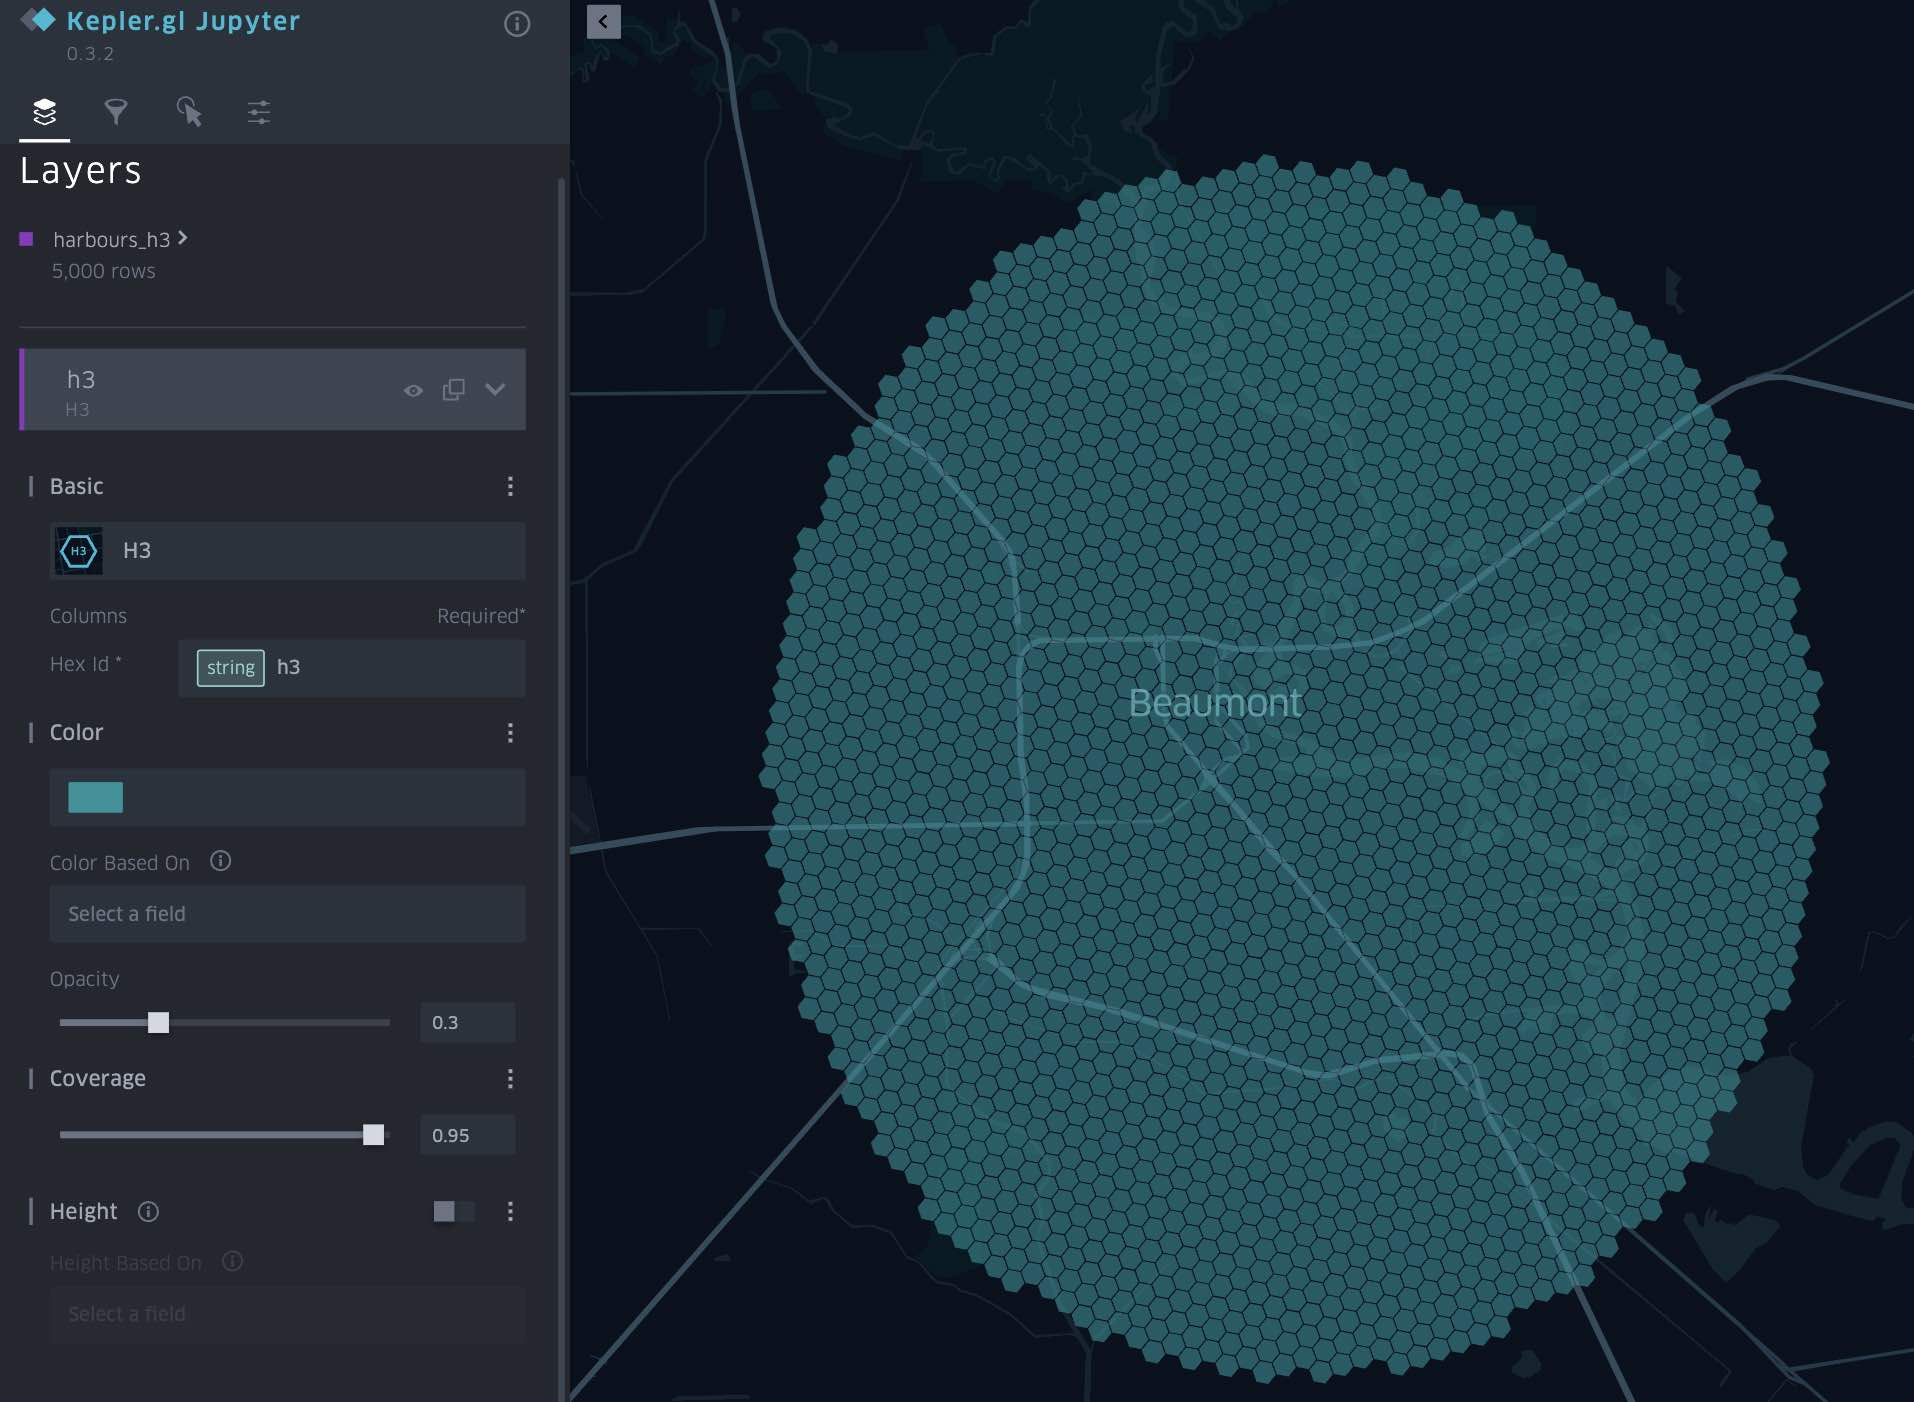

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAAB3qgAwAEAAAAAQAABXqkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIBXoHegMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAoKCgoKChEKChEYERERGCEYGBgYISohISEhISoyKioqKioqMjIyMjIyMjI8PDw8PDxGRkZGRk9PT09PT09PT0//2wBDAQwNDRQTFCITEyJSOC44UlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlJSUlL/3QAEAHj/2gAMAwEAAhEDEQA/AOAooorQgKKK1LW12fvJPvdh6UAZdLg4z2reTSmvZgYvlGfnP+e9dQdMtDafYtnyevfPrn1rSNNswq4iMHY84oq9f2E1hN5cnKn7rdiKo1DVtGbJpq6CitPTNOGoyPGX2bRnpn+oqOxsJL658hDgDlm9BRysl1Iq93sUKKt3sEVtcNBFJ5m3gnGOe46moVgndPMSNivqAcUW6FKSauRUUoBJwOSalW3uGJCxsSvXAPFIdyGilIIOD1rW1XT4bFYTEWPmKSd2PbpgD1ppaXJckml3MiipI4ZZTiJGfH90E0xlZSVYEEdjSKuJRUnlSnaNjfN93g8/SmsjIxRwVI6g8GgLjaKciPI21AWPoBmpGt7hDho2BAzyD0HegLohorX02whvILiWUsDCuVxj0PXj2rIptdSVJNtdgoorVtNNF1ZzXe/b5QJxjOcDPXNCV9hykoq7MqinpHJJnYpbHXAzQkbyHbGpY+gGaQ7jKKcqO52opJHYCn+RPs83Y2z+9g4/OgLoiop6RvIdsalj6AZppBBwRgjtQAlFSGGZWCFGDHoMHJrQv9MlstmMuGXcxC8D2707PclzSaVzLopyI8jbY1LH0AzSvHJE22VSp9CMUirjKKeEcrvCnbnGccUPFJHjzFK55GRjNAXGUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVZt7Z58tkKi9WPQUAVqK0dmmr8pd2PqOlJJZq0ZmtG8xR1HcUAZ9FFFABRRRQAVl3H+vb8P5VqVl3H+vb8P5UAQ1p2Wlz30ZljZVAO3nPWsyux8Pf8eT/9dD/IUwM3/hHbr/non6/4Uf8ACO3X/PRP1/wrsKjaSNGVXYAucKCep9qYHJ/8I7df89E/X/Cqd7pc9jGJZGVgTt4z1rvKwfEP/Hkn/XQfyNIDjqKKKACiiigAooooAKKVRlsUlABRRRQBcsZNlwB2birGpR8rKO/BrMUlWDDqOa3rkCe0LL6bhTE9zAooqaHvSGQ0VLKoB3etRUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5VLHFTMwUbVqOPufaiglhRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpk+7UNOVtpoAbTlYrUhAYZqIqR1oAlyGFRlSKb06VKp3DBoAiqf7y/WoKcrFfpQAYwGBptWOCKgIwcUAJRSE4pN1A7C00HmgnNJQNIdu9KbRRQOwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0OAooorQgs2rRLJmT8D6Vs1ztX7W624jkPHY00B3djJA8AEAxjqO+au159/aUtvMHtj93r6H2+ldKdetBZ/aR988eX3z/h710wqK2p5lbDyUrx1uS6zNZx2hS6G4t91R1z6j0xXn9T3NzNdzGaY5Y/kB6CoKwnLmdzto0uSNjpfDP/HxL/uD+daSJDa6ZPJpJ8xjnLHrx17DoOlYmh3ltZzSPcttDLgcE9/bNM0nURZXJEh/dSfe9vQ1pGSSSMKlOTlJry+ZQsolnvIon5DOAfp3rtp2v0ulEDwpAuBsY4OO/bj2rkbqS2gvxcWDBkDBwMEYOenOK17iXRNSYXM0jxSYwwA9PwNKDtdFVU5NO2noQXscSa7CYcYd0Y46ZzzV3VNXurO+EMW3YACQR1zWIgtV1WEWZLR+YmCevUZrf1GPSHvd95IyOoGV5wR27Gmm7OxMkk4qSvoZviOJEu0lUYLrz9RUniH7lr/uH+lZ+r3yX91vjzsQbVz396n1m8trtbcW7btikNwRjp61La96xcIyXJfzN4RXNvYQR6e0cZIDMX7kj6GszXVD20E8hQzD5X2HOeKbHeabfWUdrqDNG8XAYDr29D+NZd/Hp0YRbCRpDzuLfp2FVKWmhFODU9d/T9To7i+NhplrLGoMjRqqk9hgE/yFcjcTyXMzTy43NycVrajeW89hawxNueNQGGCMcAd6qWyaebSZrliJh9wD6cfrUzd3a5pSiorma1Njw/k21yIMCbHyk9OnH61bu7i7ttJdb2QCdzhcYzjI9PbNVdEJTTbhzH5w3f6sDk8DNSG1sry1mla1a2aNSQxyO36/lVr4dDCdvaNva5V0P/j0vf8AcH8mrm629KvLe2t7qOdtrSLhRgnJwfT61iVlJ6I64J88mFdRpP8AyB7z6N/6DWPp8dhI7LfuUGPlI9fyNa9xfadaWD2WnkuZMgk579Senb0pw01ZFZt+4kN8O9bj/cH9aj8N/wDH8/8A1zP8xVbRr+Kxnbz/ALkgwSOcVqQXOi6ZvntXaR2GAvP5dBVRto77GdVO8lbexX0D/kJy/wC43/oQq3Y6vc3GpfZZQvlsWAAHTAP+FUfDhLX8hPUxn+Yq3FJolncNeJI5kGcIQeCeuOP604vRak1EnKSavoZolXTNZZk4RXII/wBk/wCFaFzp4bXYyo/dynzPbjk/n/Wucmke6uWlxlpGyAOevauxtriS30n7TdIVkhUou4YJ6Y/p+VKNndF1bxs1vsYOp38v9qNPA2DF8inr069ffNaniG8uIXW3jbCSIdwwOea5Ikk5NdJqVzpuoW63HmFZlXATB6+nSkpXT1KlTSlDTYuaVDJFpJmtSizSE/M/QYOKNQWSXSn+2vG80ZBUoe2R/wDXrN06+szZvp1/kITkMO3ft71BeQ6PFAfskzyS5GAenv2FVze7oZ8j59e/b9TV0uZbbRZbhlDbHJAPrxj9a569vp791efGVGBgYq/DeW6aLNaM2JWbIXB6ZHfp2rEqJS0SNqcPelJrqFFFFZm4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWlekwxx2q9Au5vcms2tK8UzxR3adNu1vYigCK3H+jy/ut/H3uOKitpmgmVweM8+4q1aTRx2s6OwBYcD8KrWkDTzKoHAOSfQUAOvYhFcuq9Oo/GqlWryUTXLOvToPwqrQAUUUUAFZdx/r2/D+ValZdx/r2/D+VAENdj4d/48n/AOuh/kK46ux8O/8AHk//AF0P8hTA2ZnaOJpEUuVBIUdT7Vz+lRpqMraldsHlU4VO0eOnH8v8a6WsuTTF+3LfW7mJs/vAOjj3/wA/rQwNSsLxB/x5p/10H8jW7WHr5As0zz+8H8jTEzkKQjNO3ewpQw7gUiSIjFJUxUHlajI9KCkxtKBkUlPHSgGORfmphRhyalBCjPc0BiTg9DQK5BRTmXacU2goK3LB99vsP8Jx+FYdaGnSbZih/iH6ihCexTlTy5GT0NLGyrnNW9Rj2yiQfxD9RWfQPce7bm9qZRRQAUUUAE9KACipBGx9qf5XvQFyCipTEe1MKMvWgLjaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiilAzQAlFPwKCMigVxlFFFAwooooAKKKKACijrUoQAfP+VAEVSKmRknHpS4j9DQTk0CuOVCobPpTKdvJGKbQSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABQATwKKlQALuoAZsbGabUhkOeKUqGGRQBGCR0qRzlQajwc4qR/u0ARUqnBzSUUAPcc8d6ZgjrUiuMYNO3KRyaAGR9aSRufpSmRQMLUBJPWgdgJzRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0eAooorQgKKKKACiiigAooooAKKcqs52oCT6Ch0eM7XUqfQjFADaKACeBUjxSxjLqVz6jFADUdo3EiHDKQQfcU+aeW4k82dizdMmoqkEMpXeEYr64OKAstyOiiigAooooAKKKKALFvdXFqxa3coT1x3/AAqWfUb25XZPKWU9ug/SqVFO72J5Ve9gooopFBRRRQAUUUUATwXM9q5kt2KMRjI9KhJLEsep5pKKAstxyO0brIhwykEH3FWbm/u7sAXEhYDoOAPyFVKKdxcqvewUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFWbe6ktidmCD1U9DVaigDR87Tm+ZomU+gPH86ZLe/IYbZBGh6+p+pqjRQAUUUUAFFFFABWXcf69vw/lWpWXcf69vw/lQBDXVaHdW0Fq8c0io28nBOOoFcrUnfNMTZ3/2+y/57J+Yo/tCx/wCeyfmK4IruOR3pCuORyKBXO+/tCx/57J+YrG1y7tprVEhkV23g4Bzxg1zGKaV9KB3F3etOqOgHFAWJASORTm5APrTAaf8AwfjQSRN1pw6UYBpwUnpQMePmX3FR1JwgPPNV8nOaAsTsN6Z7ioKkRiOacUV+V4NA0Q0+JzHIrjsc00gg4NJQM3r6PzYMr1BBH41gkYOK37RhNagHsNprEdcSMp7EimyUR0UpGKSkUFTxDjNQU5WK9KAZMzEHApm4+tODq4weDTCCDg0EC7j608PnhqjooAV4/wCJelRVOhwcetRsmGIoKTGUU8Lk4zUqR7Tk0DuV6KnkQY3CoKACiiigAooooAKKKKACiiigApVpKKAJKKKKCBhGDSU8jNMIxQUmFFFFAwooooAmACAEdTTc55NPk6gUyggKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKlbhMVGoywp8h5AoAjpQSDkU09Kbk0DSLHmCmMxaosmjJoCwpNIDikooKsPyMZphOaKKASCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/0uAooorQgKKKKACiiigAooooAsxkpbSMvBLKv4cn+lKSWtAW52vgfQio4pQgZHXcrdRnHToaWSVWQRRrtUHPJySaAIlZkO5TgjuKuLj7PJtcuxAyvpyOfequ6MSbtvy/3Sf61L50aoywoVLDBJOePbgUAVquWzStKJWYhY8FjnoB2/GqpK7QAOc8mrRuIGjWMxsAOwbqfU8UAVWIZiwGMmm0pxk44FJQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVl3H+vb8P5VqVnT/wCub8P5UA2V9tPopdpxnFMkACeO1OU4PHQ0fdjz60xHCjBGaAsDYDEUUwnJzQDigdhxGaYRing5oJ4oEmNWpVIxg1DSg0DaJsJ1zxQXPQcCo8jGaZQKwrHtSUUUFADing+lMooBosBlYbWqF02n2pOTUvVCD2oFsXtMf5mj9Rmob1NlwSP4uabYHFyB6girOoj50b1GKfQT3M2kCMelPAycU9mx8q0gTIvLf0plTK5HXpTmQPyvWgdyvVhgNgNQhWJxipG7L6UAxtFFFBIVJJ2qOnydaAGVJ5nqKjooAe7BlwKi206igdxu2jbTqKAuN20badRQFxu0UbRTqKAuN2ijaKdRQFxu0UuBS0UBcSloooEFNanU4AdT0oGiIAnoKf5bU7ceg4pvXrQFxpTHcU9YzkHIpKKAuOc5am0UUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHxjnNIxyxp0feoz1oAQ9KZTm6U2gpCjrg96TpxSqNxxSucsSKBjaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//T4CiiitCAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKzp/wDXN+H8q0azbhj5rAe38qAYwAHjPNOJwyk9xUSfeFSPzGDTFYSUjAUVFRRQMKKKKACgnNFFABRRRQAUUUUAFFFFACgd6XAoB7UtBLFpf4TSU5uABQIfbfLcIff+daOoj92rehxWWh2sG9DWzfDNuT6EGmDMdBzn0ph5Oak6J9ajpAFKCR0phPYUmTQOxMXJ6cUz61Hk0UDsSUU0HtTqCQHUU5/vUi9RQ33jQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAqjJxSsc8DoKU/KNo696ZQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRigAooooAKKKKACiiigAooooAKKKKACiinKu76UAPj6GkIC89SaVOhpsnWgCJjnrSAEnApSCSAKmAWJcnrQUhmPLBJ6npUVKSWOTSUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9TgKKKK0ICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArLuP9e34fyrUrLuP9e34fyoAhBwcinFmbrTaKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABT+gpgOKf1oEw6CpRiRfcVAT2pyEjLDt2oCwtb0n7y0Oe65/rWIJc9q24D5lsPcEf0polmGzA8DtUZPagnHFNpFJBRTtvrS4FAXGUUpGKSgYU8HNMoBxQDRMn3hSHqaQMAQafgPyD+FBIyinFWFNoEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPHyjcfwpFXPJ6ChiCeKAG9aKKKACiiigAooooAKKKKACiiigAooooAKenGT6CmU7ov1oAbRRRQAUUUUAFFFFABRRRQAUUUUAKo3HFPL44A6UwHBzUg2k570AKmcHNIdh5Jp9V6AH70XoKhJLHJoPWkoLQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9XgKKKK0ICiiigDpNI8K6trMYnt0VISTiSQ4Bx1xjJP5V30Pw60wW2yeeVpiPvrgAH6EHj8a5zQtY8QaNpq3LLG9iMlEldUZueRHk59exHXFdcnj/Qmt/OfzVcAfu9uTn2OcfmRUu5Rweq+CNX04PNCBcwrzuThsepU/wBCa46vT77xNrmt2039iRrHCuVZdytMVIOTt9MegJ968wpoQUUUUxBRRRQAVfFpHFGst0xXd0VRyaoVs2ksN1GLW5GSPumgCiWsugWT65H+FP8AsscyNJasTt6q3B/StT+yrbOct+f/ANaq93JDZo1tbDDN94+gpgYtFFFIAooooAKKKKALoKWsSttBlcbsnoAenHvQLtmOy6UOv0AI+mKJ1MsSXC8gKFb2I/xrTitobyzjLjDAY3DrxxTAxZ4vJlMYOQOh9j0qGrt3b3ERBl5UAKGHTA6VSpAFFFFABRRRQAVY+yXX/PNvyqvVuG2up87AeO54oAdDp9xK20rsHq1RzWk8BO9TtH8Q6UsbXcDkpuBHB4zUcpnkJklyc9SRQBDRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWXcf69vw/lWpWXcf69vw/lQBDRRRTAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnIdrCm0UAPYBXIFbdg2bfHoSKxJPvmtXTG+R19Dn86aJaMuVdsrr6Eiox1qzeLtuXHvn86rUiiSikyKMiggOtMp24UhINBSEooooGFKOtJRQBMGYU7crfeFRA5paCCTYD9000qwpvTpTw5HXmgBlFPcDqO9MoAKKKKACiiigAooooAKUDJxSU4cAt+FACscfKKZRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAoGTQTngdBSUpHcUAJRRRQAo60lAODmg8EigAooooAKKKKACiiigApR1H1oII4708jG0UAPb7pqCpn+7UNADD1pKD1ooLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9bgKKKK0ICiiigDsbObU7fRklvltpbFSTFFc43Nyc+Xj5hz+H4Zqr/xScpW5JuoP70C7X5/2XOOPqM1SsNdvLKD7E4W4tScmCUbl/4D3U9enfmraT+FXAuJbe5jdc5hRwY29PmPzAevU0hmnBNd39nOvhuK3tVUENGpzcsmOTuYZI/3TXD10EviG4WBrTTIo7GFsgiLO9h6M5JY/pXP0AFFFFMQUUUUAFKrFSGU4I6GkooA6QXjGwNx/EOPx6VzrMzsWY5J6mrQuR9ja1I5zkH8ap0AFFFFABRRRQAUUUUASRyyRHdGxU+1b2lMWtiD2Y1ztWYbqWCNkj43d/SgDo7qYwQmTbu7e341yjHcxbAGew6VsWN4hiaC5PAHBPcelZD7d52fdzxn0psBtFFFIAooooAKuw6hcw5+bfn+9k1Sq19suPUf98r/AIUAPWS+nLPGznucE4qu08zrtd2IPYk1eg1OSJSrqGJ6dB/IVUkuppQVcjB9ABQBXooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArLuP9e34fyrUrLuP9e34fyoAhooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSr1FJTkGWFACyffNXdNbExX1H8qoucuTU1o2y4Q++Pz4oF0J9RXFxn1UVQrV1NeUb6isqhgtgooooGFFFFABRRRQAUUUUAA4qQAnkCo6sx/dx6UCY0o1AUDlqczMOlRUEjmbcabRRQAUUUUAFFFFABRRRQAU5uML6UIOc+lNJyc0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADuG4AxQ390dqReuKc3IDetADKKKOvFACgZNDHJyKU8fKKbQAUUUUAFFFFAChS3SpQoUUqnIo3LnFAxiDJ3GpMDOaThRULS54WgAkbcdo6UlR0UDsFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1+AooorQgKK6rQdO8O3lq8msXjW8gfCqCBlcDnlT3rc/sLwN/wBBN/8Avpf/AIilcZ5zRXo39heBv+gm/wD30v8A8RR/YXgb/oJv/wB9L/8AEUXCx5zRXo39heBv+gm//fS//EUf2F4G/wCgm/8A30v/AMRRcLHnNFdtqmkeE7ewlm06/eadQNiFlweRn+Edq4mmAUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKy7j/Xt+H8q1Ky7j/Xt+H8qAIaKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVInyqX/AAFR9akk4wg7UAR0qsVYMOxzSUUAbl8BJahx2IP51h1uxfvrDb32kfl0rCpsSCiiikMKKKKACiiigAooooAKkB7io6KAaLAf1o2q3K1CD606gkUgjrSU4Owpd/fHNAhArGlKEdOaQsx70gJHSgBKKflW68GmkEUAJRRSgZOKAHfdT60YAGWqQgHr2qNlYnNAxPlIOOMU2nYwuT3ptAgooooAKKKKACiiigAooooAKKKKACiiigA6dKduPfkU2igBSO46UlKrY+lKy45HSgBWBIDCm7WPanMSG4NKrHODQBHRTmGDTaACiiigBysVoLAkGm0UATH51IFViCODTwSOlSBg3DUDTK9FPdCp9qZQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9DziiiirEFFWrK0lv7yKyhIDzOEUt0yfXrT9RsJtMvZbC4Kl4jglckdM8ZAoApUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVRm/1pq9VGb/WmhCZHRRRVCCiiigAooooAKKKKACiiigAooooAKKKKACiiigCSMc7j0FMJyc1IfljA9aioAKKKKANnTWzEyehz+dZMq7JGT0JFXtNbErJ6j+VRX67bkn+8Af6U+gupTooopDCiiigAooooAKKKKACiiigApckUlFADt1LkUyigViSio6XJoFYfSgkUzdS5FAWJQyY5FAeMcioj0plA0iz5ietM3nORUNPHSgTJdwYYak2HrkUyigQ/aPUUmF9aFXPJ6UpZewoANqkEg0ynFyeKbQAUUUoUnpQAlFBGDg04LkZJxQA2in7D25plABRT1UYyaaVKmgBKKKKAClDEUlFACk5OaSn7DigIT14oAV+1R09/vUygAooooAKKKKACiiigCV/mTiq2MVZQ5G2o2XH0oHciop22m9KCrhRRRQAUUUUAFFFFABRRRQAUUVds7Q3Dbm4Qdff2oE3ZXZSorefS4T9xiv61l3VqbVgCdwbvjFFiYzT2KtFFFBYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9HziiiirEbnhr/kP2P/AF2T+dWPF/8AyMl7/vj/ANBFV/DX/Ifsf+uyfzqx4v8A+Rkvf98f+gikBzdbmi/2Apll1zzmCbfLji/iznOT7cdxWHXVaFoVneWVxrGrTNDZ252nYMszHHA646jt3oA2rJfA2sXC6dFbT2kkp2pIXJ+bsOWYZP0rir+ybTNRlsbj5/JfaccbgO/tkV2OlyeDJNTtFtY72OUTJsZihBbcMbuTxn0rH8af8jNefVP/AEBaAJ/FWi2Wni01DSg32S7jDLkk4br+oI4+tYmi6edV1W3sO0rjdj+6OW/QGuv0U/294Wu9Cb5p7T9/AO5HUgfjkf8AAhUPg8LptnqHiSUcW8flxZ6F2/8Ar4H40Ac54hgsLXWLi100EQwts5JPzDhuvvmulGj+H9AsoJ/EYlnubhd4gj+Xav8Atcg/Xnr0HBNcNGRLcKZiTvYbievJ5NeoeMv+Eb/tgf2v9s83ylx5Pl7NuTj73PXNAGLPo+g61p09/wCHPMhmtV3yW8nOV9Qcn37n0xzXOeHrKDUdZtrK5BMcjEMAcHoT1rp9I1jwjotxJc2iXztJGYiJBERgkHsR6Vh+EP8AkZLL/fP/AKCaAOkudF8L+HXb+3DJPLIzGOCI/djydpJyvOPf8O9cdDZw6rrQstMBjinl2x7+SqE9Tz2HvUviad7nxBfSSdRMyD6Ido/QVmWd1LY3cV5B9+Fw656ZBzz7etAHc3a+BtJuH06a3uLqSI7XkDY+YdQMMvTp0rktXGkfag2imTyWQEiXqrZOR9AMev1rsJbrwj4ml829L6deSY3OOY2bpk9vz2/WuU13RLjQr37JOwkVl3xuvRlPf2PqKAMWiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFVJG+dlP4VbqjN/rTQhMjooIwcUVQgooooAKKKKACiiigAooooAKKKKACiiigAooooAkl+8PpUdSS/eH0qOgEFFFFAFi1bZcIffH58Vd1NPuP9RWUCQcjtW5egSWu8dsNTE9zDooopDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKVRk80lO6Jn1oAbTx0plPHSgTFooooJJF5UrUdOVtp5p3yE5zQAwKT9KdhT0NIzZ4HSm0AO2GhiScU3pTl65PagBWGSFoc9h0FIp5J9qbQAoYjpTjh/Y0yigBwJU1LlSuT0qIORxSFiaAFZccjpTacpIOKGGDxQA2ilwfSkoAKer44NMpwXK5zQA5lJORUdSoSOCacVBoAgopxQj3ptABRRRQAUUUUAHSpVYNwairZsLJSvmzjOeg9vWhCcrbmQy7TUNdLLp1u44yv0P+NYN1D5E7R9QOn0oaCE09iCiiig0CiiigAorWsLMP+/mGR2B7+9X3sbV/wCDH04p2M3USdjnERpGCIMk9K30063EYVxubuaILeK2uCo53LlSevHUVfppGc6l9jKl0uPaTGzZA6HmtCARiFfJ+7jiparRukbtAzAEHIyex5pkNtrUs1R1CLzLcsOqc/41eqs3+kNs/wCWann/AGj6fT1oYo6O5zFKAWIVRkntXUPa2z/ejX8OP5VXW1htp0kQcNlfXB7VNjf2qC3sYki2zKGY9aV9NtW6Ar9D/jmr1FVYx53vc5GRDG5RuqnFNrT1KHEwdBncMn8OKzKhnVF3Vwoq7ZWhuH3N9xevv7V0DRxsMMoP1FNIiVRJ2OSrfs7JY490ygs3Y84FPlt4ISs6IAUIJ+nT9OtXqaRnOpdaFR7G1f8Agx9OKwbqHyJmjHQdPpXU1lanCX2Ogy3IwOuOv6UNBTk72ZiUUpUqcMMH3qza2zXMmOijqak6G7alXBxnHFFdcEVVCADA7VVuLSGSJtqANjggd/wp8piqqObooopGwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0vOKKKKsRseH5Y4dbs5ZmCIsylmY4AGepJrt9Z0DSNV1OfUF1q0jEzA7SynHAHXfXmFFIDrtT8N6dYWMl3Bq1vcumMRIV3NkgcYY9M56Vd8O3Gm3uh3fhy+uFtXlkEscj8LnjjnA/h9e/FcJRQB6Fp2g6bol7FqGsajbt5Tq6RwNuZmByM9MAH2x71geLp4LnxFdT2zrJGxXDIQwPyKOCOK5yigDb8PaodH1eC9ydgO2QeqNwfrjqPcV2Pjc22k2UOhWXyiaV7mQDjgk7R9Ow/3RXPaTrei6fDE1xpgnuYclZTIQGOSQSuMcdutYuq6nc6vfSX90fnc9B0UDoB9KAM6vTLn+yvGdnbzvdx2mowoI3EuAJPp+OSMZxnBHSvM6KAOyufCtrp9rLPqGp24kRCUiiO9mbHA7EZPsazfC00Nvr9pNcOsaK5yzEAD5T1Jrn6KANPWpI5dZvZYmDo9xIyspyCCxwQfSoNPis5r2KK/kMMDHDuBkgfrVOimB3B8GI7+ZBqlm9uDzIXwQPpyM/wDAqr+LtRsrqW00/T5POisYRF5v948A/XoOa4+ikAUUUUwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnxqHcKe9MqaD/WrQIfPEqAMv0rIm/wBaa3Lr7g+tYc3+tNMBrdj6im07qn0NNpiCiiigAooooAKKKKACiiigAooooAKKKKACiiigCSX7w+lR1JL94fSo6AQUUUUAFbsH76y299pX8qwq2dNbMbJ6HP500KRjUVLOmyZ09CaipDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAAMnFPfrgduKI+Mse1MoAKdkU2igLDtwo3Cm0UCsO3CjdTaKAsO3UbqbRQFh9KDio6cG9aBWJQVHI61GTiimE5oBIduo3U2igqw7dTqjp+RQS0KODmpWIB3flUNLQIduOc0MBwR3poxnmpiF2j0FAEQVj2pzcALTWYk0lABRSZpaAHByOvNSYV+ahpRnPHWgAIIODSV0draKkeZQCzdc9qe9nbN95B+HH8qdjN1Fcwba3a4k2jhR1NbptLYgKUHH4UWyLFvhUY2nP4HpVzAppGc5NsyZLK3ixMAcKRkE8YrWHSkYKQVPQ8VVjuIxGFdgCOMngccdelMltssnk1j6tFkLMO3BrUMiBS+4YHeolUvJ57+nyj0H+JoY4OzucrU0EDzyCNPxPoK6V7eB/vop/CoYY47eZo0GA4yPw61Njb2umhItrAqCPYCB6iq02nwFCY1wwGR1rQoqrGKkxkbK8asnQgYp9VIpFi3RnJCscEAkc8449KnWaFvuuD+NANDLghFWXONjA/UHginLcQucK4z6d6YgMz+a33B9wevv/hU7KrjDAH60B5Mjkk2ABRlm4A/z2pUiVFwfmJ5JPc1CY0gmR0XAbKnA/EVaoB+RCYIj0G33Xj+VJbH9yFPBX5T9RU9VBII53CgsDgtjnB6fyoBaluobgAwsWOMcg+45FH2iLOGO3/eBH86YD9obd/yzU8f7R9foKAS6jluYyoL5TP8AeBH69KVp4wu5CGJ4AHc1NVadFTbOoGUPJ9jwaAViSKMoCzHLNyT/AJ7U5oon++oP1FPooFcr24Ee+ADAU5H0PNWKqyMVnUxrubadwHp2/WnfaVH31dfqP8M0Dab1J2ClSG6Ec/Sq8M2IwHDcDrgkEevFJuW6OF/1Y6+59Pp61aoDbRkJuIQPvAn07/lSxowJkk+8f0HoKJkLxnb94cr9RzT43EiK69GGaA6aClVYYYAj3qugWKdowAA43ADjkcH+lWagmJ3IE5cHOPbvmgF2J6Ki81h96Nh7jB/+vUbP558tMgDljjB+nPrQKxjzWcryPJAu5CTg1UeKWP76kfUV1gAAwOAKRlDqVPQjFKxqqrOQop0iGN2RuqnFNqToCinxRvK4jQZJq6+mXK/dw30P+NFhOSW5n0VJLDLCQJVK56VHQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9PziiiirEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMBqnqD0NIQQcGkpwwflP4UxDaKOnFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkv3h9KjqSX734VHQCCiiigArQ01sTFf7w/lWfU9q2y4Q++Pz4oBk+oJtuM/3gD/SqNa2ppwj/UVk0MS2CiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUU9FB+Y9BQA5vlQL681FSsxY5NJQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSg0lFADwc0tR0uTQTYcTikAd87QTjriljjeVwiDJNdNbwLbxhF69z6mmkTKSicwtaFlamdt7j5B+tbjRxv99Q31FRQfJuh4+Q8Y9DyKdjOVS60J2RGGGAI9xVSSCGErOigbSM/Tp/9ermaRtpRg/THP0pmSY8HFO6iqUUrCJd6t06gdffA5qX7RGBwcnsvc/gaBWGORHcIw5JBBAGTj1p5uIc4LbT/tcfzp8cZBMj/fbr7e1PbnrQN2Krt5x8qM8fxMP5D61YAAGB0FQIBFM0YwA43Ae44P8ASrFAmV5oUZCyqN45Bx3FSq4kRXXoQDT6qROwQ7ULJklSMdD9aBrUs1XnO0o4yWDcAd/X9KDcxKCW3DHqpp0aMW86T7x6D0Hp/jQNK2rDz0H3wy/UH+fSmtKJf3cDAk9SOcD/ABqxUD/JOr9n+U/zFAKxKiqihF6CkkjSRSrgHNPooEQwMWiAb7y/KfqKmqopfzHeFdynHfHI4OKkM+376Mv4Z/lmgbQXIBiOev8AD/vdv1oEzD78bD6c/wAqSIeaRO3T+Aeg9fqasUB5Fdpw37uH759QRj3OamRBGu0fifU1FcfKFmH8ByfoeDU9APYKgg+UvD/dPH0PIqeqpLtPuhAO0bWJ6Z9PwoBFqmSlBGxk+7jmmeZKPvRn/gJB/nimRkzv5h4VThQeue5P9KAsJG86RqHjzgdiM/0pXuNo2qrbzwARgZ+vSrNRTKzxkL94cj6jpQF1cWKPy155Y8sfU1JTUcSIHHQjNOoEyuv7u4ZOzjcPqOD/AEqxVaXc8irEcMnJJ6DI6fjT91wvVVb6HB/I/wCNA2iVmCqWY4A5NVYzOqkqgKkkqCcEA/hSgmeUo67VTBKnue34VboDYqtcGNSzxsMfQj8xUkUezLty7dT/AEHsKkZQ6lT0IxUcDM0YDfeX5Tn1FAdCWoH+SZH7N8p/mP61YqtNlz5CfeOCT6AHr/hQJFigkAZNQYuV7q31BH+NMJklkEMq7RjccHOfb/GgdinNZtduZ0IUHpnvjvVR9NuU5ADfQ/410OKWlYpVGihY2ywxB+rOAc+3pV6oIAULxH+E5H0PNWKaJk7sz9RiMluWHVOfw71z1dVMSR5SYLOMY9u5NUG0lP4HI+vP+FJo1pzSVmYlFXbmxlt13khlzjiqeDUmyknsJRS4NGDQO4lFLg0bTQFxKKXaaNpoC4lFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/1POKKKKsQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNB/rVqGpoP9atAixdfcH1rDm/1prcuvuD61hzf600wI6KKKYh3UY702ignNABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEkv3vwqOpJfvfhUdAIKKKKACgEg5HaiigDevAJbQsPZhWDW9b/AL6zC+qlf6Vg02JBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAKAWOBT3IHyDt1pR+7XPc1FQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFi1l8mdX7Zwfoa6iuQAJIA6mulja5RFV0DYA6H/HFUjCqupaqq5YXAMY3ELhhx+FK1weFCsrMcDcOM/XpUsUYiXaDk9ST1JpmWw3zwPvqy/hn+WaapFw2R/q16+5/wFWKgT5J2QnhxuH1HB/pQBZqORSyHb1HI+oqSkLBRuboKZKHowdA46EZptQILhUJAGCSQpOCAe2eaR5nRSWjP4EEf4/pSHbsJMWLosfLg59sdDmn+ZIPvRn/AICQf8KdFGUHzHLHkn3qSgVyqW+0N5QBCD72eM+1Whx0qB/kmR+zfKf5j+tT0AxrorqUbowxUcDFoxu+8vB+oqbIAOe3NVIxKxaWPCq5zgg8+/tmga2LdV7jayiIfeY/L9Rzn8KUyTKCWjzj+6f8cUQKSvnNyzgH6D0FAbai7pl6oG+h/of8aYztKRDtKZGST6D0xVmoJ/lCzAfcPP0PBoBEqqqqFUYA4FOoopkleD5S8P8AdPH0PIqxVUBpnM0Z2gDaDjOf/relP/0hf7rfmP8AGkUx0rKE2kZ3cAeuajRbmNAuUbAxzkf40sP7wmZ/vcrj0welWKA20KjySnEZXYXOA2cj/wDX6VZRFRQi9BTJlLRnb94cj6ino4kQOvQjNAnsOquvyXDJ2cbh9Rwf6VYqqwNw4KMVVCfmHc+3tQCLVMkkEa7jz6AdSai2XK/ddW/3h/hTYw0krNN95OAO3Pf8aAsCR3CrwyjqdpGQM9s5oklnjTLKvYZBzjPfGKtU1lDqUPQjBoC/cREEa7Rz6k9zT6hgYtGN33l+U/UVNQDK7/JOj9m+U/zFWKrODM/lj7qnLH3HQCn+XIPuyH8cH/A0DJGYIpZugqBElbMm4oW5xwR7Z96QBzOFlIIA3LgYBP8A9arVAtiuxuVBI2vj6j/GnQqAgfOS/JPrU1QQ/KXiP8JyPoeaA6E9V5/lCyj+A5P0PBqxVeUmRvITuPmPoPT6mgEWKQkKCzHAFQ+QB9xmX8c/zzTGVw6LI25CfTHPbPrQFhVjMrecSVyMAD096k2Sjo+f94f4YqWigLleAZBkb75JDe2O1WKrjEc7A4Acbh9Rwf6VY70AyC4i86Fo+5HH1rmK6iRiT5UZwx7+g/z0qM2VswwUFJq5pCXLuc3WpZ2KyL5sw4PQf1qeSwgjIlGdoIyD6Vp0JDlU00M1tMhP3GI/WsieEwSmMnOO9dTWTqkfCyj/AHTQ0KE3ezMeiiipNyOiiigsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1fOKKKKsQUVtaYB5TfWtLA9K7KeF5oqVzeNG6vc5OipZv9c/+8f51FXG1Z2MGFFXdN/5CNt/11T/ANCFaD2VlcTTRW87GddzAFcK2MkgHOaAMKirdutiVzdPIDnGEUHj1ySP5VbGl778WccmQ6b0fGMgruGfSgDJxngUVvadHax6tbLbSNJhjuJXaOnbkn86rrZWU4eO0mZpUUsNy4V9vJxznp60AZNFacdpax20dzeyOvm52LGoJwDjJyR3px01ftawLJuSSMyo4HUBSeR25GKAMqirVtbidZmJx5UZf64IGP1q41hawW8VzczEeamVVVyc8+4wOn1oAyaK1BZ2kVvFLdyurTAldihgADjkkj8hWYcAnHIoASitrTVhewvBO5RP3ZJAyep4A96rXVpAlsl5aSM8bMUIYYZWAz2J7UAZ1FdJYS3l048m2iFspAfKDaAOpLHnOPesG48oXEgg/wBXuOz/AHc8fpQAfZ5jCbnYfLB27scZqGug0K7mE39nmPzoZuGT09/8apatZw2N60ED71647r7GgRmUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpoP9atQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/AFppgR0UUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTlGWAoAdL978Kjp8hyxplAIKKKKACiiigDZ01sxsnoc/nWZcJsndferWnNiYr/AHh/Kk1FNs+7+8KfQXUoUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFPRR95ugpqgscCnuR9xegoAYzFjk0lFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFPjjeVxGgyTQAyitZtKfHyOD9RioBYSrKiS4CscZH54osTzx7jLaykuVLg7QOme5p76bcr0Ab6H/GugVVRQijAHApaqxh7V3MrTrUKDNJ94EgD0xwa1agU7J2Q9HG4fUcH+lT00RJ3dyKZS0Z2/eHI+o5p6OsiB16EZFNlkES7iMk8ADqTUUcUyLgOPXBGQM88c0B0LNVpN0koERwU6nr1HTFJJJcRrkhcZA3AnjJxnFWERY12rQGxHuuV6qjfQkf402MtNN+8G0RkfL7+tWKhPyXCSc4f5T/Mf1oBFsjNRsoZSrdCMGpajkZUUu3amQQwMWjAb7y/KfqKmqqkMhzIXKMxzgYIH5ilb7SikqVfA9MH+dIpoJsyEQp14JPpj+tO23C9GVvqMfy/wpYEVYwVOd3JPqT3qagV+hUPmSyCKUBQBuwDnOD+FXD61Xn+QLN/cPP0PBqwPSgGJUEHyloemw8fQ8ipmYICzHAHWqyxGRzM5KkjAA4wPegEWqgmbI8lRlnH5DuTShJl6SZ/3h/him2w+Qu3Lknd9R2oDzARSKAEkOB2YA/4Ux/OJWOUrtY4JGRnjp+NW6imVmjO37w5H1FA0yUDHAopqOJEDr0IzSkgDJ6UySBTsnZOzjcPqOD/AEqxVUJ9oPmOCFH3R0P14p/ksPuSMPrz/OkUx0smzCry7dB/X6UxYCgwrsD+n5HNJADvk3nLg4z7Y4xVmgWxVl85U+ZwVyASBzg/jVhVVFCqMAdqVlDKVPQjFRQOWjAY/MvB+ooDoTVA/wAkyvzhvlP8x/Wp6rYFw2W/1a9B6n1+lAIs1HI4QepPAHqab5Kj7pZfoT/I8UxFInIclvlypOPx6fhQAq24HzMx3E5JBI/SkkSdUYxuScHAIFWaKAuRxBBGvl/dIyPxqSqsTpEWhZgNp4yex5q116UAyvP8oWUfwHJ+h4NWOvSqx/fttH3FPPufT6Cnm3hzkLg+3H8qBj3cRruP4D1NRLCHG+YZc+nb2FNMeyZGJLKcgbjnB/zmrVAttiDySPuSMPxz/PNFtxEM/eyd3171PVXesMzBiArgN+PSge5aqKdC8ZC/eHI+o5FPV0cZQg/SonzK3lr90feP9P8AGgSHRyxyKCrDJHTNPd1RS7dBTWiifhkU/UVXliji2yjgKwyCSRjp09qB6EiRiT95MuSeinnA/wA9aX7PEPugr/ukj+VT0UCuV4BtLoTlgep6kHp/hViq0rCKZX5+YEEAZPHOePSnieFuA4z6Hg/rQNrqSMoZSp6EYqvDcRlAjuNw4PPXFOkZnbyYz/vN6D/E1KI0ChNo2jtQHTUcWABYngd6gRfOYTOOP4Qf5/U02a3j2FolAYcjHGcc1YVg6h16EZoD0Intrd/vIPyxWJf2628g2DCsOK6Ks/UY/MgAHLZG0etJoqEtTnaKkeKWP76kfUVHUnWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//1vOKKKKsRp2NzDAjLIcEn0q79vtf7x/I1z9FdEMTKK5UaxrNKyHykNIzDoSTTKKK5276mRbsGVL+3dyFVZUJJ4AAIq3YyRpqpkdgF/e8k8cq2OfesmigDftHkFgi2EscUm9vN3MqsRxt5PYe1Ty3ER1NJDKrAWxUuDgFvLI/n2rmaKANHSZI4tRhklYKqtkk8AcVbtIFsJWvJZomVEbZtYMWLAgYA5HXnIrDooA2WiF9Z2/kugkhUo6swU4ySCMkZHPNWVntor+2hMoKRQmJnHK7mDZwe4BbrXO0UAbiW62FtcvNLGzSJ5aKjBickHPHbiqd9Ijx2oRgdsIBweh3Nwaz6KAOg037Qixq00LWzHMiSMpAGeflPIP0rHlj3yubZWMe47eD0zx+lV6njurqFdkMrovXCsQP0oAuW7LHp95FIQrt5eFPBOCc4FJ5if2P5W4b/tG7bnnG3rj0qhJJJK5klYsx6knJplAGzBYSQzLKl3Cigg71kGQPp1z7YqheyRzXk0sIwjuSPoTVWigDYs9VNjZvDbxhZnPMvfFZBJYkk5J6mkooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpoP8AWrUNTQf61aBFi6+4PrWHN/rTW5dfcH1rDm/1ppgR0UUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFOVC3PQetACKpY4FPLBRtT86Rm42rwKZQAUUUUAFFFFABRRRQBYtW2XCH3x+fFaGpplEf0OPzrIBKkMOo5reugJbQsPQMKaE9zAooopDCiiigAooooAKKKKACiiigAooqRAPvnoKAF/wBWv+0aipWJY5NJQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFT21u1xKEHA6k+1azaVCfuMw+vNFiXNLRmFWlbaeZo/MkJXP3akXTxFOglYMjHHpzW1TSM51P5TEfSpB/q3B+vH+NXNPgWKMv1ckg+2D0q/UCnZOyH+Mbh9Rwf6VVjNzbVmT1FMpaM7fvDkfUVLUUshXCJy7dPb3NBCHo4kQOvQjNOqsttsUBJHBHvn9DmmTLMqfM+UJAOBzg+//ANagdl0HEG4fcpKovRh1J/wp4SdfuyA/7w/wxUygKAqjAHQUtAXKsO55Wab7ycADoAR1H1q1UD/JOr9n+U/zH9anoBiModSjdCMGo4GLRjd95flP1FLJJsHAyx4A9TUK2qj5mJ3nkkEjn8KAW2paquf9Il8scIh5PqfQfSmSRTJGxjkY4HQ4/nirEQQRr5f3cDFAbaj/ACnH3JGH1wf/AK9RqHM+JSGwMrgY+tWqgn+ULL/cPP0PBoEmSHrSUpIPI5qORxGu7r6D1NMkihO0tD/dPH0PNWKrC3RxunAZj19vYU7yMfcdl/HP880inYSQ+cTAvT+M/wBPxpfIUDCMy/Q/45otseUB3Gd3171PQDdtCq6sJIxK25Se/HzDp0q1UUy7ozjqOR9RzRHNFIBtYEntmgHqiWq4IjnKkgBxuH1HB/pUrusal26Coki3EyTAFm7HkAelAkWKhkZmPlR8E9T6D/H0o8iMfdBX/dJH8qbANhdCcsGyT3IPT/CgBwgiX7o2/QkfyqKaMqoJdioYbgeeP51bpGUMpU9CMUAmLRVWG4TYBI2GHBzxnHFTl0Cl8jaO9ANEMrCKVZGOFb5T6eoqwGVhlSD9KhjUu3nSf8BHoP8AE05oIWOSoz69DQNiSuwwkf326ew9aT7NDtwygn1PX86bGgjmZRn5gCCeenBFWaBbbFSWDEbeWWzjpk8+3OasoVKAr0I4p1VIpEi3Rt0ViAeo55xn2oHui3Ve4OwLL/dP6Hg1IJYm+6wP41GgMziVvuD7o9fc/wBKBIkWaJ/uuD+NJLIUACjLNwBTmRH++oP1FVxGkE6sgAVxt/HqKBqxMkKKuG+Ynkk9zTDbQ4O1dpP93j+VWKKBXZDb/wCpVcAFflIHqKmqqH8udwASpwTgZwf84qXz4u7Y/wB7j+dA2hLgfuWOQCvIJ9RzTRcxYG87Cf7wI/nQP375P+rU8e59foKsUARNMgXKncTwAO5oijKAljlm5J/z2qKVEjKzgAbT8xx2PBq1QIjaKN+WUE/SmQAJui/un9DyKnqq7FZwYwWO3DAY6duuKAXYtU1wpQhuhHP0qL7Qg++GX6g/zHFNyLk4U/u1PPufT6UBYbFPiNfMDdOuDg+/GaebmEAkMCR27/lVioZkLoSv3l5H1FA9AiRgTJJ99v0HoKlZVYYYAj3pFYOoYdCM06gRWiRYpWjUYVvmHp6H+lWarzZ3ps5cHOPboc07ziPvxsPpz/Kgb1JqpwyFAVCsUDHaRzx/Onl/PPlpkL/Een4VYAAGBwBQLYh+0Q4yx2/UEfzpUVmPmyDBPQeg/wAfWpHQSIUboRimQsWjG77w4P1FAx9Y2qQgbZlHsf6Vs1VvAJIvJxln4X/GhlQdmczRV99NuV6AN9D/AI1TkikiO2RSp96g6lJPYZRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//9fziiiirEFFFFABRRRQAoBPAoKsOSDVuyIWVjuCHY2CTjkjFPmFy0JYzeagIzhicemQaBFClKsOoxVqzA81pCM+WjMM+oHFSwTy3BeGZi4ZWPPOCBkEUAUAC3AGaSr7yyW8ESQsU3LvYjgnkgfyqdQJZYJ5ACSrFvcpnrQBlFWAyRwaStK2uJrifyZmLLICCD06cY9KzaBhRV64jtoPkG5nZQeuAMj6c0rx2kMnkShiRgMwOMH2GO1AihRVxrYIsyk/NEw/EZx/hTpbQKsXlklnIVvYkAj9DQBRorRW3hLTMqtII2wFB5x6njpVGTYW/dggehOT/SgYyiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpoP9atQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/AFppgR0UUUxBRRRQAUUUUAFFFFABRRRQAUUVIFCjc/4CgBFUY3N0pGbPA4ApGYscmkoAKKKKACiiigAooooAKKKKACt+1IltAp9Cv9KwK2NNbMbJ6HP500KRjkEHB7UVPdJsuHX3z+fNQUhhRRRQAUUUUAFFFFABRRRQAqqWOKfIw+6OgpT+7XHc1FQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHSWCxi2Ux9+v1q5WPpk4AaFjjuM1sVaOSasyGdC0Z2/eX5h9RUiOJEDr0IzUUjF28lP+BH0H+Jo+ywD7qBfpx/KgXTUmZgoLMcAdTVZYxcHzZQcfwjp+P1NNli8sKxZmUMMgnPH8+KuUBtsQeQR9x3X8c/zzTbcENJvyXBwSe47YqzVeRkhmWRjgONpP05H9aATvoWKa6h0KN0IwaFdG+6QfpUcrtkRR/ebv6D1/woEhIJQ6BWPzrwR3yOKnqEW8G0KUBx3PJ/OoprdRGTHngZ25ODjtigejY4KLlg7DMY+6D3Pr/hT/s8Y+5lfoSP06VIhDIGXoRkU6gLlWNdtwwcljt+Un07irVV7ghNk391sfgeDT1nhbgOM+meaAeupLVWKSOItAxC7TwM9jyKllkKgKnLt0/x+lKkSqmw/Nnkk9zQHTUsghhkVD/rm/2F/U/4CmC3i5CrtJ7rx/KpIDmJRwCOCB6jigXoNkhiJztAPqOD+lVynlzockqcgZJOD+NXD1qvcf6ljkAryCfUdKBpk9FVhcxY+fKH/aBFOaZNuYyHJ4AB6mgVmM8wRTMrHAYBvoehqdZEf7rA/Q02JCi/McseWPvStHG/31B+ooG7ETkzuYh9wfePqfT/ABqcxxuMMoOPUVDB8oaI/wADHH0PIqwDigGVJYo4dsqjAVuR2weM49quU2QKUYN90g5+lV4piI18xW6dcZz+WaBblqq0jeXMrcncCCAM9OQf8+tONzCBw2T/AHe5/CliQjMkn326+3tQG24C4gPG8A+h4/nTXbzmMKHj+Ij+X1NTkBhgjIqCNRFK0ajAb5h6eh/pQCJwABtA4HGKrzQIyFlUbhyMDuOas0UCTEVgyhh0IzS1ThkKqcIzJk7SPT+dSm5iUEsSuPUEUBYSc7SjDlg3AHcHr/jTvPjH3sr9QR+vSiNCT50gwxHA9B6f41NQBXaUSfu4WBJ6kc4H+elTIiooRegqJgEnVx0cbT9RyP61PQDI5Io5VKuAcikhYtGN33hwfqKlqojMJHaJdyE9jjkcHFALYt1Bc/6o4+9wV+vagzhfvqy/hn+WaSP96RO3THyj0Hr+NALTUXzsffRl/DP8s0jTBvkhOXP6e5qxVef5Sk39w8/Q8GgaJUQIu0fifU0/r1oopkkEHy7of7h4+h5FT1UJdpy0IB2jaxPTPp+FSebKPvxH/gJB/wAKRTQ+UoI23/dxg/jUMbzqiiSMkgDkEfypUzM/mH7qkhR7jgk1ZoDbQrNcjACqQ5OAGBHP1qWOMRj1Y8sfU0kylozt+8vzDHqKejh0Dr0IyKBdB1QJ8kzJzh/mH8j/AEqeqshaSVVi4ZOSe3Pb8aARappZUUsxwB1qHdcA4ZFYeqn+h/xpoJnkIdSqpj5T3P8AgKB2Ei85U+VMqSSATyAT/nvT2nKDLIw/L+YqxTXQSIUboRigVxkcezLNy7dT/T6VLUULFoxu+8OD9RUtAMgYbJ1fs42n6jkf1qeq82JCIV+9w2fTHen/AL8d1b8x/jQBKTjk1TTzSWkiChXOQDnn39s04lpXEMg2jG4jOc//AFvWrNA9isZZUGXjPH90g/zxRApI89zlnH5DsBVioLf5Q0P9w8fQ8igfQnrP1KLzIN46oc/ga0KhnbK+SvLOMfQdyaGEXZ3OVorZbSh/BJ+YqhcWktsAz4IJxkVFjqU09irRRRQUFFFFABRRRQAUUUUAFFFFABRUgj3Jkdaj6daACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//Q84oooqxBRRRQAUUUUASRrGzYkbYPXGaskwwwOiP5jSYHAIAAOe9UqKALsey2lUudyyJ82OoDD+lKnkW4d1kEjFSqgAjrxk5qkST1pKBF3MM8KK7iN48jkEgjOe1P+0RRzRBMtHGCpPruzk/rWfRQBoR/Z7ZzMsocgHaACDk8c5rPoooGWLl1km3Icjao/JQKsS/Zrib7Q0gUNgspByD3xxis+igRfS4je7keX5Y5dwPfAPT+lSQ3cfmyySnGTvT/AHhnA/Wsyii4FiEKTu83y2B4zn+Yp13IksoZDuwoBbGNxHeqtFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqaD/AFq1DU0H+tWgRYuvuD61hzf601uXX3B9aw5v9aaYEdFFFMQUUUUAFFFFABRRRQAUdaACTgVISE4Xk+tABxHyeT6VGSScmiigAooooAKKKKACiiigAooooAKKKKACtDTmxMV/vD+VZ9T2rbLhG98fnxQDLOpJiYN/eH8qz62dSTMSv6HH51jUMS2CiiigYUUUUAFFFFABUqAAb26CmKu44p0jA/KOgoAYxLHJpKKKACiiigAooooAKKKKACiiigAooooAKKKKACiitCxtPPbzJB8g/U0Cbsrsz6ACSAOprrWjjcYdQfqKqyW8MDpPGuNrc49DxTsZqr5BaWaQx4kALN1zz+FT/Z4h90bf90kfyqaiqsYOTepXthsDxnJKseT3zyDViq0jCKcMATuXDADPTocCni5gzgsAf9rj+dANN6kjoHQo3Rhg1XiuIygEjYboc8Z7Z/Glc+e3lIfl/jI/l+NWQABgDigOmo0yIEL5G0d6jjVmbzZOp+6PQf4nvTJ4U2GREG9fmHbpzVhWDqGHQjNAdNBjQwscsgz645qKJRFO8Y/iAYHOT6H3qzVa4O1o3UZYHgdyD1oBPoWaKg+0IPvhl+oP8+lNaXzvkgYHP3mHYf40BZjYpVQMhB2qxAIBIx+Hp0qcTQkEhwcdeaeqqihVGAKbJGsilWHUYoDQijBlYTOMAfcH9fxqdlVhhgCPeo4XLxgt94cNj1HWpaBMq7EgnXYAquCvHr1FWqguTiLj72Rt+val81h95GH0wf5UD3LC9ag8zy5ZNoLLwTt7Gm+eGYRxfeb1GMD15q0ECJtXpQLbcq/aYf4m2/7wI/nTV/0hhJ/Ap+Uep9f8KtYFQwfKGiP8BwPp1FA7roS1WmVYys4AG0/Nx2PFW6jl2CNhJ0Ix+dAkx1FQI06RgSJuIHYjP64oafgKFIZjgZHGfr0oCw12YXAMYLfLhgMfh/Wn+eB99WX8M/yzUkcYjXb1PUk9zUlAXRWU/aW45jX/AMeP+A/nVmoEGyZk7N8w/kf6VP70AyGdS0ZK/eXkfUVIrB1Dr0IyKGYIpZjgCq0QnRMBRjJIBOCAT06GgXQt1WmJ8xBGMuDnHQY6c0rTui5aNh+WP51JGhQZY5Y8k/57UBsN81x9+M/UYP8A9f8ASoyxuG8sAhB97Ixn2q1UDDZOr9nG0/Ucj+tA0TgY4FMdBIhQ9CMU+kJAGTwBTJI4GLxAt94cH6jipaqIJiWkj2gOcgNn6Z/GnmSZRlo84/un/HFIpoLj5lEa/fJBX2x3p2+YfeQH/dP+OKSFSR5rHLOM8dAPQVPQLyKzSGVvJAKEjJJ9ParCqFUKowB0qCf5Sk3908/Q8GrFAMKgg+UNEf4Dx9DyKnqou+WQzRnaMbQSM7vegEW6imZQhU8luAPXNJm4HVVYexxTYf3n75/vHIA9AD0/xoC3URRcooX5HwMdx/jSPLKcRlShc43ZBA/+v6VaqGdS0Z2/eX5h9RQNMkRFjUIvQU6mowdQ69CMinUySBPkmZOzfMP5H+lT1XIM0gZSVVM8juf8KfiUdGB+o/z/ACpDY53CLuP4D1NQRx3CJgMvc4I6Z7ZzSxgySl5OGTgDtz3/ABqzQPYqvJcIvKqO24HIGe+MVPGgjXaOfU+ppXQSIUboRimwMWjBbqOD9RQLoSkYqs3yTq/ZxtP1HI/rVnGaqyAzP5Y+6pyx9x0AoBFmmuyopZugqPy5R92Qn/eAP8sVGN7ThZSPlG4Ad/f8KAsCRSnMgbYXOSuAR/8Ar9aVmuUUthXwPcf41ZooC5DCqhAwOS3JPrmpqrwfLuh/uHj6Hkf4VYoB7kE/y7Zv7h5+h4NS1BMTKfs69D98+g9PqaPI2/6t3X2zkfrmgdtCZmCqWY4A5NVlR5SZtxTIwAPQeuRSMriREmbcpJ7Y5HIzVugexDtnHRw31H+H+FNtwGUyn7zHn2x2/CrFQJ8k7J2f5h/I0Bcnqvdxedbsg69R9RVioZHJPkxn5j1PoPX/AAoEtzlaK6RrC1YY28+uaoXenpDEZYiTjqD6VNjpVRPQyqKKKRoFFFFABRRRQAUUUUAWY/uCldA31pI/uCiRto46mgkrEYOKKKKCgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9HziiiirEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTQf61ahqaD/WrQIsXX3B9ax5I9zk5rYuvuD61hzf600xC+V70eV71FRTAk8sf3hRsH94VHRQBJsH94Umz/aFMooAlCL3YUfuh71FRQBIzjogxUdFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABQCQcjtRRQB0FyBLaMR3Xd/WufroLQiS1UH02msBgVYqexxTYkJRRRSGFFFFABRRUqAAb2/CgBT+7XaOpqGlJJOTSUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXRadKHtwvdOK52tPTTKruUXcuOe3NNEVFdG7TJQjRsJPukc03zgPvKy/hn+WajB+0Nn/lmv/jx/wAB/OqOZISKciNTKjA45OM/y5p7XMQHynLdl7n8KnqG4UmMsv3l+YfhQGjYsUZXLvy7dT/QewqUgEYPNIrB1DDoRmloEyvEBFM8SjAb5xj8jViq0xJlQRgF1yefQ+/vT/NcffjP4YP/ANf9KBtExIAyaqQuyJhUJTJ2kY6duDilJ+0N5fIQfezwT7fSrVAbEBuYlGWyvsQRSxIwJlk+83b0HpUjoJEKHoRimQuXjBb7w4P1HBoDpoS1XbEdwrdBINp+o5H9asVBP8wEaffJBHtjuaARPRUO6cdUDfQ/4/41EztMRBgx5GWz1x7YoCwI8m92iUMhPrjnocVJ5+3/AFiMvvjP8s1MAFAVRgDgUtAXIIgZP379x8o9Af8AGp6r2/yhoT/AcD6HkVYoE9yCf5Ck3908/Q8Grg5FVJ2AQoBuZ8gD1pY/tCKFJV8euQf60DtoWDwaqbmeYtDggDaSehP/ANapJHlYiIrs3HG7Ofy96lCBFCqMAdKBbEXmSD70Z/4CQf54psf75vNYcKSFB6+hJqxUCfJM6dm+YfyP9KBE9QzqWjJX7y/MMeoqao5JBGu7GT0AHc0AhysHUOOhGRTqqpFOigK49cEZHP45oke4ROQvYZB6ZOM4xQFuwOTLKBEcGPknqOe1SZnHVVb6HH+fzp6Isa7V/wD10+gLlZczSfONojP3T6+v+FWagYbJxJ2cbT9RyKnoBjHQSIUPQjFJCS8QJ+8OD9RxSu6xqWboKiiikBLlipc5IGMUAtixVebMjCFOoIYn0x/WnSfaEUsNrYBPQilhVVTKnO7kn1z3oHtqJi4HQq35j/GozulkEUo2gDcQDnP/ANYVaqCb5Ss3908/Q8GgEyeiiglVUsxwB3pkkEHyhoj/AAHj6HkVPVVY3kJmZihPQD07Z96k2Tjo4P8AvD/DFIpiTHcPJXlnH5DuaQRTKMJJn/eGf5YotxlC55Zid31HGPwqxQG2hUfzmZYpcBWOCVzzjnHtmrYGOBUM6s0Z2feX5h9RUisHUMOhGaBPYdUCfJM6dm+YfyNTk45NVwvnN5jZCj7oBI/GgEWR1qGWQphVGWboP6/QUqxsD8rt9Dg//X/WmRA73L8uDjPt2xQA1bdkUBJGH5EfkabL56L8zAqSASBggH8at0x0EiFD0IxQO/ccAFAVRgClqGF98YDfeHB+oqagTIGGydXHRxtP1HI/rU9VABdHc3+rXoPU+tSfZ1H3GZfof8c0DY+R9g9SeAPU01INqcsdzHJIOOfpTI1YXBWQ7jtBU+3erR60BsV2WZEYo+cA9QP6YqSMII18v7uMj8akXrVWFkjzASAVPA9jyKA3RZqCb5Ssv9w8/Q8Gp6rN/pD7f+Wa9fc+n09aBIs013CLuP4D1NR/Z4h90bf90kfyqIp5c6FmLKcgZ7H/APVmgLIesIb55hlz6dvYU7yiPuOw+vP86mooC5Xt8eSMded3171NVfzI4ZmR2wG+YZ/I1YDKwypBHtQNkU6lozt+8vzD6inJIkihkOQeajYmV/LX7o+8f6f409oYm+8gP4UD9R7MEUs3QVXWIS/vJ1BJ6Kedo/xpJI1j2yDJAYZBJI54zye1WqA22IfIQfcLL9Cf5HikgGC6nlg3JPf0/Sp6rSMsM4kPRxg49uQaAWuhZproJEKN0IxTVlic4VgT6ZpkjM7eTH/wI+g/xNAkjmGUoxQ9QcU2ut8qPaE2jA6DFU7myhaJmjQKwGRjjpU2OhVV1OeooopGoUUUUAFFFFAFmP7gpsqjG6nR/cFNmzgUC6kFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoqaKB5enA9as7obbhfmegLkcdqcb5jtFSeZaDjb+lVJJXlOWP4VHQKx/9LziiiirEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFAzRtNKtOoE2MIxSU5ulNoGgooooAKKKKANTTZcFoT35FVr2Mx3DHs3IqvG5jcOvUHNbN2guLYSp1A3D6d6YtmYdFFFIYUUUdaAHIu447U6RsnA6CnN+7XaOpqGgAooooAKKKKACiiigAooooAKKKKACiiigAoq7b2MlwhcEKO2e9OfTblegDfQ/wCNFieZbXKIBYhVGSe1Xm026AyAD9D/AI1d0+0CDzn5bkAenb861KpIzlVs7I5lbOcyCNlK5OMnpXRQxLDGI06Cm3Ckxkr95fmH1FSqwdQw6EZppGcpuSFqBPkmePs3zj+Rqeqr7pJh5WB5ecsRnr2/xoJRapGZUUs3QVHmcdQrfQkf41GuZpMuNoTovv6n+lAWGwi4jQAKu3sCcEA9ulK9xIi/NGQegORjJ96tU10EiFD0IxQF9dRscewcnLHkn1NSVFA5kiBb7w4P1HBqWgTK7fu7hW7SDafqOR/WrFV5SZGESdQQxPp/9c0u25Xoyt9Rj+X+FAyZmCqWY4A5NVo/OYGRMKHOQrD9fbNJmSWURzAKFG7AOc/y4FXKA2KzSzIpZo845+U/44p0K8eaTln5J9uwFT4qC3G0NEf4DgfQ8igL6E1QT/IUm/unB+h4NWMVBMd/7herDn2H+elAluTUVD5Uqj5JD/wIA/4UxxIzLFMRtbrjv7UBYAHlfzo22qRgcZz7/wCFPH2heu1vzX/Gp8UYoDmKtv8APmd/vNxj+7g9Ks1Cg2TOnOG+YfyP9KnxQDYyXJjOOo5H1FTKwdQy9CMiq8rlcInLt09vc01LcxqAkjjHvn+eaA6FraKqtG08gZWKqmcEdz/hTZfPVQGfKkgHjBwff/61W1woCgYAoDYgMdyv3XVv94f4U2JXaRnl+8pwAOgHr+NW9wqE4WYP2YbT9eo/rQCY+mugkQo3QjFTVFK20fLyx4A96BIjhYtGN33hwfqKlquLZVGWJ3HkkEjJ+lJKkqxsUkPA74oH1B/37+X/AAKeT7+g+lL5Mi/clb/gWDUsYRY1Ef3ccU+gLlVQ5n2zEHaMrjj6nHrVqq8/yFJv7h5+h4NTggjIoEyTqKqwDYGh/uHj6HkVK0gjXJ57AepqP7Mr/vJRlz39PYUAtiaq8h85jAvT+M/0/Gl8kj7jsv45/nmi32+UMdf4v97v+tA/MXyQPuMy/jn+eaaVIdVlbcpPHGOe2asVFMpaIleq/MPqKATJaKYkiSAFCDmld1jUu3QUEkK/u5mQ9H+YfXoasVAsIc+ZMASex5wPT/GlNvGD8uV/3SRQU7CSszHyYzhj1PoP89KBbxKMLlfoSKSABd6HOQ3JPU56H8qsUCemhUlRkClmZk3DcDjp+VW6a6CRCjdCMVXiuY9gEjBWHBye4oHui2OtV5CsUwkJwH+U59uR/Wpt6gbyRgd6hRS7edJ/wEeg/wATQJEwIPI5qOR2GEj+836D1oMEROdoB9Rwf0qOMCOZ4/7wDAk5Pp+lAD/s8OMFQT6nr+dRSwARtsLcDpuOD7c1booC7GqVKgp0I4x6U6qkUqRAxMeFYgHBxj69OOlTrLG4yrA/Q0A0MnITbP8A3Tj8G4p6yxvwrA/jTVBkYSN90fdH9f8ACpGRH++oP1FA32EeQpgKMs3AH+e1MWCMLhwGJ5JIzk01USGcFRgOCPxHNWKBehXa2iKkJlCe6kinW5BiUAYxwR7jrU1VBIsU0i8kcNwM4J6jj86B7luobgfuWYHBX5gfpzSieE8bgD6Hg/rTB+/bJ+4p49z6/QUCQouYT1bbn+9x/OnPKqruHzE8ADual69aqyRxxMsyKBg4OPQ8UDViWKMoCXOWblj/AE+lI0ELHJQZ9ehqaigVyvAAitEBjYSPwPOamqBjtuMou7K/MB+n9aXz4x9/K/UEfr0oK3HyKrxsr/dI5qvFcqI180FTjrg4PvmlOLlsKcxr1P8AePp9KtUBtoyE3EO0lWDY7A80RIwzJJ99v0HoKSdAU8wAbk+YH6VMrBlDLyDyKA6aCMiOMOoP1GahiAilaEAAEBlA/I1YqtNnzIygywJ49u9ALsWaKhM2376MPwz/ACzTC4nPloflH3z0/CgLGJJaSlmeFSyZOCP8KqsjocOpH1GK64AAYFNkQSI0Z6MMUuU1VXucjRSspVip6g4pKk3CiiigABI6VNG27KtzUNKCQcigBzptPtTKCSTk0UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRVqO2JG6T5VoArKrOdqjJq6sEcI3znJ9KRrhIxsgH41TZmY7mOTQIsS3LP8qfKtVqKKBhRRRQB/9PziiiirEOVGblRmneVJ/dNR0uTQA/ypP7po8qT+6aZk0ZNAD/Kk/umjypP7ppmTRk0AP8AKk/umjypP7ppmTRk0AP8qT+6aPKk/ummZNGTQA/ypP7po8qT+6aZk0ZNAD/Kk/umjypP7ppmTRk0AP8AKk/umjypP7ppmTRk0AP8qT+6aPKk/ummZNGTQA/ypP7po8qT+6aZk0ZNAD/Kk/umjypP7ppmTRk0AP8AKk/umjypP7ppmTRk0AP8qT+6aPKk/ummZNGTQA/ypP7po8qT+6aZk0ZNAD/Kk/umjypP7ppmTRk0AP8AKk/umjypP7ppmTRk0AP8qT+6aPKk/ummZNGTQA/ypP7po8qT+6aZk0ZNAD/Kk/umjypP7ppmTRk0AP8AKk/umjypP7ppmTRk0AP8qT+6aPKk/ummZNGTQA/ypP7po8qT+6aZk0ZNAD/Kk/umjypP7ppmTRk0AP8AKk/umjypP7ppmTRk0AP8qT+6aPKk/ummZNGTQA/ypP7po8qT+6aZk0ZNAD/Kk/umjypP7ppmTRk0AP8AKk/umjypP7ppmTRk0AP8qT+6aPKk/ummZNGTQA/ypP7po8qT+6aZk0ZNAD/Kk/umjypP7ppmTRk0AP8AKk/umkMbqMkYFNyaTJoAKKKKACpoP9atQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/WmmBHRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADlp1NWnUEsY1JSnrSUFIKKKKACiiigArX06bKmFu3IrIpyO0bB14IoBonu4DBKQPunkVWrf/AHd9b+h/kawnRo3KOMEUMSY2pE+T5mHFCKMb26CmsxY5NAxCSTk0lFFABRRRQAUUUUAFFFFABRRRQAUUUUAFWLWETzrGxwD1/Cq9PjcxSLIOqnNAPbQ6xVCqFUYA4FLSKwZQw6EZpa0OIrx/JO8fZvnH8jViqmDcP5gJVUyFI6nPU/SpNlwv3ZAf94f4YpDaJJJBGPUngD1NQpDNGgVXHHYjj+hohy8jPJjep24HYe31qzQG2hVledVwdoBIG4Hpk4zg/wCNWERY1CL0FEiCRGRujDFMgcvEC33hwfqODQHQlqu3yXCt2cbT9RyP61Yqq3+kttBIRDyR3PoPpQCLVNdxGu5v/wBdReTIPuSsPrg//XpiBjPiYglRlcDA9z35oCwqRSAFi5VmOSBjH6ilc3CIzZVsAnpj+pqxRQFyOFVWMbTnPOfXPepKgt/lDQn+A4H0PIqegT3IJvlKSj+E4P0PH+BqwKrSZmYxKflH3z/T/GpBCB91mH45/nmgHsSMwRSzdBUCxNIfNclGPQA9AOmaRlYTIJGLKc47cjp/WrVAtiDZOv3JM/7w/wAMUltzHvP3j976/wD1qsVXUiOZkJwH+YfXvQPcsVDOpaMlfvL8w+oqaoJGLt5Kf8CPoP8AE0CRMrBlDDoRmgkKCx4A61D9mhAwq7f90kfyqOWMptYszJuGVP8AnPBoCyHKgnPmyAgfwjpx68etP8lh9yRh9ef51NRQFyvADuffy4OCfbtirFVpCsUyyMQA42kn1HI/rVhWVhlSCPagH3EdBIhRuhGKZC5aMbvvDg/UUkjtkRR/ebv6D1oFvCFC7QcdzyfzoDoTVXCi4O9uYx90Hv7/AOFMlgURsUzwM4ycHHbmrKkMoZehGRQHoR+Sg+7lfoT/AC6UkQ23DK53HaCpPXHcVPVechCkp42nH4HigafQudajpFmif7rAn60yaTYQicu3Qf1/CgViKJ0jzAzAFTwOnB5FWfcVCkKKm0jdnkk9zTWtoiCEGw+q8fyoHoH+uf8A6Zr+p/wFONvCf4QPpx/Ki3IMKgcY4I9CODU1AMqbBFOhJJBBAyc4P/1xVwHFQXA/dFs4K/MPqKQXMP8AEdv+8MfzoDcs8Gqu5YZXVjgN8307GntKoXKEMTwoHc0sSFB8xyx5J96Beo5XR/uEH6VET5zmL+AfePqfT/GpGjjflkUn3FR25Khov7hP5HkUDJGijb76g/UVBIixFZBnAbkZJHPGce1W8mo5AhjYScKQc/SgSZIaOO9VopwY13hgcdwf/r04zxbSQQx9B1NAWYj7UnDD+JcEDPbocVIJYydu4Z9O9EceMyN99uv+FPZQ3BGRQDIHJkbyU4/vEdh6fU1KFULsAGPSoYwI5WiAwD8wx+Rqxg0AytJBGFLogDLyO3SrAYMAw6Hmne5qnC5VMBGKZO0gds+nWge6LdV5ztaNxywOMDqQev8AjTjcRqCWyMdiCP50scbFvNcfMeg9B6f40AtBPtEY+9lf94EU15fM/dwMCT1Yc4H+PpVjBqAjy51I4DjH4jkf1oBEqqEUKvQU14Y5QQyjkdcVJg0vagRDDIZIwzfe6H6jrUtVkLh3aMbkJ9R174qTzQPvhl+o/wAM0DaEn4jJH3hyvuewpPPA++jL+Gf5ZpYlMj+e3p8o9B6/U1Pg0B5FVpw42QEM5/T3NTIgjXaPxPqabKCrJL6HB+h/yKmwaBMaQGGGGR71DB8oMX9w4H07VYwaqkSeeWiUHjDZOOe3r0oBFmopvL8pvN+6Rg0eZIPvxsPpg/8A16YoMriU/dX7o9+5NA7dQSSVUHmRtnHOMH+uaGuF4VAS54AII/nVioZxmPcBkp8w/CgB0aBB6k8k+pp5oVgyhh0IzS0CKyYSZ4/73zj+tT1Wky8oEONyZyT0GR0p2+dfvRhv90/44oKsTMwVSzHAHJqrD50cYATK845wcZ446frSq32hyGG1UP3T1z159qtUBtoQNcBFyyMPqP6jinRRlMsxy7ck/wBB7CnuodCh7jFMhcyRhj94cH6jrQHQlqBj5c6ntINv4jkf1qeq82ZGEMfDZDE+gH+NAIsUEgDJqH/SF/ut+a/41ES80nkyLtUDcR13e30oCxQlspLl2njwoY8A9/f8aqyWNzGCxXIHoa6SilYtVWjj6KmuYvJmaPsDx9KhqTpTuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSqrMcKMmgBKljheU/KOPWrC26RDfOfwpkl0zDbH8q0Cv2Jf3Ft/tPVWSZ5T8x49KiooHYKKKKACiiigAooooA//1POKKKKsQUVct7RrhSysBg4pptWB6iqcGkmxtNK7KtFWvsreoo+yt6ipsSVaKtfZW9RR9lb1FFgKtFWvsreoo+yt6iiwFWirX2VvUUfZW9RRYCrRVr7K3qKPsreoosBVoq19lb1FH2VvUUWAq0Va+yt6ij7K3qKLAVaKtfZW9RR9lb1FFgKtFWvsreoo+yt6iiwFWirX2VvUUfZW9RRYCrRVr7K3qKPsreoosBVoq19lb1FH2VvUUWAq0Va+yt6ij7K3qKLAVaKtfZW9RR9lb1FFgKtFWvsreoo+yt6iiwFWirX2VvUUfZW9RRYCrRVr7K3qKPsreoosBVoq19lb1FH2VvUUWAq0Va+yt6ij7K3qKLAVaKtfZW9RR9lb1FFgKtFWvsreoo+yt6iiwFWirX2VvUUfZW9RRYCrRVr7K3qKPsreoosBVoq19lb1FH2VvUUWAq0Va+yt6ij7K3qKLAVaKtfZW9RR9lb1FFgKtFWvsreoo+yt6iiwFWirX2VvUUfZW9RRYCrRVr7K3qKPsreoosBVoq19lb1FH2VvUUWAq0Va+yt6imPAyLuJosBBRRRQMKmg/wBatQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/WmmBHRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADlp1MBxSEk0CsFFFFAwooooAKKKKACiiigCza3BgkyfunqK1bq3WdRKvJA7dxWIibuT0rTsrobvIPT+GmiWZjsWOOgFMrSv7bafOjHB+99azaRSCiiigAooooAKKKKACiiigAooooAKKK27SwTy99wMlug9BQkTKSjuYlTQQPcSCNPxPoK2m0y2b7u5foaksokhV4x94Ngn19P0p2IdVW0JEtljUKjsuPfP6HNMlWUKAz5QkBuMHB9//rVbproHQoe4xVGFxwAAwOlFQwS+Yg3Ebxww9xUxIAyaBNEDHy51PaQbT9RyP61PVUJ9obfIMx/wqe/uf6U/7NGPuFl+hP8ALpQN2HSyFAAoyzcAf57VGtqgGSW3HksCRk0kS7J3VyWOAQT6en51aoDbYqSxypGSkjHA6HB/WrKBQgCfdxxTqqwSIm6BmAKNgZ9OooDdFqq8/wAhSb+6cH6Hg1Yqvjz25H7tTx7kf0FAInBDDKnIpksoiXOMk8AeppDBCedgB9Rwf0qPYI51OSQwIGTnB69/UUArAtshG6YbnPU/0FL9n2j927r+Of55qxRQF2QW2PJXAx6jvnv+tWBVMSJDO6OcBsMPbPB+nSrKSRyDKMG+hoCS6jZ1JiJXqvzD6jmlSaKQfIwPtmozi4YoPuKefc+n09amaONuGUH6igXqDusa7m//AF1GkWcvMAzN26gD0pjxJEySKOA3IzxzxnFWqBehD9ni/hBX/dJH8qbbjaGQ9QxyfXPIP5VYqs7CO4DYzuXBwCTx0PFA1roWaY6CRCh6EYponhJxuAPoeD+tMcmZvKQ/KPvH+lArDYrmMookYBsc5/xNTmRApfIwPSnYGMY49KrTQoFMkagOvzDj0oHoySNWY+bIME9B6D/H1pzQxMcsoz64p6sGUMOhGaWgVyvGBHM8fqAw9fSrFVpztaNlGWB6DqR3p32hB98Mv1B/n0oG1fUnqnFKkSlDnapIBAOMfUelSl/O+SBhz1Ydh/jUqqqKEUYA4FAbbjBPCQSHXj3pkYMrCZxgD7gP8/qakkiSVSrAc9/SnQMXjDN16H6jrQBIUVhhwD9aqlEhnBUYDjb+I5FXKp3RGzI+9kbQO5oBdixRUPnEffRh+Gf5ZpjTb/kh5Y/oPWgVhFcRyuoDMCQeOcGpPtEPdtv+9x/OpERY12r0pcA8HoaB3RXX9+wk/gU/L7n1/wAKs1DD8oMX9w4/DtU1AmVZUWJlmRQMHDYHY/8A16tVFNs8phJ0Ix+dRo8yqBJGScDJUg/zxQPdFmqrkpPujUsdvzAfp/WnGccKoIZuACCKljQRrjqepPqaBbEf2hR99WX6g/0zTc/aG4/1an/vo/4CrNQR4SZ4+zfOP60DJ6hnGYyw6r8w/CpqQsFBZjgDk0CQK2QGHcZp2TVSPz0ThFxzgZwQOw6Ur3DIuWjYHoM4xntzmgdhZmbzUEY3OOf+A0vnuPvxsPpgj9KdFHsGWOWPJNS0CuVfMNw3lrkKPv54P0/xq0OOBVdv3c4btINp+o5H9asUAxHG9Ch7jFMhkaSME9eh+o608kAZPAFVU88lpI8BWOQGz+f40Ati5k1XnO4BF++SCPw70jSyoCzx5wP4Tn+eKdCvHmtyz8k+3oKA21F3Sjqmf90/44qN3aVvJUFePmJ9Pb61aHrVeb5Skv8AdOD9Dx/hQNEwAUBVGAKWiimSQQfKDF/cOB9O1T1UUPJI00RCgjAJGd2O/WpN1wvVVb6HH8/8aRTQs5UxlCMl+APWhfPVQDtb15I/xpIf3n75up4A9B6f41PQLyK7yOcRgFCxxk4qZFCKFXoKjnBMZZeSvzD8KlVgyhh0IyKA6C1Ah2ytH2PzD+tT1VOZ5A6HATI3Due/4UAi1THcIu4/gPU03E47q34Ef40yPMkjM/VDgAduOv40BYbHHcRoFBX6Y6e2f/rUkk06LygGSBuzkDPFW6a6h0KHuMUDv3ERBGu0c9yfU0tMiffGGPXofqOtPoEQN+7uA2eJBj8RyP0qeq7gzP5anCoclh6+g/rTjHMPuSZ/3gD/ACxQUSO6xoXboKrpHNzIG2bznaRkChQ7z7ZsfIAVA6H3/CrVAbFZ3uY0ZiqvgZ4yP05/nUsSBUyDktyT6mpKgt/lUxf3DgfTt+lAdCeoJvkZJv7pwfof/r4qeq0p85vs4HH8Z9B6fU0AizSMwVSzHAHWovJYfckYexwf51GRJ5qJMQVOSMDHI9eaAsRPZpdMZpcrkYAHp71WfSj/AAP+YrYoosNTa2OQIKkqeopKvajF5dwWHR+f8ao1B1J3VwooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRUkcTynCj8at7YbblvmegLkMVsz/M/yrUrTxQjZAMn1qvLO8vXgelQ0Ct3HM7OdzHJptFFAwooooAKKKKACiiigAooooA//1fOKKKKsRtaZ/qm/3qaepp2mf6pv96mnqa6qn8OBpU+CIlFFFc5iFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVDcf6o1NUNx/qjSAzqKKKRQVNB/rVqGpoP9atAixdfcH1rDm/1prcuvuD61hzf600wI6KKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnKpY8UiqWOBUjsANi/jQAjsPur0FRgkHIoooA37WdbmIq/UcMPWsm6tzbyY/hPQ1FDK0MgkXtW8yx3cHseQfQ09ydjnaKfJG0TlHGCKZSKCiiigAooooAKKKKACiiigCxalBcJ5gBGe9dRXHg45FdNDdRvEpkYKxAznjmqRjVXUtVWkdYZ1diArjBz6jkVM0iKhkJ4HpzTI0JbzpBhiMAeg9P8aZiiRXRxlCD9KildifJiOGPU+g9fr6U9oYX5ZAT64qKFBFK8Y74Yfy60ArDxbw7QpQHHcjmoZrdViJTdgc7ckggdsVcooBSYgIIBHSlqrDKqKUOcKSAcEjH4enSphPCQSHXA680A0RznYUl9Dg/Q09Z4XOFcZ9M8/lTUUyP578f3Qe3v9TUrIjfeAP1oDQjlkYYSLl26ew9TT0jVU2dfXPc+tQLGkM42LhZBjjpkc/41aoBkD28TKQBtJGMrx/KnQNuiU4xgYI9CODUtU1k8uaQBWZSQcjnB70BuXKgueISw6rhh9R/jSi5hzgttP8AtcfzpqgzOJT9wfdHr7/4UAlbVjvtEQ+8Sv8AvAj+dDTLtHlEOzcAA/54qaq8irG6zKAMHDfQ8fzxQCsSxpsHPLHkn1NK0Ub/AH1B+op1KKCWyG3+VTF02HH4dRU9VGZluCY13fLhscfTrUnngffVl+oz/LNA2h8oRo2En3SDmoopz5a+YrA464JpFP2lt3/LNen+0f8AAVaoDbQgNxEB8p3N0Cjrn6U6OPblm5dup/p9KSdSY9yjLJ8w/CpVYMoYdCMigXQCAeDzUEYEcrRDAB+YAfkasVVmJ85BGMuuSR7GgEWqCccmoPOcffjYe4wf5c0zcLhigzsX72eCT6YoCwkLOiYCFkydpGOmeOOKebmNRlgw9iCKsU11DoUPcYoHdEcUbAmST77foPSpwM1HA/mRhj1HB+o61PQJkHEcwPZxj8RzU2BVad87Y1++SCPw7/SneZMOsYP+6f8AHFAyxVRHYM7RruQn1/PHtTWkaY+SAU7sTwce1WAABgdqA2IjcAffR1x7Z/lmkiDOfOfv90eg/wATU/Xg1BB8qmL+4cD6dv0oET1BMNrJMOxwfof/AK9T1BcEeWY8bi/AFALcnoqAfaFAB2tj6j/GmPJKxEW3YW43ZH6e9AWEy7Ts8IBwNrZOASPT6VJ5si/fjP1XB/8Ar1KqqihVGAKdQNsrR/vm85ugyFH6E1ZqvH8kzx9m+cfj1/X+dWKBMhnBMe5eqfMPwqVWDKGHQjIpsjiNc4yegA7moI4p40Cqy/Qjp+RoDoWqqvukmHlYzH1J5HPaiSSdF+ZVGSBuB6Z9sVPHGsahF/8A10D2Gbpx1QN9D/j/AI01T57HeMBD90+vqf6VYqJmKTKezjb+I5FAImIpjqHQoe4xTqY7rGpZugpkjYXMkYJ69D9R1qWqyxS8uHKljkrwQKSRrmNC3ytgdsg/1pFWHTZkYRIcEEMT6Y/xp2Jx3VvzH+NLEiog2nOeSfXPepaBXKpLyyeVINoA3Edd1WqgmOwrL/dOD9D/AJFT0AwqCD5Q0R/gOB9O1SsyopZjgCoFiZ2MrEoW7DsB60Aiz2qCY7h5CjJcc+w9aUrOPuuD/vD/AAxSW4zHvb7zfe+vp+FA/MNky/dkz/vDP8sVG/nMyxSYCt1Knrjt+NW6hnBMe4DJX5h+FAJkwGOBRSKwZQw6EZpSccmmSV4/kmePs3zj+RqxVYIJz5j5AHC4yDj1/Gn+U4+5Iw9jg/8A1/1pFMJZCmETl26D+v4UxIHjQKkhGB6DFEAy8jOcuDg/TtVmgNtCpIZ1UB2XaSASAQRn86tKoVQqjAHSkdQ6FD3GKZC5kjDHr0P1HWgXQlqBjsnU9nGPxHIqequBcncf9WOnufX6elAItVHJIIxxyx4A9TTPIA+47L+Of55pkakTsJCWYD5SR2NAWFEBC5LsGPJIPGfoajlFxHGzK+7A9Ofw7fpV000jPBoGmMjVVQBOmOKfVeBlUGAnBQ4AJ7dv0qxQDIJvkZJsdDg/Q/8A18VPVY4uGx1jU8/7R/wFP+zxfwgr/ukj+VA/Ukdwi7j+A9TUCwBhvl++3XBIx7celIF8u4QMSwIO3J6H/wDVVqgNtiAxOB+7kYfXBH+NFtgwqR1PX696nqqHjhlaNyFDfMMn160BuWqhnGY9wGSnzD8KlBDDKnIqB8zN5S/cH3j/AE/xoEiZHWRQyHINDuqKXboKYYIW6oPyqCSNYmR8naG5BJI54B596BpIcsIm/eXCgk9Aew/x9ajfTrVugK/Q/wCNXqKLBzPocpPGYZWjP8JqKtfU4SXWVRkkYIHt3rIqGdUXdXCiiigoKKKKACiiigAooooAKKKKACilCsxwozVtLXA3THaKAuVFVmOFGTVxLZUG+c4HpQ1wkY2wD8aqM7OcscmgWpZkuuNkI2iqnXk0UUDCiiigAooooAKKKKACiiigAooooAKKKKAP/9bziiiirEbWmf6pv96mnqadpn+qb/epp6muqp/DgaVPgiJRRRXOYhRRRQBesoFnWcFSzLHlQPXIqOazuoE3zRsqnuRVrTXaNLl0OCITgj6il093dLqNySphZsH1GMGgCrbpZ7C907DnARByffJ4qaa3tXt2ubNnwhAZXxnnociqMZRXDOu5QeRnGfxrXkkhudPf7KnkiJgzrnO7PAOevFAGLRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUVcaO3iCiTcSVB4x3oQWruEAcEnHUUAU6KcwwxHoabQAUUoBJwOaSgAopQCTgc0lABUNx/qjU1Q3H+qNIDOooopFBU0H+tWoamg/1q0CLF19wfWsOb/Wmty6+4PrWHN/rTTAjooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApQCxwKQAk4FTEiMYHU0AIzBBtXr3NRUUUAFFFFABVy0ujA21uUP6VTooA6Ce3jukDKeccNWC6NGxRxgirNrdNAdrcoeo9K1poYruMMDz2anuTsc9RT5I3ico4wRTKRQUUUUAFFFORGdgiDJNAAqO+Qilsc8UhUqcMMH3rprW2W2j2jlj1NWCqsMMMj3p8pi6upz1laG4few+Revv7V0WBjGOKrxDy5XhHA+8v0PX9asVSRnOV2VZ4UVPNjUBkO7gdcVZBDAMOh5pSQBk1ThkdIwNjMvO0jHTtxn0oJ3RcqtO22SNlyWyflHUjHP9KVrqNR8wYHsCCM06JGGZJOXbr6AegoBK2rE+0Rj74ZfqD/AD6U0yiY+XCcj+Jh2Hp9TVmq5/d3APaQY/Ec/wAqAVidVCqFUYA4FMliWVCjdx19KkooERxOXjDHr0P1HBqSqUbybneJdyMcjJx9ce1TGfaMujr+Gf5ZoG0JcnEYx97I2gdyKXzmH342H05/lSRKznz5Byfuj0H/ANerFAeRWacSHyoT8x6kjGB681OiLGoRegqKUbXSYdjtP0P/ANfFT0A/ICARg81Bb5VDEf4Dj8O36VPVQb2maSHGANpz3I/woBFuop9vlMH5BGMepNJ5ko+9Gf8AgJB/nimRYmbz26DIUenv9aAS6iq86qBJHkgc7Tn+eKGnJ/doCHbgbhx/hxViopwfLLDkr8w/CgCSNBGu0c9yfU+tPpqsGUMvIPIpc0ySGP5JXj7H5x+PX9f51PVSTfJMPKwPLzkkZHPapN1wvVVb6HB/I/40htEruqKXY4AqrD9pjjACKRzgZwQPyxSoxnkJcYEZxt9/U/0q1mgNtCs9w6L80bA9B0xk++alij8teeWPLH1NOdRIhQ9xTYpPMjDHr0P1HBoDoS1Xb93cBs8SDH4jp+lT5qvKTIwiTgghifT/APXQJFmkZgqlmOAOTUGLlehVvqCP8ajBkll8uZQoUBsA5z/+qgdh8ImO6RMBXOQrf570+SWaMEtHkAZ+U/44qXNPBDCgLleFMDzG5Z+Sf6D2qamQgKDF02HA+napuBQJ7laUbWWUDocH6GrG31qvM4f/AEdeSw59h6/4UFZx9yTP+8M/yxQMsYAGTVZUaRzNGQoIwOM5x361G/mu6xTY2tnOO+O3NXAcUBsR4nHZW+hI/wAajgBb9+/VuPoB2q0KhT5ZWj7H5h/WgB9QzjMe4DJT5h+FTEYqGWQrhE++3T/E0CRKpDAMvIPIparRwGNQqOwx9P8ACmy+cqgOwKkgEgYODQOw7HnSB1OAmQCO579e1P2zDowb6j+o/wAKlAAAA6dqWgVytFl5GeTG5DgAduOv41ZqBjsnU9nGPxHI/rU9AMa6h0KHuMUyF/MjDHr0P1HWnO+1cKMueFHqajWAAcs27qSCRz9OlAdCeoD+/fyxkKp5I9fQfSmyrKkTFXJwO4Gfwxip4wqoAnTHFA9tSPy5B92Q/wDAgD/LFMXc022bkqAVx057/WrNQTfIUl/unB+h/wAigEyeiimSOI1z1PQD1NMkjg+VTDz8hwM+nap6riBW+eUZc9T6ewpTCw/1bsPqc/zzSKY2T983kL93+M/0p3kY+47r+Of55pbfHkrgYPf69/1qagL9CmUfzkWVty8kcY5Hr+FXKgnGYywGWT5h9RUiSJIAUIP40A9h9V0OyZo+gb5h/I1K7rGpdugqFYQ+ZJwGLdjyAPSgSLNQSMzN5MZwf4j6D/Gj7Og+4WX6E/y6U22G0Mh5YMcnufQ/lQPzHiCNQAmVx6E/y6VFMrLtLOWTcAwOP6D1q3TXUOhQ9xigSY6iq0NzG6DewDdCOnNTs6qpdjgDnNAWIXYRTBmIAcYOfUcirHXpVeNDIfNlHX7o9B/iacYIeoUA+3H8qBsWR2GET7zfoPWk8iLGNvPr3/OmRDZK6HJzhgT6dOtWaBPQqzRbYmKFuOSM5yO45qyuCAV6dqWqkU0USmN2xsJAJ6Y+v6UD3LdQTEIUmPY4P0P/ANfFSLIjDKsCPY1EgMzea33R9wf1/wAKBImV0f7jA/Q02SQoAFGWboKGiic5ZQT9KhVFhnAXo645OeR9aAVhwt4tuHAcnkkjqaa1sm0iMlCR2JA/KrJpKB3ZFAQ0KkDHGMemOKlqqsixyyJg7c5yATgnqOPzqVZ4WOA4z6dD+VA2htwP3RfunzDPt/j0pRcQ5wXAPoeP50wf6Q24/wCrU8e59foO1WSARgjNAeTI5JRGuRyTwAO5pI4tgJc7mblj/ntUUiRwukqKFGdpwPX/AOvirVAPbQhNtAedgB9Rx/Km23CGLuhI/qKsVWZtk5KgtlfmA7Y6fnQC10LNMkUPGyscAjr6Uz7REPvEr/vAj+dMOLlsKf3ann/aPp9KASBLlNgMhKnAySCB+fSpTNHt3Bg305zUlVriNQnmqvzId3A546j8qA0ZJEjDMkn326+w9Kc0cb/fUN9RmngggEdDRQK5zd9CIZyFGFbkVTra1Xy9iZPz54+lYtQzrg7oKKKKCgooqeK2mm+4vHqelAEFSLDI/wB1TW1DZpGo3YJ9as/u4xk4HuadieYx49PlbljirAsljGdhc1O9/bp0Jb6VAdTTsh/OjQNQPnIPliI9hVGRLqQ5dG/I4q7/AGn/ANM/1/8ArU9NSiP31I/WgNTHIIOCMGkroRcWswwWU+zf/XpGsrZ+QuPcUWHzHP0VrPpg/wCWb/mKqvY3CdBu+hpWC6KdFOZHTh1I+tNoGFFFFABRRRQAUUUUAFFFFABRRRQB/9fziiiirEbWmf6pv96mnqadpn+qb/epp6muqp/DgaVPgiJRRRXOYhRRRQBZguPIWVdufMTZ16c9aLa4+z+b8u7zIynXGM96rUUAW4JrZEKXEIkychgSpFSzXkZgNtaxeUjEFjncWx05rPooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKALNtbmdjzgDr61YcrG7JFGpCcsW5NUUkaNg6HBFWWnhlO+VDu9j1oAlltkeHz4fl4yRWdVma5eUBANqjsKrUAFXI2EdsZAoJL45GeMVTq4iPJabUGTvz+lACXf3o/8AcFRW/wDr0+oq0DeBQuzOOORSzzSQuFXHQHoKAKL/AH2+pplKSScnvSUATQS+TIHxmr09utwvnwdT1Hr/APXrLqeCd4DleQeooAuqsdlHvfmQ9BWazFmLHvSu7SMXc5JplABUNx/qjU1Q3H+qNIDOooopFBU0H+tWoamg/wBatAixdfcH1rDm/wBaa3Lr7g+tZhuTGxTaDimIpUVd+2n+6KPtrf3RTFqUqKu/bW/uik+2v/dFAalPBpcH0q39tf8Auij7a/8AdFAalTB9KNrehq39tk9BSfbZPQUBqVdrehpdjehqz9sk9BR9sl9BQGpW2P6GjY/90/lVn7ZL6Cj7ZL6CgNStsf8Aun8qPLk/un8qsfbJfQUfbJfagNSDy5P7p/Kjy5P7p/Kp/tkvtR9rl9qA1IPKk/un8qPKl/uN+VTfa5vb8qPtc3t+VAakXlS/3D+VHky/3T+VS/a5vUflR9rm9R+VAakXky/3T+VHky/3TUn2qb1H5VKbiVVyx5oDUYIpEXhSSai8mb+6af8AapvX9KPtU3r+lAajPIm/umjyJv7pp32qf+9+go+1T/3v0FAaifZ5v7po+zzf3TS/aZ/736Cj7TP/AHv0FAaifZ5v7tH2eb+7S/aZ/wC9SfaZv71Aah9mm/u1LDPLaPtYcdxUX2ib+9UTMzncxyaA9ToHjhvIgR+B7isOaF4H2OPofWnW9w9u2V5B6itoiG9h9R+oNPcWxz1FTTwPA+1/wPrUNIoKkikMUiyD+E5qOgDPAoA68EMAw6GlqnbrcxwqjBTgeuD/ACNPed1X/VkE4AzjGTx1BqzjsEpJmQRcsuSR2waf5rj78bfUYP8A9enxxiMepPJPqafQFyruFy20ZCL94EYJPp9KtVXPyXAPaQY/Ef8A1qsUAxkiCSNkPGRSQuXjVm4Pf6jrT2ZUUsxwB1NVo1n+aRCAHO7awPH45oBbFqq9xltsaffyGHtjuf5UNJMilmjBwCflP+Ip8SbQWJ3M3JP+e1Abaibp1+8gb/dP9D/jUbM8z+TgoMZbOMkegxVqoJhtdJvQ7T9D/wDXxQCZOAAMDgCggEYNFBIAyaYiC3+VTEf4Dj8O36VPVRRJI5mjOwEADIznHc9KlzcL1Ct9CR/jSG0JcEeWY8bmfgD+v4UgFygx8r/mP8aLf5185uWb9B6VYoDbQqvJKxEJXZv4zkHgenvVlVVFCqMAdBUVwpMe5eqHcPwqVSGAZeQeRQD2FqCP5JXj/vfOPx6/r/Op6qgG4fzFJVVyFI6n169qARaqOWURLnqTwB6mm7Z1+64b/eH9R/hTIcvIzyY3odoA7D/69AWESG4jUKjrx2I4/DGKSSS4RQHCgEgbgemfYirdMkQSIyHjIxmgL9xURY1CL0FOqOF/MjDHr0P1HWpKBMgY+XcAk8SDb+I6fpmp6rN/pD7QSEQ8kcZPt9Kf5Ug+5If+BAH/AOvQNj5HWNdzVDHFKAWL7WYkkcEDP60ihmnxNyVGVwMDnqe/NWqA2K0jXEaMw2vgZ4yD/WpYkVEG05zyT6k96kqCD5QYv7hwPp2/SgOhPUE3yMk3904P0P8AkVPVaT9+TAPuj75/pQCLNIziNS7HAFQ/ZwPuO6/Q5/nmoyjidBK29ecdvmHrQFkPVHkJlclGbsPQdM+9O2Tj7rg/7w/wxU9GKBXK9tzEHP3m+99f/rVZqumI5mj4Ab5h+PWrFAS3IZwTHuUZKfMPwqVWDKGXoeRUUjMzeUnHdj6D/E0fZ4h90bf90kfyoET7gBluAKhVPPPmvkD+EZwcevHrUUqFdpLFk3DIP6frVoHFA9thpibGFcj68/8A16rwD5nL8yBsE+3b8MVeqtIRHKGJADjHPqOlAJ9CQUjqHQoe4xSqQRkHI9qilc5ESfebv6D1oELBJ5kYyfm6H6jrUpIAyag+zQbdpUHHfv8AnUU8IERZC3HJXJIPqMGgejHBRcne/MY+6PX3/wAKf9nUfcZl+hP9c1MuCAV6dqWgVyrEpWdg5LHAwT6fh71b69arTnYUl9Dg/Q1IssTcKwP40A+5JVeKREJgYgFDgA+nUVJJIRiNfvt93/E+1AhQDaw3dyTzk0D6ElVuZ3/6Zqf++j/gKHtoipCDaSP4SR/KpIDmFeMYGMehHBoAQ28XYbf904/lTApjnXJLAggZPQ//AKqs1BcD90XHVPmH1FAJk9FQC4hPBbafRuP50skoVcp8xbhQO5oFZkYlSGV0cgA/MD9ev8qnDq/KkH6UyNNg5OWPJPrSNBC5yyAn1xQPQYxMzmMfcX7x9T6f41KYYW+8in8KjtxtQxHGUOPw6j9KsUAyo8SRMkg+6GAIJJAzwDVymSBWjZW4BHNQR3A8sGUEHHJwcUBuWqrO6xTjPRl5AGenQ05riIKSrBj0AB5Jp0SEZd/vt19vYUC23BZon4VwT6ZprkykwocD+Ij+X1qVkRxhwD9aghAikeEDA+8Px60DRPsTaFwMDjFVZ4I1QyRqAy4bjvjnpVyigSYgIIyOhpaqQy7Ywu1ioJ2sBnjt71IbmEAktjHY8H8jQFhJjteNxknJGB3B6077RF/ESv8AvAj+dEaHcZX+8RjHoPT/ABqagCs8nmERQtyerDnA/wAfSp0RY1CLwBUOBHPkDiQY/Ef/AFqsUAyCW3ikUjaMkdcU+J/MjV+mRyPfvUlVo2ZWfYu5CcgjHXv196A3RZqvcnEe4feBBUep9Pxp5mRRlwV+oP8APpTUUu3nN/wEeg9fqaAXcQ3Cj76sv1H9RmmtOHAW3IZj+nuasmq02EdJuBg7W+h/+vigpWJkQRrtH5+tKyqwwwBHvS0UxEFucIYj1jO38O36VPVXc5nZogCAAGycc+39ak85h9+Nh9Of5UhtCzFfKbecAjH/AOr3piyyhR5sbZxyRg//AF6SP9+3mn7g+6P6mrNAbaFdrheFQEuegII/nUscYjHqTyT6mmXAPl716od35df0qYEEAjoaAe2gVXi+SV4u33h+PX9asVVkLPOvk4LJncT0we31oBFqkZlVSznAHWofMmX78efdSD/PFNU/aGywIVD0Pc+/0oCwkRmjjCiPIHTnnHbIP+NEl0sSF3Vh7Ef1HFWqjljEsTRn+IYoC6vqctLI8rmRzkmmUpBBIPUUqqzttQZJ9Kg7BtWYLWWc5XhfU1ft9PC/NPyfTtU893FANo5Ydh2p2FfsLHbW8C7iAcdWaoZNRjU4jBb36Csua4lnOXPHYDpUNFwt3Lkl/cP0IUe1VGZnOWJJ96SikMKKKKACiiigApyyOn3GI+hptFAFxL+4XqQ31FWk1Mf8tE/I1k0UXFZHQLe20nBbHsaU29rMMhVPuv8A9auepQSpyDg07hymw+mxn7jEfXmqj6dOv3cN9KiS8uE6OT9eatJqbj/WID9OKNBalB4ZY/vqR+FR1upqFu33sr9R/hUu20n/ALrH260WHc52itt9Ogb7pK/rVV9NlH3GDfpSsF0Z1FTva3CfeQ/hz/KoOlAwooooA//Q84oooqxG1pn+qb/epp6mnaZ/qm/3qaeprqqfw4GlT4IiUUUVzmIUUUUASFAIlfuSR+WKCgESv3JI/LFSiRkgXb3Y9gfSiR2eFC3qfb0oAREhdhGN2Txnj+X/ANeq9XIVnQ7cYQ9T2x9aqHGTjpQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKGYdDikooAfvf8AvH86aSTyaSigAooooAKKKKACiiigAqG4/wBUamqG4/1RpAZ1FFFIoKmg/wBatQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/WmmBHRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVKihRvb8KAAKEG9uvYVGSWOTSsxY5NNoAKKKKACiiigAooooAKKKKACiiigAqWGZ4H3p+I9aiooA6FWhvYvUdx3BrGuLd7dsHkHoajileF96HmtyOSG8iKkfUelPcnY5+tfTLdWzcNzg4A9KpXFpJASeq+v+NWdLl2ymI9GH6ihbin8Ohu0yVPMjZPUU+mSSCNdx57AdyfSqOVCROZI1YjB7j3HWpKrpDIATvKsxyQMEZP1FEhuEjZgVbA9MH+fNA7aiS/vnES9UIYt6en4n+VO23Kjhlf6jH8v8KkjVUUBee+fX3p9AXKo3yy7JgAFAbAOQT6/hVqoJhtdJh2O0/Q//XxU9AMCARg1Bb/KhiPVDj8O36VK7rGhdugqBYSxMrkqzdgeg7fWgFsWarTnzc2y9WHzH0H+PpT9ky/dkz/vD/DFJbBfLDjktyx9+/5UBtqHlzL9yTP+8Af5YqNxI7rFMRtbJ4747HNW6guAfL3r1Q7h+H/1qATJ6KQEMAw6GhmCgsxwB1NMRBH8kzxevzj8ev6/zqxVUR/aD50mQP4ADggev1NP8lwPkkYfXB/nzSGx0rsMRx/fbp7e5pi2+xQqOwx75/nSW4GXLcvuwx/l+GKs0A9NCpL5qqBI4KEgMQMHn3q2AAMDgCmyIJEKHjIxTIZBIgOfmHBHuOtAdCWoD8k4PaQY/Ecj9KnJAGTVZV+0HfIPk/hB7+/+FAIs1HI5QYUZY8Af57U3yEH3Cy/Qn+XSmRKUmdXJY4BBPp6ce9AWQ4W6jkltx5JBI5+lMlSZI2ZZGOB0wM49jxVqigLjUChAE6Y4p1VYZY48wMwBQ4GT27fpVrr0oE0V5/kZJv7pwfof/r4qxnPSqw/0hsn/AFanj/aP+Ap5t4SchcH/AGeP5UD9R0sgiXJ5J4A7k1Gtuhy0oy7HJP8Ah7U0J5dwuSSGBAyc4P8A9cVaoDbYgMLAfu3ZT7nP880tvjyVwMeo9+/61NVdZEildGOAcMPx6/yoC90WcVFOP3ZYdU+YZ9qkV0cZQg/Som/fNs/gU8+59Pp60EoekscgyjA/Q0rusa7moaON/vqD9RUEkaRMkg6A4IJOBnj8KAVh6xBstOAzHseQPal8iMfcyv0JH/1qmooC7K9vwrIfvKxz7+h/KrFVXYRT7uoZfmABJ46Hj61KJ4TxuA9jx/OgbXUdIodCh7jFV4rqNkHmMA3fPHNLITOxiQ/KPvkfyFT7VxtwMelA9lqL5iohcn5RzmiMF/3rjk9B6D/H1qpNBGiGWJQGUhuB1xVtWyAw6GgT20AwQk7toB9Rwf0qOKMRyunPOGBPJx06+1WAwqGY7XR1yTkjA7jvQC7E22jaKZ58Y+8dv+8CP501n3nZEevUjsP8aBWZBFIsYMbE4UkA44x9fbpUwliYZVgcc9amVQoCrwBUcsEcqkMoyRwe4oHoQoPNYTOMAfdB/nUzIj8OAfqKIiXjVu+Ofr3p1AmVljWGcFBgOMfiOatdearXJxGMfeyNo9TS/aNv30Yfhn+WaB7lg1WU+W8gwSuc5HPJ6inGdJMRwnLH9B61MqiNQq0BtuRCaI/xAfXj+dNX98wk/gH3R6n1/wAKnJyMHpUMDFUMR6ocfh2/SgPQmI45qnJGkUiTIoXna2OOD/8AXq3UM5QRMH6EY/OgES0VWWWZVHmxknHJUg0puAfkQHeeACCPxoCwMxS4+RS2V+YDt6VJ58Y+9lf94Efr0p0cYjXbnJ6knuakoBsrcXDcHMY/8eP+AqzVeP5JXj7H5h+PX9asUCZBcL8nmKPmT5h68dR+IqYEEZHQ0jMEUsxwBVeLzkQLtBHbnnHYdKA6Fqq0zMJU8sZcZyP9k/8A16c0xUcowPQZ6ZPvT449gJY5ZuSf89qAWmowzlfvxsPwz/LNMLC4OxfuD73bPt/jVqoDlLgHs4x+I/8ArUDROBjgUyVPMjZPUU+kJABJ6CmSMicvGrHrjn696kqnEJvmeMAK5yA2Qfr+NSGaRFLPGeOflIP+FIpoJ2+6i8uSCo+nr7Uvmyj78R/4CQf8KWFCMyPy7dSPT0FTUB5FYv5x8pcrxlsjBx7VYAAGB0FQTfI6S+h2n6H/AOvVigTAjPBqC3JCmI9UO38O36VPVRTJI7TQkBTgDI6470Ai0ahnI8spjJbgD3pC9wv3kDf7p/xxSQ4k/wBIPVhwPQen+NBSVtRQbhQAwVvcHH6YpkkjtiIAoz9zjj16d6s1DcA+XvXqh3fl1/SgE9SRFVFCL0FOoBBAI6GimIgiykrxnp94fj1/Wp6qsrzS7422hQRu65J/oKeftK9CjfmP8aQ2iSRxGu48+g9T6VBGlzGgUFTjscjHtn/61LDukdpJeCp2hfT/APXVmgNtCs8syjBTBJABzkDP5Gp0QRrtH4n1NJKgkjZD3H60kL+ZErnqRz9e9AdCSoPuXHtIP1H/ANb+VT1Wcee4ReFQ5LD19B/WgEWaa7rGpdugpgjnzhH3f7w/wxVmKDMmZ8EqAQB0z60CMv8AslrljMx8vcckYzVr7GllEWGMAZJ7mtF5wOE5qqxL/e5zRZFKpI524v3k+WL5V/WqFSzx+VM0fof0qKoOteQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBMlxPH91z/ADq0mozD74DfpWfRQFjaTUoj99Sv61P5tpP1Kt9f/r1z1FO4uU3nsLd+QCv0NQf2Yn98/lWWkskf3GI+hqf7bc/3/wBBQFmf/9HziiiirEbWmf6pv96mnqaZYTwxRsJGwSaaZ4s/erpqNezijSb92JJRUXnxf3qPPi/vVzmJLRUXnxf3qPPi/vUAS0VF58X96jz4v71AEtFRefF/eo8+L+9QBLRUXnxf3qPPi/vUAS0VF58X96jz4v71AEtFRefF/eo8+L+9QBLRUXnxf3qPPi/vUAS0VF58X96jz4v71AEtFRefF/eo8+L+9QBLRUXnxf3qPPi/vUAS0VF58X96jz4v71AEtFRefF/eo8+L+9QBLRUXnxf3qPPi/vUAS0VF58X96jz4v71AEtFRefF/eo8+L+9QBLRUXnxf3qPPi/vUAS0VF58X96jz4v71AEtFRefF/eo8+L+9QBLRUXnxf3qPPi/vUAS0VF58X96jz4v71AEtFRefF/eo8+L+9QBLRUXnxf3qPPi/vUAS0VF58X96jz4v71AEtFRefF/eo8+L+9QBLRUXnxf3qPPi/vUAS0VF58X96jz4v71AEtFRefF/eo8+L+9QBLRUXnxf3qPPi/vUAS0VF58X96jz4v71AEtQ3H+qNL58X96oppY2jIU5NAFKiiikUFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiipETPJ6UACKPvN0FNdtxzSu+44HQUygAooooAKKKKACiiigAooooAKKKKACiiigAooooAKfHI8Th0OCKWKJppBGnU1vjT7YIFK5I755oSIlNLchgvY5vkk+Vv0NWU0uOR/OXKY7DjP+FU5dNhRS6ljjkj271txS+WoUcqBx9KpLuZTnp7pUaCWM4EjD/ewf8/nUcYcznzjkqBtxwMHrx61sgpKvrVG4t2WRJo+QOD64P8A9enYzT6CUEAjBoBB6VHLIIx6seFHqaYhlvlUMR/gOPw7fpU9VltkPzSjc55Lf4UrW52kRSMpxxzn+eaQ3YH/AH7mIfcH3j6n0/xp3kKPuMy/Q5/nmi3KmBNvHH69/wBamoBvoVdrLOiyNuGDtzgfMP8A61WqguFJj3jqh3D8P/rVIksUn3GB+hoB6j6roRHK8bEfN8y/j1/WpZHEaljz6AdSfSokhDAtOAzN17gewoBFioJGMjeQnHHzH0Hp9TR9miH3Mp/ukj/61JbfKrRnllY5Pr3B/KgPMd9niH3Rt/3SR/Ko5U2FS7Fk3DIP6fr61apkiCRGQ8ZGM0AmPoqtFcxMilmAOO/H5VM0iKhcngelArMhdkhnDu2FkGDnpkdKsBlYZUg/SoY0LHzpRhiMAeg9P8ac0ELHJQZ9RwaBuwkjkt5MZ+Y8k+g9f8KT7NBtClAcd+/502ECOV4+ecMCeeOmM+1WaAbtsVJoFWMsu4gclckggckc1aBBAI6GlIzwaqQzRxp5ZzhCVBwcYHvQG6LdV5yI2Sb0O0/Q/wD16k86EgsHXA5PNMjUyN5z8f3R6D1+poBD1mif7rg/jSSuwxHH99unsPWnsiOMOoP1GarqiQTgIABIMceo/wDrUArEyxIqbCN3rnvUT2sJUhF2kj+Hj+VWaKBXZHC2+JWxjjGPTHapKqo4jkkABK5zkDOCeoqXz4u7bf8Ae4/nQNoZdf6kuOqEMPqP8elL9ph6Mdp/2gR/OkUee4lP3B90evv/AIVYoDyZC8y7f3eGY8AA/wCeKkjQRrjOSeSfU1BIqxOsygDna30P/wBerNAMa0cT8soJ9xUducIYj1Q4/Dt+lTVUZ2W4PlqX+X5sY4PbrQC10Lmajl2mNg5wMHJ9Kj+0IPvhl+oP8xxTR/pD5/5Zr0/2j/gKAsEdz8gMqspwMnacfpTjdRY+Rgx6ADrmp6guAfL8xfvJ8w/Dr+lAaXHxRlMsxyzck/0+gp5AYYYZFKCCAR0NFAivEBHI8Q4B+Yfj1/WrFVpSfOQRDLrnI7bT6/jT/NcffjYfTB/lzQNomJAGTVSF2SMDYzKPukY6duM56U4kXLFADsX72RjJ64/xqzQGxAbmIAk5B9CCCfpmliRgTLJ99v0HpT5U8yNk9RSQuZI1Y8HHP170B00JarY8u44HEg/Uf/W/lViq85ztRBl8gj2x3NAIs04N61XDyj7yZ/3T/jio2YzHyQCvds8HHoPrQKxJE7bnaJdyE5HOPrj8alMwH31Zfwz/ACzQAAMDjFO3djzQDI40Lnzn6n7o9B/iakplu3ymMnlDj8O36VMRmgT3KkvyOkvodp+h/wDr4qyfSop/9WUxktwB/n0pmbleyv8AmP8AGgdtCaqe52mZ4ACAMHJxkj069KV5ZGYQ7Shb+LI6Drj3qyqqihVGAKB7EXmuPvxn8MH/AOv+lNizOwmYYA+4P6mrNQxfJI8fY/MPx6/rQFyeoZ8iPevVDu/Lr+lTVHI4jXJGc8AepoJQ8EEZHQ0tVo4540ChlIA6EH8s5/pQ8k4ABUAkgbgcgZoCwj7nmHlEZTOSenPb+tP3zr1QN/un/HFSIixrtX/9dPoC5XX98+5gQEP3T6+pqxVf7lxntIMfiP8A61WKAYyRPMjZPUUkTl41Y9e/170skixqWb/9f0qBIpgCwfaWOSuMgZ/z60B0LVV5syMsadQQxPp/+ukdrlFZiFIA6jI/TmpY0CLgHOeSfUnvQPbUb+/H91vzH+NMO6WTy5BtCgEjrn/61WarTfI6Teh2n6H/AOvigEWaCM8GimswRSzHAFMkigJCmNuqHb+Hb9KnqsiSOTKxKFugGOnbOe9OxcKOGVvqMfypFMJvnHkjkt+g9aXZMOjg/wC8P8MUlvhoxJnLPyT7+n4VPQJ6aFR/MkZYZcBWznBznHb2q2BjgVDOD5e9eqHcPw6/pUoIIyOhoBgarRZSWSPsfmH49f1qwSBkngCqyp5x81sqOi4ODj1P19KCkWailkK4ROXboP6n2pvlSj7sp/4EAf8ACkgBJZ3+/nafw6Y9u9AWBYXjQKkh4GOQCKbJ52AjkbWIBZcgjNWqZKnmRsnqKATHKoVQqjAHSlqOJzJGHIwT1Hv3qSgRB9y49pB+o/8Arfyqeq20XLB2+4v3fc+v+FSeVj7jsPxz/PNA2LLJ5a8DLHhR6moUtmUZ8xgxyTjpk+xpY1ImbzDuYAbT7f8A6+tWaA2Kk32iOJmDggDnjkD8Pb2q5DCCoWP7o71MkO8Zfp6UqypEvlZG5OMe3amJu6JwEiWs65mbeknRc7T9D/8AXqRmZzlqpkfaWx/yzU8/7R/wFDCKLVMkcRruPPoPU1H9mjH3Cy/Qn+XSowhW5UOxcbTtzjg9+ntSGkhDZxzDfcDLn0PT2qtJpceCY2IPoea1aKLDU2jjyMcGirl/F5VycdG+b86p1B1J3VwooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//0vOKKKKsQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNB/rVqGpoP9atAixdfcH1rDm/1prcuvuD61hzf600wI6KKKYgooooAKKKKACiiigAooooAKKKKACiiigAoopyqWNACom76UO+flXpTncY2r0qKgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKANnSim11x83r7Vr1zVlL5Vwp7Hg10Czwv91x9M81SOapHW5KQCMGqsMkcYMDMAUOACe3b9KkldgRHH99v0HqackMapsxkd89zTI6akobHzKafDcrccuPlB4PY+/0qm9rEysEG0kduP5VJC4eNWHGR09KA0sXZLS3l+baAfUcH9KotbmCcE5IIIBJzg/j6j+VWUkZOnI9KneRGTdnkEHBpiTZUoqw6xnlTtPoeKoyy7Rtj+ZycAe/v7UBYiEkcErxuwAJ3D8ev8qsq6P8AcYN9DmmxxiNcdSeSfU0jwQyffQH3xSG7EZ/0h9o/1ann/aPp9BUzRRP99QfqKitvlQxd4zt/Dt+lWKAZTeKOF0lHABwRzjnv7c1cqOYK0TBjgEdfSmJKdgMisDjnjP8AKgNyeqzMIp93JDryAM4I6HA+tPaeMD5SGboFHXNOjj2ZLHLNyTQG24gnhPG8A+h4P60xyZm8pfuD75/oP61OQGGGGRUEQEcjxDgfeX6Hr+tAIsYGMY4qrNDGiebGgDKQ3A64q1QSAMnpQJMAQQCOhoqpDIyRgbGKj7pGOnbjOelSG5iA5yD6EEE/TNA7CTHZJG4BLZIwPQ9ad9ojHDZX6gj9elLEjDMkn32/QegqWgNCs0nnHyoSCD95geg/xNWFVUUKowB0FQf6u446SD9R/wDWqxQDIpoUlQqQMkcH0pYn8yMORgnqPfvUlVI2cF2iTchbI5wff9aA3RbqvcnCDHL7gVHqaVrhUBMisoHtn+WaIlLnz3HJHyj0H+PrQCVtQ88r9+Nx+Gf5ZprTCQ+VCfmPU46CrNV5vkdJvQ7T9D/9fFAKxMiLGoRegpxAIweaKKYiC3JCmJusZ2/h2/Sp6qbpGlZ4ACB8pzwCR6fSpPNlX78R/wCAkH/A0htDp9vlMG7jA9cnpimK84UeZHk45Kkf1xRFiZhcHoMhR6ep+tWKA20K7zk4SMEO3A3DAHv74qWOMRrtHPcnuT60y4B8vevVDuH4df0qYEEAjoaAewVBHlJXjPQ/MPx6/rU9VX3yTDycDZkEnpz2oBFqmuyopZugqPdOOqA/Q/40xCZpCzAgRnG0+vXJ/pQFhsX2iOMDaCOwJwQOw6U953Uf6tgTwM4xk9OQasUyVPMjZPUUBfXUSOMRj1Y8sfU1JUcTl41Y9e/1HWpKBMgPyXAPaQY/Ef8A1qnqtLmVxEnBUhi3p/8AXNPxcDoVb8CP8aBtErMFUsxwByaqxibDSRhQrncFbOf8nrS/PLLslAVVAbGc5/8A1VaoDYrNNNGpZ4ugz8pB/nipIkwC7HLNyT/Qe1SkAjBqC3+VDEesZ2/h2/SgOhPVeb5HSbjg7T9G/wDr4qxVeY7/APR1+8w5PoPX/CgFuWKCQBk1B5c6/dkz/vD/AAxUT+a7rDMAFbJO0nnHagLCr5sjtNEQqnAGRnOO9WVefHKq30OP5/406lHBoE2MiHmDziclv0Hp/jTqSP5ZXj7H5h+PX9acetAMr3APl716odw/D/61TghgCOh5qKVyMRx/fbp7e9MW3aNQscjDA74I/KgfQtVV+aaTeh2quQCMc+v4U2QT8I7AoxAJAwefx71bACgKvAHAoFsRYuF6FW+oI/xpkO6R2kkGGU7QPT/9dWagOUuAezjH4j/61AE9MkTzI2T1FPqKWQoPlGWPAHvQJCxOXjDEYPce/epKrLb4Gd7BjySD3+nSmyrOkbFZM49QM474P/1qB2HOPPfYMhUOSR6+gp3lyj7sn/fQB/lipVCqoVegHFOoFcrKGab99jKDKgdOe/1qzUEvyOko7Hafof8A69T0AwIzwagtzhDEesZ2/h2/SpJHEa56noB6mohAp+eTlz1IJH4cUB0LFVZf37GBfuj75/pTmicA+XIwPvgj9eaW2CeSpTv1+vf9aBrTUPJYfckYfXn+dRlXMyLM25cEjAxyPWrdQXGRHvHVDu/Lr+lAJk9FNVlYZU5FI7rGpdugpkkUZ2SvEe/zD8ev61YquIQ/zzgFj2POPYU7yFH3Cy/Qn+R4pFOwkjMzeVGcHufQf40C3RfuFlx6E/yPFJbgKrL/ABBjuJ7n1/KpzQHkU5EdSgdy6FgCDj8M/jVumSp5kbJ6io4riORBlgG7jI60D3RPVdiIrgMThZBjk9x/9ap2ZUUuxwByTUCRmQmWYdeAp7D/ABoBFjOelQyyMCIo/vt+g9aQ20Ochdp/2eP5U2FfLkkQ8k4YEnJI/wDrUBoOFtCoAA59c4J/EVHNEyxlldiByVJzkd/erdBAIwaAuwGMDHSiqcM0ca+VIwGwlQT0wOnNXY8S8oQR3PagTVivKSjpIPXafof/AK9aMUS/eJBNJGij943Ttn+dQzFJQV2jBpg+w65uvLxHFy7cD/H6Cqggjx84Dk8kkZJNRogiuMDOHXjPOCPf8atUh7bFd7cbCsZZTjjBNSQFWhQqMDA49KkqokqxSSIc7Qc5AJAzyRxQGrRbqC4+WPzf+eZ3fl1/SnrNE3CuD+NRDFwwc/6tT8vufX6elAJEizwvwrgn0zzSTzpbxmR/wHqakZEb7wB+tZWo26rGskYwAeQOnNDHFJuxkyyPK5kc5JplFFQdYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9PziiiirEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOiiimIKKKKACiiigAooooAKKKKACiiigAoopVUscCgBVUscCnuwUbF/GlYhBtXr3qGgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKuWdqbl+eEXr/hQJuyuyuIZSocIxB74qPGOtdgAAAB0FRTRCVCuBnHBPY1XKYqt5FKwtPKXzZB8zdB6CtBkRxhwD9abE/mRq/r1+vepKaMpNt3ZWREgn2oAqyD9R/8AWqzUFx91Qv39wKj3H/1qd5pH30Yfhn+WaAeupLVVG2PIACy7s5HY9xTmlEv7qI/Mep6YH+PpU6qEUKvQUBsR+fF/Edv+9x/OmR7pnEzcKPuD+v8AhVggEYNQwH5TGTyh2n+n6UB6F9J+z/nTZYY2dZ1wD0JHcH1/GoKRpfLU9eeMDuaYkPZSpwabVs/vEBK59x/kVnSu6nykBDngZHH1oBIjLFbhjGpf5RuAxwe3X2p/2hB98Mv1Bx+Y4qVECLtH4n1NOpDuiuuLht/8Cnj3Pr+FWKrxfJK8Xb7w/Hr+tWKAZBcA7PMXqh3DHt1/SpwQRkdDTJHWNC79BVeL7RHEF2AgdBu5A7DpQFtC3VaUkzL5WC6g55wMH1/HpQ9w6jHlsGJwM4xk+4qWOMRr6k8k+poDYZ50g+/Ew+mD/wDXpm4XLbRkIp+bPBJ9KtVAfkuB6SD9R/8AWoBE9MlTzI2T1FPpGYKpZjgDk0xDIX8yNXPBPUe/epKqRrOAzx7QGO4Kw9fcevWnNNNGpZ484GflOf8ACkNrsLOSxWNBl8hh7Y7n+VO3zj70YP8Aun/HFLDHtBdjuZuSf8PapaAv0KpYzN5OCoHLZ6kegq0AAMCq83yOkvYHafof/r1YoBgQCMGoLcnaYj1jO38O36VOSAMnpVVBLIzTIdgbAAIzkDv1oBbFqoZz8nlgZZ+AP6/hSZuF/hVvocH/AD+NJb/OvntyX/QelAWtqO/0hf7r/mv+NRu8rFYSuzd1bIPA64q1UNwD5e9eqHcPw6/mKATJVVUUKowB0FLQCCAR0NFMRXiykrxnofmH49f1qxVXBuH8xCVC5AI7+vXtxUm24Xo6t9Rj9R/hSG0OkkEa56k8AepqGOK4jQKHU4HQj+Rz0pYQXdpJMb1O3HoP/r1ZoDbQqyPcBdpULuIG4HOM98Gp441jQInQUSJ5kbJ0yKSJzJGGIwe49x1oDoSVXOUuQe0gx+I/+tViqzgXDbQSFQ9R3Pt9KARZpkjiNdx/AepqPypV+5Kf+BAH/CmoHaY+dglQCuOnPU/WgLCJDKAW3lWY5IGCBRIbqNGYFWwPQg/1q1QQCMGgLkcSLGgCnOeSfUnvUlQW/wAqGI9Yzj8O36VPQJ7leYbXSb0O0/Q//XxViq8n79vJU/KPvn+n+NO8nH3HZfxz/PNAyVmVFLN0FVlid8yuSjN2HYe/vSFXE6CVtw5K8Y5Hr+FW6A2INlwv3XDf7w/wx/Ki3wYw+cluWPv/APWqeq8Z8uV4ievzD8ev60B0LFQXAPl716odw/D/AOtU9QSMXbyUOP7x9B/iaBLcnBBAI6GkLBQWY4A6mohbxD7gK/7pIqORTHtLuWTcAQcfh29aB2RYVfNIlfI/ujkED/69METj7sjfjg//AF/1q0OlNPWgm5WgHLs3L5wT/L9KsVXZlinDMcBxg5PGRU4IPI5oBjZE8yNk9RSRP5kYY9e/1702RzkRJ95u/oPWgW8IHC8+vf8AOgOhNVXYLk735jH3R6+/+FE0WIyQWIHJXOcgdetWRjHHSgNiHyAPuOy/jn+eabEpEz+YdzcbT/s//rqzVeYhHSbgYO0/Q/8A16BplikIzxSK6N91gfoaZI5XCLy7dP8AH8KBEVuyovksRlCV/Dt+lWqhWGMJsYBvUnnJpj2yFCseUOMDBIH5UDdmxeZ3/wCma/8Ajx/wFO+zxD7o2/7pI/lToWVolK8DGMDtjtUlArlUL5c67mLAqQuex7/pVmq9zny944KEMPw7fjSi4hPVgPrx/Ogdr6k9VlkSGV43YAE7hnjr1/WpJJNi/L8zHhR6miNNi/N8zHlj6mgCUEMMqcj2qu379zGPuL94+p9P8acYISc7AD7cfypLb5Y/LPVCV/z9RQHmPMELHJQZ9RwaidBG6NyV3YIJJxnoeferOajmAaJgTgYPPpQCJaKqR3SlFMgKkgdQcfn0p7XMQTchD+gXnJoDlYx5Ehnyx4dee+MVMs0Tn5GB+hpI0Iy7/fbr/gKV445PvqG+ooHoROTKxhQ8D75/p9TUxRCu0gEDtUEAEbvCBgZ3D6H/AOvVmgGVJYI0TeigbSGwOnHXirYIIyKDjBz071TglKxgMrFRkBgM5Hb3oDdFyq8zbJI3HJ5UgdSP/rUpuoAMlufTv+VLGhyZZPvN29B6UBa24vnxd22/73H86bI5f93EeT1I7D/H0qfGeKfDbLFMS2AHHC+4oDQWG3G0KBhRUskcKRlVUAnpgU+SYL8q8mqhJJyaZN2IszTosh7jp6UVUjdlZ9qlkLZBGPx7+tSfaYh9/K/7wIpFNdguDhAw+8rAgDufT8qX7Qg++GX6g/z6URqzt5z8f3R6D/GpqA8iu8wbCQEMzfiB7mpkRY12r/8ArPrUMg2TJKO/yN+PT9asUAxrxpIMOoI96jtyfL2N1Q7fy6fpU1VQzec5iXcMAHnHI9KARaqG5CGB1foRj8e1HnY++jL+Gf5Zpsf75vNP3R90f1/woBK2pgNZ3S8mM/hz/Kq5VlOGBH1rr6pahF5lsT3T5v8AGlY2jVu7M5yiiipNgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1POKKKKsQUUVatLb7VN5W7bxnOM0AVaKfInlyNHnO0kZ+lMoAKKuW1heXilraMuF4OMUlzY3lpg3MTID0J6fnQBUooooAKKKs3VpNZusc2MsoYYOeDQBWooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK0tN0yXU5HjiZVKDPzf/AFqAM2inOux2TrtJH5U2gAooooAKmg/1q1DU0H+tWgRYuvuD61hzf601uXX3B9aw5v8AWmmBHRRRTEFFFFABRRRQAUUUUAFFFFABRRR1oAACTgVMT5YwOpo4iH+0ahJJOTQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWppcu2RoT/FyPqKy6tWccjzqY/wCE5J7UImaumdNRUO+cfeQH/dP+OKiLmd/JKlQBlgep9vp61Zy2EiaQFnjUMjNkc4PvUrXAQEyIy4Gemf5ZqcAAYFBAIwaAuQxJuPnv95hx7D0/xqaoYD8nlk5KHac/p+lTUCe5Xm+SRJu2drfQ/wD16sVBcEMvkj7z8D29/wAKP9JXur/mv+NA+hPVQNI8rSQYK/dOT1Iod5ZGEDLs3Zyc54Hp9atKoVQqjAHAoDYh82VfvxH/AICQf8KIv3p889Oij0H+NT1Xi+SR4u33h9D1/WgC7HIUPtT7mISxh1+8h3A/zH4iq9PE4iwjc7jgCmJbjKKnkgkKDy2GR6j/AOvWdI84ARgF3ELuB6Z9iKQW7CsGkmBiONgILHkHPan5uF6qrfQ4/n/jUqqEUKvQUtA7laPdNIXkGAhwF9/U/wBKs1B9y49pB+o/+t/Kp6AYyVBJGyHuP17UkL+ZEr9yOfr3pZJBGu489gO5PpUEcMqjdv2ljkgAEZP6/rQHQtVXk/euIl4KEMW9PT8f6UkjXEaM2VOB1wQR+HOamjVUUBee+fX3oDbUbicdCrfUEf41H80suyUABQGwDnJ/LtVmq8x2OkvGAdrfQ/8A18UAixQQCMGimu6xoXboKYiK3PyGI9Yzt/Dt+lT1XWJmzIxKs3YHoP8AGnbZ1+64P+8P8MUhsSY+ZmBepHJ9B6/X0o8uZfuy5/3gD/LFLb7TGHHVuT9e9TUBe2hUYSPIsM2Npyfl747GrdQ3APl716od35df0qYEEAjoaAYVXi+SWSPsfnH49f1qdmCqWY4A5NVxF5zebJkcYUAkED8PWgEWaildhiOP77foPWm+S4+5Iw+uD/8AXptsPvl+ZNxDH+X4YoC3UcsBRQqOwwMdj/Oo5RKAFkcFGIBwMHB/+vVumSIJI2Q8ZFAJjwABgcAUVHDJ5kYJ+93Hoe9SEgDJoEQHKXAPaQY/Ef8A1qnqqF+0nfIMx/wj19/8Kf8AZ1H3GZfof6HNA2Pkk2YCjLNwBTFgAH3m3HkkHv8ATpTYQVmcSHc3GCf7v/66s0A9CrKsqRsyuSAOcgZx3wR7VZUKqgJ07YpSARg1VgdEXyGYBkO3Ge3b9KA3RaqvMNjpN6Ha30P/ANfFWKrD/SGyR+7U8f7R9foKARZznpUckgjXOMk8Aepppt4ey7f93j+VRhRHcLuJIYHbk5wR1/MfyoBJDltk+/L8znknp+A9qVoWAPlyMD2yc/zyanooC7Ibfb5K7fTn69/1qaqiyRwSujsACdw/Hr/KrKujjKMD9DmgGiK4B8veOqHcPw/+tUiSJIMowP0qE/6Q20f6tTz7kdvp61K0UT8uoP1FAeo53WNdzf8A6/aoVgD5e4AZm9eQB6Co5I1hkjkGdoOCCSQM8A89KuUBtsQ+Qg+4WX6E/wAulNt8KrJ1ZWIYnufX8qsVWdlin3HOHXkAZxjoePrQC10LNMkTzI2TpkU1Z4XOFcZ9M8/lTHJmYxKflH3z/T/GgLDre6jdBvYBscgmrEjKiF2PApoC/dwMdMVHLDGq+YqjKnOB3xQLS42NC582YcngD0H+NKbeDOQoB9uP5VPRQK5XhGyR4z7MCeSR0/TFWKrTHZIkgGTyCB1I/wDrU/7RF/Edv+8CP50DavqTEAjBqnDNHEnlOcbSQDzjA96kdzIRHCevVh2H+JqZVCKFUYAoD1EEkbAsrAgdwaiQGVhM4wB90f1PvSy28cin5Ruxwcd6fE/mRq/qOfr3oDpoK8cb/fUH6ioVRYpxjgOuB9RVmq9z9xSPvBgVHqf/ANVALsWKKh84D76sv4Z/lmo2nWT93AcsepHYetArMRZBE7ryVznIBOCeo4qQXELHG8A+h4P609EWNQq9BSsquNrDIoK0IEzO4lP3F+6PX3/wqwQCMHmoLckR+WesZ2/l0/Sp6AZVeNIpUlRQo+6ce/T9atVDcbfJYMcZGB657YpqyyKB5sbZ7kYP/wBf9KA3RYqsWKXB2gsCo3Y7HtSm4VsJHneegII/E59KljjEa7RyepPqaA23GfaIh94lf94Efzpv+vf/AKZr/wCPH/AVYqCIbHeLtncPof8A69AE9V50AAmUDchz+Hf9KsU12VULP0HWgSHAgjIoqrCZkjUMmQBxg847cH296e8+0cqQxOACOCT056UDsNlJE6GMbmAOR/s//rp/nY4dGX8M/wAs06JCi/McseWPqakoC5W3C5Yov3B94+p9P8as1B9y49pB+o/+t/Kp6AZHKnmRlBwex9D2p0BMyKyjqKmRC3J4A71In7hCUAwSSAeDzTF0JUjWMZPX1qjeXLHbHD98kEfh1z6CmTXcgBZ42wBnggikijK5kf77dfb2FAJW1YzzpV+/E3/ASD/hTTJ9oPlJlR/ESCDj059atVBJ8kqSjofkP49P1pDRMAFAVRgDgUpAIIPQ0UUxENuT5exuqHafw/8ArVNVVPMdmmhwFbGM98d/apN84+9GD/un/HFIbQlzgxGPqzcKPf8A+tSBrleGQN7g/wBDRCN/+kN95hwPQen+NWKA20KzSu5EQUozdzjp3xjvVhVVFCrwBUNxlUEo6xnP4d/0qcEEZFAPYKgiO13hPY7h9D/9fNT1V+eaTfEQqqCucZz/APWFAItVHK4jTJGc8Aep9KZm5XsrfQkf402HMrmV+CpKhfT1/E0BbqZh0uXGVZc+lVJrSeAbpBx0yDXT1FPH5sLR+o/WlY0VV9TlKKOnBoqToCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/V84oooqxBWppH/H3/AMBNZdamkf8AH3/wE0IRRuP+PiT/AHz/ADqGprj/AI+JP98/zqGgZ1Gko8mj3aRyrCS6fOzbQOR3qa5jmh0KVJZhdbnHzI28JyO555rP06eyOm3FldzeSZWUg7S3Tnt9Kl8/TbDT57e1ma4kuAAflKgAd+frQITTY5Gt1aLThP13OxPzc9s8DHTirR0yxTXfsrjETJvVCcZP93NV2n0+9sraOa5NuYF2sgUnPuMdzTNQn07UdRDtM0cXlABtpOGHYj/CgCDVfkAjksRavu4YE4I9PQ/Wrl1psEmq2tnEuxZI1ZsfiT+OBUd9dWyaYLBLg3TmQMGIICgDoM0tzqkC6na3sB3rFGqtwR6gjnHY0AQ315py+baQWagKSqvuO7I71hVu3sGkuZbqC6JL5ZY9hzk9s+lYVAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArX0iwnv5HjgmMRUAk88/lWRWtpOnHUZHjEvlbRnOM5/UUAZkgKyMpOSCRn1plPkXZIyk5wSM0ygAooooAKmg/1q1DU0H+tWgRYuvuD61hzf601uXX3B9aw5v9aaYEdFFFMQUUUUAFFFFABRRRQAUUUUAFSxgDLntUQGTgVLIcAIKAIySTk0lFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdRawJbxBV5J5J9a5euksZvNt1yeV4NOJlVvYuVBKfLdJc4Gdp+h6frU9V5sy/6Onf7x9B/jVGCLFBIAJPQVB5cw+7Kf+BAH+WKjPmtKsc2NvJ+XoSOxoCwqLI7GZTs3YwCM5A7mpczqOit+Y/xqWigLkFv86+e33nHPt7fhU9QR/JK8XP94fj1/Wp6BPchnGE8wDJQ7hj9f0qYEEZHeoJnb/Ux8s35AetAg2ACN2UDj1/nQPoT1W2+e4mUlQAQpHU//W9KbIJQVWRgUZgDgYP8+5q2AAMCgNiHbOOjg/Uf4UyEFnaWT74JXHYD2+vWrNQH5Lgekg/Uf/WoC5fhlx8jdO1Jd2/mxsB1I/8A1GoKnS4AIhJ+dvu0yfQqQv5kSuepHP171JSy2Ua5dNwJySQSOT3qnMkiREiRiB1Bx078gelIrR7CsPtDjBwiHqO5/wABUnlSL92Q/wDAgD/hUqhVUBOgHGKWgLlWMMZ280glQNuOBg9TVqoJj5bpL0GdrfQ//XqfOelAMCARg1BbnCGI9Yzt/Dt+lPlk8teBljwB6moltkPzS/M55LdPy9qAW2pZqux89zEPuL94+/p/jSNAwUiKRlOOOc/zqSDaYV2cDH/66A8xPIA+4zL+Of55qPawnVZW3DBK8dx/nirVQXAPl7x1Q7vy6/pQCZPRTEkjk+4wP0NEjiNdx59AOpNArEUZCSvET1O5fx6/rViq6wKwLzqGZuvfHsKU20f8G5f90kf/AFqBuwkjGRjAn/Aj6D0+pp3kRDhQV/3SR/KktuEKH7ysQfc+v41PQDdtCrIhUpuYsm7BBx+H61apkqCSNkPGR1qGK6idFLMFYjkE0BuizVZmEVwGY4Vxjk8ZFTs6ohc9BUUaEnzpB8x4A9B6f40AiYMrDKnI9qikck+TGcMRkn0Hr/hSmCE87QD6jg/pTIVEcjx/RgTySOn6YoDQd9mgwBsHHfv+dQzQARkqWIHJUkkEd6uUEAjBoBSYDGOOlFVIJVSPY3RSQDg4wOnPSpxNEVLBwQOTzQDRHOfLdJvQ7T9D/wDXqRZYn4RgfoaZGDI3nPx/dHoPX6mpWRH++ob6jNAMZK7DEcf326ew9aVYkCbCMjvnnJqJUWGfC4AkHA9x/wDWqzQD8is9rGUIj+QkcYJH6CpYmDxqw446elSVUSQRySKAWXdnIGcE9RxQG5bqC54i8zuhDD/D8elKLiHOC4B9Dx/OkQGV/Mb7o+6P6/4UAlbVii4h7tt/3uP50rygKPL+Zm+6P89qlxnrVZ0SKRJVAGflbHv0/WgFYljj8teeWPJPqaRoIX+8g+uOalooFcgt+I/L7odv+H6VPVUsVuGKKWyo3Y7Ht1qXzkH3wV+oP8+lA2hZgrRMGOBg8+lRJcgIDKrKcc5Bx09RQP8ASGyf9Wp4/wBo/wCAqzQG2jIDcw7cowY9AoPOadFGUyzHLt1P9PoKbOvyiUD5kO78O/6VOCCMigOmgjKrjDAH61BCBE7wgYGdy/Q//XqxVWYkToYhucA5HTg+/wBaAXYtU8EEYNVPPK/6yNx9BkfpSBxcthc7FPzdsn0/xoCxJE5WIAo2B0I547e/Sg3MI6nB9CCD+Rq0OnFRTR+ZGyevT69qBXVyONGyZJPvN29B6VNUcT+ZGr+o5+vepKBMgAEc/GAJB+o/+tU9V58nasf39wI+g65p3mSj70ef90g/zxQOxNVSNnDOUUshbIIx+P4ZpzEzHyhleMtng49B9ashQBgdBQGxAZ0Ay4ZceoP8xSxgufOfqfuj0H+JqUgEYNQwE7PLJyUO05/T9KA6E9VpPklSXt90/j0/WrBqvckGPyhks/Ax/P8ACgIk9FRAzjqFb8cf41E8kjkRBShbOScdB6YPWgdhAzmZnhAZeAcnHI9ODUvnMPvxsPcYP8qlVQqhVGAKdigGytH++bzmHA+4P6/WrFQxDY7xds7h9D/9epqBMguBhBKBzGd34d/0qcEEZFRyyLGvzc54A9SaijSeNFRSpAGMHI/X/wCtQPoWaquWeYGDGUBDE9Oe1K8sygKVCliAGzkDNToixqEXoKA2IvMnH3o8/wC6Qf54pqH7Q+85CocBT6+pqzVf/V3HtIP1X/638qARYqOVPMjZO5HH17VJTXdY13N/+s+lAkJE/mRq/qKfVZIplBIcAsSSMZAz+VOZrlVOFVvcZ/lj+tA7dhs26R1jj4KkMT6f/rq5DDcdZdpHbGQf61Nb26wpkncepPv60STdk/OmJvohjzjf5XQqAcf57VGzFjk1Wl+SVJex+U/j0/Wp6QMCARg9DUMGRHsPJQ7efbp+lSsyopZjgCqyRyuTKWKFv4cDp2znvQNbFqq8+HHkAZLfoPX/AApx+0KOCrfgR/jRbj92HPLPyT7/AP1qA21FxOOjK31GP1H+FRv5kjiGQBVbJODnOO3QVZqC4B2CUdYzu/Dv+lAJk4AAwKKAQRkUEgAk9BTEQQjY7xds7l+h/wDr1PVVUM585iydlxwcep+tP8ucfdkz/vAH+WKQ2OlfGI15ZuAP6n2pixSxqFWQnAx8wB/lii3Gdzvy+SG9sdh7VYoDbQqyGbiN8BXOCy5z+X6dasqoVQqjAHApkqF42UcHt9R0pY38yNX6ZFAPYfUAylwR2kGfxH/1qnqqFFywkOdi/dxkZPr/AIUAi1UFxOtvGXbr2HqaXyWH3JGHscH+dYWoGXz9spzgcdhihsqEU2VHYu5dupOTTaKKg6gooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1vOKKKKsQU5WZTlSR9KbRQApJJyaSiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKmg/1q1DU0H+tWgRYuvuD61hzf601uXX3B9aw5v9aaYEdFFFMQUUUUAFFFFABRRRQAUUUqjccUASRjALmoySTk1JIcAIKioAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAACTgck10NrZ+VFyzBjycGs/TBGZzuGTjK1v1SRhVk9iApOoyj7vZh/hii2C+UGHVuST1z3qeq8bLHK8THGTuXPv1/WmZbosVBcA7PMHVDuGPbr+lT1XkPnMYF6D75/p+NAkWAQQCOhpGZUUsxwBUP2aH+Fdv8Aukj+VRPFseMszOm7BDHv2P50Dshyw+aTLMCCeFGSMD8O5p/ksPuSMPrz/Op6KAuVrYHDF/v7iGP8v0qzVZnWGfLEASDqT3H/ANarAZWGVOR7UA+42VBJGyHuP1psMoljDcZ7j0NJIzMfKjOCep9B/j6UfZ4MAFBx3xzQHTUmJABJ6CqqoLk+bIPk/hB/maZNCscZdScLglSSQQOtXQQRkUBtsQfZ0H3Cy/Qn+XSmwgrK6udzDBBPXb/+urNV5j5bpL77T9DQCd9DUik3ja3WoZotvI+6aqpPET8jjI9+avCUSDyxjeRyPb1pk2MuCVFBgdgGQ7cZ7dv0q1nvQ1skQ2Yyvvz+dVZLWIowjG1iDjbx+nSkVoxRi4YSH7in5R6n1/wqTyIeoXb/ALvH8qWJxJErjjI6VJQDZWCCO4GSTuUhc84I6/n/AEqzVe5O2PeOqkEf4fjTvtEI+8dv+8CP50Bq9SaqqyLDJIjnAzuGenPX9akeYAARYZm4XH8/oKfHGI1wOSeSfU0BtuKro4yjA/Q5qDP2h8D/AFann/aPp9BUrQxP95Afwplv8sfl/wDPM7fy6fpQHmiRo43++oP1FV3iSKSORRxnGOwz0P51bqOYKYmDnaMdfSgEySiq6T/IDKrKcDPBP8qU3MRHyMGY8BQec0BZjWYR3GeSHXnHOCOnFSCeInG4A+h4P60scewEscseSf8APankBhhhkUA7EDkzN5a/cH3z6+w/rU5VSNpAx6VDCBG7xAYGdw+h/wDr1PQDKk0EaL5sagFDu444HWrYIIyKQ4wd3TvmqsDukYUo2BwCMdO3Gc9KA3RbqrOwSWN1GW5BA6kf/rp7XEajJyD2BBBPsKWJGGZJPvt+g9BQC01Yn2mIffJX/eBH86RpBMfKiOR/Ew7D0HuasVXAEdx2AkH6j/638qAVidVCgKowB0FRzQrKhUgZxwSOhqWigVxkT+ZGr+o5+ven1TieT52jXdGWyvOD7/hmpTcKoLSKy49Rn+WaBtCXP3V2/f3AqPU//qpfOI+/G4/DP8s0sSlj5z/eI4HoKmoDyKzTeb+6gPzHqfQf4+lToixqEXoKjk+SRJPfafx6frU1AMRlDDawyDUUB+TyzyUO059un6VNVUb2laSHBHQ5OASPTrQCLVQ3G3yWDZ54GOue2KPNkH34z/wEg/8A16ZEPNb7Q3Too9Pf6mgEuo4SSqB5kZJxyVIP+FI8xI2RA724G4EY96sVBcD5BIBkxncP6/pQCsSogjXaPxPqfWnUAgjIopiIIvkkeLt94fj1/Wp6qtuknBiwCgILHpz2p++4X7yBv90/44/nSG0SuyohZ+g61Xh89I1UoCAOOecdv85ojJncu4wEOAp9fU/0q1QG2hWe4ZV/1bBjwAcYyfcVLHGIxzyx5Y+polTzI2TuRx9e1LG/mRh/Ufr3oDoPqD7lx7SD9R/9b+VT1WlLSSLHHwVO4t6f/roBFtTinMQqlm4A61V/0hf7rfmP8aEdppDHKNuwA4659D9KBWGxiYZZAMMSQG4PP+fSnPM8alnjOAM8EGrTUwgEYPegVyOJMDexyzck/wBB7VLUMB+TyzyUO3n9P0qagGQy/LIk3/AT+PT9anqvKd58herDk+g9acUmX7rg/wC8P8MUDJTgcmqirK7tNGQoOAARnOO/alffI6wygBTk8Hrjt7VaoDYrbrkfeRW+hx/P/GktxvHnt95/0HpVqq8Q2O8XbO5foev60BfQnxUM6/KJB1Q7h/X9KnqGZyMRpgu3QH09TQJEowRkUtVkgeNQqSHA9QDTJPOwEkYBWIBK8H/JoCwEPNL5kR2hQQGxnd/9an/6Sv8Acf8ANf8AGp8BQFHAFFA7leHMjNI/3lJUD0//AF1Yqv8A6u4PpIP1X/61WKBsjlj82Nk6Z6fXtSxP5kav6iklk2ABRlm4UUxYNo4dgepweMn2PFAdCeqrf6Q+1SQqHO4evoP60kwnjjLeZwOvHOO+Mf4VZQKqgJ0xxQG2pFsnX7smf94f4YpqZeYibG5ACAOnPerNKIP3izsSB90+4P8A9egLj0jZzx+dWtqRrzQ7rGMDr6Vnzz7RubkngAdz6UydxyzNIpQ8bTj/AA/Siq624+9ISXPJIJH8qVopQp8uRs44zg0irIST9+TCp+UfeI/kP60/ymH3XYfXn+dEGzyVKDAIzz1z3zUtAN9CqUdplWYhgBkYGBkevWrVQTj5RKBzGd34d/0qYMrDKnI9qAYtV4fkd4fQ7h9D/wDXzUzusa7m6VCsAcmScAsf/HR6CgEWKglLOfJj7/ePoP8AE0vkAfcZl/HP88022ACEHlgxDH1NAeYotkUYjZkx6E/1zUUiOGQSvuQtgggDnt+tXKjlQyRlAcE9D79qATJKKiimSVAQRkjkVIzBQWY4AoFYgz5dwQT8sgz+I/8ArVYqukfmkyTqDn7qnsP8TTvs8Q+5lf8AdJFA3YJXYERx/fb9B60gtoh0BB9QSD+lJANryI2S2QcnuD0qxQD02Kk0ZSMnexUdQfTPPPXpVsAAYFBAIIPQ1VhmRU8uRgGUleT1xQG6LVZWqRZRZR/CcH8a1Ny43Z49agQGVvNccD7oP8/xoY4uzucvRXVPbQP95FP4Vh39ssEgMYwrD9alo3jUTdijRRRSNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//X84oooqxBRRRQAUUUUAFFSKq4yaTMQ4JH50CGUU/MXqPzozEehH50WC4yipMxeo/OkzF6j86AuMoqQeUTgEfnTti+lAXIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6UbF9KAIaKm2L6U1lAGRQBHRRRQMKmg/wBatQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/WmmBHRRRTEFFFFABRRRQAUUUUAFTRgKpc1Gq7jipJT0QUAyEnJyaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKUKxBIBwO9JQBJDIYZVkH8JrqUljk+4wP0NYthZ+YRNIPlHQev/wBatpoo3++oP1FUjnqtNhJII03HnsB6n0qJYFYFp1DM3XPOPYfSmNGkMscijjO089M9OKt0zPbYr/ZYh9zKf7pIothtjKY5ViD7n1/GrFVWcQ3BOCQ65OATgjjPH+eKAu3oWqjlQSRsh7ikE8JO3eM+h4NMb9+xjH3B94+vt/jQCQkV1E6KXYKSOQeKmaVFTzCcj25p5AIwRxVSaGNF85FAKENwOw6/pQGjZLGhyZZPvN29B6U4wxHkqM+vepAQRkUUCuV4R5bvF77h6kH/AAqxVaZtksbKNzHIIHXb/wDWNO+0xD7+U/3gRQNpvUnIBGDVWGZVTY5PykgNg4IHvSs4nPlRH5f4mHp6D61YUBQFUYA6CgNtxnnQ7SwcYHXmmxqzN5z8f3R6D/GlmiEqEcBux9D2p0T+ZGr+ooDpoKyI33gD9ahjAt7j93gBxwB6j/61WKguM4Xb9/cCo9fX9KAXY1QVlTmqjoUODUCXLRtlkYfhn+WauM6XUe2M4J79x+dMVjMSTy5JFAZl3ZyBnBPUfnUv2iEcM23/AHuP51N5flDywMYpCAwIPQ0h3RAgMzea4+UfcH9f8KsVBbk7PLPWM7Tn26fpU9AMruqxypKoxk7Tj36frVioLkr5LKc/NwMdc9sUCSZQA8ZPqVIP88UBuieqhcrcMY1LjADAev4+1PaYthIwQ7f3gRj1NTIgRdq//roDYj89B98Mv1B/mOKYv+kNvP8Aq1PHuR3+gqzUEI2O8XQZ3L9D1/WgCeoLgfIJQMsh3D+v6VPTJGVELP0/nQJDwQRkUVViFxHEF2qQBwMkHHp3pXndV/1ZBJAGcYyfoaB2EkJM6+UAzKDu7cH3qTzmH342HuMH+VOijEa46k8k+pqSgLlbIuGwPuKec8ZPpirNQfcuPaQfqP8A638qnoBjJU8yNk9Rx9e1ETiSMP6/z705mVFLMcAdTVaITgF12gMSwU9Rn3/+tQC2LVV7jLFEj+/kMPQY9aHmljUs8fAGflOf8KfEm0FidzNyT/ntQG2om+YfeQH/AHT/AI4qJnad/JwVAGWz1I9B/WrdQy/I6Sds7T+PT9aATJgABgUEAjB6GigkAZNMRBbk7DGTkxnaf6fpU9VFWSRmmRtgbGARnIHepCblf4Vf6Ej/ABpDaC4IKeSOWfgf4/hSjz1GDtb36f4023+ZfObln/T2qxQD00KzySOywlSm7OTx0HpVhVCqFUYA4FQ3A+TzByYzuGPbr+lTgggEdDQD2CoYvkd4+2dw/Hr+tTVUAM8nnKSoUFVIxz6/hQCLdRyuEXkZLcAeppMTjoyt9Rj9f/rUyEF3aSQfOpK49P8A9dAWGpFcRIFV1IAxgg/zzRJJOAEYBdx27gc4z7EVapkqeZGyeo4+vagL9xURY1CL0FOpkT+ZGr+o5+ven0CZB9y49pB+o/8ArfyqeqrD7Q+ASFQ9R3Pt9KkMcw+5Jn/eAP8ALFA2PkcRruP4D1NQxxTKCd+0sScYyBn8jSJlpyJsFkHygdMHvVqgNirI9xHGzHacDqM8fhz/ADqeJAiAA57k+p9aeQCMHvUMBwnlk5KHac/p+lAdCamN8jrL2+6fx6frT6jP74mJfug/Mf6f40CRYbpUbMqKWboKDGVHyuw/X+dQ4YzKspzwSMDAyPWgVhqxO5MrMyM3Ydh2608rcKPlZW+owf0NT0UBcggAMYcdX5JPXP8A9arLVWiwjvF0Gdw/Hr+tWGPSgGQTj5BIBkodw/r+lSggjIqvIzSN5Cf8CPoPT6ml+zxj7mV+hIoHbuTswVSzHAHJqsI/ObznyvZQCQQPf60yRHVk3sXQtgg4/D9auUBaxF5cg+7Ifxwf8DTbcZ3M3L5Ib8OmPwqeqxKxT5JAEg/Uf/WoDctVHKnmRsncjj69qd16VDK53eTH949T6D1/woEkSI/mIH9RTiQBk1ALaFQAFx7jg/mKjmj2RltzFRgsDzkd/egqyHBRcnzG+4Puj19/8Kf5OPuOy/jn+eamGMcdKKAuVohiZw53OMYP+yf/AK9WarzMsTpMxwPun6H/AOvUqSRycowb6GgH3HkAgg9DUFu3Hkk5ZDt9zjofyqVt7Hy4vvnp6D3NXIreKBBu+Yjqx6mgXQWOED5n61C84kJVRlQevYmorn97GyRkrkHGDUcTB4lZRgEdPSmHmNNvGTuGVJ7gkUxU2TgMS2V+Untjr+dWaguMBBL3Qgj+RpDT6E9FRCeEnbvGfQ8GlkkKL8g3MfuigViBJI4JHhdgozuXJ7H/AOvVoEMMqcimJGFUhvmJ+8T3pptoDztAPqOD+lA3Yjb/AEhzGP8AVr94+p9P8akNvATnYAfUcfypLbAiCd0O0/h/j1qegG+iKjRLFLGxJK5xhiTgnoRn8qt1FOoaFgTjjOfTHNMW5j2gyZQkc7gRQGrLFViywzkscBxn6EcVI08YTcpDdgAc5NEUZXLvy7dT/QewoBabjkkjk+4wb6GopCZmMKHAH3yP5fjUrRRv99QfqKigAjLwjscj6H/6+aA8yUxxsAGUED1FV5okRRIAcIQSAeMD26cdat0jYKkN070AmLRVSGcLEoYNgcBsEgjseKlNzBgneDjt3/KgLMZM3lypJzzlSBzx16e1PFxATjeAfQ8fzoiRsmWT7zdvQelSlVYYYZHvQGhDI7O3lRHk9T6D/GpVRVUIBwO1QoqxTlFACuNwx6jg/wBKsUAytLbRlD5agN1GOOfep0cSIHHQjNOqnHIybgqFk3HaVx+PGfXNAbouVQ1JVNtluCCMVYN1Cv3yV/3gRWBdXLXMmeijoKTZdOLvcq0UUVJ0hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/9DziiiirEFFFFABRRRQA9v9SfoazpRiQ+/P51otjyTn0NUnMXysQTx646U0SNjilmASJS7DPCjJ/Sp0sb7d/qJOePun/Culil/sHSBOqhbq7+6P7qjvz/nn2rJ/4STWv+e//jif4VpZLcxU5SvyrQpCwvjx9nl/74P+FV2hdSQ+FwccmttfE2rxzBmlDqCCVKqAR6ZAzUniCzQFdTtR+4ucMMdmI5H44z9c0uVWuhKTTSkYcKr5g+YE+1aFZUH+tX61q1BuFFFTQ280+7yVLbFLNjsB3oAhoqWGGW4kEMK7nboBT4rS5nkMUMbMy9QB0+tAFeirVzY3dpj7TGUB6E9PzFVaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApr/dp1Nf7tAyGiiikMKmg/wBatQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/WmmBHRRRTEFFFFABRRRQAUUU5F3NigCVBsXcagJycmppW/hFQ0AgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpYYnnkEadT+lRVd0+Xy7kA9H+WgUnZaG9DCkEYjToP1NK8MMn30B+oqSirOO73ILbiLyz1Q7fy/+tU9VdxE7mNdwwN2MdR9fapPPQffDL9Qf5jigbQ6YKYmDHAx1piz/KPNRlOOeCR+maav79hJ/Ap+Uep9f8Ks0B5EBuIiMRsGY8ADrmnRR7ASxyzcsaZcDCCYdYzu/Dv+lWAQRkUA9tBCqsMMAfrUEPyO8PQA7l+h/wDr1YqtIW85TEAWUHd24PvQC7FmkbABLdO9Q+c4+/Gw9xg/y5pgP2l8DiNTyCOp9Me1AWGwyyJEA0bEDgEY6duM56VI11Go77uwIIJP41YqOZPMjZBwT0+vagLpsSKMrl35duvt7CpaZE/mRq/qKfQJlcAR3GOgkH6j/wCtViq85LMscf3wQ3sAPX+VO3zDqgP+6f8AHFA2iaqcTyZZo13Rs2V5weev4Zpxczv5JUqoGWB6n0H+NWgABgUBsVzchATIjrj2z+ozTokJPnSfeYcD0Hp/jUxAIIPQ1Dbk+Xsbqh2nPt0/SgOmhNTPMaGVJB90naw+vT9afUE5DL5I+8/T29/woEjVdBKuR+FUiCDg0sDzodrFWB/D/Gn3KGZdoG3PUj09qYWM8GRpWkgxt4B3ZwSPSpPNlH34j/wEg/4VMqhQFUYA6ClpDuVoQZW+0P8ARR6D/E1ZqCEbHeLtncPof/r1PQDILgfIJAMmM7h/X9KnBBGRUcr7VxjcTwB61DHFcRIEVwQBjBH9c0B0LVVW3ST7osDYCCSODnt2pJHuAAjALuIG4Hpn2IqyiqihFGAKA2Gbpx1UN9Dj9D/jUcZM0hdhgIcBff1NWag/1dx7SD9R/wDW/lQCJ6ZKgkjKev8APtT6ZJII13Hk9AB3PpQJBE/mRq/qOfr3p9VkhkUE7yrMSSAARk/hSStcRxs2VIA64Ix745oHbXQWT984jQ42HcW9Pb60/FwvdW+oI/xp8aKiALz3z6+9PoC5VGZpdko27MNtznPv+FWqglOx0lPAztP0PT9anoBgQCMHvUFufkMZOTGdp/p+lSu6xqWboKgWFmJkZmVm7A9B2FALYs1WnJk/0dOp+8fQf4+lOKzqDtcN7MP8MUW4Xyg4zluST1zQG2ouycfdkB/3h/hiom8x5FimACnJ4747e1W6huB8nmAZKHcMe3X9KATJqKAQRkdDSMyopZjgDqaYiGL5JHi7feH49f1qeqqxecfOlyM8KAcED8O9SeU4+5Iw9jg//X/WkNhK5/1UfLN69APU0xbdkULHIwwMc4I/Wi2BwzPy+4hj9On4YqzQF7aFKQTDakrAozAEgYP8+9XQABgUyVPMjZPUcfXtSQyebGH7kcj0NAPVElQfcuPaQfqP/rfyqckAZNVQn2g75B8n8I/r/hQCLVRSyFAAgy7cKP8AH2pv2dR9xnX6HP8APNMhBWaQSHcwxgn+7/8AroCyFW2VRwzBupIPU/TpTJlmjjLeYSo65AzjvyPb2q5QQCMGgOYagVVCpwo6Yp1V4HUL5JPzIdvPX2/SrFAmQS/I6S5wPun6Hp+tT1WH+kNkj92p4/2j6/SnfZoQcqNv+6SP5UD9SSSQRj1J4A9TUa268tJkueSQSP5UxU8u4AYlsr8pPOMdatUBtsQNFJtIidgccA4P8/8AGp7cKIV2DAI/HPepQMVV86KGRonYL/EMn1/+vQK9yy1QTDCeaBkp83+P6VIGDDKnIqHInYr/AAKefc+n0FAkSqysMqQR7UO4Qbj/APrpGgibkqCfXHNQNGI5I2GSM45JOCehGaASHpCH+aYBmP449hStCnRCy49D/TpVjoMVHQO5XtuEKn7ysQ3ufWrFVXkWCclujrk45wR34qVZ4X+66n2zQNrqOlQSRlPX+faoormKRVywDEcjNDkzOYl+6PvH+n+NT7FYbSARQHTUGYKpY9BUccJkPmzgZPReuB/j60PDFCvmRqBtOTj0+lW+vIoFfsQfZ4R91dv+7x/Ko0ASR0JyeuT1x/8AWq3VS4Ijljk5JOVIHPHXOPagE76EtBAIwe9Q/aIc4LbT/tcfzpruZGEUR68sw7D/ABNAWYyG4iRPLd+UJXJ74461Z3ptLhhgc5pVVVUIowBxioJbaORDtUb+xxzntQPRsIx5rCZxgD7oPp6/U1ZW0jmO50GPUjmpoI96CRxjIzj/ABqWSUL8q8mmJsiHk2jBFGAw4H0qN3Zzk1VuT91+rhhtHr6j8qPtCj76sv1Gf5ZpDtfUnqokiRO8eG2hsggEjnkjj3p7TCQ+XAwLHqR/CPX/AAqZEWNQi9BQG24xbiB/uuPzqNR57iU/cX7o9T6/4VO6JINrgEH1qO3JMe09U+U/hQHoSlVYYYA/Wq7IkMqOgChjtOOOvT9as1DcAGFlPfp9e360AiaioBLIAPMjYHuRgj+eaa1wGGyLO9ugIIx78+lAWYhfy7htoLAgbsDof/1VJ9ohH3jt/wB4Efzp8cYjXaOe5PqfWn0A2iv/AK9v+ma/+PH/AAFWKgh+Rnh/unI+h/8Ar5qegGV51VAJwMFDk4Hbv+lWAc8imuVCEv0xzVaNp441VoywA65Gce445oDdFuq0hInUxgswB3Aenbr70NcYGAjbjwARxn69KljTYOTljyT60BsN89R99WX6jP8ALNMLLcnav+rH3j6+3+NWagUbJ2HZxn8Rwf6UAieop4/MjIAG4cr9R0qWkZgoLMcAdTQJCIwdA47jNOqrD5oXKKNjEkAnBAP4U55zGhZ0YY+mP50DsE5O5AnLg5A9u9O81h9+Nh7jB/8Ar/pTo0K5d+Xbqf6fhUlAXKzP57eSmQMZY4IOD259asgAAAdBUD/JMknZvlP8xU9AMRlDqVPQjFcnIhjdo26qcV1pIAyayprM3chnU7QemR1x3pNF05W3MSir76bcryMN9DVCpOhNPYKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//R84oooqxBRRRQAUUUUAPb/Un6Greiact9co8uDBBlpCenqB+P8qqP/qW+hqXRtQfTZxMf9WSA4/2T1P1FXC19TKrflfLuRanftqt+Zm4TIVB6Ln+dXbnRDb/bJW/1cI/dncpP3gOQOensKg1vT/7Nvt8Q/cyHfGe3rj8KpvqEryXMhVc3Qw3Xj5g3H5VT3fMQrtLk2L09jC2mi9jjeMgqoJdWDZzkkYG3GB+dXtEkS8tZdDuWGJBuiPow56/r+dY0t+zWpgjijiWTG8qDklTkdScfhW3pQXSNNfWJlzJL8kIP8/8APYe9OO5E0+XXe+hzxhNvdGCTO9GKn0yKvVlxszzh3OWY5JPcmtSsmdK8wrf0Bd8lymQu6Bhk9BnHWsCtXS7mC2Nx5zbd8LKvBOSe3FAGtpWmC3v4pvtMEm3Pyo2SeCOBWKZ7iO7lhhlMQlkwxzgdTyT6DNGkzxW2oRTzttRc5OCeoI7U6NLC5mmNzM0W5sowXIwSeo60Aa14kkGjGMy/ag8g+dTuVMds5zzXLVuyzWFpp8tnaymd5iNzbSoAU56GsKgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKa/3adTX+7QMhooopDCpoP9atQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/WmmBHRRRTEFFFFABRShS3QVJsVeXNAEQBPSp1/dpk9aZ5mOEGKjJJ5NAATk5NFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOQMzgJy2eKbW9p9sI4xM2CzDj2FCRM5WVy35kyj548/7pB/nikaYtiNAVZv7wxj396sVXueEEo6xnd+Hf9Ks5UTIixqEXoKdQCCMiimIgi+R3hPY7h9D/wDXzU9VSWll3QkAJkEkZB9uvapN046oG+h/x/xpDaHyOqIWfp6evtUEYuI41UqrYHrg/wAsUsf75zI4xsOAvofU+9WaA20Kzzuox5ZDE4GcYyfoalijEa4HJPJPqaJU8yMoDgnofftSxP5kav6igOg+q/3LjHaQfqP/AK1WKryZlcJGcbDkt6H0oBFikZlRSzHAFRYnHdW/Aj/Goxull2yjGzB29ck9/wAKAsJGtwAWXaAxyFYcjPv/APWpzzTRoWePoM5U5H9DVmggEEHoaAuRxJsXLHczck/57VJUFuT5exuqHac+3T9KnoE9yCX5JEl7fdP49P1qeq8+Zf8AR07/AHj6D/Gl8udfuSZ/3hn+WKBk5IAJPQVVRZJGMyHZu6AjOQO9IfNeVYpsbSCeO5HY1boDYgzcr1Ct9CR/j/Oi3+ZRM33nHPt7fhU9V4fkd4e2dw+h/wDr0B0LFWA24A915H9ar0x5GB8uPljz9B60xIsyoFOR0NQ1Zkg3RYjcrjkd/wCdZUiyjakrBkZgDgYP+SaASuPCmdxMpKgDCkY59+e1P2zjowb6jH6j/CpgABgUUh3K8Pzs0j/fBK47DHp9etWKg+5ce0g/Uf8A1v5VPQDI5U8yNk7kcfXtSxP5kav6jn696bLIVwicu3T/ABPsKYtsijgsD1JBIyfX0oDpqWKqsv2lhyQiHgjqT7ewpJkkSJj5hK9wQM478j2q0oVVAToBxigNtSHypV+5Kf8AgQB/wNMjDNO3nEFlA244GD3xVqq8x8t0mzgZ2t9D/wDXoBMsUEAjBoznpTJH2DjljwB60xEduflMZPKHb+Hb9KnqutumMyfM55LdDQ8LbT5UjA445z/OkN2uD/vmMQ+4PvH1Pp/jTvIA+47L+Of55pYCphUoMDHSpaAv0Ku1hOqyncMErxjn3/pVqobgYTzB1jO7/H9KekkcgyjBvoaAfcfVeIiOR4TwCdy/j1/WpZHEa7jyew9T6VEkCsC06hmbrkZx7D6UAixVeQmVjAvT+M+g9PqaX7PGPuFl+hP8ulFt/qyp6qxDfX1/GgPMPs0Q+5lf90kVFIjI8e5i6FsEHHXsfzq5UcyeZEydMjg+/agE+5JRVaK6hkRSWAYjkE1O7qiFz0FArMhZkhnyxCiQdT6j/wCtVgEEZHNQxxlj5sg+Y9vQen+NOMEJ52gH1HB/SgbsNkYsfJjOGI5PoPX/AApPssGANg479/zpsAWOSSLvkNk9SD9as0A3bYpTwhI94ZtqkEqSSCAeauggjIoIBGD3qpDMiRhHJ+UldxBwQOnPSgN0W6rzERSJMTgfdP0P/wBepPNi2lgwIHJINRxq0jee/H90eg/xNALzJUkjk+4wb6GmyOw+SP756e3vTmijf76g/UVAiLDPtUYDjj6jt+tAKxMIY9u1gG9cjrUcluhRhHlSRxgkfpViigV2MiYPGrKMAjp6U+qkcgjd0AYqGyCAT16jj3qYTwnjeAfQ8H9aBtDbgYQSDqhBH8iPxFTLLF3bB9+P51FGDM4kb7g+6P6/4Vc60CfYhll2qNnzM3AFNjjCLg8k8sT3NRyBYpUdFABO04469P1qxQJkLW8DdUH1HFJbcR7O6Er+VT1V37Z22KWBA3Yxwf8A9VA9y1Uc2DEwY4GOp7Uw3EY4bK/UEfrTFP2ht3/LNTx7kd/oKAS6ircrtBkBQkc5Bx+dDXEQXKMHJ4AB6mrFVpwEUTAcocn6d/0oGrD4oymWY5duSf6fQU9okk+8ob6inj5ulS0CbKcEYjZoegByB7H/AOvVsDFQSEiZTGNzAHIz2/8A107zcfeRh+Gf5ZoB6kpxg7uneq0UpWMBlYgdDjOR26UuRcNtH3F6+59KsEgCgNtCE3MIHXn06H8qFQgGST75/QelOkHmIVHXqPqOlClXQP0yM4oATGetQKBFMVUYDjP4jg/0qx9KjeFpWTb1DZz7d6ARKqljgVbSNYxuPX1ppcQLyp/Dms+Sc3beUuVUfeBBBx6fjTC1x/2pjuEKEx54Ixz+BqM3EajL5XHqD/PpUwAAwKRgGBVuQeDSHdEUasx82QYJ6D0H+PrU1QwMTHtbqh2n8P8A61TUCZBJhJUk7N8h/Hp+v86nqvckGPy8ZZ+AP6/hTt1wvVVb6HB/I/40DtoTVVUt5ryRAMpwD25HpQ8juwgClCwJJOOg64xnmrKqqKFUYA6CgNiLzSPvow/DP8s02P8AfETnp/AP6/WrFQRHa7wnsdw+h/8Ar0AT1DP8qiX+4cn6d/0qaoppAi4IyW4A9aBLcloqtGtzGgUlWwMdx+vNDyy8IU2ljjdnIH9aB2Bt7T7ocfKCGyeOe1P8yVfvRk/7pB/nipERY1Cr0FOoC5WX9++85CocAH19T/SrNQD93OVxxIM/iOD+lT0AyKZPMjKjr1H1HSnowdA47jNDuI13N/8ArqCOKZE4YDJJ24yBnnHagOhZqtLueRVixuQ5JPQe340SSTxoWIXjvnp74/8Ar1NHGI12jk9ST3NAbajN1wvVVb6HH6H/ABqMFp5CjjaqYJU9Se3TtVqoH+SZJOx+Q/0oBMnpGUMpVuhGDS0jMEUs3QUxEUBJjCscsnyn8KmqskcrbpdxQvzjAP0z704/aUBI2v8AmP8AGkNoSY7yIE+8ec+gHf8Awp2Lhf4lb6gj/Gi3A8sSA7i/JPrU1AX6FUs0kgglAUEZ4Od2O1Wqgn+UCbn92cnHp3/Sp6AYVzN5F5NwyjoeR+NdKzBVLMcAcmuau7j7RLuHCjgUpGlK9yrRRRUnQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/0vOKKKKsQUUUUAFFFFAD2/1LfQ1nISQwPcfyrTxmPGM8VSRJA4BXjp0polnR6cY9Z0ttLnZVlgIaFjxx6fh3/Cmf8Ipc/wDPxD+Z/wAK50xsOkZP1/yKTZL2TH4VpzLqjH2ck3yux1MXhWXcomuItgbJ2k5x3xWbr2oLe3XkQ8QQfIgHTjgn/PasnZMVIIPtTBFL/dNJyVrIcabvzSdxYQPNX61qVmxRyCRSVPWtKoNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKa/3adTX+7QMhooopDCpoP9atQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/WmmBHRRTlUscCmIQAscCpcIn3uTSFgg2p17moqAJDITwOKjoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACt3TJd0RiPVDx9DWFWzp9rIFMxYpuHGMdPxpozqWtqa9RTPsXAG5m4A9f/rUm24Xoyt9Rj9R/hTIBvZpX++CVx6Y7D+dUc9uoiR3MaBVdTgYwR/XNNke44jYBQ527gc4/TrVyo5UMkbKDg9j7jpQCeuo9VCKFXoKWmRP5kav6in0xFcfJckdpB+o/+tViqxBuH6kIp4I6k+3sKd5Uq/clP/AgD/gaQ2PlkEa7sZPQAdzUSwyhciTax5IABGT+tJGGM7eaQWUDGBgYPcVaoDYqyNcRxliVIA5IByPfHNWERY1Cr0pxAIIPQ1Bbk+Xsbqh2n8On6UB0J6gl+SVJe33T+PT9anqs3+kOYv4F+8fU+g/rQCLNNd1jUu3QVF5GPuO6/jn+eaYFYTqsp3jBKnHf398dKAshVhZiZWYqzc4B6e3vTis6glHDezD/AAxU9FAXILcKIgw6tySeuT61PVeLEbvF053L9D/9erFAnuQXAO0SKMmM7vw7/pU4IIyKryHzmMC9B98/0/GnfZ4h90Ff90kfyoH01JWYKpZuAKrLD5x82YEE/dAJBA/DvQ6FHQuxZC2MHHXt9eauUCvbYrGFx9yRh9cH+dJa5AYty+4hj9P/AK1WjVRmWGfLEBZB39R/9agad9DYjIKCs+aLzY2ReD/WrVs6sp2kEe1UZ2YymGLg55PoP8abEtxYpBIgbjOOR6HvUhIAJPQVG0EDAbkBI71BPEiR7snapBIJJGAeaQ9GxVQXB8yUfL/Cp/maf9nUfcZl+hP9c1OCCMiigLlaEbZZFc7n4IJ67f8A9eas1XmYROkxOB90/Q/4YqRZon+66n8aAfckIBGDVaCVAvksw3IdvJ546fpT5XYERx/eb9B605YY1TZtBHvzmgOmpJnvVZR9oYOf9WPuj1Pr9PSkktYyjCMbSRxt4/TpU8Th41cDGR09KA9Bn2eHOQu3/d4/lUaqI7gA5O5eCecY6j8atVBcEKgk7oQR79sfjQCfQnoqH7RFnDHaf9rj+dEkwAAiwzN93H8/oKBWZEssUEjxOdozuGenPX9asq6P9xg30OabHGI1x1J5JPc0jQQv95B9cc0DdiPm4fj/AFan/voj+gqZoon++oP1FR2x/d7D1Q7fy/8ArVPQDKjRrDJG6g4zt6njPTr+VW6inCmFtxwMdfSmLcjaDKrIcc5U4oDVliqxZYrg+jLk4BPI47f54pzXEWP3bBmPAAPenxR7ASxyzcsaA23BZomOFYZ9M1G+Zn8pfuD7x/p/jU7KrDDAEe9QQgRs8AwMHcAPQ/8A180AicqpG0gEelVJoY4h58agFDuOPTvVykbG07umOaBJjlI6ikqrDK6QgMjMBwCO47HHWnG6iA757Lggn86B8rElcRzRsMknIIHp6/hT/tEQ4Y7f94Y/nREjDMkn326+w9BU1AOxXZ/NPlRHj+Jh2HoPc1OqhVCqMAcCoFAiuCo4WQZ9sjr+YqxQDIZoUkQ/KN2ODjvT438yNXHGRT6qwswDGNSyFiV/HrwfegN0Wqr3HRCOWDAqPX1/SnGdVBLhlx7E/wAsiljRifNkGGPQeg9KAWmonngffRl/DP8ALNMaXzf3cDcnqfQf41ZqCT5JUk7H5D+PT9aARKiKihF6ClZVdSrDINLSgE0xEdqT5e1uqnafw/8ArVYJxVZSxkZ4QCvAOTjJFKZm/ijYfTB/lzSBrUbcY8lgep6fXtQJJAP3kZ/4Dg//AF6SIea3nnp/CPQev1NWKBeRWafcRHHkO3TIIx781MiBF2j8T6mo58qglH8Bz+Hf9KnBBGRQD2ENV4jtd4T2O4fQ/wD181YNVGMjzZgx8gIYnoc9vwoGi1TJGVELP0FR+ZOv3o8/7p/xxTY8zuZHGFQ4Cn19T/SgdghaeONQ0e7Ax15/H/8AXUrXQAA2MGPABHGfqOKkqOZPMjKjr1H1HIoDRvUnRQo45J5J9TT8iq0biRA44yOlPpktDN4Scjn94M/iP/rVITmqsuZZFjj4KHcW9Pb8afm4HZW/Mf40irEpYICxOAOpqtGJlUlANrEkAnBAP50qh55djrgJg7euT2P0FascQT5m5NAbFaNH275lK47ZqcssXTBY0ksoYFF6Hg1QgYlNrdUO0/hTEWGYscmq0nySpJ/e+Q/j0/X+dT1Xm/efuF6nBJ9B6/4UgRYoJAGTUO2cdHDfUf4f4VE2+SRYZsKDk4Bzux26UDsIgmd2mi2qrYwGHXHftUpe4X70YYf7J/ocVPRQFyvbjevnsclx+Q9KsVBCdrvCex3D6H/6+anoB7kE/wAqiX+4cn6d/wBKnBBGRUMrHHlJyzfoPWkWGRAAkh4/vAH/AOv+tAdCequGncyRsUAG0HGc/n2pJfOJWOQjY5wSo/Tv1q2AAMDgCgNiD/SV/uP+a/402DMjNNIPmBKgemP8as1CPknI7OM/iOD+mKAuTVHMnmRlR16j6jpUlRyyFAAoyx4A/wA9qBIWNxIiuOMjOKfVZLYouFkYHqcYxn6HimzefHGTvBXucYIGfXOKB210FYfaJBsJAjJ+Ydc9MCn7LhfuuG/3h/hiplVUUIowBwBS0Bcqx7pJm87G6PGAOnPf61aqCT5Jkk7N8h/Hp+v86noBiMoZSrcg8GooGzHtPVPlP4U6WURLnGSeAPU1EtsOXdjvbkkEigFtqWarSfv28lT8qkFiPzAFDxzKpMchJx0IBqSDZ5SmP7pGfzoDbUTypB9yQ/jg/wD16j+Y3CrMQcDK4GAT/wDWq1UE/wAqiX/nmcn6d/0oBMnopAQwypyPakdxGu4/gPU+lMRFD8heL+6cj6H/AOvmp6rrBv8AnnGXPp29hS+SR9yRl/HP880huwsjF28lP+BH0Hp9TSeQoGEZl+h/xzRbf6rn72Tu+vep6AbtoZOoidIQN5ZSeeMH9Kxa6m5i86Bo+5HH1rlqlm9J3QUUUUjUKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/T84oooqxBRRRQAUUUUAPD4GKXzPao6KBEnme1Hme1R0UASeZ7UeZ7VHRQBJ5ntR5ntUdFAEnme1Hme1R0UASeZ7UeZ7VHRQBJ5ntR5ntUdFAEnme1Hme1R0UASeZ7UeZ7VHRQBJ5ntR5ntUdFAEnme1Hme1R0UASeZ7UeZ7VHRQBJ5ntR5ntUdFAEnme1Hme1R0UASeZ7UeZ7VHRQBJ5ntR5ntUdFAEnme1Hme1R0UASeZ7UeZ7VHRQBJ5ntR5ntUdFAEnme1Hme1R0UASeZ7UeZ7VHRQBJ5ntR5ntUdFAEnme1Hme1R0UASeZ7UeZ7VHRQBJ5ntR5ntUdFAEnme1Hme1R0UASeZ7UeZ7VHRQBJ5ntR5ntUdFAEnme1Hme1R0UASeZ7UhbIxTKKACiiigYVNB/rVqGpoP9atAixdfcH1rGkjZpCRWzdfcH1rEmJ8wjtTEHlAfeNOdtoAXvUFSP91fpTER0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAsWiRvcKkvQmuo6cCuQBKkMOCOa6uKQSxrIO4zVRMKy6klQD5LgjtIM/iP/rVOSACT0FVlQXB82QfL/Cp/n+NMyRZqKRyuETl26f4/hSeQo+4zL9Cf65pkI2yyKxy3Bye69v1zQA5bdVAwWz3OTyfp0qOZJFiJMhK9+BnHfke1W6CAQQehoC4gAAAXp2parQSoF8lmG5Dt5PJx0qznvQJogl+SRJe33T9D0/Wp6rKPPbzG/1Y+6PX3/wqQwRdlx/u8fyoGxZH2DgZY8AetMFuhGZBuc9W6GmqojuOcncvBPOMdRVmgNtiu8DBT5Ujg445z/OpIdvlLsGBjpUlVEkjgd4mIUZyPTnn8OaA3LdQXAIQSjrGd34d/wBKlV0cZQg/SoeZ3/6Zr/48R/QUAiVJY5OUYN9DRJII03HnsB6n0oaKJ/vqD9RUDRpDJG69M7eSeM9MfyoBWHLArAtOoZm655x7Cl+zRj7hZfoT/LpU9FAXZXtuIyp6qSG9z6/j1qxVYusVwfR1BOBnBHGTj1/pUizwtwGGfTofyoBrqOlTzImTpkcfXtTI7mF1GWAJHQ8U1j57GMfcH3j6+3+NTlVI2kAj0oFbuDyIiF2PAqKOMkmWX7zdvQelRTQxxgTooUodxwO3f9KtggjIoHstCW3iiyxCgH24qqAI7iWL33D1INXbf7x+lU7w7LpXXJJBBUdx6/gaBLXQkoIBGDUH2mIffyv+8CKYzic+VEcr/Ew9PQfWgdmJFOiIEcn5eN2Dg4OOvSpvPhKlg6kAZODUiqFAVRgDoKimhWRDgDd2OOc0Bo2JErO3nSdf4R6D/E1K0cb/AH1DfUZpI3EiBxxkdKfQJsqoiwz7FGFccegI/wD11aqvccBCBlww2j19f0pfPx99HX8M/wAs0DeupPVRJBG7oFYqGJBAzyeSPzpWm8793btyep/uj/GrCKqKEUYAoDbcjFzAeC4H+9x/OmoDMwmcfKPuD+tTsqupVhkGobckx7D1Q7T+H/1qA6aE9VnVYpUkVQNx2tj36frVmobggQsDyTwAOue1AImoqESSgfPGf+AkH+eKY05bEcYIdv7wIx780BYTcVuH8tSwIG7GOD+PtUn2hB98Mv1B/n0qREWNdq//AK/enUBdFVcXLB/+Wan5fc+v0FWqgiO13hPY7h9D/wDXqegGV7gbVEwHKHP4d/0qwCCMimSOqIWfpUEX2lI1VlDYHrz/AC/rQHQtVWkLeevljJAO4ex6UPOygDYQzHAz0yfcVNHGIxjqTyT6mgNhnmkffRh+Gf5ZpmRcNgfcU8+59PpVmogdk2OzjP4j/wCt/KgETnoBUMqF4yo69vqOlS9aazBQWY4AoEhsbiRA44yM4p9VolmVSQAAxJCnORk+v/1qc8rxqWZOgzwRj+n8qB27DbjLFFj++DuHoB3z7dqd5k6/ejz/ALpz/PFPjjKAljlm5JqSgLlXe07+Vgqo5bPBPoKtqOw6VWl+SVJOx+U/j0/WrS9aAY8gEY7GooM+Xsbqh2n8P/rVKzBQWPQVVTe5MyEIH6AjOcdz0oEtiwV9KrXA3J5XVn6D+v4VNunHVVb6HH86SEbl81uWYfkPSgFpqNAnXqFb6ZH+NDOzERbSm7OTx0HpjvVmqt1lUEo/5Znd+Hf9KATJgAAFUYA6CikBBGRRmmIhi+V3i9DuH0P/ANfNT1UG6dvNQlQOAR3/APrelP8A9JXoVb6gj/GkNofK4RcYyW4A9ajRLiNAu5WwMcjH6/8A1qSAmQtK4wwJXHpj/GrNAbaFSSSfhCoUscbgc4/SrCIsaBF6CkmQyRsq8HsfcdKI38yNX6ZFA76D6gHyXBHaQZ/EcfyqeqxBnkG04VD1HUnpx9KARZpruEXcfwHqaZsmHR8/7w/wxUaAvMTL1T7uOmD3/pQFhscM6Lw4BJJ24yBnnFEslzGhbCnHcHp74/8Ar1bpGAYFW5B4NAX7jY0Ea7Rz6n1PrUyIznAplnEzxgScbTt+uKvM6RDA/KmJ7kTCO3KyHv8AKT9en61HJKX4HAqpMzXT+WfuD7x9/QUnksPuSMPrg/zoC3cld1jUu3QVAkTsTKWKM3JAx+Gc5pMP9oVZmBAGVwMcirVIexARcKuVZWx6jH9aW3C+WJByX+Yn1NTVBEdrvCex3D6H/wCvmgOhPUFx8qCUfwHP4d/0qeoJD5jGBfT5j6D0+poEicEEZFIzBVLMcAcmovIQfcLL9Cf5HionRleNZGLoT3A69s4oHZCrGZj5zFlyMKAcED3qTy5V+7IT/vAH+WKmooC5XtxkM7ffJIb8O30qxVfcI7ggnAkGR9Rx/LFWKAZHMheMqOvUfUciljcSRhx3HSmSuSfJjPzHqfQev+FN+yQAcLg+oJB/SgOmpYJAGTVUJ9obzHHyD7nY/Wo5ovLTcXZkBG5WOeM1eoDbYh8oj7jsPxz/ADzTIQ3myeZywIwf9k9Ks1XlZYpElOAD8rE/mKAT6FikYBgVbkHg0iujfdIP0pkrsMRx/fbp7D1oEJA2U2E/Mnyn8KmqEW8WAGUMfUjmmSwfu2EZYHHAycfSgejYuBcH5hmMH/vo/wCFO+zxj7mV+hI/TpT42V41ZOhHFPoC5VVdtxh2LEr8pPb1H8qtVXuDsVZc42MPxB4Ip6zwv91x9M80A9dSWq0bpG7QswBByM+h/wDr1LJJsAC8s3Cj/PakSFQpDAMW5YnuaAXmS1XbFwxj/gU/N7n0+nrTvs8X8I2/7px/Ki3P7oLjBX5SPcUB5oDbQE52gH1HH8qiMYjmRiWYHI+Y5we39at1DcAGFiSBjkE9iORQCbJqKgW4iIG47Sf72R/OnPMiruB3Z4AHc0CsyEukE7ByArjd+I4NWVdH+4wb6HNMijKZZjlm5J/p9BQ0EL8sgJ+lA3YjcmZzCh+UffP9P8alaGFhhkU49qjgATdCP4Tn8DyKsUA/Iyb2yiWEyRLtK8n6Vi11zgMhVuhGDXJMAGIByAetSzelK6sxKKKKRqFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/1POKKKKsQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNB/rVqGpoP9atAixdfcH1rDm/1prcuvuD61hzf600wI6kf7q/So6kf7q/SmIjooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC1aWzXMmOij7xrofIhxjYOPaqOlyBoTH3U5/OtOqSOapJ3sVJolSPfk7VIJBJIIHXrVuggEYPQ1ThnRYwrk/LxuIODg469KZG6LlVpmEUqSnvlT+PPSpBPCVLBwQOeDSRKzHzZRgnoPQf4+tALTccs0T/dcH8aZK7ZEUf3m7+g9f8ACpWRHGHUH6jNQIiQzlUXAcZ/EUArEqwxhAmAQPXmoZLWIowRdpI7cD8qtUUCuxkbB41ZRgEdPSn1SilEbOiqxQMcFRkc8kfnU/2mDu4H14/nQNobc4VVk7qwI9+2PxFO+0RdGO3/AHgR/OmoDKwmccD7g/r9TVigPIheYcLGQzN0x/P6U+OMRrtByepJ7moXVYpUkVQNx2nHv0/WrNAMiaCF/vID745ptuf3ezjKHace1T1V3FZ3Ma7gQN2MdR9fagFqWqhuAphcMccdT69v1pfOUcMGX6g/z6VGv79hJ/Ap+X3Pr/hQCXUcs/ygyKynHPBx+maGuI8fuyGY8AA96nqC4+VRMOqHP4d/0oBWHxRlF+Y5Y8sfensqsMMAR70oIIyKKBFeHCO8HA2nKj2P/wBfNWKrSFvPUxDJAO4ZwMHpTvOYffjYfTn+VA2iZsbTu6Y5qrDK6xqGRiAOG9R2469Kd/x8t/0zXqCOp/HsKs0BsLbzxl8DOcdCCD+tOljxJ5jfeYc/4UqAsSB1xxT5juCt6imIgquP3dwV7SDPtkf/AFqsVWn+Z0RBlwdw9AO+fr0pDRZoqDzJ1+9Hn/dP+OKYWNwxiwVUctnqfQfSgLBEzAExruQsSOeefY9s09rhUUtIrLgZ6Z/lkVOAAMCggEEHoaAuQxoSfOkGGPb0Hp/jU1Q25Pl7G6odp/Dp+YqagTIJPklSTsfkP49P1qeoLghl8kcs/T2x3/ClzcDsrfmP8aBk1VAZDK8kIUqcA5OMkenH4U52dyISCm7OTkdB6YqwqhQFUYA6CgNiHzpF+/E34YP/ANeki/ekXDdCPkHoP8TViq8PyO8Podw+jf8A180AWKguMqglHWM7vw7/AKVPUcr7VwBuZuAPWgS3JAQRkUVXSOeNAodWwMcj+uabJJOMIQF3nbuBzj9BQOwpLyTZiwNgIJI4JPb8KfunH3kB/wB0/wCOKlVQihV6CloC5WjzM5kcYCHAU+vqas1AMpcEdpBn8R/9ap6AZHMhkiZR1xx9R0pYn8yNX9RRJII13Hk9AB3PpUKQyqMiTBJJIwCOeeO9AdCzUDkyt5cZwUO4t6e3+e1Mka5jQt8pA78jHvj/AOvViNBEu1fx9/egNtSM/aF6bW/Nf8aYCZpdsg27MHHXOe9W846Cq8o2SpKOh+U/j0/WgEyaggEEHoaKa7rGpdugpiI7cny9jdUO0/h0/SpqqrA7EyszIzc4HQenWnMtyqko4Yjsw/wpDaCf97/o69TgsfQf4+lSIkyniTI/2h/him24Xyg6nO/5ifUmrKjvQDdtCtIJJGWObAXrxnnHap6iu/lQSjrGd34d/wBKkBBGRQLoLnFRwkq7xk9OR9D/APXpzMFBZjgCmCMuDI+RkYABxgfhQBNnnNNkc8RpyzfoPU1D5Ui/dkP/AAIA/wCFJanAYscvuIb6j/61AW6j2gdceXIwA7HBqGQS/KkjDYxwSBg/TqetaHWq0yF42QHB7H3HSgaY8AAYFFMicSRq/qKeSAMmmIgGUuCO0gz+I/8ArVPVZV+0HzJB8g+4P6/4U8wY+47L+Of55pDY+WQoAEGWbhR/j7VELfaOHYHqcHufY5FEAIlk8w5YYwf9n/8AXmrNAttCnKJ0jJL7l78YOO/PSrSqFUKowBwKCAwKnoeDUFu42eWxG5PlPPpQPdFiq8v7uVJex+Q/j0/WrFQIhu36ZjXoD0J9fpQCLABPAqwsYQbm5J6CkjtYIASvyn1Bx+lVnmPn+XngrlSevHWmIndgAQDlj1I4qjJHNtYxyNnBwDg8/wA6sUUguRQbPJXy+mM1LVWORIneF2AwcjPHB5q0CCMg5oGyC4+VBKOqHP4d/wBKmVlcZUg/SoD+/bA/1ann3I7fQU9reBjkoM+uMGgPUe7iNdx/Aep9KhWAON1wAzn9PYUwxrFNG4yQcrgknBPfmrdAbbEPkAfcZl/HP880lt/qsH7wJDfX1/Gp6ql0gnbdwHGfoRx+tAb6Fqopk8yJlHB6g+45FKssT8IwP0NRvmZzEPuD7x9fb/GgEh0U8UqKwYZIzjPNSOyopdugoKIw2sAQOxqtLGkQEqLjaQSB0x346cUBoyRY/M/eTKCT0B5wPSl+zwj7o2/7pI/lU1FArsrwDY0kZ5IOcnkkHp/hViq0rrFMj4yWBBAGTjr+n9aeLiE9WA+vH86BtN6krKGUq3QjBqrBOgjCSMAV+XJ6HHGakdzI3kx/8CPoPT6mplVVUKowBxigOmom9Nu/I2jv2qGNTKwnfp/CPQHv9TRNBGylkUbxyDjv1qZHEiB16EZoDpoMa3gflkGfXHP51FGqxTsn98ZGeTx1GTVqq9wQpRgfmDcAd/UflQCfQsUVD9oQcOGX6g/z6U1pRL+7gYEkcsOw/wAaBWYyOVIi0ZyQGOCASPXHHpU6zRN91wfxpyIqKEXoKR40kBVwDQPQhT9+wlP3B9wevv8A4VOyI4w4B+tMgYtGN3VflP1HFS0A9yr5aQTKyLgNlTjpnqKtVBcgGI568bfr2pfNI++jD8M/yzQG5NVTeIp3AUsDgnaM4P8A9cU9pw3yQnLnpnt7mpY4xGu0c9ye5PrQG25GLmAnBbafRuP500H7Q2f+Wanj/aI/oKs4z1qCDC7of7h4+h5H+FAehPVWZEjKzqoBU/Mcdjwf8atUyUoI28z7uMGgSH0VUiedI1EkZOAOQR/KnNcjACqwcnADAjk+9A+Vg7FbgFAWO35gMdO3XFSeco4YMv1B/n0pY4/LXk5Y8k+pqSgGzFv7wOPIiOR/Ef6Vk1o6lFsn3jo4z+IrOqGdUEraBRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/1fOKKKKsQUUUUAFFFFAF2HbDbG42hnLbF3DIHGScUzfLeSJEduScAgAfninw7JbdrcsEYNvUtwDxgjNLCv2SeOSVlIzg7SCQOmeKBCCC3kLJBIxcAkZGA2PTmkcZtYB6s/8ASpYYhbSGZ3QqoOMMDuJGBgDmoWdRbwgEEqzEj8qAGi3Bu/s2eN+3P44p0cEXk+fK5A3FcAZJ4z6irgjjF59r8xPL3b+vPrjHXNUiymzC5GfMJx3xgUwJja2yMqvKf3gBUhegPrzUa2yjzfOfb5RAOBnPXp+VJOykwYIOEAPtyammdCLrDA7nBHPXk9KAIntkYI8DbldtvzDBB96bPFbxlkV2LqccrgH9aUFTaLHuAPm9+wwOasSFjbuLp0cjGwggtnPqO2PWkBmUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJ7UA3MQIyC6/zrQj8yWZo54x5fzZO0DAHfIFZ9sQtzEzHADgkn61ajn815Led/kcnDE8AjofpQhECQxCITTsQGJChRknHU9RTvsgMu3f8m3fux/D9PXtU8ckjWyxQyKrxkggkDIPcE8U1HbzWjuJFJeMoGzkDuORTAiMEDRPLC7HYBkMMdSB2JqGaLyinOdyhvzq2sJitZyzKSQvCkH+IelDxC5WJ0dBhArbiAQRSAaIWilniR8bUOeOo44pi28QhWeZyobIwBk8VM0sb3Fy4IwyEDPfpVeVlNrCoIyC2R6ZIpgCwwrGJZ2IDk7QoycDueaf9kAkbc/7tVD7sdQenHrU0ckj20aQyBWTIKkgZyc5GaaGZzLBNIpZ0ADZ4yDnGelABiEWcphYt8yZDDBHX61HcTwSxokabSvBP68c8ck0uwQ2sqOy7mK4AIJ4z6VRpAFFFFAwqaD/AFq1DU0H+tWgRYuvuD61hzf601uXX3B9aw5v9aaYEdSP91fpUdSP91fpTER0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSqpZgqjJPSgC5YSNHP8AKCwIOQK2/tUI4clP94EU21tlto8dWPU1aqkjlnJNlZnFwfKib5f4mH8gasgAAAdBVdR5c7KBhXG4fUdf6VYpkshmhWRDgDcOVPuOlSRuJEDjuM04kAZNVIS6gmNNyFiV5wcH2PbNAbot1WueNhUZcMCo/n+lOa4VATIrLj1Gf1GaWJGBMkn32/QelALTUPP2/fRx+Gf5ZpjS+d+6hPJ+8em0f4+lWagkwkqSdm+Q/j0/X+dAImVVRQqjAFDKrqVYZBpaKYiC3YmPY3VDtP4VPVRfNMryQgFTgc8ZI9MVJ5sq/fiP/ASD/hSG0FyV8oqeS3Cj37UglmH+siP1Ug/4UkAMp+0P3Hyj0H+PrVmgNtCs0+4iKMEO394YwPXnrU6Isa7V6VDcfKomHWM5/Dv+lWAQRkUA9gqCI7XeE9juH0P/ANfNT1Wy0su6EgbAVJPIJ9PwoBFmmSOiIS/Tpj19qZuuB1VWHscfof8AGmR5mfzXGNhIVfQ9yaAsEf2iONVZQ2Bjrz/LFK07DC7CGPAz0z9RVio5k8yMqOvUfUdKAvrqLHGI125yepJ7mn0yNxIgccZHSn0CZAP3dwR2kGfxH/1qnqrJmaQLGcGM5Leh9P8AGpP9JXpsb81/xoG0Wo2CuGPQUTLKEBTA5PB9/eq0BaW5AkG3y8HGe571o3GNg+tMWxlvLJGhZo+noQR+uKkij2Aljlm5Y/57VIQCCD0NQ25Pl7G6odp/D/61IfQmqvL8k0cnr8h/Hp+tWKrzfvf3C98Fj6D/ABoBFigkAEnoKhCTL92TP+8P8MVEwkeRYptu3Bbj+LHagLAgldmmjIQN0BGc47npUha5XqqsPY4P5Gp6KAuQW4DKJzyzjOfb0/Cp6rw/I7wnsdw+h/8Ar1YoB7kFwMIJR1jO78O/6VOCCMioZXORCn3m/QetIIGUYSRhj1wf5igOhPVUBp285GKKBgEY59+e3pRIJMrHKwKMcHAwfp16GrYGBgUBsQYuF6MrfUY/z+VNh+cmV/vZK49MelWcVAAUuCO0gz+I/wDrUBcmqOZDJEyjr2+o6VLUMshXCJy7dP8AE+woEh0T+ZGr+op9V1tlUDDMD3IJ5P06VHOkqRk+YWX+LgZx35HtQOyb0JMGdwQcIh4I7np+Qp3lyj7sh/4EAf5YqVQFUKowB0paAuVowzTMZTllAxjpg96s1Xl+SRJe33W+h6frVigGBAIIPQ1Dbk+Xsbqh2n8On6U6STYOOWPCj1NMS2U8yZLnqwJH8u1AdNSzjjJqu+JiYhygPzH1PpSTRSbWEMjA44B5/nzT4SpiUp0IoDzGeRj7kjr+Of55pgVxOqzNuGMr2571aqC4+VBKP4Dn8O/6UAmT0U1XRvukH6UkjiNd3U9h6n0piI4PlkeD0O4fQ/8A181dqukC43ygM7dfb2H0pxiUD5Sy/Qn+XSkDsyGVvOcwL0/iPse31NJ9miAwmU/3SRRbcR7T94Ehj6nPX8anoHe2iKxjKyIZHLJu6HHXt0q63SoJF3RkD04+o6UqzRyIDuGSAcUCeo6qxZYbg7jhZBnn1H/1qnd1RC7dBUaRbz5koBY8Y9B6f40DRbUgqCOaqTuzP5ERwx5J/uj/AB9Kl+zw9lx9OP5VDEAryJ3Bzk8kg9P8KBK24C1gAAC4x3HB/MVFNFsTduYqCCyk5GPxq5SEBgVPQ0DUmLRVSGdFjCSNgrkZPQ4756VY8yPaXDAgdTQJpkUpEcqS9j8rfTqKsK6P9xgfoahjVmbzX/4CPQf41I0cb/fUH6igGNldhhI/vt09h60nkRFdrKG9yKVIitwwQcOMg/TqP1q+kAHL80BexQ+xCRCEyo9icflWgrRxxjaMDHAFEkoT5V61krNtd1fJAbggEjnnHHoaYasuu7OeaqXB2KJe6EH8+CKes8LdHH0zzTEBlfzW+6PuD+v+FIaVh4nhPG8A+h4P60SSbQAvLN90f57VIQGGGGRVYokMyOgChvlOB36igFYmjiWNcdSeST3NNNtCc4UKT3Xg/pU1FArsgtuIQndPlPbpU9VPMKTvtVnGBnHY/wD6qk+0wj7xK/7wI/nQNpjpwDC2TjHIPuOlNFwmAXBT/eBH69KRcXDbz/q1PHufX6elWKA8mQtPGFyhDE8AA9TSxRlASxyzck/57UydQu2cDlDk/Q8H/GrNAdCN445PvqG+oqKAbC8P905H0PNWgpqFlxOGQbiAQ307UAn0JKGA2kP0I5+lAlA+8jL+Gf5ZqNgbhxg/u16+59KBDIXKxKJFbgdQM8evrQ1zCuQDlh/D3P4VdqvcIWjOz7w5H1HSgLpsjiRhmST77dfYegqYgEYPNNjcSIrr0YZp1AMroBFOYxgK43Ae44P9KsVXnJ3osYy4Oce3fNO82QffjP4YP/1/0oG11JqqQyEKdiMybjtIx0/P1pxYzt5a5Cj72QQfpVkAAYFAbEBuYlGW3Lj1BpYlLHzpBhiOB6D0+vrUrKHUqehGKigYtGN33l+U59RQHTQnwcZqs/yTpJ2b5T/MVcU44NV7lQyBF++x+X6jnP4UCW5JRUG65X7yBv8AdP8Aj/jTGkeUiEKyFs5J9B6YoHYRHbzJHiXcpIzzjkcHH6VIZwv31Zfwz/LNTKqooVRgDoKWgGyvGPNYTnpj5B7Hv9TVioIPlLw9Nh4+h5FT0AyCf5ds39w8/Q8Gp6inZVjIIyW+UD1zUai5jUL8j4GO4/xoC2hZqqd5uN8IB2rtbPAz1Hah5ZeIypQucBsgj/8AX6VYRFjUIvQUBsM8yQfejP4EH/A1Gn79/MP3VOAPcdz/AEqzUCnZOyHo43D6jg/0oBE9RTqWjO37w5H1HNS013Ea7j+A9T6UCQI6yIHXoRkU6qsUc6IBuHc4IzjPbOabPNcQws+wEgdQf6YoHbXQp6pLGQsQ5YHP0rHpWYsxZjknk0lQzqjGysFFFFBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9bziiiirEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRS4NACUUuDRg0AJRS4NGDQAlFLg0YNACUUuDRg0AJRS4NGDQAlFLg0YNACUUuDRg0AJRS4NGDQAlFLg0YNACUUuDRg0AJRS4NGDQAlFLg0YNACUUuDRg0AJRS4NGDQAlFLg0YNACUUuDRg0AJRS4NGDQAodlVlB4br+HNNpcGjBoASilwaMGgBKKXBowaAEopcGkoAKKKKACpoP9atQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/AFppgR1I/wB1fpUdPb7i0xDKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApVYqwYdQc0lAGeBQB10biRFdejDNOqjaxXMMKr8vrg5yM+/wD9apZJpY0LNH07gjH64/lVnG1roE3zSIkf31O76D3+tSb5h95M/wC6f8cUsabF5OWPJPqakoC5WLee5iIIVQCwPU57VZqCT5Jkk4w3yH8en6/zqegGIwDAq3IPBqKBiY9p6odp/CpWYKCzHAHU1VRZHJmRtm/sRngdzQC2LdV7g7l8lfvt09sd/wAKUtcqMlVf6Eg/lzSW4BTzictJyT/QfSgLW1HZuB1Ct9CR/jUbO0jCBgU3Ak9OQOwxVqoLjKqJR/yzOT9O/wClAJk4AAAHQUUAgjIoJAGTTEQRfKzxehyPof8A6+anqqoaZ/OViq4wuMc+/P6VLicfxK31GP8AH+VIbQTNtTaBlm4A9aiSO5jUKrq2Bj5h/UGnQDeWmf7+SuPQDsP51YoC9tCo8k42owC7jjcDn9MVaVVRQqjAFMmQyRlRweoPuOlLG/mRq/TIoB7D6gB2XBHaQZ/Ef/WqequDcPuHCJ0I6k9OD6UAi1TJJBGu7GT0AHc0zy5R92Qn/eAP8sUyIMZXMuCy4xjpg0BYEgkQfK5BPJGARknPHekla4jQtlSB3xgj3xzVqkIDAqehoC/cbGixrtX/APXT6hgJMe1uqHafw/8ArVNQJkEn7uaOUd/kP49P1q65z171QcC4Yx/wKfmPqR2qw8IwArsv0Of55oGxJHES7n//AF/Sq6QucyOxV25O3oPalCMtwFnbeMZTtz3q6qb/ALuaA2KpWdQdjBjjgEf1BFFuFEQZed3zE+pNXPIeoIoJEZ4zjGcr9D/9egL6C1BcZVBKP4Dn8O/6Vc8mT0qCSCWU+UvC/wAR9vT8aBIcCCMikZlRSzHAFKLAD7o2/wC6SP5VG9nKJI97bkz0Pr26CgehGsRkPmy5BPQAkYH4U7ynH3JG+hwf/r/rV3yH9qPIf2osLmKFt90ljl8kMfcf0qxR5DxzklgFcZ/Ef/WqcQMeQRQD7lWVC8ZUcHt9R0pYpBIgcdx0qWSCVv3aMAT1PoP8aPsEXHyrx37/AJ0ANJABJ6Cq4QXH7yQfL/CD/Op5LIqAQx2gglScjH41a8j3oFsUDCB9xmX8c/zzTIRiSTfy3HJ7jt/WtMwLjGefWoZLdVdHBI/hNFhp9CKkIDAqehqyIUbo+aa8H8Ctye+OnvTAoW8ihPKdhuT5cE88f/WqzUwsoQgTqB681FJpsLIwj+UkcY4H5CkO6bKoAuWDt/qx90evv9PSnfZof4V2/wC6SP5Vb8lgoKjI9qYQRwaAv2KaJ5dxhiWyvyljkjnkfyq3Ve4O1RIOqMD+fBFP8+HoW2/73H86AeupOCeTVJJY4XeKRgoByM+h/wDr1YaULhF5Zun+J9qWOJYl2kkk8k+poBeYqsrDKkEe1V/+Ph+P9Wp/76I/oKke3gfqgB9R1ptsf3QQ9U+U/hQHmh7Qwscsgz645qLy1imjYZ2klcEk4J6Hnp6VaxTJQDE2eMDOfegEyxTGPaoxOuP3gZT3yDUL3MZXMRDsTgAHvQKzGNIsM53E4cA8DOCOO3r/AEqVZ4XOFcE+maIoygJY5ZuWNPZEcYdQfqM0DdiFszOYh9wfePqfT/GrYCsu1gCPSqsA8vdD2U5H0PP+NT0CZDLBHGBKgxsO4genereAKjLAKd3THNV4bgiJd6PwODjOR26c/pQGrRdqlMfKmRwCc5BA5OOucfWnm7gA4OW7Lggn86kjQ4Lvy7dfb2oBabkQni7tj/e4/nTWbzD5SHjHzEdh/ianqGOMrOyovyuNwx6jg/0oGiVVCgKowB0FQTQI6Eqo39Qcdx0rQW3Y/eOKl2xRDJ/WnYVynEGmQOo4IzVpYFHLHNVReEKWhjLqScHgcfQ0xroFS8oZQOxB/pQDTLFzOsSrsG5s/KB39f0qu14Tw4ZPwP8AMZqNFZnM0n3jwB/dHp/jU1INCu0ol/dwMCT1I7D/ABqZFVFCL0FRP8kyydm+U/0qegbGuiyKVcZBqOBmaMB/vL8p+oqaqqmTzHeIBlOOpxyOuOKAWxaqC5/1LDufu4657frTvNI++jD9f5ZpkQ8xvPboR8g9B6/U0AlbUXzpB9+NvqMH/wCvTWuN/wC7hzvPqCMD1Oas1BPkBZR/Acn6Hg/40ArEkcaxrtX8T6n1p9PCmlCimTcqQAqXi/unI+h5qyFNRHe026ED5Rgk9D7fhT98o+9Hn/dP+OKQ2LJ5aRkydOhqOMzIiqY84HY8/wBKVMyv5jjAU4UH19T/AEqx0oDbQrtOcYCMGPAyOPzqVEEYx1J5JPeo5wXjIQfMORn1HIpyHzED54IzQHQfuFVw3l3BXoHG4fUcH+lWQAKqTM0koji4Kcljzj2oBFoN60juiKWY4Aqrm5Xqqt9CR/jTF3TyYkG0Jg7fU+v0oDlEi+0BchV2kkgE4IB/A0952jUs8bD8iKsUjKHUqehGKB3GRRlASxyzck1L1qG2LPGA/wB5flP1FWsCgT3KjgpMsnZvlP8AMf1qfFRXIMgEKdcgk+gHf/CnKtwo+8rfUY/lQPoS4AGW4xVRY5dzyx4Cuc4IP0z14qU75JBHIAoA3cHOf5VZoFsQFpAvKA4/unP88U2DcR5khyzfkB2FTNVaIkM0R/hPH0PNAdC2Rmqc/wAgWX+4efoeDVwciqlwSf3KDLP69AO5NAR3JqKhEciABXyB/eAP8sVFIZSVikICucEjPpnH40DsADzSGWI7QBtyRnd/9apM3K9QrfQkf41OAAMCigLlaD96TO/3slQP7uO31qzUCnZOyHo43D6jg/0qegGRTqzRnZ94cj6jmno6yIHXoRmmySbAAoyzcAVGtuUUBZGH5Y/XNAdCxVVgZ5AUYqqZ+Ydz/hSS+ei/MwKkgEgYIB/GrSqFUKowBwKA2IttwvR1b6jH6j/CmR5klZpRho+AO3I6/jVmoH+SdX7P8p+vUf1oBMnpGUOpRuhGDS0ySQRj1J4A9TTEcpIhjdkbqpxTa6M2MLjMwy55JHFVZtMRUZomOQM4NRY6VURjUUUUjQKKKKACiiigAooooAKKKKACiiigAooooA//1/OKKKKsQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUATJ92nU1Pu06mIKK19Ht4JpZpbhPMWGIuFJwCcgDOO3NX/tVp/z5Qfk3+NBDkczRXTfarT/AJ8oPyb/ABo+1Wn/AD5Qfk3+NAc3kczRXTfarT/nyg/Jv8aPtVp/z5Qfk3+NAc3kczRXTfarT/nyg/Jv8aPtVp/z5Qfk3+NAc3kczRXVwS2VxMkD2cQWRgpK7gRk44Oa5u6iEFzLApyI3ZQT7HFA07kFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmv8Adp1Nf7tAyGiiikMKmg/1q1DU0H+tWgRYuvuD61hzf601uXX3B9aw5v8AWmmBHT2+4v40ynt9xfxpiGUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWppkCO5lbkp0H9ay6vafL5dwFPR+P8AChEzvZ2OipGUMpVuhGDS013Ea7j+A9T6VochHAxMe1uqfKfwqaqyQMcyOxV2OTtPH0pWW4VSUcMccbh/hikNoSYmVvs6exY+g/xNO8udfuyZ/wB4f4YpbcL5Sshzu5JPcmpqAb6FTMjyrFPtAxuwM8kf4VbqC4+VRKP4Dn8O/wClTggjIoBhUER2s8Xocj6H/wCvmpmYIpduAKgWMy/vZcqT0AOMD8O9AIsVDKxJ8lPvN19h60eW4+7IfocH/wCv+tNtuUJb7+TuJ9RQHmAgZRiORh9cH+dRyLLuSOVgyMcHAwfoeehq5UcyGSMqOvUfUdKATJKKZFIJUDjuOnpTyQASegpiIB8lwR2kGfxHH8qnqsqC4PmSj5f4VP8AM+9P8gD7jMv0Of55pDYsrlcIn326f4mo1tlVcBmB7kE8n6dKIFKySB+XGPmPcdv61ZoDbRFOZJUjJ8wsv8XAzjvz9KtqAoCqMAdBQQGBU9DxVeCVdvlMRuT5SM88d6A3RZqvKRHKkx4H3WPsen61YqsALgiQ/wCrH3R6+/8AhQCLOc9Kilk8sAKMs3Cj/Pamm1gzlV2n/Z4/lUaII7jDEtuX5SxyRg8igEkSLbpjL8ueSwJB/SmyQyBG8qRgcHAPP8+as0UBdkcJQxKY/u4GKsN0FZ6TRwO8UjBQDkfQ8/zrVhCSYYEEChCaGeThBI3VTkCpTcRD5UIYjsDVeSdpXKpwinr6n/AVA8UTnLqCfcUwt3LEl20a7sAnoB6mmpI+3MoUsevH8uapmNYZkcdDlcEk4J6Y9OmKtUh7bEnmEfd4+maZBcOY8EDcCQeO4pKqGRYrhgckMATgZwRx29aAWuhpee/tUcs0hjYAgHHB96gWaJuFYZ9M81G379jGPuKfm9z6f40CSJ0vw6qSwUkZweDUj3TRpvY8fSoyARgjiq00UcYEyqBsIJwO3f8ASgdkWo5JuXkPLdvQelOLE+g+nFNopiuNhllVnjJ6HIPHQ9Kn86T1qjK2ydGUEkgggdcev50/z4h94lf94EfzpDavqWjK5GCetVIb0iMLIxyDjOODjvnGKRmE58uM/L/Ew/kKsAAAAdBQG25ZadBbeaHGMA5pCX2CU8E4wPQf401o1uLdkwN3Y+46VJId0Kn1xTEVyzN97moEd45yu44cZHPcdRUtV7jPyMoy4YYH8/0pDXYt+Y/qaUSyDv8AnVXzsffRl/DP8s0xpfO/dQHk/eP90f40CsTx3wRnVkJUNwygke/61ZW8tJOC4BHZuD+tVkVUUIowBSkBhg8g0wdif7OkzCboB90f1pzW57EH61BbkhQmeVO049qstIynr+FAnuUTatFMsiKAD8pxj8KtiNyMEVHPd7IzxyeFA6k9qUXkirmWEg/7JBoHqxfKk9KriKVZ2KqWUgZxjgj8fSpDqCswjjU7m/vZGAO/IqdZwowF/WgNUM2nqQR9aYIGlYEj5FPA9T6/4VZEx9KijmIZo8fdOR9DQIeYpD0qrNavlZVxlDz9O9WTOwOMCo5LoohZsYoBXH/Z39RS/Z29RVVLi7VAGQHA7Hn9f8aGvZR8oUhjwMjjP1FA7Me9s/nKyEEgEEex6VJ5TfxAj8M/ypiPIi43ZPc4HJp/nSetADGtTMwBb5B1GOp/wqyLde5NURLIs5UnhxkfUdalLMepNAMmltY3TB6jBGfUVIhg2hgRz71SZgqlmOAKrRidV+ULgkkKcgjP50BbQ198I9PyqCW5QMqRjc3X2A96pNO0alnQ4HfIx/jUscWwE53M3JP+e1FwtbUVru47xkD/AGSD/PFVi/2lzFghRgvngnPQf41bwaidQkySscBvkP8AMUhqxKo7DpRIA6lD0IwafuHQVGSFBJ6CmSRQEmMBjll+U/hUtVYxM7NKhCq3QMPTv261IXnUZZAf90/4ikU0JcHKeUv32+77Y7/hRuuF6qrfQ4/Q/wCNEAJXzm5ZwD9B2AqxQG2hTaRpWEBVk3Akk46D0watKoUBVGAOgpsybQsvPyHJ+nQ1JQDEqCH5C8R/hOR9Dz/jU9VAGmfzo2KgDAPr789qARcpJCEXGMs3AHrUI+0Keqt+Y/xqWL5iZH+9kjHpigVgRZkULlWwMen+NI7SkBMbSxxuByBU+4dqimVpIyFA3dRn1HSgE9dSRVCKFXoKdTEbegfPUZp2KYiEfu5mHZxuH1HB/pTicmq75uJAVOETow6k+3tS7Jx92QH/AHh/hikVYsNII03H8B6moEWZR8rAZOcEZAz+VRxbnlYykbkwAB0GR1/GrNAbDJHmjQk7frnp74qVURVwDTGUOpU9CMVFAxaMBuWX5T9RQLoT1XfKTo/ZvlP8xU9V2zO/lL91T8xHqOQBQNFikZgqlj2qPyJB9yRvocEf4/rTlDmbbLg4GVwMc96BAkT8vuKFuSBgj0705vPVSRtfA6YI/wAanooFciiUBAw5Lck+ualqCH5S0X908fQ1PQD3IJ/lCyj+A5P0PBqeoJP3pMI6Y+Y+x7UvkKPuFl+h/wAaBkjFVUsxwB1qn5DSMZ2LKTwAOMD3qRlYSIJG3KT3457dOtWTzQGxWVZkHEmf94f4YplvlkMjnLknd9Rxj8KtFcDiqqkRzlCeHG4fUcH+lA73J6imVmjO37w5H1HNS1DIzMfKjOCep9B/j6UCRIjiRA69CM04kAZNQC2hX7oK/QkfyqKaMooLOzJuG4HHT+dA7Ieq+e3mPkKPuYJB+vH6U/ymH3JGH1wf581NRQFytBnfJv5cHGfbtirNV5CsUyyMcBhtJ7eo/rU4YMMqcj2oB9xHUOpRuhGDTIH3oA33l4P1FErsMRx/fb9B6mm/ZocAMoY+p6/nQHTUnqqALltzD92vT/aPr9PSkmgCxMYy3Azt3HB9uasoVZQy9CMigNtUR+Qo+4WX6E/yPFMQFbgq53HblScdM89Ks1XnITbMcfKefoeDQCZYoqJZ4X4RwfxqO6uVto9x5Y9BQKzvYwLuIQ3DIOmcj6Gq9KzM7F2OSeTSVB2rYKKKKACiiigAooooAKKKKACiiigAooooA//Q84oooqxBRRRQAUUUUAXYYWltH8tCzB16DJxg05LeSO2naWMrwuCR/tCo0cLZuoOGLrx36GiKT/R51ZuSFwCevzCgQoggRU89yrOMgKM4B6Z5pBanfJDn94nIH94Drj8OatGSWWONoJFG1QrKSAQRx3qCNtsz3Mzhmj5GD95u34UwIJIRFGhY/O/O30Hb86fZgNcAMMja3X/dNOumWbbcgjc3DrnkEd/oabZsq3AZiANrcn/dNIBIoYzEZ5mKrnaAoySf0qa6CLbwCNty/NyRjvTUUTWoiVgHRicEgZBA9fpRcBVghjDKxXdnac4yaAG2k0MLMZk3AjH58H9KrMQWJAwCe1NooGFFFFABRRRQAUUUUATJ92nU1Pu06mI3NF+7ef8AXuf/AEIVFUui/dvP+vc/+hCoqDPqx21tu7Bx0z2qaa2mhVGccSLuH4kjn34rXlna/ika2mePZHloD93ao5244/Aiie4neaxRpGKskZIJOCdx5PvQTcxFQkjd8qk4LY6UOmHZUywBwDjr6cVr3F1PNqoiZj5aT4VR0GGx09fepjLJCupSRMVbzQMjryzUBc59lZTtYEEdjTjHIv3lI4zyO1dBC73DadLN87+YykseSAQRk98ZpL157ezkhlkmlMrDBdWUADOevr6UBzGPZf8AH7B/10X+YrK1H/kIXH/XV/8A0I1q2X/H7B/10X+YrK1H/kIXH/XV/wD0I0FLcLC3S6vI7eQkK5wcdaludMu4N8nlOIlJAYjtnqaXR/8AkJwf739K1bGeaXUbuKR2ZWSQEE5HFBZl29rp7RLLd3Owtn5FUsR9aiv7P7FMqBxIrqHVhxkGmWsq2sglmhEqsOA/Tr1FaGuKTPFOcjzYlbYf4PboOKAMSiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApr/dp1Nf7tAyGiiikMKmg/1q1DU0H+tWgRYuvuD61hzf601uXX3B9aw5v9aaYEdPb7i/jTKe33F/GmIZRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFaNjaec3myfcHT3NZ1dZCUMSmMYXAxTSM6kmloNMGPuOy/jn+eajCkXAWVt2Fyvbnv8AjVqoLj5VEo/gOfw7/pVHOmT0U1ZEf7jA/Q0kkgjXJ5J4A9TQKxHEwR3hJ6HI+h/+vmp6gW3QgmYB2bkkj+X0pfIQfcyv0J/l0oG7DXPnMYkPyj75H8v8ad9niH3QV/3SR/Km2vEIXupIP1HU/jVigG7aIqMhSWPezMucc44PY8VbqOZd8TAHB6g+45FMjuYXUHcASM4JwaA3J6rF1hnO84WQZ56ZHH8sVM8iom9jx/OmRxtzJLyzdvQelAIlDBhlTke1QyMzt5MZwf4j6D/E0pt4Cc7AD6jj+VNt18svF6Nkd8g9P8KA03HfZ4OPkAxxkcH86hmiCKHBYqpBYE5GM+/pVykIDAqeh4oBMWiqcNwiRhJCRt4yQcHHAOelT+fCVLhgQOeDQDTI5mEUqSHocqf51Mssb/cYH6Go4lZz50gwT90eg/xPepHjjk++ob6igHYZK7ZEUf3m7+g9acIYgmzaCPfmoo0WGdlUABxkfUdRVmgH5FWS2Ty2EQ2nHABIH4ip42Dxqy9CKfVSKTYXTBKqxwQCevJH4GgNWi3Ve5OxVkHVWGPfPBFO+0Qd3A+vH86bGDMwmcYA+4D/ADPvQCVtWOFxD0LAH0bj+dEkuAFj5Zun+P0qbGetVWRIZkdAFDfKcD8qAViaOMRpt655JPc1fWKMR5Kjpk1Uq9KcRnFMlsy4GLR4b7ykqfqKmqqHKzuUBcYG4DHB/TtUn2hB98FfqD/PpSKaC4AMLZO3jOfftTRcAAeYrKfocfpmhf37CX+Bfuj1Pr/hVigPIrtcxlf3JDseAB61JFHsX5jljyx9TUc4CgTDqhycenQ/pVigHtoIyq4wwB+tQQARl4B/Ccj6H/6+asVVkLeeDENxVTuGcDB6fjQC7FqmuVCkvwMc1F5zD78bD6c/ypmftL/9M19eMn6HsKAsNhmdIlDxuQBwcZyO3HWnm7hA4yW7Lggk/jVmop0MkRVfvDkfUdKAumwjjK5d+Xbr/gPpUtNjcSIrjuM06gTIFAjnKgYDjP4jg/pip6rTHdIiR8up3fQe/wBaeXmX70ef90/44oG0W4n2Nk9O9ErMsRKruUtkY/8Ar1QLfaHMOCqrgtnqfQfStaX/AFQ/CmJ6GYbhFBLhlx6g/wA+lOjQ7jK/3j29B6VIyhlKnoRiordiY9rHLJ8p/CkPoTVA/wAkySevyH+Yqeq9wSVEKffbp7Y7/hQC3LFPQZYA1WzcDqqt9CR/j/OhJGklWEqU3Ak5xyB6YoFYnyySPJGAQ3XJxyOOKgM8mcyRsPcYP8uatSAK2BwMU0DJphcrwDzP9JfuPkHoP8TU5OagibDPD/dOR9D/APXzU1IHuQXHyhZh/Acn6d6tKO5qGRgBtxktwB60qJPGoUMGwMcj+tAdCxVUl3m3Q8bQQSeh9vwpJXnOIwAu44LA5x+lWI0WNQi8AUBsQu0w5Me7/dP+OKhjzM/mSDAU4VT2Pqfer9QAbJiOzjP4jg0AmLUUyeZGVHXqPqOlWCvpUMriJcnk9AB3NAIVGDoHHcZp1VY4ZkX5XC5JOMZAzzx0NJI9zGhZtmP7w4x74P8AjQO3YdJmWQLHwYzkt6HHSn/6QvXa35r/AI0+NFjXatPoC5VGZpMSDHl4O3rknv8A4VaqB/kmSTs3yH+n+fep6AYjKGUq3QjBqO3Y+WFJ5X5T+FPd1jUu3QVAkMhzIXKMxyQMYH5igFsWsmq0xMp8hTzwWPoP8aRhdIpKsr4HQjB/SnwKgjDIc7vmJPU5oDbUTZcD7rg/7w/wxTG3ySrFNgD72Bzux2q2KiuAAqzL/wAszk/TvQCZJRRSMwUFmOAKZJDCNheL+6cj6Hn+eanqssTSkyyZUnoASMD396f5co+7If8AgQB/likUxZZG/wBSnLOPyHrTBDIgCxynj+8Af8KLcfKWblyTu+oq4BxzQDdtCg/nZWOUgoxwSOPw/GrYAAwKZcpviKr97qPqORSxuJEDjuM0A9USgDqahXZHOwHAcZ/EcH+lPJAGT0FVlT7QfMkHyj7g6H6/jQJF7IqOSQKQi8s3T/GoBDt+47D8c/zzTYQQ7hzucEc+3agLInWAIMKzD6H+nSop/MSM5f5cjJxggd+ampGUOpU9CMUAnqCqFAVRgDoKWoIH3IEY5ZflP4VPQDK8nyTpJ2b5D/MVYqsALk72GYx0B7+/09Kf9nj/AIcr/ukigb8x0kgjHHLHhR6molthjc5Jc8lgSOfwojTZcHeSxK/KT6dx/KrNAbbFWSKZY28qRiccA4P64qzAEEa7Pu44/GnAE1BA6RFoGIBU8ZPY80Bui5UE/wAoWUfwHn6HrU9QH982P4FPPuf8KCUTAgjIOabI4jXceewHqfSmGCFudoHuOP5VHs8uZCSSDkDJzg0DSQ5YQw3zDLn9PYfSneTj7jsPxz/PNTUUCuyGAjyh687vr3qXINVmdIpWDHAYBvx6VIskbjCEE+1A2uokwZ0IXgjkfUU6OaOQAowOe2aYf3reUPuD7x9fb/GpWjjbhlB+ooAV3VFLN0FVRCHJkmUEt0B5wPT/ABp0kaxFZFBwG5HUYPtVhhmgNtip9niH3cr/ALpIpLcbTIh5YNyT3z0qxVaRxFMrnJ3Aggc9OQcCgabehZpGUOpQ9CMGohcQE43gH0PB/WmSN5zeTGeP4yOw9PqaAswiuIygWRgGHByeuKsFlVS5PA5zSBFChAOBxiq81vH5ZaNBuHIxxnHNAaNj41Lt50n0Ueg/xNOMELHJUZ9Rwf0qRWDqGHQjNLQK5WiURTPH/eAYEnJ44xz6f1qzVec7SjgZYHAHcg9f8ad9ojH3sr9QR+vSgb11JqqRSpFuibgKSAcHGOvX26U95fM/dQMCT1Yc4H+PpUyIqKEXoKA23EWWJxlGB+hqJMzP5rfcH3B/X/CnyQxyqQyg5GM4ohfzIwT1HB+o60B6Dnjjk++ob6isbUrdYtskYwDwRW5VW8QSW7Iep+79e1DHCVmczRVh7S5T70Z/Dn+VQEFThhg1B1pp7CUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//0fOKKKKsQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUATJ92nU1Pu06mI3NF+7ef8AXuf/AEIVFTtGmhjkmhmcR+dEUVm6A5BGfyq99gT/AJ+7b/v4KDJ7jX1G6dGjLAbxhiFUEj0JAzUYvJxGkWRiM5XKgkc54OM9am+wJ/z923/fwUfYE/5+7b/v4KBaFQzSGb7QT8+7dn3zmnG5nYSgtxMdz8Dkg5/rVn7An/P3bf8AfwUfYE/5+7b/AL+Cgd0Mtr2S3khZhvSEkhen3uvNWXvLdLeSG3MzeYMHzGGByDnA78VD9gT/AJ+7b/v4KPsCf8/dt/38FAtCGy/4/YP+ui/zFZWo/wDIQuP+ur/+hGuht7WCCeOeW7t9qMGOHycA54ArmruVZ7qWZOjuzD6E5oKjuMhmkt5VmhO11OQev86fHd3EMrTxth3BDHA5z1qvRQWaNvqt/axCGGTCDoCAcfmKqT3E11IZp2Lse5qGigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKa/3adTX+7QMhooopDCpoP8AWrUNTQf61aBFi6+4PrWHN/rTW5dfcH1rDm/1ppgR09vuL+NMp7fcX8aYhlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVt6fcoIdkpxtPBPpWTBC88gjT8fYV08MSwxiNOgpoyqtWsOV0cZRgfoc1AP9IfJ/1anj/aI/oKkeCF/vKM+uOaS3JMQVuq/Kfw4qjDzQ5oon5dQfqKgMawzI4zg5XBycE9Pp0xVuobjHktk4wMg+/b9aAT6E1FVxcAD94rKfcHH6Zoa5jIxCQ7ngKDQFmNMixXDA5IYAnAzg9O3rUqzwtwHGfTPNLFH5a88seWPqaeyqwwwBHvQDsQNi4Yx/wKfm9z6f41OVBGCMioLcbC8PZTkfQ81YoBlSWKOLbNGoGxsnHHHQ1bpr7Qh3/dxz9KrwyusSh424GM9eP5/pQG6LVVpW2TKyjcSCCB1x6/n/ADoa6iUd9x6Lggk/jUkUZXLvy7dT/Qe1AWtuJ9oi/iJX/eBH86YzCc+VGfl/iYfyH1qzVdAI52UYAcbh9Rwf6UAiwAAAB0FQTwrIhKqN45Bx3HNT0EgDJoEmNRxIgcdCM06qsTSKGKpuQklccHB9jT2uERS0isuPUf4cUDa7CXBI2FBl93A9fX9Kd54H31Zfwz/LNEaHJlk+83b0HpU1AeRXaXzT5cB5/iPoP8TU6qqKFUYAqGT5Jkk7N8h/mKnoBiMqupVhkGo4CTGFY5ZflP4VLVRGlMryQgFDjqcZI4JHBoBFuoLn/Ule54XHr2pfNcfejYfTB/8Ar/pSQ5k/ft3+6PQf/XoBK2oCSUD54z/wEg/zwavXEhMW2Phmx1HT3qCrF22y383+7gn6d6YupVRFjUIvQU6iigCCH5GeH+6cj6H/AOvmp6qnfJNvhIGwbSTyD7fhT99wv3kDf7p/xpDaHyuqRkv06Y9faoYvtMcaqyBsDHDc/wAqIwZnMsgwFOFU9vc+9WqA20KzTtjbsZWPAz059xmpo4xGu3qepPqabOhkjKr97qPqOlPjcSIHHGRmgOg6oFHlzsO0g3fiOD/Sp6qyZmlVYzjyzkt6HHT/ABoBFqkZgqlm4AqL/SF/ut+Y/wAaYpMsuJBjy+duc8nof8KAsJEk6KSu0AkkKc8Z9/8A61LJNLGhZo+ncEY/XFWaRlDKVboRg0BfuMij2L8xyx5Y+pqSobdiY9rfeT5T+FTUCe5A+ElST+98h/p/n3rSk/1I/CsyYmVvIT2LH0HX86vSLKLcbWBOB94f4YoB9CEkAEnoKqIkrs00bBA/QEZzjuelBLvMsUoAGN3BznH4dqt0D2K5a5Tkor/QkH8qLdcoJ25aQZJ9PYVYqCH5C8X905H0P/180BfQnppGHWX+4c/h3p1N35kES9WB/AetMSJ5fvfhTFOOtMmicEbJCOOhwR/jVVxNlY5SCjHBIGPw6nrSBIXa8snmoxQAbRx19+f0p+LlehRvqCP8asjBG306UhGKB3K9tl2Mz/eyVx6Adh/OrtUlHl3DDs43D6jg/wBKthgaBSGypvjIHUcj6jpSq4ZA/TIpksuzCJy7dB/U+1QC3AACuwPsf6HigLaalkse1VstPIGzhE6EdSf8KZLHOqHdJlON2Rg478irW0INo4A6UD2DZKPuvn/eGf5YqBQzTuZSCy4wB0APf8atr0qrN+7nSXoGGw/zFAkyakZQylW6EYNLUckmwcDLHgD1NADYCTGFJyU+U/hU1V1tlxukJLnqwJHP4U14pVjbypGzg4Bwf6ZoHpcc/wDpDGP+BT8x9SOwp3ksPuSMPrz/ADp0WzylMf3ccVJQFyqA3nhZjuwNy8Y56H8atVXuPlCzf3Dk/ToanVlYZUgj2oB9xarwfIzwn+E5H0NSySCNNx5PYDufSo1gRvmmAZj19vYUAtieoHYyOYU6D75/p+NL5Cj7jMv0Of55pLf/AFQGMEZDfXv+dAeY77NGeYyyH2J/l0qFkdZEEjF0z3x17ZxVumTr5kRHAYcg+45FAJj6KiSeJ8YYZI6Zp7usal26CgViEERTkHAEgyPqOD/SrOTVdI92ZJRlm7HsPSneRF/CNv8AunH8qBuwkjMzeUh5PU+g/wAfSk+zQdlA9xwfzFJbgIXjPJDZz3IPTP8AKrFAPTYpzReWocsxQEbgxyMVcpGUOpU9CMVWinQRqJWwRxk8A44znpQG6LVV5WEUqyscKRtP8xU3mJtL7hgd6ijVmbzpOD/CPQf4mgESrIj/AHGB+hqOV2yIo/vN39B605oYX+8gP4VFEiwzNGvRgGH4cEfyoBWJBBCECFQQPXmo5YF8thHkHHQE4Ptj3qzRQK7GoysgZehAIp/WqcUqR7k5KqxwQCR69fbpVhbiI8q6/nQNobOoUJLnlW/Q8GnrJCxwHGfTvRHmYiZh8v8AAP61MVVhhgD9aBPsMd9uFXlm6D+v0pFjCLjr3JPembFimVkAAYbTj16irNAPyIWhjI+UbT6jj+VEH+qUHgrwQPUcVKBiq4fZK4UFlOCcdjQG5ZqKcfuiehHIz6ijz4uhO3/e4/nTBiZg/wDAp49z6/4UAkP86PHzHb9QR/Oh5kVcqdxPAA7mpaqzIquswAG088dQeKAViWNCoyxyx5JoMMTHLKCfUipaKBXIIPlDRf3Dx9DyKnquzETZQFjt+YD9Ov407z1H3wy/UH+lA2iRwpQhuhHNQRzfIvmBgcdcHmlz57cf6sdfc/4VYoDYqvPEAWVgx9B1zSRIwy8nLt19vYVLOm6MkDLLyPwpFYMoZehGRQHQCqsMMAfrUESiKZ4lGFb5h/I1YqvMT5ieWMuCT+HfNA12LFFReaw+9Gw9xg//AF6jLee3lpkIPvZBB+nP60BYZDIVQhUJQE7SPT+dSm5hUZYlfqCP51OAAMCmyIJEZG6MMUBdEcaEnzZB8xHA9B6f41NUUDl4gW+8OD9R1qWgTK7fu51bgCQbT9RyP61YqvcE4EaffJyvtjv9KcXmX70ef90/44oHYmqorsHdol3oT2IHPfFOaRpW8lQy5GWJ4wPb61YVQqhVGAOBQGxD9oUffVl+oP8ATNEal285/T5R6D1+pqeoLf5VMJ/5ZnA+nb9KA9Ces7U4t8IkHVD+hrRqtdyRxwN5nORgD1oYReqscxRRRUHYFFFFABRRRQAUUUUAFFFFABRRRQB//9LziiiirEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEyfdp1QZI6Ubj60CJ6Kg3H1o3H1ouFieioNx9aNx9aLhYnoqDcfWjcfWi4WJ6Kg3H1o3H1ouFieioNx9aNx9aLhYnoqDcfWjcfWi4WJ6Kg3H1o3H1ouFieioNx9aNx9aLhYnoqDcfWjcfWi4WJ6Kg3H1o3H1ouFieioNx9aNx9aLhYnoqDcfWjcfWi4WJ6Kg3H1o3H1ouFieioNx9aNx9aLhYnoqDcfWjcfWi4WJ6Kg3H1o3H1ouFieioNx9aNx9aLhYnoqDcfWjcfWi4WJ6Kg3H1o3H1ouFieioNx9aNx9aLhYnpr/dqLcfWjJPWgBKKKKBhU0H+tWoamg/1q0CLF19wfWsOb/Wmty6+4PrWHN/rTTAjp7fcX8aZT2+4v40xDKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigC/p0vl3G09HGPxroa5KMOZFEf3s8V04klH34z/wABIP8APFUjnqrW5NVUMVmcxqWU4zjHB/H2xTmmLkRR5DN3IIwPXmpkRY1CJ0FMz2I/tCD74ZfqDj8+lNTMzCU/cH3R6+/+FWKgg+UvEf4TkfQ80AT1XuBtCzDqhyfoeDVimSsqod/IPGPXPagS3H0VXj+0IiqyhsADrz/KhpnxtCFWY4GcY/Q0DsNkLfaAYl3ELhucDHb8af5zD78bD6c/yqSNBGu0c+pPUmn0Bcqg/aXz/wAs1PQjqf8A61WqgX93Oy8Ycbh9Rwf6VPQDIp0LxEL94cj6jkU+NxIgcdCM0rMqKWboKqxLcKmQFAJJCnPGeev/ANagOhbqtMSzokWN4O7noB7/AFoknkjQs8fTuCMf4/pUscewcnLHkn1NAbajPMmH3o8/7pB/nimb/tLGMgqq8sDwT6D6VaqvJ8kySdm+Q/zFAIsUjKHUqehGKWkZgqlmOAOtMRFbsTEFb7yfKfwqaqqJKzNMh2b+xGeB3PTmnlrhRkqrY9CR+mKQ2guPmXyl+83T2x3pc3A6hW/Mf40kABXzs5ZwCT7dh+FT0B5FVneVhAymPIyTnqB2GKtAAAAdBUE/yhZR/Acn6d6noBhUEHyF4j/Ccj6Hn/GpyQBk1VCtM/nIxVcYXGOR68/pQCLVWbgn7OQBuLDAFUMXA6MrD3BH+NX0y0Jd/vYxj0pit1M9I5o1ChwwAxyOfzzTZHm+VCAu443A5x+lWaimQyRlR16j6jpSGnrqSKqooVRgClpqMHQOO4zTqYiBR5c7DtIN34jg/wBKnqrj7Q+4cInQjqT0/L+dSbJR92TP+8M/yxSGx8kgjXceT0A9TUKQyIvyPtyc4wCAT6d6WLc0r+bjcmAMdMHv+NWKA2KsjXEaEsUxxlhkY98e1WERY1CL0FKyhlKt0IwaigJMYVjll+U/hQHQmqB/kmSTs3yH+Yqeqzf6Qxj/AIFPJ9SO34UAizWrZCNbaWaRA2zJ6ZPArD8gr9yRx+Of55rc01HNpLHI4O44zjHamJobHfW2MvaqCevTP54FRalAPIW7sgFB6qefyqQacc8yrT77MUKW6qdo7nvQK+pjW0e6NRFl93Oe5zWm8FyIsFDwKkso2s7BpEGWZjt78ZpEuLpSGJY+oNAN6mPOrfLIgJKN0HUg8HitBbO5YZCGl1KN0ukMXyhsOT+PQfWmM17N84eX6qT/APqpD6EMyNbgmYbcc81AttLIn2mUMoPAwcYH4d62p/32nBrgZeNh8x4Oen9aQ/8AILH+9/WgL2Mby5OAkh/EA/4VJDFLAf36lXbk5/z09Ken3x9RV3U5Ql9GjkAMnH1B5/nQF+hE8M7vsCHNVbq1mEZV1IPVfqOlbeoXEsTKkZ25GSe9JY3JnWRJjvMYB/POKZKb3MyO1uXjWQRsMgHB60xuAd/GOue1WhqF1v37zj07UzW0G+O47HG5exGaQ1uUI7aS8beULAfdH9fxqZ9OnjG4b1Hsc/zzWxcO1rDHDFwSMk1XtrqYTKrsWVjg596dg5mY9tExldSd8mevfHar6W8zEqqHI61LJEIdYiK8BzjH4Z/xqa8vJEuGgR9u3GQOvSkDdynNDIilZVIBGKm0uB5AskqZVQRkjgkHFW4ZGu7WaORvmVeDjnnOP5VFpLMjGFWO0L0z70w6FWWCWLLMpCg9azMC6bzH5jH3Qe/v/hVm9aadZFLsc5OMnBx2xTY2V0V06EZFIpaK5F9mi/hBX/dJFMRAlwQxLEr8pP6j+VWqr3HyhZecqw4HfPBFAJt6FiioxNETjcAfQ8H9aSSTbhU5Zun+P0FArEMcscLNA7AYORk9jzVoEMMqcimxxhF29c8knuaY1vC38IB9Rwf0oG7Df9e//TNT/wB9H/AU9oIW5KDPrjmktz+6C4wV+Uj3FTUA2VigilQ8kHI5JOD261ZqC5AMLEnGOQT6jpQLhAPnBX6g/wA+lAbk9Vd6QzuD0YBuOx6c1I06bf3ZDseAAe9OiQovzHLHlj6mgNtxVlif7jA/Q1E379jEPuL94+p9P8aleOOQYdQ31FRwfLuh/uHj6HkUB5onKow2uoI96qywxw7ZVAAVsn0x06e1WqRtuxg/3SDn6UCTFoqvFKREpZW6dcf0GTQ1zEFyDluy9yfpQOzGysI7hWHJIIIAycdjUguYc4LbT/tcfzpYkK5d+Xbr/gKlxnrQDsV2YTnyoz8v8RH8h9asAADA4AqvGFimaMcBxuA9xwf6VYoBleaBGUsqjeOQcc5HNTIwdQ69CMinEgDJqpCzqp2oWQklSCOh+v6UBui3Ve4OCjrksG4A7jv+lKbmNQS4ZceoP8+lLEjbjNJ95u3oPT/GgErasQ3CL98Mv1B/pTWl8793A2c/eYdh/jVmoGGydXA4cbT9RyP60ArFhIwqhVGAOlDwxyKVcA59akzxkUDkUybjIiTGN3UcH6ipKrIz73aNQUJ9cc98VJ5uPvqy/hn+WaQ2htx/qjj72Rt+val81h99GH05/lRGC585u4+Ueg/xqUnFAeRA0275IvvH1GMe/NSoixrtWoJ22lZv7h5+h4NTknqKAY+oIflDRf3Dx9DyKfuNVw0jzlosYUbWz0J/+tQCRbpkpURnf0Ix+dIHkH3k/I5/nimRnzm8xhwpwoPr3JoCwiPMqASIWOOSCP64pWn6KqnceACMfrVioplLRnb94cj6igLq4scYjXHUnkn1NSUisGUMOhGaWmSQJlJmXs3zD+RqeoHy8gEfVOpPTntS7pl6qD9D/j/jSKaJHdUQuxwB3qhF58aYVBt5IGcEDsOlSbvtDkMCojP3T3PqcdvSp6B7FZ7hkXLRsD0HTH55qWNCgyxyx5J/z2p0iCRGRujDFMgcvEC33hwfqODQHQlqBhsnV+zjafqOR/Wp6rzZkIiTqCCT6Y/xoBFigkAZPAFQYuV6FW+oI/xpmXlk8qUbQBuwDnd/9agLBH5zbpI8BWOQrA/n7Z+lPMsqKWePOBn5Tn+eKnooC5DCpx5r8s36D0FTVBAcBoj/AAHA+nUVPQJ7kE3yMkv904P0P/18VPUE53r5CjJcYPsPWjZMv3ZM/wC8M/yxQPoT1UUPI7TQkKCAORndjv2/ChzMzpFJgK2ckHrjt7Zq2AAMCgNiHdcL1VW+hx/P/Gueup3nmJbjHAHpXT1zuoxeXcFh0fn/ABpM0pNXKNFFFSdAUUUUAFFFFABRRRQAUUUUAFFFFAH/0/OKKKKsQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNB/rVqGpoP9atAixdfcH1rDm/1prcuvuD61hzf600wI6e33F/GmU9vuL+NMQyiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA39PtRFGJW5ZhkewrRrO0yXfAUPVD+hrRq0ck73dyCf5Qso/gOT9Dwf8anqKZ8LsA3M/AH+e1MVJ0QKHVsDHI/qDQLoWKq/NJN5kJA2jaSRkH2/D1pXab5YyAu443A5/oKsKqooVRgDoKA2Id9wv3kDf7p/xpsf75/OcY2khVPb1P1qzVdf3dwy9pBuH1HB/pQBYqKdDJGVHXqPqOlS1HLIIlyeSeAPU0CQ5HDoHHcZp1VY4JUXAkwSckYBGT6d8UkjXEaEsUx/e5BHvj/69A7dhz7pZQsRx5Z5b3x0/xp/+kL/db8x/jT441iQInQU+gLlZC0sp8wY8v+HOeT3/AMKs1Xf5J0k7N8h/mKsUAxGUOpU9CMVFbsTGA33l+U/UVI7iNdx/AepqBIXOXZirtydvT9aAWxZqvLmRhCvsWPpjkfjQy3CqSjhuOhH+H+FOgCCJShyG5yepzQG2obJx92QH/eH+GKj/AHjyrFNjGN2BnnH+HpVqoLj5Qso/gOT9O9AJk9FFNd1jUuxwBTERQ/IXh/unI+h/yanqssRk/ey5DHoASMD8Kf5Ug+5Ifxwf/r0hsSVi37lPvMOT6D/PSgQsoxHIwx64P86LflCT97JDZ9R/nip6AbtoVJBKSscpBRjg4GPwPPerdRTIZIyo6jkfUdKdG4kQOvcZoB7D6tfdUjsy5/GqhIUFm4A5NWAqzwB3HBXgH0xTEQVDLIy4jj5dunt7/hSfZ1H3Gdfoc/zzTYBteQOdzgjJPp2pD03BbVFACswPqD1/DpTJklSPmQlMjdkAHGeeRirlIyhlKt0IwaA5hQAAAOgoqvBIpQRswLr8p/DirFAmivJiOZJTwG+Q/wAxViqwH2hvMbmMfdB7+/8AhTvs0IOVG0/7JI/lQNj5HKDCjLHgD/PamLboB82Sx5LA4JP4UyNRHcFWYsWX5SfbqKtUA9NivJFIEPlO2ccA8/8A16kiKGJTH90jipKqJLHCzQyMBg5GfQ80BuW61bVglhOx6AH+VZIZWGVIP0q3ZX6ojoY96E8E9/XFArFNXR+UYH6HNbG5v7KdpAWx938+P1qE3FkTk2yE/Qf4VXvNQllMceAsZOMD17UC3NC3lnGmAofnQ84+uaqtd3TR5EpB9gP6io7e6e3J28g9QauC5tXG7yeaYilZSyXsyfaTuYZBz6rVi6vJ1mZEO0KcACs2S8Ed8ZUXbkA4UE4I45x6ir/9pWM53Mis/wBRSKa62JrlpZ9JdnPzdQTx0IIpsTibRxKnTPPtzVSS/wDtcUlqU+TIGR047f41LbXbW4KY3IeopitoVVPzLjnJAHvmtHU0ja8RsZIUDn6momvbK0UzQ2yhuOeBjnrVd5Xmm8x+ppAXdWiSaZPMzkLwQSD19qh0hfLW5iPVec+oOSP8Kbd3H2iQMBtwMVHDeLbsw2b2kXBx1AGefpzTBXtYgrT1MBljU9CpFY5niB2sdp/2hj+dT3l39vKRRcKg+Yg5/AUh2dzS1N0VYZmICsOD29ap2xWaeMRkNlh0qeC8CRCCVA6Dp7UpubeBWktYAJMEAmmImmVTqyPnJUAD271R1GKN7py6g9Oo9qZDc5lW6PzZO6lnl86VpMYz2oDW5Y0qIRJc7fukDH5HipNL/wBe3+7/AFqrFffZI3QIXMvAAOP84qC3vTbSCQow9QRn+WaQ2mxz/fb6mqMUqpuTkqGOCASPXHHpWhdXdvdjy7ZNrtyzjsP8TUKqqKFUYAoGttSMTwn+MfQ8H8qag81hMwwB90H+f1NSuiyKUcZBGKZAxaMbvvL8p+ooDpoS4z1qsUSGZWVQA/ynH5irNV7oqIsH7xI2gdd3UUAixRUPmuPvxsPcYP8A9f8ASmGcORHFnefUEYHrzQFmIrbJpNillOCcdm79fwp/2iIfeyv+8CKlRFjUIvQU6gG0Vl/fuJP4F+6PU+v+FWagg+XdD/cPH0PIqegGV5wqbZwBlTyfY8H/ABqxUcpQRtv6EY/OoYzcIiqyBsADg8/rx+tAbotVVdiLgGMbiFww/lStcH7oRlZjgbhxn61NFGI12g5PUk9zQGwzz8ffRl/DP8s0wEXDZH+rX9T/APWqzUCnZOyE8ONw+o4P9KARYBxUcyGSM7PvDkfUU+mu6opdjgCgSBGDqHXoRmnVXhEwToOSSATyB6d6WSZ41JaM5/Aj/H9KB21GzZMiCP7459sdOaf5ko+9Gf8AgJB/ninRpsHzHLHlj6mpKAuVS32hjFghBgtngn2/xq1UD/JOr84f5T/Mf1qegGNdA6FG6MMGmwsWjG7qOD9RxT2YKCzHAHU1UjWVi00eFDnO1gfz696AWxdqK4QOojH3iQR7Y70gknT7yAj/AGT/AI4qWFcjzTyzjOfb0oFtqNHnp1UN9Dj+dRNI8jiAKUzkknHT2xV2q8/G2UfwHkn0PBoBMnA2gAcAUtFFMkgh+XdF/dPH0PIp7Z71EA0jmVG2jGBxnPvTv345IVvzH+NIpjJs+WUAyWGAPXNMVLqMBSVbt3H+NSw4kzM33jxj0x2qxQF7aFB2nJWIr5e843ZyB9PeraKEUIgwo6UydCY8p95fmH4f409ZA6h15DDIoB7D+e9RL8krL2b5h/I0/JJxUJDTSblJVU6Edz/hQCLNMkcRruPPYAdzTNs46MG+o/wpsQZ5GaXG5eAB0Hv+NArCIk6LgMv0I6Z980rvMo5UDJAznpn8KsU11DoUPcYoHfuCIEXaKGGaZCxeMFuo4P1HBqWmJlFv3dwrdnG0/Ucj+tWKYwEzbB91Tkn39B9KcYpMfJIfxAP/ANekUI7rGpZugqBYpPmcOULHOMAgUKGabbMQSoyuBgfXvzVmgNiu5uI0LDa2AT3H+NSRKqplTndyT65qSoLf5Q0J/gOB9DyKA6E9QT/IUlH8JwfoeP8ACp6ryfvmMC9B98/0/GgEWKRmVFLMcAVD5GPuO6/jn+eajZG81FlO9eSOMcjpn9aAsKkbuxmYlC3QDHQdM5HWpNs4+64b/eH9R/hU1FAXK9sMx+Y33m+99fT8KsVAh2TNH2b5h/Wp6Ae5DOD5ZZeSvzD8KlVgyhl6EZFRSMzHyozg9z6D/E0C3iUYTK49CRQHTUmJAGTwBXN3tz9okwv3V6f41o36Srbkq5K5GQcdPwFYVS2bUorcKKKKRsFFFFABRRRQAUUUUAFFFFABRRRQB//U84oooqxBV7T4I7m48uTOME8VRrU0j/j7/wCAmhCM+ZQkrovRWIH4Go6muP8Aj4k/3z/OoaBmjp+mzX5cqyxxxjLu3AFSXmn21tD5sF3HMc4Kjg/zNXYM/wDCNT7P+e43fT5awoEEs8cbdGYA/iaBAsMzIZFRio7gHFXNLsV1C4MDsVAQtke1beo6reWeq/Z7dtkURVQgAxjAqzBFHD4kuUiAC+WTge4BP60AcYiPI21AWPoBmh0eNtsilT6EYNdDbTSWGhG6tjtllm2Fu4AGcfpRcTSX+hC5uTulim2Bu5BGcfrQBgCKUkgI2QMnjoPWo66/XtRuLab7JbEIrxguQBlsjHJ+grkKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWrpVnZ3kjpeTeSFGQcgZP41lVq6Vb2FxI66hJ5SgZU5AyfxzQBmyBVkZVOQCQDTKfIFWRgvIBOPpTKACiiigAqaD/WrUNTQf61aBFi6+4PrWHN/rTW5dfcH1rDm/1ppgR09vuL+NMp7fcX8aYhlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRVqzSOS4VZOn8zQDdlcv2FrIq+cWKFugGOnvmtHFwvRlb6jH+fyqairscjld3K8ALbpZPvkkY9MdqsVXX93cMvaQbh9Rwf6VYoEyKdDJEVX7w5H1HIp6OJEDjoRmmSuw+SP77dPb3NMW1RFAVmB9Qf6dKA6aliquPtLbuVRc7SOCT6/SmzJIqfNISmRuyBnGeeRirgAAwOAKA2IDHMPuSn/gQB/limxBmlYykF04GOgB/xqzVeTEcySHgN8h/mKATLFIyhlKnoRilqOWQoAFGWPAH+e1AkNgYmMBvvL8p/CpqgFumMtyx6sDgk/hSPG4jby3bOOAef/r0D0EbFw2wfcU8kdyO34U7yCPuO6/jn+eafEUMSmP7pHFSUBfoVVUicLM24gZXjH1/GrVQXHyhZv7hz+HQ1Kro4yjA/Q5oB9x1V4SEZoT2ORn0PNSySCNc9SeAPU1GsCkEzAOx5JI/lQC21J6ruTM3lIflH3z/AE/xp32dByhZfoT/AC6UltgRBcYKkg/UdT+NAeYfZoh9zK/7pIqNoykse9mdc4wccHsat1FOm+JgOo5H1HIoBMloqFLiJwPmAJHQ9ae8ixrvbp/OgViHckE53EKsnIz6jg/0qwCGGQcioo4zy8vLN29B6UG3gJzsAPqOP5UDdhsrM7+RH/wI+g/xNO+zwYwEAx6cH86bbgIXi7q2euSQeRn+VWKAbtsU5oxEgcElVIypORj8fStoD91j2qgyhlKt0IwanhkC2qhz0XGexx3pieqIaryssUqSscA5U/zFSedFtLhgQPQ0yNWZvOkGGPAHoP8AH1pDXmPSWKT7jA/Q02RyW8mM/MR19B6/4U9oon++oP1FQxqsM7RrwHG4fUdaAViUQxhAm0ED15qKW3QxtsGDjoCcflVmigV2NjZXRXToRkU6qcUypvTDMoY4IGR9OPSphcwH+MDHrwf1oG0xtwQgWXurDgd88YpwuICcFgD78fzpsYMrCZxgD7gP8/rVggEYIzQHkQyS9EiILt09venxxiNNo57knuT3qEokMyui4D/KcDv1FWaAZC1tA/VAD6jg0W7ExAHgr8p/Dipqqhtkz+WpYHGcdj+P4UBuWqhuAPJYnjHI+o6frR9ojH3sr/vAj9elNTM7iU/cH3R6+/8AhQCVtRRcLjLqy/UH+dWredDlY2DE9ADTKgmPllbheqHk+x4NAaMnMXlMc8ljkn1prIjjDgH61fBWZMd6qMpU4NMm5Wg+TdDjGw8fQ8ip6quzC4BiXcQuG7fT8ak84j76Mv4Z/lmkU0SSbNjb/u45+lQQTuiLvjbgdQOv4daQH7S+R/q1P5kf0FWqA20CWWMp5iZJ/u4wSfoajhQoTIxy7dT/AEHtUjMwU7evUfUU/wCV0EsfKsM0C6EhAlXI61RX93O0fQONwHuOD/SrKsVORTLhTKVaHG9Tk59O+aYIWpQRjJqn5kw+/Hn/AHSD/PFMDm4bZgqq4LZGCfakFiRC4XKoWUklTkZwfY4pGuETO9WU+4/r0q2CDxQ6K6lG6EYoC66lWJGBMkn3m/QelTU2EFowGzuXg59RUm00Ays52TI/ZvlP8x/Wp6r3ByBEvLsQR7Y7/hSlrlf4Vb6HH86B2J6qIZN7vCoKMR1OMnuR1pWZ5iISpTPJzjkD0xVoAAYHAFAbEPmuPvxsPpg/y5psIMn79+4+UegP9TVioIDtLw/3Dx9DyKA6E9QXHyBZv7h5+h4NT1DOwCbANzPwF9f/AK1AluTUVXVLlFChlbAHUEf4/wAqY8k3yxMoTecbgc/l70DsLlnmLw4+UbST39vwqUPKPvJn/dP+OKkVVRQqjAFLQFytEfPbzWGApIUehHBJ96s1Ap2Tsh6ONw+o4P8ASp6AZFMpaM7fvDkfUc09HWRA69CMikkkEa5PJJwB6moo4pY1AV/wIyOfToaA6Fiq0m6WUCI4MfJPUcjpiiV540zhew3DPGe+KnjRY12rQG2pFm5XsjfQkf40xd00pMg2iPHy+/rVqoH+SdX5w/yn+Y/rQCZPQwV0Mb9CMfnRTJJFjXc3/wCumISIsYxu6jg/UVJVaOGQbnLlS5yQMYpZBcxoWVlcAZ5GD0pDtqJPmYiBOoIJb+7jp+NLsuV+66t/vDH8v8KfCirGCpzu+Yn1z3qWgL9Cn+8llEUwAAG7AOd3P8quVHIApWb+4efoeD/jU7AdaBNgtRw/Lui/unj6HkVJlUUux4qIRGQmVyVJ4GDjAoAsVBKc/uU6sOfYetLslX7smf8AeGf5YpLflNx5Yn5vqOKA8xfLkXGxzx2IB/wpj7yyxy42sccd/arNRTKWjyvUcj6igEyWimIwcB1PBFKzKilmOAO9MkiU7Jmj/v8AzD+R/pU9UgonYTuCOPlHTA9fxqQo2MI7L+v880imiWR9uEXlm6f41CbfagCOwI98/wA6bATuffywOCfbtirIOTQGxVZJQuC+VJAPGDg1cACgKowBULqHUqehGKWCTzEGfvDg/UdaAexNUDfJOrdnG0/Ucj+tT1XAE53t9wdB6+9AkWKZI+wccseAPU03yVH3Sy/Qn+tMRdszBzuOMqT6d6AsgW3AGSzbjySDjn6dKSRJljYpITgHqBVmigLjIwgQCP7uOKfVeJ1TMLMAVPA9u1WKAZSuAYykv904P0PBqfOelNI89sH7g/Uj+gpht4QeF2/7vH8qCvUdJII13EZPQAdzUQt0b55Rlz39PYUmzy51ySwYEDPOD/8AXFWaA22IDAQP3cjL+Of55pbcDyVwMHv9e/61NVUSJDM6McBsMPx4P8qA3LVQ3AJiLL1X5h+FSK6N90g/SoWzO5iH3F+8fU+n+NAIlSWOQAowOfeld1jUu3QU1oIX+8in8KrvEkLJIv3Q2CCSQM8A0BoSrCHJkmAZj2PIA9Kd5CD7pK/Qn+XSpaKBXZXthtDIeWDHJ7n0P5VYqs8ixTgno68gAk8dDxUizwv91x9M80Dae4+RBIjI3RhiuSIwSPStvULvYDBGfmPU+lYdSzekmlcKKKKRqFFFFABRRRQAUUUUAFFFFABRRRQB/9XziiiirEFaOlukd1ukYKNp5JxWdRQBLOQZ5CDkFj/OoqKKANPT9SaxDxPGJoZR86N3+npS3V5YPFss7XyWyDv3ljx6ZrLooA6E6zZzSLdXVmHuFx8wcgEjoSMVVg1eSPUJNQlTe0gIIBxjP59MVkUUCNWy1FILd7O6hE0LndjO0g+oNF7qMc9ulnawiGFG3YzuJPqTWVRQM0NSvv7QuBPs2YULjOen4Cs+iigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArW0qLTpZHGpNsUAbTnHNZNFAD5AokYJ93Jx9KZRRQAUUUUAFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOnt9xfxplPb7i/jTEMooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcjFGDr1ByKbVq0tmuZMfwjqaBN2Wp0cbrIgdehGaczBVLMcAcmovs8HGEAx3HB/OoZYljUPklVILBjkY/H061ZyWQ8RCc+bMOP4VPYev1NP8AIA+4zL+Of55qaigLlaBdryBzufPJ9u1WarSssUySMQAwKn+YqZZI3+4wP0NAPuOZQ6lT0IxUEEilBGzDevykfTinSOSfKj+8ep9B6/4U4RRhBHgED15oDpqSEgDJqsFFw3mNzGPug9/f/CiW3QxsEGDjoCQPpgVOjK6B16EZFAehF9mh/hXb/ukj+VMjXy7gqzFty/KT146irVV7j5Qkg6qw4HfPBoBNvQsUVD9ohzgttP8Atcfzokl4CREF26e3vQKzIkljhZoXbGDkZ9DzVpWVhlSCPamxxrGu0c+pPc0x7eF85UAnuOD+dA3YaP375P8Aq1PHufX6CpWijfllB+opluSYgp6r8p/DipqAZVKLFMjDODlfUAnkfSrVQ3O3yWLcY5H1HT9aQXAxl1ZfqCf1FAbk9VPMSGdl5wwDHAJwenb1p73CYxEQ7ngAGpI4xGPVjyx9TQG24izwv91x9M81GcXDbQfkU8+59Pp61OyI4w4B+tQ2+ELwDjYePoeRQHoWCARgjNVJY44tsyKBtbJ7cHg/zq3TX2bG8z7uOc+lAkx1FVYpZFjUSRt06jB/TrTmuogOM7jwFIIJP40D5WEh2TqyjJIIIHXHrT/PiH3jt/3gR/OiKPZlm5ZuSf6fQVLQDsV2bzz5cZ+UfeI/kK1YwBCAOBispT5c5j6BxuH1HB/pWsn+qH0poUjKmiVkLIo3jkHHORzUqOsiB16EZFOJAGTVSJ3VSUQshJKkEZwfY4/CkPdFuq85wUZclg3AHcd6U3CKMuGX6g//AKqdGjAmST7x/QegoBaaieeB99GX8M/yzTGl8793Cev3m9B/jVmoHOyZX7N8p/mP60AiZVVFCKMAcAUjosilWGQRinUUxEUDFoxu+8vyn6ipaqpv3u8QBVj3OMkdx1qTzWH30Ye4wf5UhtDbnb5WD94kbR33dqXzZF+/E31XB/8Ar0RAyHz37/dHoD/U1PQHkVmmLnyogQx7kEYHrzU6IsahF6Cop/lCzAfcPP0PB/xqegHsFQQHaXh/uHj6HkVPVXLySl4cfKNpJ7/T6UAi1UcrIsZ38g8Y9c9vxpu+YfeQH/dP+OKZF++bzm6KSFX0xwSfegLDoXuoVXKK2AAcHn+VXZHM0Y2KVc8Dd0B98VDS72RSV+v5UARpH5S7Op7k9SafVkhZ41mi5yM1WpiIFOy4ZOzjcPqOD/Sp6rSbpZAIjjyzkt17dKd/pS/3H/Nf8aQ2iZmCKWboKjtjPGuDjaSTtPUZ7ZqNC0shMg2+X0X39f8ACrNAbaDJ3eFS+wkexGP8f0qS2TZkE5ZuSfU08EMpjflWGKSBSFyx+7wc+1MXQaRgkVXf5Jkfs3yn+Y/rVliCxIqrL+9byF9izemOR+NIEWKUybQWY8DqTUO2YdHB+o/wxUeXeURygAAbsA5zz/SgLEke45kQ7N5zgj/PWpC8ygkqGA9D/j/jS0tAXEhXK+Y3LOMk/wBBUm0VVt2KF4f7h4+h5FWwcjNAPcp3I8sLN/cP6Hg1PRKQ+YRyWHPsKiMDp/q5Gx6HB/8Ar0B0JSQBk1UCvM5mRtgxhTgHI9Tn9KJBIWWKYgoxwcDGe+Op61boHsQf6SvQo35r/jTbcb8zt94kjH93B6VZqup2Tsh6ONw+o4P9KAuWKinUtGdv3hyPqORUtRyOR8iffbp/iaBIdG4kQOvRhmnVXFsFUBXcfj/Q8VHMsqJ8z7kJAbjnB9x/hQOy6D8G4fcCVVehHUn/AAp4SZfuyZ/3h/hipgABgcAUUBcrQ7nkcy/eQ4GOmCOo+tWarv8Au51k7MNp/mP61YoBiModSjdCMGo4GLRjd95flP1FLI5QYUZY8Af57UxbdByc7jySCRk/hQHTUnqswFw2z+BDyR3I7D6USRypGxjdjgHg4/njNTR7PLXZ93HFAbajPJYfckYexwf51Gocz7ZiG2jK4GPY/jVvrUM6lNs39w8/Q8H/ABoBMlpQcU0Mrcqc/SmySCNc4yTwAOpNMVhsAA3RDGUPA9jyKlqBLRWy8wDO3JPp7D6VK1vn7jsp+uf55pDdiN2MrGFDwPvn+n41KYVx8hZfof8AGorcYhUdxwfr3/WrAbFAmQlSrxrIxYZ4yB17dKtVXlP7skdV+YfhQlzDKAUYHPbPNAPUsVWDiKZkJ+98wz+RpZJBGu9v8n2qJIi2XnALN27AelAJFncaryO7HyYjgn7x9B/iaXyIh90bf90kfypluAu+PnKsck988g0D0HeREOVG04xkEj+VRSoU2szMybhlTz/9fg1bprosiFG6EYNAJjqKrRXEewCRgGHBz3+hqcugQvngc5oE0RyGOGVZXwA/yk5x05H9amV0cfIQR7VFEpc+ZMME/dHoP8aV7aFjkoM+vegbsSSOciJPvN39B60CCHGCoOO56/nUcO1JHj9QGHc46VaoE9NitLCPLO0njnBJIPtzVhSpUFehHFLVWKRUBQ5wpIBxxj69OKA3RaqCchCkpONpwfoakEsZGQwOPeo0BlbzWGAPuj+tAkPWWNvusD+NDvtwi8s3T/GnMiPwwB+tQBEhmG0YDjGO2RQNWJVjVV2nn1z3NNaCMghRtJ7rx/KpqKBXZFCwaMY4xxj3HFB61EH8uR8AsvB45we9N+0Q5wW2/wC9x/OgdhLkfuS2cFfmH1FAuYf4jsP+0CP50i/v3Ev8C/dHqfX/AAqxQPyZE8qhcxkMx4UDuadGmwcnLHkn1NQyIsciTKAOcN24P/16s0A/IjaKJzllBPrimW42qYj/AAEj8OoqeqrOUuPkUt8vzY7elALXQtUyQKY2DHAwcn0qP7TGPvhk/wB4Efr0pAftDZH+rH/jx/wFAWGx3I8tTKGBxydpxT2uIguVYMewHUmp6guF/d+Yo+ZPmH4df0oDRsdFGVzI/Lt19vYe1PZEcYcA/WnAggEdDRQK5zd9CIZyFGFYZFU637+I3GyKPlxk/QVlPZXSdUJ+nP8AKpaOmElbUq0UpVlOGGD6GkpGgUUUUAFFFFABRRRQAUUUUAFFFFAH/9bziiiirEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOnt9xfxplKfuj6mmISiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArf0x1a32Dqp5/GsCr+nSMkxwCwI5xTRFRXR0NIyh1KnoRiovtEI+8dv+8CP50xm88+XGfkH3iP5D+tUc1hkVzGsYWVsEcZIODjvmp/Pi2lwwIHoc1KAAMDgCq80KspdFG9eQQOcigNGxYkLN58owx6D+6P8fWpGjjf76g/UUqMHUOvQjIp1AmyrGohnaMcBxuX8OCKtVXnOGjK5LBuAO4704T4++jL+Gf5ZoG9dSaqkUgTcmGZQxwQM/hx6GnGXziI4TwfvH0Hp9TVhVCqFUYA4FAbbkX2iDu4HseD+tJGDI3nPx/dB7D1+pqV0WRSjDIPFMhYtGN3UcH6igOmhLjPWqxRYZ1dRgP8AKcevUGrNV7nBj2/xE/L9R0oBFiiofNkX70Z/4CQf8KY028+VHkMfUEYHrzQFhAxSVzGhdTjOMcN+Ptin/aYx98Mv1B/n0qVEWNAi9BTqAuiumZn81vuD7g9ff/CrFV7f5C8P9w8fQ8irFAMgn+QLMP4Dz9DwanqOVlVDvGc8Y9c9qjTz0jUMobAHQ8/yxQHQsVVct9oBiAYhcNnj6c055nAChSrMcDd0z+FTIgRdo59Se5oDYj85h9+Nh9Of5UxWFy27/lmp79yP8Ks1Ap2Tsh6ONw+o4P8ASgET1FOpeI7fvDkfUcipaa7rGhdugoEgjcSIrjowzTqqxLcInG3BJIU9Rk9M/wD1qV5pY0LNH+RyP6H9KB27BMWMiJFy6ndz0A9/rWnC0nlLvTn2Of8ACqMUflg55ZuWPqa0YDmP6U0JsyGP2hzEQVVfvZ4z7fSrVRTDy7oP2bKn+YqWkNiModSh6EYNRQMWjAb7y/Kc+oqVmCgsxwB1NVUSYlpYyFDnO1hntjPUYoBbFuq9x8yiJeWYgj2x3oL3CDJRW/3T/Q0sCjb5p5ZwCT/ID2oDbUM3K9VVvoSP8f50xneVxCVKcZOccj2watVBP8m2b+4efoeD/jQCZOAAMDgCiigkAZNMkrwfKXh/uHj6HkVYqqqtK5mUlBjAwByPU5qXE46FW+ox/jSKYTNhNgG4vwB6/wD1qYqXCKFDK2PUY/UH+lEGW3Sv94kjHpjtVigNtCq8k2VjYBN5xuBz+XA5qyqhQFUYAqOdC8RC/eHI+o5FPjcSIHXowzQD2HVAp2XDJ2cbh9Rwf6VPVXm4bcCVRfukdSf8KARapkkgjGepPAHqaZsmX7smf94Z/limxZaRzJ95DgegBHUfWgLE9sJIflL8E5xjgZ9O+KfdrKqGRMYPUjtnvim1YifI8tuh4piv1KqIsahF6CnVIUIUN+B+tMAJOBQDK75WdGGcP8p/mP61cER7nFRkKTtHODz7mnCIp85dsntnP86AY5/KgTzJD0/U1VKyPli5Qk5wuMfqKad73P745wMp2Hv+NT0h7FZxdIhKsrkDuMH9DUsIURgqc5Gc+ue9SVBAQpaH+6ePoeaA3RPUMwxtlH8B5+h4NTjk0xv3pMS/dH3j/T/GgSJdpprYRSzHgUnkIPuEr9Cf5dKjKssqb2LKc4z69ulADFt2kJllyrHoASMD04qcRyKMLIf+BAH/AAqaigVyC35TcfvEnd9RU9QbhHKVYgBhkZ9ehqegGQzx74zt4Ycj6ihSHUOvIIzSSMzt5Kf8CPoP8TS/Z4eygfTj+VA+moH5QWbgCq6w+efOkBx/COmB6/U0+WPYFbcxUMMg88fzq3QF7bFXyG/gdl/HP880kEZDPvOXBwT7dqt1XkZYpVdjgMNp/mP60AnfQm2ikaNXUow4IwaVXR/uEH6VHI5J8pD8x7+g9f8ACgQkLqyhWI3Dg+uRxU3A5NRiCIKEKggeoqKWBfLYpnOOmTg+2KB6NihFuDvcAp/CCOvv/hS/ZYR9wFP90kVMpDKGHQjNOoFdlNIyk7BiWJUYJ9O4qxtNMnOzbJ/dP6Hg04TwnjcAffj+dA3d6h0qrHJHFuhchdp4zxweasysSNsf326e3vSJEI12jn1PqfWgFtqSIQRkc1F/r2z/AMs1P5kf0FJ5MRBAUAnuOP5VJA26IZ6jg49RxQHmI1vAxyUGfUcH9Kj8tYpkPOCCBkk4P41aqC4YCInoV5H1FAJvYnoqt9qj/iyv+8CP50jzjb+7IZjwAD3oFysXzEilZWPDYP0PSn7o25RgfoaSBNgIY5Y8k+pp0kUbj51B+ooHoVW/0hjH/Ap+Y+p9P8amaKNxh1B+oqO3ARTCBjYcD6dRU9A2U5IY4SkqDAVuQOmDx0q5TJQjRsJOFI5qCKdvLXzUYHHJxn+XNAbotgZqrIwinDAE7lIIAz06HAqbzogODluy96kjj25d+Xbqf6UC23IBcQngsAfQ8fzprkzN5UZ+UffI/lVwqpGCKgjRY5GiUAA/MMfrQNNDwABgDiq00KBDIiDcvzDj05q0RikJAGTQJMRWDKGXoRkVIvpVCF2jTAjYpk7SMdO3GamFzED82QfQgigbiJKwR43GSwOMDqQetTC4j/iyv1B/n0qONGBMkn3j+g9Ksr0oE7ELSebhITnPVh2H+NTgBQFUYAqE/u5gezjH4jkVPQJjJI1kUqw6jGfSkifegJ69D9R1qSqqFwztGu5Cc9fzxQC2LVQXH+r4+9kbfrS+dgZdWX8M/wAs0RgsfNfqeg9B/wDXoGtNQ80j7yMPwz/LNRtOGYRR/ePt0HrVqq8ygMkuOhwfof8A69AKw8KqIFXpSEAjB5pxyOKAaYivB8qmL+4cD6dv0qfFRgs0rPCARjBzxkj/AAqTe4+8h+owaQ2Qz7PKZX6EYx65pivOqgSR5PcqQf54p6ATt5rcAEhR/X61PtNA720KrTkjbGpDtwNwOP8AIqSKMRLtByTySepNNnB2b16od35dfzFTAggEdDQHQKgi+SV4z0PzD8ev61PVZ9zzDysZTOSenPb+tAIs012VFLPwBUe+cfeQH/dP+OKYuZpNzAqIz909c+p/pQFhsP2iOMLsBUdBnkDsPTp709p2Uf6tgegz0yeOozVimSp5kbJ6igL66iRIUX5jljyx9TUlRxOZI1YjB7j3HWpKBMxNUiw6zDoRg/UVlVt6nMgQQdWPP0rEqWdVP4QooopFhRRRQAUUUUAFFFFABRRRQB//1/OKKKKsQUUUUAFFFFAEygYp2BTV+6KdTEGBRgVNDBLcMVhXcRzVj+zb3/nn+o/xp2Ic4rdlHAowKvf2be/88/1H+NH9m3v/ADz/AFH+NFmHtI9yjgUYFXv7Nvf+ef6j/Gj+zb3/AJ5/qP8AGizD2ke5RwKMCr39m3v/ADz/AFH+NVpYZYH2SrtPWiwKSezIsCjAoopFBgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUYFFFABgUxwMU+mv8AdoGQ0UUUhhU0H+tWoamg/wBatAixdfcH1rDm/wBaa3Lr7g+tZD/fNMCtRU9RP1piG0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAKql2CLyScCumtbZbaPaOWPU1zSOY3Dr1BzXWIwdQ69CMinExqtjqgTEczJ2f5h/I1PVabLSIsf31+b2x05+tUYos0EgDJqHzJV+9GT/ukH+eKjJ+0t5ZBVVwWB4z7fSgLCRNIiHahZMkryM4PsakNwqgllYfgf/wBVT011DoUboRg0BdDI0IzI/wB5v0HpUtRQMWjG77y/KfqKloEyBvknV+zjaf5j+tT1XuPnAhXliQR7YPWnZuF6hW+hI/xoHYmqpGXLvJCoKMe5xkjgkdaVmeVxAQUBGW6cj0GP1q0AAMDpQGxD5rqPnjYfTB/+vTYQX/0h+rD5R6D/AD1qxUEB2l4f7h4+h5FAdCeoJ/k2zf3Dz9DwanqGdsL5YG5nyAP5/hQJbk1FQBJkACsGAGOR/Uf4UyR5jtjYBQ5xuBz/AE60DsId8kxkgwNo2knofb8Kd5lyv3ow3up/oasKqooVRgDoKWgLlaH983ntxjKhfTHXPvVmq6/u52Ts43D6jg/0qxQDIplLRnb94cj6jmno4kQOvQjNNlkEa56k8AepqJIZkUBZPfBGRz6d/wBaA6Fmqsm+aULEduzq3Xkjp/jSStconO3BwNwzkZ745qyiLGoRegoDbUi/0pf7j/mv+NMjLyykyjb5fRevJ71aqB/knV+z/Kf5j+tAJk9Iyh1KN0IwaWmu4jXcfwHqaYiOBi0YDfeX5Tn1FaFueCKzEgfBdnKuxydvT9c1btxMhb5g3HGRzSQ2iK7HmTGEezE+npj3pu2UdHB+o/wxVqUAbSO4qKgVyt87yiOUAADdxznn+lWagn+ULMP4Dz9DwanoGwqCD5d0P9w8fQ8ipXdUUu3QVCsW8mWTIYjGAcYHpxQCLFQTHf8AuE6sOfYf56U/Y4+65/EA/wCFMt/9Xub75J3fUUB5gIXUYSRhjscEf4/rUcgkLJHMQUY84GM45APXrVuop1LRHb94cj6jkUAmS0UyORZUDqcgjNOZgqlmOAOTTEQqdk5Q9HG4fUcH+lT1WWPzm86Ucfwj0Hr9TUnkgfdZl/HP880hsJXYYSPl26e3uaYLZVACu4PqD/Q8UkC4eTecvnr7dqs0Be2iKcySqnzSEqSA3HOCfUVcAAGBwBSModSh6EYNQwSh02sfnX5SO+RxQG6J6rv+7mWTs3yn+Y/rVgkAZNVwvntvcZQfdB7+5/pQCLFRyyFAAoyzcKP89hTPs0IOVG3/AHSR/Kmxr5c7KxLZUFSeuO4oDQ04kV4/n5b+I9M1XlieCNhAWJIOM8/rU0OVBb1q1wRTJuUowkaBh3HFMZixyar7xA7xTMBhvlJPUHn9KlDKwypyPagbRDP8oWUfwHJ+h4NSq6N90g/SoR+/fJ/1anj3Pr9BUjQwscsgz645pD9RZJBGM9SeAPU1GLdCN0wDMeST/SmbFhnQj7rZHJJwevGfWrVAbbEHkKB+7ZlPsTj8jTrZj5KjuOD9R1qWqvmLDO6nowDcAnB6HOPpQG5d3Go5jmMkdRyPqOaassTnCsCfY1C2Lhtg+4p+b3Pp9PWgSROl1BIAQwye2ealeRUGT+VRsqsMMAR71VlhjiKTIMbWGQOmDx0/GgEkW0jJBaXBZuvoB6UeRF2G3/d4/lS5NGTQF2NgG3fGc5DHk988ip6oyOY51YZOVIIHPToaeLmLu23/AHuP50A09yyyh1Kt0IxUEc67B5hwRwSehx79KjZzMdkZ+X+Ij+Q/rVjpwKAt3FaaNULlhgelQpuY+a4wT0HoP8fWo54VKF0Ub15GOvHOKnVg6hh0IzQHQRkR+WANQxjy5mjGcMAw5z7EVYqvO21o2UbmzwB3Hega7FiiofPUffVl+oP8xxTDKJj5cJyP4mHYf40BYbDOse6PDbVYgEAkf5HSrAuoTn5146805VVFCqMAdBTZI1kUqw6jFAaMIz5pEzjH90HsPX6mpztYYOD9arQuXjBb7w4P1HWpaBMZtWGZSoADjBxxyORVmqdwxWP5T8xI2j3qRZn/AI42H0waAavqTkA1VDlJXABZePujoe9OabfiOLIY9yCMD15qdEWNQq9BQG25H9oi7nb/ALwI/nUCgzSeYfuA/KPU+v8AhVw9Kq22UVozn5DgZ9O1ALyLG0DrVeVY0ZZhxg4Y+xqaopinlMH5BGMDqc+lAIn2kHIp9Uo5bhFAkj3YHVT/AI4p7TE8Rgh24AYcUByg4xPujUk7cNj9P60hmC8OrL+Gf5ZqaJQi7ep7n1NPYd6AuUgftDZH+rX/AMeP+Aq2o5qsnyTPH2b5x/I1aWgGMnH7ssOq/MPwoD7wHXoRkU6VwiFm4AqnEJ0QBVXb2BOCAe3egEtC5uNQyPulVYxl1559D71C9w6JloyD0HIxk++anjTYOTljyT6mgdraji7dGQ/UYP8A9eq7H7Q5i5CL97PBPt9KvA5qvJ8kyt2cY/Ecj9M0CTH0jKHUoTjI60tIzBVLMcAcmmAkbF0DHr0P1HWng4qpF543SR4Ac5Ctn/IzUrySpGXaPOBn5T/jikNodK2/Ea/fyCPbHen7ph95Af8AdP8AjiooV2jzCcs/JP8AT6VZDZoEyBmaVhEAU7tn09BVgAAYFRS/Kyy+hwfof/r1NQJgRng1DB8qmM/wHH4dqlJA61WVXdzMh2ggAcZzjvQCLVQzkGPYBkvwB/n0pjGcY4VvxI/xpIDuXzm5Zv0HpQO3UQ/ahwNrgeuQf60haViI2XYW4znPA9PerW4VDMQU3Dqp3D8KATJ1VVUKowBS0gIYBl5B5FLTJIEASV09fmH49f1qeq2GmfepKhcgEd/Xr2p2Jx0ZW+ox/KkU0LM4jXd1J4A9TVZI540ChlOB0I/rn+lTxbnZnk+8p2gdh/8ArqRhjmgL20Kckk6jBUDcQNwOQM/hVhEWNdq9KSVPMjZPUUkLmSJWPXHP1HWgfQkqA/JcA9pBj8R/9ap6rOPtD7BkKh5Ydc+30oBFmmSOsa7mqPy5h92U/wDAgD/LFNQO0377BKDK46c96AsJHFMAW37SxyVwCBmlke5jjZsK2BnjI/Tn+dWaCARg0Bc5BmZ2Lsck8mkqWePypmj9D+lRVB2IKKKKACiiigAooooAKKKKACiiigD/0POKKKKsQUUUUAFFFFAEy/dFOpq/dFOpiNrRf9bJ/uiuhrntF/1sn+6K6GtY7HnV/jYUUUVRgFFFFABXM6x/x9D/AHB/M101czrH/H0P9wfzNTPY3w/xmVRRRWR6AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTX+7Tqa/3aBkNFFFIYVNB/rVqGpoP9atAixdfcH1rIf75rXuvuD61kP980wG01hn8qdQOozTEQUUdOKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtC31CSBBGVDAdPWs+igTSe5uLqiNwEIY9PTNaEcYjB7seSfU1yddRay+dAr98YP1FUmYVIWWhYqBvkmV/742n8OR/Wp6rTfvmEC9iCW9McjHvTM0WaRmCqWY4A5NQ7J1+64P8AvD/DFM+eSYRTAAAbgAc5+v0oCwiJKS0sZCBznaRn8eo5NOZ7lAWZFYD0OP51ZooC5BbrhPMJ3M+CT/h7VPUEHy7of7h4+h5FT0Ce5BPhNs39w8/Q8Gp6gmJfMCdWHJ9AaBCyjCSMMdjgj/GgfQnJAGTVVUeZzMGKDGFwBkj3zSSCQskcxBRjzgYzjkA9at0BsQYuV6MrfUEf4/ypLfLAyv8AfJIPtg9KsVAp2XDJ2cbh9Rwf6UBcnqOZS0Z2/eHI+oqSoZXYYjj++36D1NAkSI4kQOvRhmnVAtuqgBWYe+f6dKZMsipy5K5AbjnGfagdl0Fx9obfkhV6EcEn1+lP8uVfuyE/7wB/lipgABgUUBcrRAtK7ScuvA9AD6fWrNV5D5cyP2b5T/Mf1qxQDEZQ6lT0IxUcDFoxu+8vyn6iiWQoAFGWbgD/AD2pq20YHzZLHq2SCT+FAdNSeqzAXDbf4EPJ9SPT6UskcgRvLds46f8A18ZqWPZ5alOFIyKA21GeSR9yRh+Of55qNVb7RiU7sLlT0+v49KtVXuPlCzf3Dz9DwaATLFTQnEg96rq6P9xg30OacJBG656k4A9aYrEsuF+TpgnH0NRVPPCjRfvQGOcnNUTbp/AWX6E/y6UBoI5Mz+Uv3B98+vt/jTvs8Y+5lfoSP06UlsAsIXGCOD9R1qekNvoVGVkmj3uWUkgZxweo6D61bqG4XdE2Oo+YZ9RzQlxE4HzAE9jwaA3RNVYOsU7KxADjcO3PQ/0qZ3VF3H8Md6jjiJBeYAs3X0A9KARPnPSoHYu/kpxxlj6D0+ppfs8Ochdp/wBnj+VNt/l3xnqrde5B5FADvs8HGEAx3HB/OoZYlQK+SVVhkEkjH4+nWrlIyhlKt0IwaATYtFVIblPKHmHBHGSDg4756c1OZothcMCB6c0A0yKV1imR2OAwKn+YP86mWSN/uMD9DTIlZj50gwxHA9B6f409o43++oP1FAOwyR2LeTH949T6D1/wpwhi2BCoIHrzUUSLFM6KMBgGH8j/AEqzQD8irNbr5TeWCDjoCcH2x05qyjBlDL0IyKWqcUqxhlwxUMcEAkY/D0oDdFyoZVOUdeqt+h4NSo8b87gAPXinBsneOPT/AB+tAthzXUCfJuAPoeP50z7SyMFX5i36e9BAPB5qtsWGdWQBQ42nHHPUUAkjXMavHt6+9ZktrGcgqAfUcGrcUmw4PSrEiCRcjr2piu0ZkBJiUHgr8pA9RxUtVQzRzSBULKSM4xw3fr+FP+0xD7+U/wB4EUimgueIWbOCvI+o6UC4T+MMv1B/n0pEzMwlP3B9wevv/hVigPIga4Qr+5IdjwAD/P2p8UYjHqx5Y+pqOcBCs442nn6Hj/69WKAe2g1kR/vqG+ozUNv8gaH+4cD6HkVYqq7MLj90u7C4bt9Px60Auxapkm3y238Lg5+lM87H30Zfwz/LNMBFy2f+Wan8yP6CgLBHMwjXzEfoOcZ/lk0rXMQHynLdl6En8asVDOpaMlfvL8wx6igNLixR7Ms3Lt1P9PpUpAPWkVg6hh0IzS0CZXjHlzPGOFb5h/I1YqvLlpUEfLrz7YPHNO8yVfvRk/7pB/nigbRMSAMmqcTyKnyxlkySpyM4z6HFOJ+0P5ZBCL94HjJ9PpVqgNiublFBLKwPoQf59KdEjDMkv32/QelSSIJEZG6MMUyBy8YLfeHB+o4NAdNCWq7fJcK/ZxtP1HI/rVioJ8sBGn3yQR7YPWgET0VBuuV6orfQ4/n/AI1GzvO4gwUyMtnHI9BigLAjyF3eJQUJ7nHPcipDOVGXRl/DP8s1OAAMDgCigLkEIMn79+p+6PQf4nvU9QW+VDRH+A4H0PIqegT3I5X2FZD0U4P0PFWqpzsNnl4yX+UCnxi4VQMq+PXI/wAaAtoWarEM0jPFjpg56Ej/AAoZ5SRGRt3d8/y96sABQAOAKA2KpeVfvR5/3Tn+eKZGPNbznGMEhR6diT71cK5qonyTPH2b5x/I/wCfegaZPUcoJjJHVfmH1FSUySQRj1J4A9TQJEowwDr0PNSVXjiljQKrDjsRx/SklkljTnAyQNwPTPGcUBbsQvuklXysApnLEZ69v8akVp1PzKrfQ4/Q/wCNPRFjUKvQU6gdyLJmcluAh+77+p/pUtQMdk6ns4x+I5H9anoExsiCRCh7jFNhcyRhj16H6jg0sjiNdx/AepqFIZQCxcqzHJAwQKB9C4vWoJ8ykRIcEEMW9PT86aTcxozZVsD0wf51MqhIwFOc8knvQLbUgxcr0ZW+oI/xpgLyy+XKNoUBsdc//qq3gmoZFAZJh/CcH6H/AOvigaZLT26AUhXFDlUBd+AKZJXtwVUxY+4cD6dv0qaq6o7sZnJRm7A9B2z6mpMS9nB+o/wxSKYTOHH2cclhz7D1/wAKdtlH3HJ/3hn+WKbbqBHvblm5b6//AFqlJoF5FSQSO6xTkbWz93vjtVsEjpUFwpMe5eqHcPwqVWDKGXkHkUDew8epqsnyTPGf4vnH49f1/nU7MFXcxwB1NVREJz5smQP4R0IHr9TQCLVRSuwwkfLt09vc03yWH3JGH1wf50kAGXLcvuwx/l+GKAt1FSExqFjdgB24I/UUSNIAFkYbWIBIGDz+NT0yRBJGyHjIoC/csAADA6UtVoJC8YJ69x6HvVnIxmmS0QHKTg9nGPxH/wBapj0qsMTtub7g+6PX3/wqXygPusw/HP8APNIbIpHKDCjLHgD/AD2piwAD7zBjySD3+nSkjUrO4cljgYJ9PTj3qxQPYrSrMsbFXJx14Gce2KnQKqhU6DpTiARg1WgdUXyGIDIcAZ7dv0oDdFmq83yOk3HB2n6N/wDXxViq3/Hw3PMa/wDjx/wFAIs1FPMkEZkftSfZ4h90bf8AdJH8qydSjdChLFl9+xoY4xTdjPllaaQyP1NR0UVB1hRRRQAUUUUAFFFFABRRRQAUUUUAf//R84oooqxBRRRQAUUUUATL90U6mr90U6mI2tF/1sn+6K6GuTsLtbR2Z1JDDHFan9swf3G/StItWOGtTk5XSNiisf8AtmD+436Uf2zB/cb9KrmRl7GfY2KKx/7Zg/uN+lH9swf3G/SjmQexn2NiuZ1j/j6H+4P5mr39swf3G/Ssi+uVupvMUEADHNTJqxtRpyUrtFOiiiszsCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKa/3adTX+7QMhooopDCpoP8AWrUNTQf61aBFi6+4PrWQ/wB81r3X3B9aynXLEimBHRRRTEROMOabT37H2x+VMoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFVSzBVGSeBXRW1oYYgu9gx5OOmfxqhpaoZWJ+8Bx/WtyqSMKstbFZxcojFGDEA4yOf0NSQqqxjbznnPrnvUtQQEKWh/uHj6HkUzK+hPUE/ybZv7h5+h4NT1A+Zm8ofcH3j6+3+NAkT013VFLt0FR/Z4x93K/7pI/TpUTIyzR72Lrk4zjhu3QfWgaSFWEyEzS5Vj0wSMDsKf5Uo+5Kf8AgQB/wqeigLle2wY938RJ3fUcVYqtvWGdlcgK43DPHI4P9KsggjIOaAZFMpaM7fvDkfUU9HWRA69CM1DKzSP5EfH95vQe3uaX7NB2QDHpwf0oDpqTMwVSzHAHJquIhOfMlHH8KnsPX6mmTRiMK+5mUMNwJyMf/W61coDbYh8gD7jMv45/nmmQDa0gY7nzyfUdqs1WmdYZUkY4DAqfw5FALXQs0jKHUqehGKYssT8IwP0NMldmbyYjhj1P90f4+lArCQTKyBHYb1+Ug9cirBIAyajEMWwIVBA9eagmtk8pvLXB64B4OO2OnNA9Gx6r57eY4+QfdB7+5/pTvs8I+6Nv+6SP5VKjBlDL0IyKWgLlaNPLnYHJyoKk88dxVmq9wduyQdVYceoPB+tP8+Lu23/e4/nQD11JaqRSxxF4XYDa3GT2PNSySHhIsFm6ew9aeiBF2j8fegPUcGVhlSD9Krj/AEh8n/VqeP8AaI/oKe9vC+flAJ7gc0sBJiUHgr8px6jigPNA0EL/AHkH1xzUIjWC4Rh0bK8knB68Z9cVbqG5A8lj0I5H1HSgE+hpz/6uqVWLiVViy4I/A1nvcpjEJDueAAf502JJjDIkE7g/dYBuATg9OcVMs8L8K6k+maWKIRr6seWPqaV445OHUN9RSG7ERxcNtH3FPPufT6CpyoYYYZHvUFvhA0P9w/oeRVigGVZYo4isyALtPOB2PFWqZJs8tvMOFxzUEU0ixqJUfOOoGc/gCTQG6LVVpG2Tqy5JKkMB1x2NK11EBhTlj0XBBP50+KMoCWOWbkn/AD2FAbbifaIh947f94EfzprN552IfkH3iO/sP61YqugEczRjo/zD+R/pQCLAAAwKrzxKyl1Ub1+YHvkVYoJAGTwBQJMajB0Dr0YZFOqnC0qp8qFkJJXnnB6dakNyqgl1dfqP6jIoG4iXBw8ZUZfdwB3Hen+eB99WX8M/yzSxIwzJJ99v0HoKmAJ4FAPsVGl88+VCeP4mHYf4mr0cSoozwo6CoyiwTCVv4xtP1HIp7MWPNAn5CTYlQxkfKRioIWLRjd94cH6ipapxtIXeSFQUY9zjJ6EjrQNbFyq9ycR4H3iRt+o6UpmZfvxsMdxgj9KSEeYftD9WHyj0H/1+9AJW1F86QffiYfTB/wDr1LFeKWEK5yeeQRgfjTqrz/KUm/uHn6Hg0ArM0nhG3Kdv1qrViGTHyN07Us0f8a/jTJM+AbA0P9w8fQ8ip6q/O8pkhIwBtOehI/wqQvMv3o8/7p/xxSKaHTFRGd3IIxj1z2qJGuUQB0DEAZIPP6/40sX75vPbjGQo9Oxz71YoDbQqtO5ARUKuxwN3T86njjEa7Rz3J7k+tMnVmiJT7y/MPqKlVg6hh0IzQD2FqBPkndOzfMP5H+lT1WcNLIBGceWeW9/TFAIs013WNS7dBUf+kr12N+a/40xN0spaQY2dF6846/4UBYSITogwFxycE8jJzjPNK88iKS0ZHYHIIyePr+lWabIgkRkPRhigL9xI49g9SeSfU0+ooHLxAt1HB+o4NS0CZAw2Tq46ONp+o5H9anqtL+9byV4xhi3pjkfjTttwv3XVh/tD+o/woHYmZgqlmOAOTVdBMcyIQoY5CsP/AK/GaT55JfKmAAUbsA5B/wD1VaoDYgaSZFLMgIHPyn/ECnQrgeYTln5J/wAPapagt/lDRH+A4H0PIoDoT1BPlSko/hOD9DxU9V5j5n+jp1Ycn0H+elALcsUEgDJqDypV+5If+BAH/Co3EjMsU2Crd1745waAsKFkkczI2wYAHGcj1NSf6QvXa35r/jU1FAXK9uCw85/vNxj0x2q2tVU+SZ4+zfMP5GrS9aBSI7gHyiy/eX5h9RT45A6hh0IyKbKzY2R/ePT296rrbhFCozLj3/ocigOheqoUNw+8EqFyFYdT69e1Mk81VCu+UJAJxg4PvV0AAYFAbFQpcKeHB/3h/himxZd2aTG5Ttx2A/8Ar1dIzVRh5dwp7SDafqOR/Wgady5UEqiVSh6EYqeqszmP5VGWbhR/ntQShIHMkYLfeHB+o4NS1XFsgGSW3d2BIyaZNHKkTFJGOByCAePagqyb0HN/pD4BwiHkjjJ9vpTvKkH3JG/HB/8Ar1KgVUAQYXHFOoC5VQMbgiY5KjK4GBz1PfmrVQTEIVm/unB+h/8Ar4qcc9KAY9RxUcPAMf8AcOPw7U5nEa56k8AepqE26H5pPmc8k/4UCRaPSqjEyt5S/dB+f/D/ABo8pgpEbsOO5z/PNFtjyV2jHr9e/wCtA9tR7Q4OUZl/HP8APNQEOJ0WVt6nOOg5HrVwnI5qvcA+UXHVPmGfagEyaio0mikGUYH8ac7iNdx+gHqfSgVhoKpIYuBu+Yf1qSo/KDczAMx7HkD2pv2eMcrlfoSP06UD0EkZnbyU/wCBH0Hp9TR9mhH3AV/3SR/KktsBWQ8srHPv3B/KrFAN20RUkTy9hdiybgCD+n6+tW6ZIgkQoeMjrUMV1EyjewDY5B45oDdFmqzMsM4djhZBg56ZHSpmkRULk8D0pkaFj5sg+Yjgeg9P8aARKCGGVORUUjknyYz8x6n0Hr/hSmCJjkqM+o4NMiASV4+ecMCeeOnX2oBWHC2g2hdo479/zpkkYSJiCxA5K5Jz6jmrNBAIwaAuwGCMjpTgxFUoZUjj2NnCkqDg4wOnNTiWIqWDAgdeaBNEc5COk5wMHafof/r1IssT8IwP0NMRTI4nfjj5Qe3v9TUrRo/31B+ooGMlkIxHH99unt7mhYIwmxgG7kkZyfWo1RIZ8KMBx+o//XVmgH5FV7WMowjyhI4wSB+VTQsrRKy8DHT09qkqokgjkkUglc5yATgnqOKA1ZbqnfoHtmz/AA8j8KnFxCTjeM+h4NYl9d+e/lxn5B+pobKhFtmfRRRUHUFFFFABRRRQAUUUUAFFFFABRRRQB//S84oooqxBRRRQAUUUUATL90U6oQxHSje1Aiaiod7Ub2pgTUVDvaje1AE1FQ72o3tQBNRUO9qN7UATUVDvaje1AE1FQ72o3tQBNRUO9qN7UATUVDvaje1AE1FQ72o3tQBNRUO9qN7UATUVDvaje1AE1FQ72o3tQBNRUO9qN7UATUVDvaje1AE1FQ72o3tQBNRUO9qN7UATUVDvaje1AE1FQ72o3tQBNRUO9qN7UATUVDvaje1AE1FQ72o3tQBNRUO9qN7UATUVDvaje1AE1FQ72o3tQBNRUO9qN7UATUVDvaje1AE1FQ72o3tQBNRUO9qN7UATU1/u1HvakLE9aQCUUUUDCpoP9atQ1NB/rVoEWLr7g+tZhPzkVp3X3B9ayH++aYDmXPIqOnq3Y0rAYzTEQv8Ad+hqKpjyCPb+VQ0AFFFFABRRRQAUUUUAFFFKFZvugn6UAJRVhbW4boh/Hj+dTLp1weuB9TQFyjRWqumf3n/IVKNNh7s36f4UWFdGLRW5/Z0Hq35//WpDZWij5jj6mnYOYxKK2vstj/eH/fVH2aw/vD/vqlYLmLRWz5Gn/wB5f++v/r0eTp3qv/fX/wBeiwXMaitry9NHdf8Avo/40mzTf9n8zRYLmday+TOr9s4P0NdMro4yhB+lRWtrZNibaMDp1q80Nk3LIpP0q0jnqSTZUkkEa+pPAHqaYkC4zKA7Hkkj+XtVrbaxyq3HOVGcnB61Y3Qe35UzO9tjOMC4OxmU+xP8qS2x5IHccN9R1rS3Qe35VXM9rFIwx1wThScH3wKQ7t6DKinBMTEcFfmB9xzVtbuzfhWUn070nmwTEgDKqcHjqaYkVVmifGGGT2PWnu4Rdx//AF1dMkJGCM/hUEklvFiULgKecAd+KAKscZ5eXBZuvsPSg28BOQoB9uP5Vo+fH6Gjz09DRYLszLddm+LurE5PfPIqzUj3caSgAMSQcgeg70fb7foSV/3uP50gd3qQugdSjDgjBqtDOPLAlyCOCSDg4756VfN0srbFGVH3j/SpftC9hTD1KZddpcHIHpzTIonY+dIpDEcD0Hp/jVqWYbSyJlhyPwp63SuodRwRkUB00KzwLJ99N31FRRQmKV0VSA2GHH4EVofaP9n9arzXRUpsXLZ4Ge3egE3sLsf+6aPLf+6aPt2PvRsv4Z/lmmm981/KiGR/EfT/AOvQFmVot8e5NjFQxwQMjHX61YB/D68VYE5AwAOKa0xZSpA5oC5WSCV3851I7KPQev1NT+S56rSQ3UjRjcAGHB+oqT7Q/oKAdyr9meOYMiYDDBxxz1H9aseTJ6VFcXLiPaMbj90e/wCdJ9suB9+I/wDAcH/A0h6sm8mT0qukMyzSbVypweMde9DXskh8qLhj1yCMD15qwsrKNoxxTFqhPLbvx9aYLaSR/MYjaPuj+v8AhUvnye1QQzyDdESMqfTseRQBoSKXQqKzpYGDLKMDaefoetaMhIjJHWs6aTbGdxJzxgdTn0oYok/lN7UeU3tVNHukQBwGIHJDc/rSPcPgIAysxwN3TNIdmSPFL54aIA4XDZ4+napcP/EpH6/ypqDYu0En1J707JoC5H5JnfJI2Kenqff6VZ8k+tU1OyZkycP8w/kf6VPTBhNbs8fyn5hyPqKkWMMoYHgjNQO6xoXboKrxLcInGMEk7T1Ge2eaQW0NDyveq8sW6RQjDcpz+Hv9ageaWNctGfTIII/x/Spo4xGPUnkn1NA7W1JNrj7wz/un/HFRtEJ22lsKvLA9/QfSn1Aw2Tq46ONp+o5H9aARd8tf71NeCORCjNwwxUdIzBVLMcAcmmSPiVSg3NyOD9RUuUjHy8ms5Ely0iELvOcEZ/r1p7PMilioYD0OP0I/rSG0JckyARry5II9sHrS5uV6qrfQkf4/zpYFwvmE7mfBJ/w9qmoHfoVC7zOIWUoMZbJHI9BirYAAwKgn+UpN/cPP0PBqegGFQW/yBof7h4+h5FTkgDJqqqySuZlYoCMDgcgdzn9KARaqGdvk8sDLPwB/nsKMXA7q35j/ABptv84MrcsSQfbB6UBbqOCzqMblbHqMH8//AK1W453fEMgCluMg5z+nWoqimDFMpwy/MMeooAtPCsQAjGF9B2qKrsUizxhh3H86rSRlD7dqZJUT5J3TnDfMP5H+lT1Wx9obeCVVfukd/f6U/ZMPuyZ/3hn+WKRTHySBB6k8AepqKOGWNAqv+BGR+HQ/rREC0jNJ99TtHpj2+tWKA20K0jTovO3BIBYdsnrj/wCvU6IqKEXoKHQSIUboRimQMWiG77w4P1HBoDoS1A3yTq3ZxtP1HI/rU9VT/pL4BPloeo4yfY+1AItU13Ea7j+A9TUflOPuSMPrg/z5qNA32jEpDFVyuBjr1/GgLAkEgy5cqzHJC4x+tD/ao42YMrYBPTB/nVqigLkcSqqDYc55z6571JUEHyhoj/AcD6HkVPQJ7kE/yFJR/CcH6Hj/AAqeq75mbyh9wfePr7f40/yVHKll+hP8ulAx7uqKXboKrrCZMyyEozdlOMDsPegqyzIJGLKc4yB1/D2zVqgNiAxzL9yTPswB/lii2H7oMfvN94+/Q1PVdSI52jbgN8w5/OgL3LFQ3CloiV+8vzD6ipqgkYu/kp6fMfQen1NAkTKwdQ69CM0MwVSzHAHJqH7LB/Cu3/d4/lUUsWwoxYsgYbgxyOeh/A0Dsh6x+c3my/8AAR0wP8TU6QlRlXYfjn+eaeOal6UCbKsfBcNy+cE+3apgM1WkYR3AckBXG0/hyKtqyMPkII9qAfchkj3oUbuMU23m3oA5G4cMPccVJISx8lPvEcn0H+elMNtEFClQQPXmgOmpZyMZquFE53uMp/CD396gkiVIyUzgc7ckggdsVeUhlDL0PSgNtiLyUH3cr9CRUKptnbcSxwME+np+dXKgnIQpJ6HB9waATFoqMTQk4DjntnmkkcjCR8u3T2HrQFiKGWNMwMwBQ4GT27VapiRqibOvrnuaje3iKkINpIIyvH8qBuwg/fvkj92p4/2j6/QU428J6KB9OP5U6Ft0SnGDjBHoRwakoBsiRPLlXkkEEDJzg/8A16sNUUxAh3d1OR9R2/GkeeMEbzt/3hj+dAtySq6yRQSuh4B+b8+tPMg2gx4YngAVPGgjGOpPJPqaA23BXR/ukH6VA6rcHZ/Ap59z6fT1qdo425ZQfwqODhTGcZQ4/Dt+lAeaGvFG5+dQ31FQmGOF0mAwAcHrgZ7+1XiAainC+SwY4GOT6UAmL1pKrpP8g8xWBwM8HH6UpuYsfIwYnooPNA7MRmEU+7nDLyAM9O/H1p6zwscBxn0PBpY49mWY5ZuSf8+lPKqwwwB+tAaEDkzN5aH5R94/0/xqfapGMcVBCBG7wgYH3h9D/wDXqxQDKk0Ear5qINyENx3xVsEEZHQ0HGDnp3qnDI6RBdjFRnaR6duM56UBui5VadgkkbgEtyMDqR3/AC4pxuYwOcg9gQQSaWKNgTJJ99v0HoKAWm4n2mIffyv+8CKRpBMfLiOQfvMOcD0+pqxVfiO4wAAJB+o/+t/KgFYnVQqhVGAOBUcsKSoQQM44J7Gp9pox7igVyKJ/MjV/Uc/XvT6qxFwXaNQ0bNkEHH1/WpGuEQEyBlA/2Sf5ZoG12G3Bwq4+/uG0ep//AFU7zsffRl/DP8s0sS7j5znkjgegqbigPIrNMHPlQn5j1P8AdHr/AIVMiLGoROgqOQbZEkH+6fx6frU1AMRlVxhhkVyk0ZilaM9jXWVzuovG9xmPkgYP1pSNKT1sUaKKKk6AooooAKKKKACiiigAooooAKKKKAP/0/OKKKKsQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNB/rVqGpoP9atAixdfcH1rIf75rXuvuD61mmGV2JRSRTEQUZJq2LK4PUAfU/4VKunt/E4/AU7CujP781BW6thEPvEmpRaW4OdgP15p2FzHO1IsMr/dQn8K6PbFH0Cr+lRtdW69XH4c/wAqLBzGOtjct/Dj6mpl02U/eYD6c1bbUbcdMn6CoW1P+4n5mjQLscumRj7zk/Tip1sLZeqk/U1ntqM56YH4VA13cN1c/hx/KjQLM3RBAnIRR+FDTwJwXUfjXNszN94k/WkouHKbzX9svQk/QVC2pp/AhP1OKx6KLj5UaLalKfuqB+tQNe3Lfx4+lVaKVx2HtLI/3mJ+pplFFABRRRQAUUUUAFFFFAHU2sglt0cemDj2qesfTXlSNhsLJngjHXv1rS+0Rjhsr9QR+vSrTOSUbPQS54hLdCOR9R0oFwuPnDJ9Qcfn0pEzM3mn7g+4PX3/AMKsUC8iBrhMAREOx4AH9afHGI1x1J5J9TUc/wAhSYfwnB+h4qxQD20GsiOMOoP1Gaht/lDQ/wBw8fQ8irFVHZvtG6EbiFw46fT8aAXYt0yTZ5beYcLjn6VH55X78bj3xn+Waap+0Pu/5ZoePcj/AAoCwkc0ixr5qMTgcgZz+AOacbqLHy5LdlwQSasVDOpaMlfvL8w+ooDRsWKMoCWOWbkn/PapaRWDqGHQjNLQJleMeXO8fZvmH8jViq02WlRYuXXk+gB9frTvMmH348+6kH+eKBtE5IAyeAKpwvIifLGWQkleRnGfQ07P2ltuCqLgsDwSfT6VaoDYrm5RQS6sp9wf59KkjQj53++evt7U6RBIjIejDFMgcvEC33hwfqODQHQlquw2XCv2cbT9RyP61YqtcZfEKcsSDn0wetAIs0VDm4HUK34kf41EzPM4hYbBjLc8kegx+tAWEjMhZ5YQCjHucZI4z3qUzOoy8bADuMEVOAAMCigLkES7/wB+3VhwPQVPUEHy7ov7h4+h5FT0Ce5BP8pWb+4efoeDU9QTuNvlAZZ8gD+v0pAlwgADq2PUY/UGgfQsVUzJJKZICMAbcnoT+HpSu8pKxSAJvONwOf6DrVlVCqFUYA4FAbFqZpRCfk3H2P8AjWbF+9bz24xkBfTHB/GtiT/Vn6VkoNkzJzhvmH8j/SmxLYnqKdS0Z2/eX5h9RUtRySCMerHhR6mkCHIwdA69CMinVWjgljQBZPzGR+HQ/rSSNcKvO3kgbh2z3wc0Dt2B98soER2+WeW68ntT/wDSV/uP+a/41KiLGgRegp1AXK0ZeWQmUbdnRevOOtWart8lwr9nG0/Ucj+tWKAY10WRCjdCMGmQMWjG77w4P1HFOkcRruPPoPU+lQJA+C5cq7cnb0z9DQC2LVVpf37eSpxtILMO2OmPekcXKIzK4bAJ5HP86miVFjGw5B5z6570BtqN2Tj7rg/7w/wxUfzSTCOYAADcADnPP9KtVXn+UpN/cPP0PBoBMsUUU13WNS79BTERQYXdD/cPH0PIqeqqweYTLLkMegBIwPTin+VKv3JT/wACAP8AgaQ2Ex8zNunVh83sP89KcI3UfLI344P/ANem22DHu/iJO76jg1PQD00KkgcukczAox7DGSOQD1q3UUylozt+8OR9RzT0dZFDqcg0A9h1QJ8k7Jzh/mH8j/SpmZUUsxwB1NV1j8795MOD90eg/wAaARZqGV2GI4uXbp6Aepo8gD7jsv45/nmmwLhn3cvu5J7jtQHmPhi8kgo7DHXnOfwNXZF8yLDHchODjg4qvUiNjKnoaYrjWQxnb+VNq4NssYViNwqow2EhuMUCK7Dy51k6BxtP1HI/rU9VlX7QfMkGUH3Qe/uf6U77NEOUyv8AukikUx0shQBUGXbhR/U+wqMWkQGTnd1LAkEn8KI12TsrHcSoIJ647j86s0Be2xUlhkWJjHI3TocH9cZqzGECDy/u44x6U6qkMkcW6F2AKEgZ446igN0W6r3B2bJs4CHB+h4qxnPSq4xcNk/6tTx/tH1+goBE6srDKkEe1MlkEa56k8AeppDbwsclBn1HB/SohGsU6nkhgQMnOD17+o/lQCsOW2QjMoDOep/w9KUwYB8t2X8c/wA81PRQF2QW2PIXAwRwfr3/AFqeqokWGaRWztOGz1AJ6/TpU6yxP9xgfoaAa6jLhSYiR1X5h+HNKk8Mn3WGfTPNMP8ApDbR/q1PPufT6CpmRHGHAP1oD1B3Ea7j+A9TUaR5BaYAs3X0A9KieKOFklRcBTz6YPGat0B6EXkRdQNv+6SP5U2D5QyHqrHPvnkH8qnqs7CO4BAzuX5gOTx0NALXQs0yRA6MjdCMU0XEPQsAfRuP50xj57eWp+QfeI7+3+NAWCC6i2KZWAbHJPT8DVhpU27gcgelKqg8dqjlgjC+YigMvzZx6c0C0uOiQ582QYY9B6CnNDE33lH5VICGAYcg80tArleJRHK8frhh/Lr7VOTiq877GRlyWyeB1I70w3Kfxhl+oP8APpQOzepNVWCZYkKHJVSQCASMfh6dKUyic+VCcg/eYdh6fU1YVQqhVGAOBQPbccJ4WBYOOOvNNRTI3nN/wEeg9fqabIgkQqe461JDJ5kSseD3HuOtAumg9kRxhwD9apCJYLgbFwsgxx0yOf5VfqC4AKAfxbgV+ooBPoLRTC7D7yMP1/lUbSGT93DkE9SQRgfjQFiNZPLlkAVmUnOV5we9Si5hzgttP+1x/OpERUUIvQU7bu4PNA20QxFpX8xvuD7o9ff/AAq5Ve2GxDF3Q7fw7fpVigUtyvIoR1lAAwcN9D/9epi3pUFwwMTA8gjAA6kmo1edQBImTjkqR/XFAWui1uqv5p+0ERru+X5sevamNMzYjjUh24G4cD39OKtRxrGu0fifU+tAbDfOUfeVl+o/wzTR/pDZP+rU8e5Hf8KmB5wajj+WR4/+BD8ev60AL0qvcD5PMA+ZDuGPbqPyqwetMdlRCz9BQCHAgjI6GiqkX2iOMKEBAHAzzjsKc9w6jHlsGJwM4xk+4oHYJDmZfLGXUHPOBg+v40/zWH342H0wf5c06OMRr6k8k+pqSgLlbIuG2jIRTzkYyeuKs1B9y49pB+o/+t/KrGKAZHInmRlPUfrRE/mxq/cjn696ezIilmOAOpNVYxPgum0BjuCkc8+4oBbFvjvVe4JbakeN+Qw9sdSaRpZY1LPHnAz8pz/hT4k2gsTuZuSf89qA21E3zj70YP8Aun/HFRs7Tv5IBQYy2epHoKtVBKdjpL2ztP0P/wBegETgADAoIBGD3ooJAGTTEQwH5PLPJQ7T/T9KmqogmkdpoyEDYABGc479ak3XK9VVh7HB/X/GkNoLggp5Q5Z+AP6/hTszjqFb6HH+NMtwWXz3+8/6D0qxQD00M29upIo9oQqzcZOP6GsGukv4fNtzgZK8j+tc3Us6KVrBRRRSNAooooAKKKKACiiigAooooAKKKKAP//U84oooqxBRRRQAUUUUAHXgUpVl4YEfWrsTmC0M0fDu+3PcADPH51HG013KkMjkgnqTnHrQIq04qwUMRweh+lXES1nYxRKytglSTnOOeRikZS9tAg6l3H8qAKVFaPl2fn/AGXDZzt3579OmOmfemLBCkBmnySrlMDvxQBRpdrEZANDFSxKjAzwK1v9K8mDyH2jZ03BecnsTQBkUVoXgX7UBIpJ2gNt4ycdRxSSQIYGlWN4ihHDc5B/AUAUKKv3EMEA2bHORkPngnHpjp+NKLeOONC8byFxuO3gAHp2OTRYDPp21tu/HGcZ96um1jieUyklI8YA4J3dPp70rmE2JMQK/vBkE57HvxQBn07a2N2Dj1qxZIr3KBxkDJI+gzT0vrnzgzuSCeVPTHpjpQMpUVotBAj3BkBxEwAAPqTUM0cJhWeEFQWKlSc4PXrQIqUUUUDLVtbiUNJI2yNPvH+g96shrHaSsDsg435P/wCqmSHGnRBejO2769qWJWOmzMGIAYZXjB5H40xEc9tH5X2m2YtHnBB6qfeqVaFjytwp+75RJ+o6Vn0gCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNB/rVqGpoP9atAixdfcH1qKO6giQK7cjtUt19wfWsOb/Wmn1E1dGs2pQj7oY1A2pt/AgH1OazKKdxWRda/uW6ED6CopLiZgCXbketV6ceUHsaB2Gkk8miiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACp7aA3EojHA6k+1QVZtJfJuFbseD9DQKV7aHSoixoEQYA6U6iitDjK9v8AKGhP8B4+h5FWKq/vJJTJCRgDaSehI/wp++4H3owf91v8cUhtDp2VYyGGd3GB3z2piG4VAHUMQOSD/iKSHMrGdu2Qq+mOD+NWaA20KzzSYCKhV2OBuxj9DUyII12j8T6mmzqWjO37y/MPqKkVg6hh0IzQD2FqBPkndOzfMP5Gp6qvullHlnHl9W68nt/jQCLVNd1jUu3QVF/pK/3HH4r/AI01N0spMg27Oi9efX/CgLCRLcImFC45IUnBAJ6Z5pzzSIuWjIPTOQR/j+lWKbIgkRkbowxQF+4kcYjHqTyT6mn1FAxaIbvvDg/UcGpaBMgYbJ1fs42n6jkf1qeq8h81/JT+Egs3p6Ae/wDSn7Zh0cH6j/CgbJGYKpZjgDk1VRJyWlRggc52kZ/r3pfmkmEcwAAG4AHOef6VaoDYrM9yiliitgdjj+f+NPgXCbydxfkn/Papqr2/yBof7h4+h5FAdCxUE/y7Jv7h5+h4P+NT1XmJk/cJ1I+Y+gP9TQC3LFBIAyeAKgELKMJIw+uD/So3EhdI5mBVj2GMkcgGgLCqrysZgxTIwMY5HvkVJi4X+JW+oI/xqaigLla3BYGZzlmJB9sHGBVmoE+SZk7ONw/kf6VPQDIp1LRnb95fmH1FSIwdA69G5FRyuwxHH99unsPWlS2UFFRmH4/0PFAdDTk/1Z+lY4H2hvMBIVc7SO/v9KvXm5YDuOVJAPrgmogABgU2JaEJjmH3JM/7wB/limxAtI7SffX5fbHXj61YqBsRzrJ2cbT9RyP60hpk9NdFkQo3RhinVFLIUwqjLtwB/X6CgSCFi0Y3feHB+oqWq62sYHOdx5LAkEn8KbLG6xsUduB0JH88ZoHpcVgLlsf8s1PX1I/wp/kkfcdh+Of55qRNmxfL+7jjHpTqAuVUDfaMStuIXK9vrVqoJ8JtmPGw8/Q8GpVdHGUYH6HNAPuOqCD5d0OeUPH0PT/CnySCMerHhR6mo0t0xmUB3PJJH8qAW2pYqu5MzmIfcH3j6+3+NKbdQD5bMv0JP6Gi2IMKgcY4P1HWgPMPs0Y5Tcv+6SP06UwoUmQOxYHOM44P4D0zVqoZ1zESDgr8w+o5oBMmoqJJ4nxhhk9u9PdxGu4/gPU0CsVw6wzMjtgP8wye/Q1aznpUMcZxvlALt19vYUG3hzkLtP8As8fyoG7CSEyN5CcD+I+g9PqaPs0HZAMenB/SiDCho8cqxyfXPINT0A3bYqSRiPa2WZQwyCc/j+Bq3TZEV0ZG6EYNV4rlPLXzDg45Jzj86A3RaqtIyQzCRiAHG0/hyP61KZowhfcCB6c02NGLedJ949B6D0/xoBeZIro4yjA/Q5qORix8mM4Yjk+g9f8ACnNDE3LID+FRxKIpXiHQ4YfyNAKxegKKoiYDA6ZpLu1WWIleo5xng45wR0qKrMUv8LfgaYrvcrDGOOlFSsqhSRk7Seg6iqguICCQ445PNILDZ/lZJf7rYx1yD1p4nhJxuAPoeD+tIil285+P7o9B6/U1KQGGGGR70DI5HPCR8s3T2HrTkRUXb19fc1CFSCcFQFEgxwO45H9as0AyB7eJgQFCkjqODT4X3xg9xwfqODUlVFcpLIFVmUnOR2PcUBuW6gucCEtnBXBH1H+NL9oi/iJX/eBH86agMz+a33R9wf1/woBK2rHefGB82V/3gRQ0y7R5RDluAAamqvMAjLOB0ODj0P8A9egFYljjEY9SeSfU0PHHJ99Q31FPooFcgtxsUxdNhwPp1FT1VLEXBaJd2Fw/b6fjT/PA++jr+Gf5ZoG0SShGjYSfdI5qGOZhGvnIwOBk4z/LmhSLkh/+Wanj3I7/AIVZoDbQga5ix8p3MeAvcmnxR7ASxyzck0y4UmPcvVDuH4f/AFqmVgyhl6EZFAdNBcZ61XiAjkeIYAPzAD8j+tWKrSktKgiwWXJOemD6/WgEXF604kAZPAFVPNkH34z+BB/+vTQxnbaMhEPIPBJ64x6fzoFYfE7omNhK54PHTtxmla7jUdGz2BBGalqORBJGyHjIoDTqJGr8yS/fP6D0FSVHE5eMMRg9x7jrUlAMr/cuAe0gx+I5/lViq1xltsaffyCPbHen7px95A3+6f6H/GgdiaqkTyZeSJdyM2Rzz749vxpxZpm8ogoMZbPUj0GKsgADAoDYaJ8DLoy49s/yzTowW/ev1I4HoKKjt3IUxN1Q4/Dt+lAumhaqCX5XSUdjg/Q//XqYMDUUxBXyurPwB/X8KBLcmoqH9+v91vzH+NMZ5GIiYbN2ec9vagLAC7SNJDgjGDnuRSGWXo0Z/wCAkH/CrAUBdo4A4ppXFA7lWL96fPPTkKPT/wCuasVBH8krx9j84/Hr+tT0DZHLnZvXqvzD8Ov6VZBBGR3qKRhGvqx4A9TTEimjQKHBwO4//VQLoWMd6gbLygx4GwEEn37UjtOFCkAbiBuB6Z9qlwqKEXtQGxBmYdVDfQ/0P+NRpumkLuMBDgKfX1P9Ks1AfkuB6SDH4j/61A0T0yVPMjZPUVJgmmSOsa7jz6Adz6UCQ2F/MjV+5HP171Lj1qskUoG4PsLHJAAIyf1/Wkla4jjZgVbA64I/xoHbXQWU+a4ij4KkMW649PxNKftI7o31yP8AGpI0VEAXnvn196fQFyqC00uyUBdgDbc5yfX6CrVQTHY6S9Bnafof/r1PQDAgEYNQwN8pjJ5Q7T/T9Kkd1jUu3QVAsTPmRiyM3YHoKAWxZqvMfM/0dep+8fQf4+lKVnUHa4b2Yf4YpbfBiDjq3JJ65oDbUAky/dkz/vD/AAxUTiR5FhmxtOTx3x2PpVuoZx8gkHVDuH9f0oBMmooBBGRSMwVSzHAHJpiIYh5bvF2zuH0P/wBep6rCLzm858jjCgHBA/D1p/lSD7sh+hAP+BpDZDeXK28eBgs3QVzdT3RkM7+acsDioKls6YRsgooopFhRRRQAUUUUAFFFFABRRRQAUUUUAf/V84oooqxBRRRQAUUUUAXIXieBraZtnzblbGecY5pYzFazJIJBJg8hQen44qlRQBfi8i2czLKHwDtABySRjnI4qPzlWKHby0bMxH5Y/lVSigRpf6KLn7V5vy7t+3B3Z649P1qu8yvb7SfmMhYj2IqrRQAVeYQTRxZlCFV2kEE9yewqjRQM0xcQrPGFY7UQoHxzk55x7ZpheNLaSIy+Yz4xjOOD71n0UCNGN4oUcedvRlICYPJP14GKTzEmjj/e+WyLtIOcHHQjGaz6KALqPFiWB5OHwQ5B6r696RzElqYVcOxcNwDjGCO9U6KAJ7aUQTrKRkA8j2PBqwsVokgkM2UBzjB3H29KoUUDLhnV45y3DSMGA/E1H5ifZBFn5t5OPbFV6KACiiigC7b3EYia2uM+W3II6g+tWBAViaGO5i8pjk5ODx7VlUUCNCWaGGA21sd27779M47D2rPoooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU0H+tWoamg/1q0CLF19wfWsOb/Wmty6+4PrWHN/rTTAjooopiCnLypH402lU7TmgBKKcwweOh6U2gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDSj1OdQAwDY/OrUd8LlhBjYW6nP8qw6dG5jdXXqpzTuQ6aOtVQqhVGAOBS0isHUOvQjIpas5SBPkndOcMNw/kf6VPVXb9obzASFXIXHGff6VJ5cy/ckz/vAH+WKQ2Olk8teOWPCj1NRRwyxoFEnPuMj+h/WiEFpHaX76nA9MdePrVmgNtCtI06rztwSBuHbPfFToixqEXoKHRZEKN0YYpsLFoxu+8OD9RQHQkqu3yXCv2cbT9RyP61YqsQLhuD8iHqO5H9BQCLNNdxGu4/gPU+lM8oj7jsP1/nmo1U/aP3pBKrlcDH1P1oCwiwSYLlyrMckLjH60ri5RGZXVsDuOf51ZooC4yIKEGw5B5z6570+q9uQm6AnlDx9DyKsUCe5BP8pSb+4efoeDU9V3JmcxD7g+8fX2/xp32dB9wlfoT/AC6UD9SR3WNC7dBUCw+YfNlyGPYHGB6cUhUpNH5jFlOcZx97t0HpmrVAbEHlSr9yU/8AAgD/AIUltt8vI+8T82eu7vViqwdIZmR2wH+YZPfoaA3LNRTqWjO37w+YfUc1LnPSq8jGVjAh4/jI7D0+poEiZHWRQ6HIIzSsyopZjgDqahNrb/3AMdxwfzFRSRLHtfLMoYZUkkfX8DQOyHrH5x82Ydfuj0H+JqTyQPusw/HP881LRQK5XgGC4bJYNyT3Hb9KvxDMn0FUXKxTCVjgMNp+o5H9a0YCpXzAQc/yoQS7jbsLJGYW6MOaoQShkCsRvHBGecjin3ErSSGKI4Y9T/dH+PpR5MW0IVBA9RmgfTUkJAGTVZV+0HzJB8n8Knv7n+lNmt0ETFB05xkgHHYjpVpWDKGXoRkUBtsQ/Zoh90Ff90kfypsY2TsjHcSoIJ647irNV5/lKS91bHqSDwcfzoBO+hYoqEXEOcFwD6Hj+dLJIeEj5Zv0HrQKzIopIot0LMBtOBnjg8j+dWQQwypyKREVF2j8c9/rUb28Tg/KASOo60Ddhg/0htx/1anj3I7/AE9KkaCF/vIPrjmiB98QJ6jg/UcGpaAbKvlpDOp5wwKjJJwevf1q1UFzgRFs4K4I+o6D8ad56AZYFfqD/PpQG5LVXzEhmdWJwcNwM4P4dOmae06YAiIdjwAD/OnxxiNcZyTyT6mgNtwWaF/uuD+NRf8AHw+B/q1PP+0f8BU7Ro/31B+oqK3+UND/AHDgfTqKA9CYqrDDAH61WkjjhKyouApwceh4/SrVMlCGNhJ90jmgEx9FVY5nCASxuDjrjP8ALmnNdRYwnLHgLjBz+NAcrGyOI7gMASWXDAc8A8HH41ILmHOC20/7XH86WKMoCWOWblj/AJ7VLjPWgHYrs3nt5afcH3iO/sP61YAAGBVePEcrRAAA/MP5GrFAMrzxLtMiqN6/MD9KnVgyhl6EZFKSAMngCqkDSImBGSmTtxjOM8cHFAbot1WnO142QbnBPHcjHNK1yiAlgwPoQf59KfEjDMknLt19vYUAtNRPPUffVl+oJ/lmmNIJz5UR4/iYdh6fU1ZqBj5c6ns42/iOR/WgEXoJAgEZ4A4FNurZZEbjqPy96iqzFL/A/wCFMnzKUL+ZGGPXofqOtSVG8UsTu8QDI5yATjn24phmKjLxsPyP8jSKa7BccoAPvZBXHqP8807zHH3oz+GD/wDX/SkiXcfOf7zDgeg/z1qagPIrNKZP3UWQx6kgjA/Gp0RUUIvQVFN8hSX+6cH6H/6+KnoBhUEHyqYv7hwPp2/Sp6qje8plgxjG0k98en09aARaqKfZ5TK4yGGMdzn0pN8w+9Hn/dOf54pIv3p88/RR6f8A16At1Gq1yigOgbjqrf44pHnY4jRSrscDcOPrVqoZ1Jj3L1Q7h+H/ANagEyREEa7R+J9TTqQEMAw6HmlpiII/kleP1+cfj1/X+dT1WbfJMDEcbMgkjIOe3+NPzcL/AAq30JH+NIbRI7rGpd+gqtEtxHGFUKR6E4I9ulOjJmkLSDHlnAX3x1P9Ks0BtoVnnkRfmjIJwAcjGScVLHGI1x1J5J9TSyIJI2Q8ZFJE5eMMevQ/UcGgOhJUB+S4B7SDH4j/AOtU9V5P3zeUhxtIJYdj6fWgEWKRmVFLscAdTUW2dejBvqMfqP8ACo8NLLsmAAQBgAc5Pr+FAWCNZ8FxgBjnac/zp7SSopZ0zgZ+U5/nip6CARg0BciiTaCxO5m5JqWoLf5UMR6xnb+Hb9KnoE9yCYbXSb0O0/Q//XxU9V5j5mbdepHzew/x9KURSr9yU/8AAgD/AIUD6E5IAyeAKqoJJGMyHYGwBxnIHc0jCRpFinK7Tk/LkZI7GrdAbEObgdlb8x/jSW5LL5zH5m/T2/Cp6gj+SV4z0Pzj8ev60B0LQb1pk3Me9eqHcPw/+tRUMsjAiOL77foPU0CS1LYIIyO9LVVY9gCq7DH4/wA6JPMAVWbcjEA4GDz+NAWGmP7Q3mIxQLkKR39fwpVjuB0cNj+8P8P8Kt9OBRQHMV4gWZpJPvAlfoP/AK9TkgVCcrNkdHGPxH/1qdg0Axso8yNkHGRTInMkauep6/XvSyPswo+83AH9foKYsCKOM5PJOTyaB9CfFVTi4fj7iHqO5/8ArUkySrGSJGIHUHGcd8ECrKhVUBOgHGKA21IjHKD8sh+hAI/pTEDmc+aQSoG3HAwepqzUEx8t0m6AHa30P/16ATJ6CARg0Zz0qOSTy19SeAPU0xDLcnaYyclDt/Dt+lT1XW3T70nzOeS3T8vahoXCnynYHHHOf50huwPmZ/KH3B94+/oP604wY+47L+Of55pYCphUoMDHSpaAb6FXDCdVlO4YJXjuPX8KtVDccR+YOqHd+XX9KekkbjKMD9KAY+q8ZEcrwnjJ3L+PX9alkcRruPPoPU+lRrCrjdOoZm655x7CgET1XkbzWMC9P4z6D0+ppTbR/wAG5f8AdJH/ANai24jKnqpIPfJ9fxoDzFEEajCZX6Eio5FKMm9iyFsEHHXt29atVHKnmRsnTI/XtQCZJRVeK5hkVSWAJHIzUskiRoZHOAKBWZjapFtlWUfxDB+orLqxc3DXEhc8DoB6Cq9QzrimlZhRRRQUFFFFABRRRQAUUUUAFFFFABRRRQB//9bziiiirEFFFFABRRRQA4KSM0uw09fuinUCItho2GpaKYEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0bDUtFAEWw0hUjmpqa/3aQENFFFAwqaD/WrUNTQf61aBFi6+4PrWHN/rTW5dfcH1rDm/wBaaYEdFFFMQUUUUAPX5ht/KmUU5ufnHfr9aAG0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNBA9xII0/E+gqGt7TNnkHaPmzz/ShEzlZXLQtkRQsbOuPQ/0PFRzLIqje5ZCQG4wcfhVymyIJEZG6MMVZyp9xwAAwKKghlVkCsRvHBGecipyQBk8AUCaIGxHOsnQONp+o5H9anqsq/aD5kgyn8IP8z/SnfZoR90Ff90kfyoGx0smzCLy7dB/U+wpi2sSjnJbqWzgk/hSRLsnZGO4lQQT1x3FWaA22KssbrExR24B4JH88ZqxHs2L5f3cDH0p1VIpI4t0LsBtbA7cHkfzoDdFuoJ/k2zZxsPP0PBqYEMMqciq64uG3n7in5fc+v09KARYVlcZUg/SmSyCMerHhR6mhoYmOWUZ9cc1DsSGdTk4YFRkk4PXv60ArD1t0K5mAdjySR/L2oNuuDsZlPsT/I8VY7UlArsgtiDCoHUcH6jrU9VRIsMzqc4OG6E4J69PpmpVnhfhHB/GgbXUJ1zESDgr8w/DmhZ4Xxhhk9ieajP+kPgf6tTz/tH/AAFWGVWGGAP1oD1EdxGu4/gPU+lRxxHBebBZuvoB6VFJFHCyTIuNpwQOmDx0q3QHoQm2h6hdp9V4/lSW4Cho8cqx5PfPINT1VkYRXAYAksuGA54HQ0AtdC1TZEV0KN0Iwai+0w/xNt/3uP50jN57eWn3B94jv7D+tAWY2K5Ty1Mpwcck5x+dT+bHsMm4FR3HNSAdhUE8ald0ajcvI/CgNGyW3iMr+bIMHHT0Hp9fWrlwE2YIBzxTowqR5P1NVpHLnPbtTJvqUoVWKV4lGAQGH8jVmq052vGyjc4J4HUjvT/PA++rL9Rn+WaRTV9SaqkMixqUwSqk4IBIx+Hp0pxkE58qI8YyzDsPT6mrCqFAVRgDoKA23IvtEHPzgY7Hg/lSRqzv5z/8BHoPX6mpJEWRCjdximwuZIwT94cN9R1oDpoSkAjBGarbVhnXaAqyDBAGORyP61ZqC45QAfeyNuPUf55oBE9FQedIPvxN+GD/APXpjSmU+VFlWPUkEYH4/pQFhFkKSybFZ1zzjHB79ak+0xD7+V/3gRUqIsahF4Ap1ANorx5mbzWGFH3B/X/CrFQW/wAoaE/wHA+nUVPQDK83yMkw/hODj0PH+FWKinKiJg4zuGMDqc0xWuFUB0DHHOD/AI/40B0LFVSx88mIbiFw3OPp+NK8z8IilWY4G7pU6IEXav8A+ugNiMzbfvow/DP8s0xf9Jbef9Wp4HqR3/CrNQR/JM8fY/OPx60AieoZwTGWUZKfMPwqamu6xqXboKBIVWDKGXoRkUtVYluI4wAFx2ByMD0z/wDWpXnkRctHg5AzkY54+v6UDt2Fly0qeXgsuSc9AD/jTvMlH3oz/wABIP8APFPjjEY9SeSfU0+gLlXd9ofb0RPvA9SfT6VaqBj5c6k9HG38RyP61PQDGuodCh7jFMhcyRhj94cH6jrUjMqKXY4A6mq0aT/NIpChznaRnH6igFsWqr3GWAij+/kEH0wepoaSeNSzIGAGflP+Ip8KbV3E5ZuSf89qA21E3XC9VVh7HH6H/Goy7yyCEgoMZbPcegxVqoJvlZJv7pwfof8A6+KATNKNhIuxutV3QocGmgkHIq3lZk54I/SmSZkHyqYf+eZwPp2/Sp6reVK0jSZMZPA6HIHc07/SV/uP+a/40imguCCvk43M4wB/X8KTbcqAAyt9QQfz5otxuXz25Zuvtjt+FWKA20KjvK5ELjZu7g54HYdOatKoVQqjAHAqKdSY9w6odw/CpVIYBl5B5FAPYWoI/kmePs3zj8ev6/zqequPtDeYpKquQpHU+p+lAItVHJJsHAyx4A9TTAk6/dkB/wB4f4YpsHzO7yY8xTtOOgHt9aAsLHFLGgUP09Rx+HSmyvOqYbaASBuGeM98f/Xq1TZEEiFD3GKAvrqCKqKEXoKdUcL+ZGGPXofqODUlAmQH5Jw3aQY/EdP0qeqpH2l8A4jQ9QeSf/rU/wAl1+5Iw+uD/wDXoGySSQRruPPYD1PpUKQyAbt5VmOSBgjJ+opEVjOfNOSoG3sMHr+NWqA2K0puY42ZSrYHpg/zqaNVVQF6HnPr708gEYNQW/yqYj1Q4H07fpQHQnqCUbXSb0O0/Q//AF8VPVZz57mIfcX7x9T6f40AizTXdY0Lt0FR+QP4GZfoc/zzUeGWdFlbcCDtzxyP/rUAkKsJcmVyVZuwPQf1p+yZfuyZ/wB4f4YqaigLkNvtMYccluWPv3qaq6ERyvGSAG+Zfx6/rVwgYoEyrcA+XvXqh3D8P/rVKCGAYdDULkysYFOP7x9B6fWl+zxD7q7f93j+VA+mpKzBVLMcAcmq4i88+bKCP7ozjA/DuaSRNhQsxZNwyD+n61aoDbYg8lh9yRh9ef50luMbyxy+4hj/AC/SrFVmYRXG5jhXGOT3H/1qAvfQs02Rd6MgOMilUhhlTn6VHJvY+VHwx6n0H+elAkPgmEqDd97HI9D3qckAZNVxawYAZAcfn+dNliUJlCeMEjJwQOtAaNjlXzz5kg+X+EH+dDQgfdLL9Cas9eRSHpQK5SiBWVw53Nxgn0//AF1YqtORG6Teh2n6GpFnhc4VwT6ZoKfclIBGDVWCREBgdgGQ4Az27fpUksjAiOP77foPU05YY1TZgEe/egOmpJkYzVYYuTuI/djoP7x9fp6UklrEyMIxtJHGOKnicPGrgYyOlAegz7PDnIXaf9nj+VRqnl3AySwZTtJ5xg81aqvcnbGJB1Qgj+WPxoBPoWKKg+0w/wATbf8AeBH86HmXAERDM3TH8/oKBWYxZUhkeNzgZ3Anpz1/WrKsrjKkH6UyOMRrgck8k9yaGhibllGfXHNA3YiP+kNt/wCWann/AGj6fQVI0EL8ugP4U22OI9h6odv5f/WqegGyo0awyxuucE7eSTjPTGat1FOFMLBjgY6+npTVn+UeYrKe/Bx+lAbk9VWdYbg5zh1ycAnBHHb1/pTzcR4+RgzHgAHvT40KDLHLHkn/AD2oDbcFmibhWGfTPNRvmZjEPuD759fb/Gp2VXGGAP1qCHbGzwDjB3Aex/8Ar5oBeRMURhtIBHpVC9tY/s7NGNpXnitGkbG07umOaATaZyFFKwAYhTkZ4NJUHYFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/1/OKKKKsQUUUUAFFFFAEy/dFOpq/dFOpiCirFrALiYRscDqcdeKdKbMoRErhh0zjH40CKtFW1sbhlDADkZAzyfwojiQ2ssjD5lK49smgCpRVtLK4dA4AG7oCQCfpUcVtNMzKg+71zxigCCir8FkzTiKUjGMnBH6VTkjMbbWIP0OaAGUVZitJZVDLtGemSOagdGjYo4wRwRQA2itO3tU+zmdwrknABbAH1qvcQmONPkALE8q2c/8A6qAKlFW2sbhVLEDgZIyMgfSkaNBaJKB8xYgmgCrRWlBp8vmp5yjb3GecVQkAV2A6AmgBlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU1/u06mv92gZDRRRSGFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOiiimIKKKKACnKQOD0NNooAUgg4NJTvvL7j+VNoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq/p0wimIbhWFUAM8CuisrQQJvf77dfb2poio0lqW0kjk+4wb6Go5XZm8mI4Y9T6D/H0p7RRPy6g/UVFEqxTPEAAGAYfyP5VRzKxJ5EO0IVBA9RmoZrdFjLRjBHOMnBxzjHTmrdFAJsRWDKGHQjNLVOGVYlMZBKqThgCRj8PTpUwuYD/GP60A0xs+FKS91bHqSDxx/On+fD3YL/vcfzpI1Zm81+P7o9B/iamxnrQBDJIeEi5Zv0HrT0RUXav4+/1qEgQzqVACyDB7cjkf1qzQDIHtoXBG0AnuBinQPviBPUcH6jg1LVVXZZX2KXXI6Y4PfrQG5aqC5wIi2cFSCPqOg/Gl+0Rj7+V/3gR+vSmpmZvNYfKPuD+v+FAJW1H/AGhAvzhl+oP8+lMa4QgCEh2bgAH+dWh0NVZgI2WYDocHHof/AK9AKxJHGI1xnJPJPqacyI/31DfUZp1FArkFv8qmH+4cfh1FT1WJInLRDcduH5x9PxqTzcffRh+Gf5ZoG0OlCNGwk+6RzUEczqi+bG2cDJAz/wDXpVxcNv8A4FPHuR/hVmgNtCs11FjCct2XGCT+NSRRlASxyzck/wCe1JcKTGWAyU+YfUVKrBlDDoRmgOmgpAPWq8QEczQgYDfOP5GrFQyk+YoiALrySegB7fjQCLGewqzGgjXe/H17VDAsg+eRPpg5/wAKgmm+0yGJeI0PzA9SfT6fzpisNNxIy/LGSmTtwRnHbg4qNrlFBLqy/UH+fSrFNdA6FD3GKQ7oZEjDLycu3X29hUtRQOZIwzfe6H6jrUtAmV2Pl3CntINp+o5H9asVXnJYCKP75II9sHqaXNyvVVb6Ej/H+dA7E9VI2kJaSJQUY5GTj8RxQzPM/kMpQYy2e49Bj9atgADAoDYgM7KCXjYY9MH+VLEu4+c/3mHA9B6f41NUEHyhoj/AcD6dqA6E9QTfIUm5+U4P0P8A9fFT1BOwK+SBlnBAH9T9KBLcnoqALcKMBlb6jB/P/wCtTHaZisTgJu4LA5/AdKB2Ab3mMsOAMbST3x6fT1qTfOPvRg/7p/xxUqqFAVRgDoKWgLleIGRjM/uFHpjg/jVioE+SZ4+zfOP5Gp6AZDOCYyyjJX5h+FSqwZQw6EZpkkmwcDLHgD1NRRwyxoFWTp2I4/DpQHQs1VfdLKPL48vq2M8nt/jRK1wq4O0AkAsM5GfarKqEUKvQUBsRZuB2VvzH+NMjLTSFpBjyzgL15x1/wqzUDHy51PZxt/Ecj+tAJk9NdQ6FD3GKdTJHEa7jz6D1PpTENhcyRhj16H6jrUtVkhcDcXKsxyQMY/UUSfaI42YMGwM9Of50h21CT98/kocbSCzDt6D607ZcL91w3+8P8KkiVVQBeQec+ue9PoC5Uw8s2yYABBuAHIPv+HpVuoJvlZJf7pwfoeP54qegGFQQfKGiP8BwPp1FSu6xqWboKrrBvJlkJVm/unGB2HvQC2LVV5iZc26dx8x9Af6ntS+XMo+SQn/eAP8ALFFsB5Qb+JuWz696A21F8qRfuyH6MAf/AK9NDzJOiuRtOenGSOx5qxUNwpMe4DJT5h+FAJmk6iVdy9aqU6CYYDA5U1NOqhTL0AGTTJM+PCSvH6/OPx6/r/Op6qiLzj5s4/3V9B/jT/II+47r+Of55pFOwsrsCI4/vN+g9aBAqqFRmXHvn+eRTLbI3hzlwxDH19P0qzQD00KkodQBI+UJAbjBwfce9WwABgU10DoUPcYqOGVZFHI3DgjvkdaA3RNVdiI5wxPEgx+I5H6ZqwSAMngCqyr558yVfl/hB/maARZqKWQphE5dug/qfYU37PGPu5X/AHSRTYhtmdWJJwCCfT0/OgNBVtYwM5bd1LAkEn8KZLHIkTFZGIA5HGcd+etXelIcHggUBzMYgUKAnTHFOqtDLHGDCxAKHAye3b9KtbgemKBNFebCOk3odp+h/wDr4qcEEZBzUCkXBD4GxTx7n1+npTzFETnYAfUDBoG/MJJBGPVjwo9TUYto2GZgHc8k/wCHtQAI7he4ZSBk5II+vr/SrOaA22KptgAfKdlP1yP1zT7fb5KbBgY6e/f9anzVVZFildGIAJ3DjpnrmgNWWahuAfL3jqh3D8KlWRH+4wb6YNQkmd8D/Vqef9ojt9BQCHpNFJ9xwfxp7uka7mOewA7n0pHjjk/1ihvqKrNFHDIkqjAzgjtz3/OgFYnSGMgtMAzN1yM49qf5UWMLlfoSKWigVxkBQKyfxKxB/nn8qnytUXcRXGeSHXnAzjHQ4qQXEB43gH0PH86BtdSeQI6FDxkdagivIGRSzAEjvxTWPnsYh9wfePr7f41YwMYxxQHqDTRKnmZyPbvSR9fMcfMe3oPSqs0MaL5yIAUIbjjgdf0q2CCMigXTQCkROdoz696jiKpI8f0YH1B/wqSqs7bJY3Ubm5BA64/+saBrXQuZB9aPlqt9piH38p/vAj/61NMgnPlxHK/xMO3sPegXKx8EyKmxs4U4BwcYHTmrHmxEEhgQOvNIgCYVRgDjFEsSyIRgbscH3oB2uQojM3myfRR6D/E09kRxh1B+ozUit5kYf1FNoC5WRFhn2oMK68DHcf8A66s1BcHAXb97cNoHf1/Sl87H30Zfwz/LNA3rqTVVjk2PIoDMu7qBnk9R+dOaXzf3cJ5PU+g/x9KnVQihV6CgNtyPz4e7Bf8Ae4/nTEzM3msPlH3B/X/CpyAwwehqK3J8vY3VDtP4dP0oD0JqrOixSpKigA/K2OOvT9as1DcY8kqeSeAB69qARNRUIklA+eM/8BIP88UjzE4SMEM3qCAPegVhm8rO/lqWGBuxjg/j7VJ9oQffBX6g/wA+lSIgRdq//rp1A7orqftDCT+BT8vufX6elWKghO13hPY7h9D/APXzU9AMgn+VRKOqHJ+nf9KnBBGRTJHVELP0qCL7QiKrKGAHrz/KgOhaqtIW89TENzAHcM4GD0/Ghp2Ax5bBicDPTP1FTRxiNcDknkn1NAbDPOI++jD8M/yzWVf3m/8AcR5A/i7ZrbrC1OLbKJR0cc/UUmXTtczKKKKk6QooooAKKKKACiiigAooooAKKKKACiiigD//0POKKKKsQUUUUAFFFFAEy/dFOpq/dFOpiJYBN5gMGdw54rRkDTWzy3Mex0xhsYJrLVmQ7kJB9RTnmlk4kctj1NAjYuDtuRMkBkzgqwJ5/KqgYtbXLEYJZTj05qms8yLtR2A9ATTN74K5OD1HrQBsTkb45VhMnygqwJ/Lio2Mk9tNsUh/Myyjrj/9dZyTzRjajso9AaaskiNvViGPcGmBdsUdLtFcFSQcZ47GqLKyHawIPoaVpZGbezEsO+eaR3eQ7nJY+ppAaKwxpFEwiMrSc5yRj24qHUf+PyT8P5CqyyyquxXYKewPFMZmc7mJJ9TQBdH/ACDj/wBdf6VKCFhs2boHOf8Avqs7c23Zk7c5x2zQWYqFJJA6D0oA13ZobpnW3JbJ+bJwQf0qBCBbQFugl5qn9onC7N7Y9Mmo9zFdhJwOcdqANURTf2nuKnG4nPbFZkv+tb6mnfaJ8BfMbA6DJqEkk5NABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFNf7tOpr/AHaBkNFFFIYVNB/rVqGpoP8AWrQIsXX3B9aw5v8AWmty6+4PrWHN/rTTAjooopiCiiigAooooAUHByKGGOR0NJTl5+X8qAG0UYNFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA+JzHIsg/hOa6xWDKGXoRkVyFattqKxRCKRSdvcU0zKpG+qNuq0xxJGV5YE8e3eohqFsw4Jz2GOasxIR+8k++3X29hVGFmtw84DhlZfwz/ACzTDIs58qI8Y+Zh29vqasVAx2TqezjH4jkfpmgETKoUBVGAOgpskayoUPcdfSn0UxEULmSMMevQ/UdalqpGZSWkiAKMcjJx9SOOlPM7KMyRsMemD/KkNoLnlAq/fJG36j/PNO82QfejP1BB/wADREpP75vvMOPYelTUB5FZpTKfKiyrHqSMYH41OiKihFGAKinyhSUfwnB+h4/wqegGFQQfKDF/cOB9Oo/Sp6qje8rSxYAxtye+P8KARbqKdl8plkG4EYx3P0pN8w6pn/dP+OKZEPNbz29wo9Ox/GgLdRytMqgMgJx2P+NNeVzhEUhmOAT0FWKhuATGWXqnzD6igFuSIgjXaP16mnUK4dQ3UEZFOI7imIrJ8kzx9m+cfyNT1VbdLKPL48v+LGeT2/xqT/SV67G/Nf8AGkNokd1jUu3QVBEs6IAAuOy8jHtmiPdLIWkGPLOAvXnHX/CrY4570BtoV5JniXJQ5OBnIwM+tW7a32jc3OeSfU04QiRSjDg9akEu5QB17+1MV9BJpMfIv41msfLuFPaQbT9RyP61ZJycmqsn75vKQ42kFmHb2HvSYRLNIzKilmOAKh2XC/dcN/vD/DFMG+SXZMANoDADkH3/AA9KB2CNJ/mkUhQxztIzj9RTmknjUsyBsDPyn+hFWKKAuRQptXeTuZuSalqC3+UNCf4DgZ9OoqegT3IJjsKS/wB04P0PH+FT1BN+8/cL3HzH0H+JpfLcfckP0OD/APX/AFoGTEgDJ4AqoqPK7TqxjyMD3A7nNK4kMiRykFDnoMZI7GrVAbEB+0r0KN+Y/wAaS3+ZfOb77dfbHb8KsVXj+Sd4+zfOP5GgL6FioZ1JjJUZZfmH1FTVDK7AiOP7zd/QetAkSqwZQw6EZpagFuqgLGzLj0P9DxUcqyKAHfchYBsjBwfcUDsLt+0N5mSqrkKR1Pv9Kf5cy/dlz/vAH+WKnAAGBRQFyrAC0jvJgup28dh/9erVV2Plzqx4DjafqOR/WrFAMa6CRCh6EYpkDmSIFvvDg/UcGiSQrhV5dug/qfao1tYgMnJY9WyQSfwoDpqWarEfaH/6Zr3HBJ9vYU2aJ1iYrIxGOQcHjv71ZQKEAThccUBtqR+Sw+5Iw+uD/Oo0DfaD5pyVUFeMDnr+NWqrzkRlZz0U4P0P+RQCfQsUUgZWGVIP0pskgQDHLHgD1NMRFAdoMJ6ocDPp1FWKri2jIzMA7Hkkj+VBtwAfLZlPbk4/XNIbsDfvmMf8A+8fX2/xp/kqPull+hP8ulJbkGFcDHHI9+/61NQDfQqlSsyByWHOM44P4Y7VaqG4/wBUXHVPmGfalWeJ+Awz6Z5oB6ktV1ZYpmjJADfMPx61LJII03Hk9gO59KZHFwWlALN19PpQCJqgkPmsYUPH8RH8vrS+RF/CNv8AunH8qS34Voz1Vjn37g0B5h9mg7IF/wB3j+VTRsIdquxKbgPmOcZ6frS02RQ6Mp4BHWgLlmaPadw6GoKfa3cc0arIcMR34zTZtsI3k5Xt/hTFZ7FV2WGYMxwHGD9R0qdXRxlGB+hzUcaHcZX+83b0Hp/jTmiic5ZQT64pDdhkjMzeTEcE/ePoP8T2p/kxbQpUEDpkVFCoileIdDhh/Lr+FWaAemxTmgRYy6Z+XnaCcEA5xjpVwEEAjoaKqRSrGmwhtqkgEAkEZ46UBq0W6rzkRskvocHHof8AOacLiAgnevHvTYlZ28+T/gI9B/iaAStuSCeFjgOM+h4NNlkbiOL77foPWpnVWADAEe9VlVYZwqAKsg7eo/8ArUArEyxIibAMjvnv9aie2iZWCqFJHbj+VWKKBXZHC/mRK+MZHT0qSqiSeXJIqqWXdnKjoT1qT7TD/E23/eBH86BtBc4EW/upBH19Px6UfaYh94lf94EfzpEBmbznHyj7g/r/AIVYoDyIGnUgCIh2bpg5/E+1SRoI1xnJPJJ7moZFWKRJVGATtbA9en64qzQD8hjRRv8AfUH8Kjt8Khi7xnb/AIfpU9VSzLOzRAvwAwz0PbrQC7Fqo5grRMHOAR19Kb54/jVl+oz/ACzTFIuG3/wKePcjv+HagLCrPhR5qsDgZ4J/lSm4iIxGQzHgL3zU9QXC/KJQMlDu/Dv+lAaD44ygJY5Y8k/57U8qrDDDI96UEEZFFAiCEeW7xDgZ3L9D/wDXqeq0hYzqYgCyg7u3Bp/msPvxsPcYP/1/0oG0SsQFJbp3qpDJIkSgxsQOhGOnbgnPSpM+e+B9xDz2yfT6VYoDYga5RR0bPYEEZPpzSxRlcyScu3X29h9KdKnmRsnr0+valjfzIw/qP170B00H1XH7u4x2kH6j/wCtViq82WZI4/v53Z9APX69KARYqXtmqu6UdUB/3T/jilDmVvKIKgDLZ6n2oFYSNn+ZkXcjHI7HnrTDchATIjrjrxn+WavdOBUTAHIPQ0BdEESEsZpB8x6D0Hp/jU1Q25Ij2N1Q7efbp+lTUA9yCX5JUlHQ/Kfx6frU9QXBDJ5I5Z+B7e/4Uf6SvXa/5r/jQPoT1UBkMryQgFTgcnGSPTj8KGeSUiFlMe7qcjoOwq0qhQFUYA6CgNiHzpF+/E31XB/+vRFmQ+e3Q/dHoP8AGp6rw/I7w+h3D6H/AOvQBYqC4yFEq9UOfw7/AKVPUcr7VwBlm4A9aBLckBBGRRVZI7iNQodTgY5H/wBekkefhCAu443A5x+lA7CkvJNmHA2ZBJGQfb8KfunHVA30P+P+NSKqooReAKdQFytHmZzI4wEOFU9j3JqzUAOy4I7SDP4j/wCtU9AMjlQvGVHXqPqORSxuJI1ccZFEjiNd3U9APU+lQJDKi/LJtyScYBAzzx3/AFoDoWqx9TmjIEA5YHJPpVyaS6hiZ/kbA6jI/TmucJLEs3JPJpNmlOGtxKKKKk6AooooAKKKKACiiigAooooAKKKcq7voKAEAzSU5jngdBTaAP/R84oooqxBRRRQAUUUUATL90U6mKwxinbh60xC0Um4etG4etAhaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaKTcPWjcPWgBaa/3aXcPWmswxgUDIqKKKQwqaD/WrUNTQf61aBFi6+4PrWHN/rTW5dfcH1rDm/1ppgR0UUUxBRRRQAUUUUAFFFFAEpdiuQenWm+Y/rTVODz070EYOKAHeY/rSb39abRQA7e3rSbm9TSUUALub1NOB3DB69qZRQAUU4/MM9+9NoAKKKKACiiigAooooAKBjvRRQA4FQcgH866m3lE0KydyOfrXKgEnArobS1uYYQNwGTnaRn/AApoyqpWL/HpVec79sScOSCD2GD1NDvPEpZkDYGeD/TFOhTau4nczck/57VRhtqBNwvVVb6HH+fzqEs0z+QylVxls9x6DH61cBIqGbCsko/hOD9D/kUAmSgADAopelISAMngCmSQW/yhoT/AcD6dqnqoqPKxnVjHngY7gdyDT8XS9GRvqCP8aRTQXDZXyVGWcYA/qfagLcoAA6t9Rg/mP8KS2G5TM3336+2O34VZoB6aFR2lciGRQofgkHP4DpVsAAADoKhuFJiLL1X5h9RUqsHUMOhGaAewtQJ8kzx9m+cfyNT9OTVQL9ocS5KquQuOCff6UAi3TJH2DgZY9B6mmbJh92TP+8M/yxTIQWkdpPvqdvsB14+tAWFjhkjQKr9OxAx/Q/rSSNcIvVcEgFhnjPfH/wBerNNkQSIyHowxQF+44KqKAgwBRUcDl4wX69G+o61NjHWgTK5xHOrnpINv4jkf1q3Ghds+nWqYRryTaP8AVqeo7n/AVo7BBHtRjx6nP86AYXE628eQMnoAO5qikTiMuzkO5ycYxn8RUal2uD5x3MBleMDHerfVcelAbFOT7RHGzKwbAJ6c/wA8VNEqqg28g859c96fUEB2hoT/AAHA+nUf4UD6E9QTfIUl/unB+h/yKnqBv3zGP+AfePqfT/GgSJ6a7rGpdugpnkIPu5X6E/y6VGUKzIHYsOcZxwfwx2zQNJAsG8mWQkM3904wOw4604xTL9yU/RgD/hU9FAXILYDyg38TctnrnvU9VlZYpnRiAG+YZPfoas5z0oBkM6kxkqMsvzD6ipVZXUMvIPNQSEysYUOAPvkfyHvTvs8HUIAfUcH9KA6akrMqKWY4AqusXnHzJh/uj0H+NNliCFHySoYZDEkex/PFW6A22ITBj7jsv45/nmm24I3hzlw3J9fT9KsVWdlinDsQFcYP1HSgE76FmmugdCh7jFCyI/3GB+hqKV2ZvJiOGPU/3R/jQJIWGZZEGSN44Ye44NTEgAk9BUXkQ7QpQEDjkVXmt0SMvGD8vOMkg4OTxmgejZKqic+bIPl/hU/zP1p3kRD7oK/7pI/lUoIYBh0NLQFytEuyd1YliQCCfT0/OrNVrhhGUl9DjA6kH/OaeLmA8bwD6Hg/rQDTepNVWGWOMGF2AKHAye3UfpT5JDkRRcu3f0HrUiRpGmxRx/OgOmo4EEZB4qFR5zCT+Bfuj1Pr/hSPbRMrBVCkjGRx/KpIX3xKxGDjBHoR1oD0BoYmOSoz69/zqEIIrhTyQwIGTnB69/X+lWqguTtiL91II9z6fjQCfQnoqD7RH/Flf94Efr0pTMhwsRDM3TBz+J9qBWZGJFhmdDnBw2QM4J659PWpllifhGB+hpY4xGu0cnqT6mlZEf76hvqM0DdiHmd/+ma/+PH/AAFTsquMMAfrUNuNqGI/wHH4dv0qegGVHjSF0lQAAHB9MHirdRy7fKbecDHWo0mcIvnIwOOcDP8AKgN0WKqu4iuMgE7l5AGTweD/ADpzXMeMIcueAvQ5qSKPYCWOWbljQG240XMB4LY/3uP50xj57eWvMY+8fX2/xqyQCMHmq8Q8uV4ug+8v0PX9aAXkWQdpyOMVM6pNFuwNynPA5qCnB/LO/pjrTEDKVODTamQ+dCGVTjt61Re5ROGVg3QAgjJ9PSkFmEzbZIyoLNzwPTv/AEp3noPvhl+oP8xxSxIVy7/fbr/h+FS0D0KxcT/u4jlf4mH8vrVkAAADoKg+5ce0g/Uf/W/lU9AMjljWVCpHJHB9DRDJ5sav0JHP171JVSNpPmeJQUZsjnB+v4mgFsXD2qvcfdUL9/cCo9x/9alafYuZEZcZ7Z/lREpJMz/eYcD0Hp/jQC01F80j7yMPfr/KmNL5h8qIkE9SRjA/Hv6VYqCY+W6S9s7T9D/9egETKoRQq9BSkAjBoopiIYD8hjJyUO0/0/Spqqr5jTNJFjbgDnuR3FSeZIPvRk/7pB/nikNoLjb5LKc/NwMdc9qQPOoG+PPrtI/riiLMh89uh4Ueg/xqegNtCs8zHEaKVduPmHA9/Sp0RY1Cr0qOcYTzAMlDuGPbr+lTAgjI6GgHsFQRDY7xds7h+PX9anqqd0k26LA2ZUsRnOe3UdKARapkjqiFn6U3M46qrfQ4/Q/40xMzOXcY2HAX0Pqf6UBYbEtxHGqbVOB6kEe3eladwMFCpOACcYyfoas0yVPMjZPUcfXtQF9dQjjEa4HJPJPqafTIn8yNX9Rz9e9PoEyD7lx7SD9R/wDW/lU9V5MzOI0ONhyW9D6U7Fwv8St9QR/jQNkrMqKWY4AqtGlwoLAqAxJ2kdM+4/woGZZtkoA8vBC9c57/AIVaoDYrvNLEhd0yAM5U5/wqSJNq5J3M3JPr/wDWqQgEEHoagtz8hjJyYztOf0/SgOhPTW+Rlk99p/Hp+tPpkuZP3Cd/vH0H+NAkWKjchfmPAFM2TD7smf8AeH+GKicSO6pLjb147kdqASI0WR2MyHYGxgEZ4HepczqPuq30OP8AP51LRQO5BANy+c3LOOfb2qeoIRsd4u2dw+h/+vU9AnuQXAIUSr1jO78O/wClTggjIqGViT5KfeYfkPWkEBQYR2AH0P8AMUD6E9VgGnbzlYqoGFIxz789vSmyCT5UmYFGODgY/A896tgADAoDYh23C9GVvqMH8x/hTYRuZpX+/krjsMdh9etWKgGUuCO0gz+I/wDrUBcnqOVC8bKOD2+o6VJUUshXCJy7dP8AE+1AkOifzI1f1FPqstsqjhmB6kgnk/TpTJ1lSMnzCy8bsgZx354oHZN6DyDcPkHCL0I6k9PyFPMcw+5Jn/eAP8sVKAFAVRgDgUtAXK0W9pnMuCyYxjpg9/rVmoJMRypJ6/IT/L9f51PQDEZQylW5BGDXJyxmKRoz/CcV01xOtvGXbr2Hqa5mSRpXMjnJNKRtSTGUUUVJsFFFFABRRRQAUoAIJJ6UlPPCAepzQAmFPQ4+tIQR1pKUMRx29KAE609jgbF6d6Tce2BTaACiiigD/9LziiiirEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOiiimIKKKKACiiigAooooAKd95cdxTaASDkUAFFKw54pKACiiigAooooAAcciiiigAooooAKKKKACiiigAooooA1NKijklZn5KjgVvkkGuZ0+TyrkMeh4P4105A6mqRzVfiGHnrVe3+UNCc/IcDPp1FTSOkalj0FVlg3kyykhm9CRgdhx1pkLYtVXmJlzbp3HzH0B/qaUxSqPkkP0YA/4GktQBEG/ibls9c96A21HiORRhZD/wLB/+v+tRt5pkSObaUOegxkjoDzVmoZ1JjJUZZfmH1FAJljd7Cjd7Co0YOoZeh5pWZUUsxwBTJsRo2yZ48DDfMP5H/PvU+aqLH5p82Ydfuj0H+NP8nH3HZfxz/PNIp2HSSNkRx43N39B600W6AYRmT6Hj8ulNtwRvDnLhuT6+n6VYoDbRFSWORQA77oywDZAzg+496tgADApHUOhQ9CMVFDMsqDLDeOCM9xxQG6JqruRHcK5wA42n6jkf1qwSFBJ4Aquq+efNkHy/wg/zP1oBFiopZCuETl26D+p9hSfZ4R90bf8AdJH8qbCmydkJLEgEE9cen50BoLHaRKMnJPdskEn8KJYJGQiN2yex9O/v+tWgNxCiriqEGaLC5mMjWOCIBeBioC25txIqESElkkIUKcDPpT/lxnNMGiC4UIUl3Y2nn6HiplZTkAg8VGq+eQx5jH3R6n1/wq1Hbxk5ZFP4c0gfmVJZNg4GWPAHqaYsCFf3oDseSSO9TSWoinEiZKsCOTnB68Z9aWgd+xCYRtIRmU9sE/1pbcgwrgY4wR79/wBalqoJFhmkVs7ThsjJwT1+nTNAbluobgHyiw6p8w7dOacs0TnCOCfY1HzO/wD0zX/x4/4CgEPWeF8YYZ9M806SQRpu6+gHc05lVhhgCPeqzxRxMkqKAAcHHTB4zQCsSJFwWlALN19PpR9nhzkLtP8As8fyqaigV2V7cbFaM9VY59885qxVSR/KuAygtuX5gBzweD/OpPtMP8Tbf94EfzoG03qSSKHRlboRUEVyhjUyHBxyTkD8CaUt9obYvMY+8fX2H9asgADAoDbcjMsYQvuBA9OabEjZMsn3m7eg9KZPEu3zVUbkO7OPTtVhSGAZeQeRQHTQY0UT8uoP1FRQqIpXjHQ4Yfy/pVmq8pxLHt5YZ4Hp3/XFALsWKKj80Dhgw/D+o4qNnE58qI8fxMPT0HvQKxHBKI18shiqkhWAyMZ9qm+0wYJLgY7Hr+VSgBQFUYA4FNljWVCjdx19KB3TZFErO3nycf3R6D/E1OyqwwwBHvTInLxhj17/AFHWpKBMqqiw3ACAKsgxx0yOf5VaqC45UAcvuBUe4p3muPvRt9Rg/wD1/wBKBvXUlqmrmOSTYjMmc5HY9+tSPIZP3URIJ6kjGB+NTIqooRRgCgNiH7VCPv5T/eBFJGDM/nuPlH3B/WrJAIwar23CGI9Yzt/Dt+lAdNCxVaUBJEmGBg7WPs3/ANfFWahuCvlMrDO7gD1JoEtyaiqyvcqoDxhvdW/xxSNcOxEaIysxwCw4HvQPlELt9oJhXeAAG7c9qk88D76Ov4Z/lmpI41jUIv8A+un0A2ishFwwkH3FPyj1I71ZqCL5JXjPQ/MPx6/rU9AMhuAfL3r1Q7uPbr+lTAggEdDTXdY1LN0qvEtxGgXCkDtnBHt3oDoWqrS7jMhi5Zc5zwMHsfxoeaVRgxkE4AOQRknH1/SpY4xGuAck8knuaA2GebKPvRn/AICQf8Kb/wAfD45CKeQe56/lVmoDlLgHtIMfiP8A61AItxyFD7HrUl1AJ4jt6kVXqaOYRj5zhfX0pklWJzJGrngnr9e9SUSQSrmWLaoYklSO5+hqu8s0aFmQHAzwf/rUirdgnO5ljTl8hvoB3P8AKnbpx1QN9D/j/jSxJtXJO5m5J9f/AK1S0BfoVCzTv5LKUUDLA4yfbjt61b6cCoJjsdJe2dp+h/8Ar1PQDFIyuDVe3PymM9Yzt/Dt+lWMgKd3AHNVEWSQmZTs3YwMdQO5oBbFqoLg7k8lfvOMD29/wpf9IXrtf81/xpLcbl85vvP19vb8KA21AC5XurfmP8aY7SSMIWGzdnJBzkDsKtVDcA+X5i9UO4Y9uv6UAmSgBQFUYA4FLQCCAR0NFMRBF8kjxdvvD8ev61PVUKZ385WKqBhSOpz357elSbZx0cH6j/CkNodK+1cAZZuAPWoY4Z4kVVkBAGMEf/XpYAXZpZPvglfYAen161ZoDbQqSNcABW2gMQu5T0z7GrKKqKEUYApJU8yNk9RSRP5kav6jn696AexJUH3Lj2kH6j/638qnqsV+0N/sIeCOCT7H2oBFmmSSCNd3U9APU1H5Ug+5I344P/16ZFuM7CUgsoG3HHB9qAsPWFlBIcgk5OMYyfwpsrTxxs+VOPYjH86s0EAjBoC4sUaRoAn1z6+9S9aggPyeWTkp8v8Ah+lT0EvcqTDy5El7Z2n8en61LTJB9oJj/gU8n1Pp/jTfI2/dZl/HP880FD3dY13N0qFYCSZHYhm9DwPQUgVhOqyEtwSpx37/AKVcC+tAbECxzqCVkzxxuA/pipIFAjDDktyT71NUEeEdounO4fj/APXoFe5PVW6BEYkHWM7vw7/pVqqsx80+UvT+I/0/GgUdyQEEZFIzKilmOAKi8iL+Ebf90kfyqN02SRlmJXdjB7HtQVZCiHzSZZsgngAEggfhT/KcfckYexwR/j+tTUUBcgtx8rFjl9xDH3FT1WLLDOS7ALIO/qP/AK1WAQwypyKAfcZKhkjZBwT0+vaiKQSxhx3HIpkjMzeTGcH+I+g/xNONvCRjYP6/nQHTUlJABJ6CqwQXH7yUfL/Cp/nTZogihwWKqQSCcjGff0q3QG2xB9nUfcZl+hP9c02Bdsjh8lhj5j3Hb+tWarysIpUkPAOVP86ATb0LFIwDAq3IPBpqyRv9xgfoaZK7AiOP7zd/QetArDIJV2CJmG9PlIz6VZqIQRBQhUED15qGW2j8tvLGDjgAnB/CgejY9R57b25jH3R6+/8AhT/Ii6gbf90kfyp0bK8auvQjNPoC5galGySKSxZSOM9qzq6LUUVrYknBUgiudqWdNN3QUUUUiwooooAKKKKACnv1A9BTVGSBQxyxNACUUUUAFFFFABRRRQB//9PziiiirEFFFFABRRRQAUVZhgV42mlbainHAyST2FOeCJojNbsWCkbgwwRnoaAKlFTra3LjKRsR16UxIpXbYiksOoA5oAjoqSSGWE7ZVKk+tPa2uETzGjYL6kUAQUVZEBkkjjjVssATn+Y9qSW1midkKn5cnOOw70AV6Kcqs5wozgZ/AU2gAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpoP9atQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/WmmBHRRRTEFFFFABRRRQAUUUUAFFFFADj0B/Cm07qh9jTaACiiigAooooAKKKKACiiigAooooAKKKKACiiigCWL734VI1xOj/ACuwx71FF978Ke7R555oEzQsrl55wk53YBK/WtmuUSRY3EiZypzXTJPC/CsM+meapMwqR10JarKyxTMjEAN8wye/eppHEa7up7D1PpTY4+C0mCzdf8PwpmaJaryHzWMCHAH3yPT0+pp/kRdQu3/d4/lTbcbVaM9VY5988g0Au4G2gPRAPpx/KopIgjI5YsoYZDHI9Afzq5TZFDoyN0IxQCbHUVViuUMamU4OOScgfmamaaNUL7gQPTmgVmQyOsM4kYgK4wfqOlTpLHJ9xg30NMiQ7vOk+8e3oPT/ABpzQwv99FP1FA3YZKzO3kxHBP3j6D/H0p/kxbQpUED1GaihVYpHiHQ4YfTpVmgH5FaWFFiJQH5ecZOCBzjHSrIIYBl5B5oqnDKI1KEMVUkBgMjH4elAbouVDO3lbJB1zjA5JB64/nQLm3IzvAx+f5VbtombE8owf4R6D/E0BtuSRGNF3McH34x+dVbi5Z2EUJ5bv6D1/wAKsTSbvkHSs8IsM42DAkGMDpkc/wAs0xKxOiKi7F6VFJbxOpG0AkYyODU9FILkcLbolJ4OMEe44NWEkZD6j0qgjlZZNillz1GOvfrUouI+S+Vx13AigbRpO6vHuHUc/jUEwUfOAR68VUiZpHE/QD7g9vU/WtOOUPweDTE9DLadSNsJDM3AwenufpT44xGuByTyT3Jqa6t8SLcRjkHDfQ//AF6bSH00GPHHJ99Q31FR2/yoYj1Q4/DqP0qeqpLC4LRLu+UBu3PagF2LVRzBDEwfhSOab52Pvoy/hn+WaauJ2En8CngepHegLCJM4RfNjYHHOBn+XNONwmMJyx6L0NT1DcAmPevVDuH4f/WoDRsdGmwfMcseWPqakpAQwDDoeaWmIrxARyvEOh+cfj1/WrFVpCzTKIsFlzuz0we1P8yUfejP/ASD/PFIbRMSACT0FU4XlSPHlll52kEZx24OKf8A698dEQ8g9z1/KrNAbFdrlVUllYHsCDyfr0p8cZXLvy7df8Pwp0ieZGydMikhcvGrHg9/qOtAdNCSoD8lwD2kGPxHP8qnqtOS5EMf38hs+mO5oBFmioN1wvVVb6HH6H/GmFmnfyXUooGWBxz7cfrQFhIzJlniUFGORk4/EcHipTMVBLowx9D/ACqaggEYNAXIo1J/ev1Ycew9KlqC3yqGI/wHH4dv0qegT3IJfkdJh2O0/Q//AF8VPUFwQV8kDLPwB/X8KMXK9GVvqCP8f5UD6E9VQZHlaSHG3AHPcikdpXYQuuwN1IOcgdhVpVCgKowB0FAbEPmTD70ef90g/wA8UkP70/aD34Ueg/xqxVeP5JXi9fnH49f1oAsVDcA+XvXqh3D8Ov6VNUcrlF+UZY8KPegS3JAQQCOhoqukUsaBVfOPUcfpimytOqgHA3ELuHbPt/8AXoHYVt0suYjt8vIJxkEntT83A6hW/Ej/ABqVVCqFXoKWgLlWPM0heQY2HAX0Pr/hVqoD8lwDziQY/Ef/AFqnoBjJU8yNk9RSROZI1c8E9R796WSQRruxk9AB3NRJC4BO8hmOTjGMn65oDoWKryZmcRocbDkt6H0+tNk+0xozBlbA9MH+dTxoqIFTp6+vvQG2ozbcL0ZW+ox+o/wpgDSTbZcDYAwAOc+9WagmOx0l7Z2t9D/9egEzRhkyNjfhUUsW0/7JqOrSyK6EPTJM23OEMR6xnb+Hb9KnqJrZldmkYhmP8JwMdvakKTL9yTPswz/LFIpjZsyfuE7/AHj6D/Gl8qVfuSn/AIEAf8DRbBREGHVuST1J71PQDdtCoRK0qRzEbevyjqR2NXD61BcAiPevVDu49uv6VMpBGR0NAMKgi+SV4j0+8Px6/rU7MiKWbgCqwhWY+bMDn+EZxgfh3oBFmoZXbIhj+83f0HrR5JH3JHH1Of5iktxgNuzv3EMf5fpQHmCwBABG7KAMdc/zzUciyDakjBkZsHjB9v1q5xUcqCSNk9R+vagEx9FRQyrKgPG7uPQ1ISFBZjgDk0CsQ/cuPaQfqP8A638qnqsiCc+bKvH8Kn09T7mn+Qg+7lfoT/LpQNjpHK4ROXbp/j+FMW2RVxk57kEjJ9eKbCCsrq53NwQT12//AFjmrNAbbFSdJFiYhyQOoOOnfkD0q0oUKAnTtilIBGDVWGaNR5TuAyEryeuOn6UBui1UEx8t0lzgZ2t9D/8AXqfIxmq6jz2Eh+4Puj19/wDCgETghhlTkUyWQovyjLHhR70028JOdoB9Rwf0piqI7jHJ3LwSc4x1FAKxOtum3Mg3MeS3ehoSFPluwOOOc/zqZTxTqCbsgiceWu0YGOlS7hVXekLMjcAHIPbnmp0KNyCD9DQNobNjZ5n9w7v8f0qRZI3+6wP0NRf65v8Apmp/M/4CpHSNvvqD9RQASSCNcnkngD1NRpEpy0gDMeuf6VA6JFLG44Ukrg9iemP5VdXpQD02I/JQfdyv0JFRxfc2nqpIP19fxq1VB3Edy3UhgCQBnBHHb1/pQC1LNRzJviZc444PoexpBPCeN4B9Dwf1qNj9oYxj7i/ePqfT/GgaQ5LmJlBZgpI6HipHkRE3k8dsd/pT8DGKqywxJiZVAKEE4HbvQGhJHGcmSXlm7eg9KU28JOdoB9Rwf0qWigVyvANjPF6Hdz3B/wA4qxVaVtkyMoLHBBA649fzp32mIffyv+8CKBtX1JyAQQehqpDOixASEjHGSDg44Bz0pzMLg+VGfl/iYfyBqyAAMDgCgNtyPzotpYMCB6HNMjVmbzpRg/wj0H+NE8KyIcKN/UH3HNSo4dA47jNAdNAaON/vqD9RUKKIpigACuMj6jqKsVXuCRsKcuG4HqO/6UAuxYoqHzwPvoy/hn+WaYZfNPlwHr94+g/xNAWGxShC6YJUMcEDI9ccehqUXEJ/jA9jwf1qVVVFCqMAUjqHUq3Q8UBdHO3l0bh8L9xen+NU6fIhjdkPVTimVB1pJLQKKKKBhRRRQAUUUUAPTrn0GaZRnjHrRQAUUUUAFFFFABRRRQB//9TziiiirEFFFFABRRRQBd66fx/DLz+I4pLcYt7hj02gfiSKginlgJMZxngjqD+Bp0tzNMoRz8o5wAAP0oET3jODDyeIlI/Kpp4le4lklJARVLBepJA4/OoWvpMII8AIoHIB5HcZqulxKjtIG5brnnP1zTA0YvKZLfbu2+dj5ufT9KzZmcyuZCdxJzSyXE0oCu3AOQAAMfTFPe6mkUq5BzwTgZP44zSAsP8A661/3U/maj83yb5nPI3sGHqCeaqtI77dx+6MD6CpGmMzhpz9SoGf6ZoAtPH9kjm55c7FP+z1J/LFZ1WbmcTbETOyNdoz1qtQAUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqaD/AFq1DU0H+tWgRYuvuD61hzf601uXX3B9aw5v9aaYEdFFFMQUUUUAFFFFABRRRQAUUUUAOXuPam0q/eFJ04oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDT0+08wieT7o6D1NbbIjfeAP1qpp8nmWwHdeKu1aOWbbZVeJInSVAAAcH0weM1aqOYIYmEnCkc1Ek7hB5sbA45IGR+nNBO5Zqq7+XcAqCdy/MB1GDwf5043MZGI+XPAU8H9akiQovzHLHlj6mgNtxouIejHb/vDH86aT57eWvMY+8fX2H9asVBENkrxdj84/Hr+tAInqtPEu3zVUbkO7OOeKs0hIUFmOAOTQJMAQwDDoeaWqcDSrGBsJXnb0zjtxUjXKoCSrA9gQeT9elA+UJiVkjKctk8DuO/9Kd56j76sv1Gf5ZpYkK5d/vt1/w/CpaAK7OJz5cZ+X+Ij+X1qwAAAB0FQH5LgHtIMfiOf5Vdij3nJ6UCYiwCVcuOO1PM29ML16H6jqKfNKEG0cf0rLgMhLyRDKOcjJx7Ej60wWqLNV7n7gVfvkjaB6j+nrQZ2UZkjYfTB/lTolJPnP8AeYdPQelIa01DzZB9+M/hg/8A16Y0pkIiiyCepIIwPxqzUMi4dJQOh2n6H/6+KARKiBQEUYApzYI29qceOBTKZJBb/KhiP8Bx+Hb9KsVTXzHlaWHAXAGT/ER9Kl3zL96PP+6f8cUimi2bhQmyX+L5R7k0rxSEZCjPfmqMOZT57e4Ueg/xq8krJweRTE9NCjLLICIghR2OBu6fXuDUyIsa7V6Vcdo5U5xlTkZ9qcYUYZXjNAN6FOoI/kleP1+cfj1/X+dXjAw6HNUZI5nlBX5QmfmIznPakCJ6Y7rGu5v/ANdR/wCkr/cf81/xpkeZpC8gwYzgL6H1/wAKB2CNbmNAoCkDseCPbPNDzyoPmjxk4DZBAzxz3q1TJEEiFDxkdaAvrqEcYjXaDk9ST3NPqOFzJGGPXofqOtSUCZAfkuAe0gx+I5/lU9VpP3ziNDgIcsw7HsKftnH3XB/3h/higdiVmVFLMcAVWjSflwQu452kZx+tA3yTbZRjYAwA6E+v4VaoDYrvJPGhYorYGeD/AExT4U2rknczck+tSkAjBqCD5VMX9w4H07fpQHQnqCYbXSb0O0/Q/wD16nqvNmU/Z17/AHj6D/E0AixSEhQWY4A5NReVIPuSH8cH/wCv+tRMJDIkczAqcngYyR2P86AsKiPIxnUmPcAAMDkDoTUmLgd1b8x/jU1FAXK9uNy+c3LP19vb8KsVBH8krx9j84/Hr+tT0Ce5BcA+XvXqh3D8P/rVOCCAR0NRSOdwiT7x7+g9aRYAgCxsy4GOuf55oH0JqqgG4bzVYqoyFI6n357UShwAJGyjEBuMHn39M1aAAGBQGxBsuB92QH/eX/DFNgG53kk++Dt9gPb69as1AfkuAe0gx+I/+tQFyemSIJI2Q8ZFPqKRyuETl26f4/hQJCwuXjVm4Pf6jrUlV1towByc9yCQSfwpk0UixHbIxA6g46d+cZ6UDsmxxH2huf8AVr6cZP19BTvJYfckYfXB/nUyhQoC9McYpaAuVo1bzm807iB8vGBg1ZqvN8jpN2B2t9D/APXqcEMMqcigH3FIBGDUFucKYj1jO38O36U+Vyi/KMseFHvUYtoyv70B2PJY/wCeKAW2pYqs3+kMY/4FPzH1Pp/jStb/ACnynZT25JH65p8BUxKUGBjpQG2onkKPull+hP8AI8U1d8dwhdt3B25x179ParFQXORH5g4KHd+X/wBagEzU+WZPeqZBU4Pamw3UW7KOD6jNW58NHvQZbsB39qZNjNRhHK8THGfmXPv1/WrFQpCAC0oDM33s/wAvoKXyIh90bf8AdJH8qRTsNcmVvKU8D75H8vxp3kQ9l2/7vH8qbbDbGY+6sQffvn8anoBu2iKkke14ySWXd0Pr2P51bpkqh42UnGR1qGK6iZFLsFJA4PFAbos1WZ1hnyxAVxySe4/+tUzSxqm/OR7U2NGBMkn3m/QelAIkVlYZUgj2qKRmZvKjOD/EfQf4mnGGJjkqM+uOaigURvJF77h9D/8AqoBEnkQEAFFOPaoJoVjj3pnCkEqSSCB7VcoIBGDQCbAEEZFFVIZlSPY+cLkBgCQQOlTefDgneOPegGmMmYRukvvtPqQaes8L/dcfTPNNiVmPmyjBP3R6D/H1qVkRxhwD9aA0I5HORFH95u/oPX/CnrGipsAyPeoI0WCcogwrjPHTI/8ArVaoB+RWltYmRgihSR24qaJxJGrjjI6U+qkcgRnVVZl3HBA9ev60Bui3UFxhUD91YEAd+2PxFL9ph/ibb/vAj+dNjBlYTuMAfcB/n9TQCVtWPFzED8xK/wC8CP51I0ysAISGZunf8TS1FhY5VkAA3fKf6UC0LCIEXb19T6mkaKN/vqD+FSUUxXIYW/d7T1T5T+FKTmqzSETv5a7xgbsY6/j7Uv2hB98Mv1Bx+Y4pFWHTgGFsnHHX37frUqy4Ub1ZTj0/wzUEY8+QS/wL90ep9f8ACrtAn2IWmUL+7IZuw96ZGmwcnLHkn1NF0SkYkH8Bz+Hf9KeCCMigOghAYYYZFQw4R3h9DuH0P/181PVWQv56+SMlQd2TgYPT8aBrsWqa5UKS/THNRec4+/Gw+mD/APXpqt9oboRGvYjGT/gKAsJDI6xqGRiAODx07ZHWntcRgd89ACCCT+NT1HMnmRlR16j6jpQF1cSKPbl25duv+A+lS01HDoHHcZp1AmQKPLnYDgOM/iOD/Sp6rTHdIiR4Lqd3PYdP1p++Yfejz/unP88UDaJiQBk1UidwpKJuQsSuDg4PsfelLfaHMWCqrgsD1PoPpVqgNiu1yiAmRWXHqP6jinRIcmWT7zdvQelSsodSp6EYqK3YmMKxyyfKfqKA6aE1QP8AJOknZvkP8xU9QTncvkr99untjv8AhQJE9FQ5uF/hVvoSP8ao391IkYjClC3fjp7YouNRu7GffyRyXBaPnsT6kVTooqDrSsrBRRRQMKKKKACiiigAooooAKKKKACiiigAooooA//V84oooqxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUU5QCeak2LQIhoqbYtGxaAIaKm2LRsWgCGipti0bFoAhoqbYtGxaAIaKm2LRsWgCGinMADxTaBhRRRQAVNB/rVqGpoP9atAixdfcH1rDm/1prcuvuD61hzf600wI6KKKYgooooAKKKKACiiigAooooAKVvvZ9eaSlPQGgBKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiipYIjNKsQ70AX9NMylyi7l4z25rWE+Pvoy/hn+WafFGkKCNBgCn1aRySld3Ky4uWEn8CngepHf8O1Warx/JK8Xr84/Hr+tWKBMhuAfL3r1Q7h+H/1qlBDAMOh5pHdY13N0qvGtzHGF+U46A8YHpnmgOhaqtKXMyCLllznPTB7UPNIi8pgkgA5BGScfX9KljjEa4ByScknuaA21G+ZKPvRn/gJB/niowftD45CJ1B6k9fyq1UB+S4B7SDH4j/61AInpkiCSNkPGRT6RmVFLMcAUxDInLxqx69/qOtSVViSf5nyF3nO0jOP1qYfaDn5Qcdwf6YpDaFaMzsI14IIbPpircsssK4RQx9AcU5AsEQ7k8k+pquSWOTTFcpsz3EnkupUYy2cc+3H61cTg4FVpRtdJh2O0/Q//AF8VYHWkNgQOQar2/wAqmI/wHA+nb9KsOQuSeAOapqkkrGZGMe7gcdQO5zQC2LgGaiuCNnkryz8D+pP0o/0iMcbXP4r/AI0y3+dfObln6+2O34UBbqGy5TgMrfUYP55qKRpnZYHAQP1IOc47DpV3NQ3Ckx7l5KHcPwoBMlAAAA6CikUhgGXkHkUtMRBH8krx9j84/Hr+v86nqrsNw4lyVVfukdT6n6U/y5x92TP+8Af5YpDaHyyFF+UZY8KPU0QieFAqSZwOjAEfhjB/WooMs7tIcuDtPsO2PrVmgHpoStdFVHm4XJAyPerasmMKRWa6B0KHuMU2F/MjDHr0P1HWmK2hqFEbqKqm2RZtykjeMe2RUYdl6E0xLmSVieqL0Pqfw7UAkWDA46c1XlJhXLA56Aepqws2OpI/WlSaMylWPIGRxjg0AZ6QsAW3srMcnHTP45psn2iNGYMGwPTn+eP0rZKRv2H4VG1up6GiwcxRjVEQBOnWn0RQPGvlddhwPp2pSpHUYpAyvKNrpMOx2n6H/wCvU9VmxcMYx/q1+8fU+n+NP+zoPuFl+hP8ulA/Ukd1jXc3Sq625YmSQkO3904wPT3o2FZ0Ejbhg7c44I+ntVqgNtiAxzD7kv8A30Af5YotseSGHJPJPv3qeqyMsUzxsQNx3L269f1oDdFmobhSY9w6odw/D/61TVXkJlbyUOAPvn+n40CROrBlDKcg8ihmVFLMcAVD9mg7Lt/3eP5VE8QjZGLMyhuhOeTwD+dA7IesXmnzJhz/AAj0H+J708Q7fuOw/HP881NRQFyC3GAwY5cMQx9fT9Knqs7LDPuY4Vxg/UVOro4yjA/Q5oB9xJE8yNk6ZFMhlEiA5+buO4NJIzM3kxnB/iPoP8TTzDCQFKAge1AdNSQkAEnoKrKgnPmyjK/wqf5ke9NlgRELoD8vJXJwQDnpVsEEZFAbbEP2eP8Ahyv+6SKbENkrqxJPBBPXHp+BqxVaciN45fQ7T64P86ATvoWaCARg1CLiBjgOM+h4P60kshJEUX3m7+g9f8KBWZHDLHGvku6godvXsOn6VbyMZpiRoiCMDgetRSW0ToyqoUkdRxQPRsF/fsJD9wfdHqfX/CpDDExyVGfUcH86WJxJGrjuP170+gGysEWO4B67lwMnOCPr6/0qzUFxxHuHVSCPc+n49KX7RGOGyv8AvAj9elAavUmqqsiwySIx4zuBxwM9QcU9plICwkMzdMcj6mpI0Ea7Rz6k9SaA23BZY3+4wP0NRczv/wBM1P8A30f8BUrxRyDDqG+oqO3+WPy/+eZ2/l0/SgPQlaNH++oP1FJGVtXTaMIxwfbPQ0+opwphcMcDFAJ9C/NHn51/GqtLbXTbVSZGU464yP0ouCEGYhkngD3/AMKYrMqM4juDgE7l+YAZxjp+dSC4hP8AEB9eP50+NNg55Y8k+tPxnrSG2isSLhjGP9Wv3j6n0/xqzgYxUEI2O8XYHcv0P/16noBlSaKNB56KAyHcTjt3/SrYIIyKRioUl+nfNV4WkSMBkJA6EY6dup9KA3RZqtM2yVGQbm5yB12//rxStcKq52tnsMHk0+KMrl35dup/oPYUAtNWN+0xj74ZfqD/AD6U0uLg7Imyv8TD+QqzVcfJcEdpBn8R/wDWoBFgAAYHAFRTR+ZGQPvdj6HtUtBIAyaBDI38yNXHGRT6qRtKNzIu5GYkc4PPtj8akafYCZEYYGemf5UDaEuDjZtGX3AqP5/pTvOI+/Gw+gz/ACzREjAmST7zfoPSp6A8iq0vmkRwkjP3jjGB+Pc1YVQoCqMAVFICkqSAcH5D+PT9asbTQDGEBgVPQ8VFbk+Xsbqh2n8P/rVZ2mqirI0jSQ42nA5747igSLFRTFQm09W4Ue/an7pB96M/8BIP+FJEokxORkn7vsP8fWgPMk3yj7yZ/wB0/wCOKY0pbEaAqzeo6VYqGfKqJB/Ac/h3/SgENVFQbV6U6lPtSUwI7f5XeI9jkfQ//Xq1VUbnk3REAKMEnkH/APVUmZh1UH6H+h/xpAxJnVVO/p0x657VWT7THGqlVbA9ef5U5P37mVwRtJAU9j61YoHtoVnncDaEKsxwCcEfoamjQRrt6nufU+tJMnmRlR16j6jpSxuJEVxxkZxQHQfUA+ScjtIM/iOD+lT1VkDTSKsZx5ZyW98dP8aARapGZUUs3QVFi4HQq34Ef41Gu6WYiQY8vHy5zye9AWEiSdUyu0Aknac8Z9//AK1OkmljQs6DjuDx+OcVZpGUMpVuQeDQF+4yKPYvzHLHlj6mpKhgJMe0nJT5T+FTUCZA42TJJ2b5D/MVPVeXMh8lPYsfT/69O2TDo4P+8P8ADFAyVmCgsxwB1NVlWZi0yNs3/wAJGfxPSj948oimAAA3YHQ4/wAKtUBsVy1ygJKK3+6cH8j/AI06BRt80nLOASfbsBU1QQfKXiP8JyPoeaA6E9UNRi8y33Dqhz+FX6oX10sMZjHLsMfQUMcL3VjnqKKKg6wooooAKKKkUDYdx4oAjopSc8DgUlABRRRQAUUUUAFFFFABRRRQB//W84oooqxBRRRQAUUUUAFFFaWn2Ud5v8xiNuOnvmgDNorpf7Ft/wC+/wCn+FH9i2/99/0/wp2Fc5qiul/sW3/vv+n+FH9i2/8Aff8AT/CiwXOaorpf7Ft/77/p/hR/Ytv/AH3/AE/wosFzmqK6X+xbf++/6f4Uf2Lb/wB9/wBP8KLBc5qiul/sW3/vv+n+FJ/Y1v8A33/T/CiwXI9B0FtcMyrMIvK2nlc53Z9x6V0f/CAS/wDP4v8A3x/9lWj4Os47SS62EncE6+2a7mkB5r/wgEv/AD+L/wB8f/ZVwl3B9lu5rUnd5TsmemdpxmvoWvC9UgVtVuzk8zyf+hGgDGoq59nX1NH2dfU0AU6KufZ19TR9nX1NAFOirn2dfU0fZ19TQBToq59nX1NH2dfU0AU6KufZ19TR9nX1NAFOirn2dfU0fZ19TQBToq59nX1NH2dfU0AU6KufZ19TR9nX1NAFOirn2dfU0fZ19TQBToq59nX1NH2dfU0AU6KufZ19TR9nX1NAFOirn2dfU0fZ19TQBToq59nX1NH2dfU0AU6KsyQqiFgTVagYUUUUASJ1NSVGnU1JTEFFdFPez6Zb2sNmQm+ISucA7i3rmqWsxRxX7eUAquFbA7ZHNAjKorp9Jur24aOFZYo4kIUxkAFh3wMZJNYF3t+1S7F2De2FPGBnpj2oAr0UUUAFFFFABRRRQBG/UVHUj9RUdIYUUUUDCpoP9atQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/AFppgR0UUUxBRRRQAUUUUAFFFFABRRRQAUv8P0NJSg4B96AEooooAKKKKACiiigAooooAKKKKACiiigAooooAKkikMUiyD+E5qOigDrwQwDDoeaWuciv7iJQgIIHAyKtpqTSkREBNxxuB6VVzmdJl5t8so8o7fLyCxGck9qfm5XsjfQkf41MqhFCr0FLTIuVY8zSF5BgxnAX0OOv+FWqgPyXAPaQY/EdP0qegGMkQSIUPGR1pInLxhj16H6jg0skgjXd1PQD1NRLA4G7eVYnJxjH60B0LFVpczP5SHG0gsw7egHvRJ9ojjZgwbA9Of54qaNERAE6dc+vvQG2pHsuF+64b/eH+FMG+SbbMMbAGAHIPv8AhVqoZVIdJVGSDtP0P/16ATLCqWOBVzCRJzz6+9IiCJct171TnnABdug6CmTuRpIz7lbqhwPp2/Sn1VWAvmWQlXb+6SMDsKeYpgPklP8AwIA/4UinYSbMh8he/wB4+g/xNPEbr92Q/Q4P/wBf9abbY8lW6k8t9e9T0A30IJRI0qRykFTk8cZI7H+dWvu8d6iuM+VvXll+YfhSqyuAynINAugtQRjZK8fZvnH49f1qZmVFLMcAVXWLzT5k45/hH90f40DRZqGR23CKP7zd/Qev+FHk4+47L+Of55ptv/GG5cMQx9fT9KA8xywIoCozLj0P9DxUcyOoUSOWQsA3HPP096tUjruQp0yMUAmLRUUM8cqjJG7uAec1McKCxIwPWgVisx8u4DE8SDH4jp+lWKgVDKfMlHH8Kn09T707yIuoG3/dJH8qBsJZCuETl26f4mmLaxAd93dskEn8KIlCzOpyTgEE+np+BqxQF7bFSaJ0iYq7sB1Xjkd+evSrS42jb0xxSkAjBqrDLHEpidgNhKjJ7dv0oDdFqq82EZJ/7pwfof8A6+KnDKRuBGPWoFHnMJT9wfdHr7/4UAidXVuUOfpSvcSRjCnLHgA1E0ELclBn1xzUYURXAxkh1wMnOCOe/r/SgLIvJIMYlAY9zU37thhWI/GqlFMRbSKJoxtAHHamNbn+E5qhHN5EkiAkDIbgEgZ65/nVyO9R+AQ30NANMrXUbLHvIwUO4fh/9akWeFzhXGfTPNXUnjnP+yD37mpXghlHzKDQF+jM+SQRruxkngAdzTUiAy0mGZuv+A9qkeyWJ1liwADgj2NSMjL1FIfoV/Ii6qu3/d4/lTbcKqGMdVYg/wA8/lU9VmcR3HGTuX5gBnGOhoBa6FmmSoHjZCcZHX0pn2iHOC20/wC1x/OmNi4bYP8AVj7x9T6f40AkEd1GY1aQ7SQOvH61M0sapvzke1Px2qtPEir5yqNyHdwOTjqPyoDRskjRgTJJ95v0HpTmiic5ZQT7inggjI6GigVyvCBHI8QHX5gfr/8AqqxVaZtssbKCzjPA/u9/1xTvtCAZdWX6g/zGRQNq+pOQCMGqkMipGEIOFJAIBIIHSnFxcHZEflH3iP5D+tWQABgcAUBtuRefDgneOOevP5UkaszedIMHoo9B/iadLGJEK98cexpY38yMP6j9e9AdNBxVWGGAP1quiLBPhQFWQcAccj/61WarXJ4ULy+4FR9Ov6UAuxZoqHzWH3o2H0wf5c0xpfNPlREgnkkgggfjQKwyOTY8gVSy7s5UdD3H51L9phH3jt/3gR/OplUKAqjAFKQCMHoaB3RXjBlYTuMD+AH+f1NWKhtz8nlk5KHac+3T9KmoEyCQBJUlHc7T+PT9anqC5K+UUOctwAOuaA86jDoD7qf8cUDtoT1V3MJ2aJdwwA3Pf8f1pWmZiI0UqzdyOg9fep0RY1Cr0FAbEfngffVl/DP8s01MzP5h+4v3R6n1/wAKsVBCPLd4ugzuH0P/ANegCerG/wAxOeSvP1FV6a8giXefw9z6UxE0ibD7HpUdTxb5IQrAZA5GelUJpJY/kZCrMdobIIyaAsI7MZx5QyVB3Z4GD059ak8xx96M/hg//X/SnRxiNdo5PUn1PrT6Q7lcEXDH+4hwQe59x7VYqAfJcH0kH6j/AOtU9AMZKhkjKA4J6H0PaiN/MjV/UUruqKXboKhiS4Cl8qoYk7SOmfegOhYqGVWdlRPvKd2fT6/WklnmijZvLBwOoNSRptGScseSfWgNtQ/fD7yqfof6H/GoziZ/KYFVGCwPf247VPUEnySpKOh+U/j0/WgEWflFB2kYxwabSMwVSzHAHJpkjLdyU2Ecodp/Dp+lWqpwxuzGcHZv6DHp3NT/AL4dQrfmP8aQ3uNn+ZfKUZZv09/wpf346bW/Mf40QgFfMPLPyf8AD8KmoDyKrszsIW+TOcnPUDsKsZUDAqpcZCiUdUO78O/6VOCCMigHsS7hVeJlR3i9DuH0P/16eSAMmquxpn80MUAGFx1Puc/pQCRoVFK+0bQMs3AFQBbhT8rhv94f4VJBlt0j/eyR9MdhQFuo0xzIoCuDjjkf/XqGRp/ljYBd5xuBJx+laB5qKSPchUde31HSgE+5IqhQFUYAoPSmxuJEDjjIob0piKo+S4I7SDP4jj+VT1W2/aH3dET7pHUnuc+lP8qRfuyH/gQB/wAKRTHySCNc9SeAPU1DHBJGvyyEHqRgYyTniiLcZX83BZcAY6YNWaA20KsrTxoSSuPXGCPfFWERY1Cr0FKyhlKt0IwaigYmPaeqHafwoDoTVBJ8kqSdm+Q/j0/X+dT1WYC5Yp/yzU8+59PwoBFmmSOI13H8B6mo/IA+47r+Of55piqRcAStuOMpxj6/j0oCyHJC/LsxV2OTt6fTmlYXCqSjBsDuOf0/wqeigLkUAXylKnO7nJ6nNS1Xh+RmhJ6HI+h5qxQJ7kE4wFlH8Byfp0NT1XcmZvKU/KPvn+n+NO+zxj7mV+hI/TpQP1JHdY1LucAVzk15LJKZEJUdBj0q7qKSrGp3lkzyDj8OlY9S2bU4q1y6moXS/wAW76iqskjyuXc5JplFI1SS2CiiigYUUU7AAyfwFAAAMbm6UjMWoJJOTSUAFFFFABRRRQAUUUUAFFFFABRRRQB//9fziiiirEFFFFABRRRQAVYgup7bPktt3deAf51XooA0P7Uvv+en6D/Cj+1L7/np+g/wrPoouBof2pff89P0H+FH9qX3/PT9B/hWfRRcDQ/tS+/56foP8KP7Uvv+en6D/Cs+ii4Gh/al9/z0/Qf4Uf2pff8APT9B/hWfRRcDQ/tS+/56foP8KT+1L7/np+g/wqhRRcR6V4FuZriS785s4CY4A/veleh188QXd3abjaTSQ7uuxiuceuKm/tfWP+f24/7+N/jQM+ga8F1WWQateAH/AJbyf+hGoRq+sf8AP7cf9/G/xqmzPI5kkJZmJJJOSSepJoAk86X1o86X1qKigCXzpfWjzpfWoqKAJfOl9aPOl9aiooAl86X1o86X1qKigCXzpfWjzpfWoqKAJfOl9aPOl9aiooAl86X1o86X1qKigCXzpfWjzpfWoqKAJfOl9aPOl9aiooAl86X1o86X1qKigCXzpfWjzpfWoqKAJfOl9aPOl9aiooAl86X1o86X1qKigCRpXYYY8VHRRQAUUUUASJ1NSVGnU1JTEbS3enXMEKX6yB4RtBjxhl7A5qC6ure9mnuJg6sQBEFxgY45/D0rMooEa9vJo8RjmcT70wSo27Sw9+uKoXU5uriS4IxvYnHpVeigAooooAKKKKACiiigCN+oqOpH6io6QwooooGFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACgHHIoooA6uCUTQrIO45+tS1ySSSR/cYr9DVhb24+67kqevrj61XMYOk+huEfaH/6Zr6cZP/1qf5LD7kjD64P86lUKFAXpjj6UtMyuVow3nsJTkgDacYGD1/GrNV58Rsk/904b6H/A1OrK4ypB+lAPuKRng1BB8qmL+4cD6dv0p8shRflGWPCj3pgtoyP3oDseSTQC21J6sRxg53dB1/wqOG1C/OCwPYZJH60ecHjAj6dPxFMXoMmCyHCkqB6EiqhQidN5LDB25xw35elWqhuOIi/dPmH4Uhpk1FRJPC/3XGfTPNOkkEa7up6AepoFYhVlileNiAG+Yfj1/WrNRJHjLPyzdf8AD6UeRF2Xb/u8fyoG7BJmUeUpwB98/wBBSfZ4OyAf7vH8qW3G2Ix91Yg/zB/KpaAvbRFOWMRsjliUDDIY5HPAP51cpsih0ZTwCOtQR3KGNTIdpxzkED8zQG6LNVnZYZw7HAcYP1Hf9alMsYTfkEe3NJGjAmST7zdvQelALzHJJHJ9xg30NRyMzt5MfB/iPoP8TT2hifl0BPuKihVYpHhUYHDD6Hj9MUArEnkQlQhQEDgZFQTQIkZeMH5fmwCcHBz06Vco68GgE2AbIBHQ0vFUoZRGmwqxVSQGAJBHbpUv2mDBO8cdjwfyoBxYTlY2SXPfb74NKLiEnbuAPoeD+tNiRmbz5Rhj0H90f41YIDDDDI9DQDsQyOSRFH95u/oPX/CpERUUIvSoAqw3ACKFEg7eo/8ArVZoBkElvFIrDaASOvSnwv5kauRgnqPQ96kqokhV5AiFkznIx170Bui3UFxgR7v4lIK/X0/Gj7TEPv5X/eBFJGPNYTsOP4Aew9fqaAStqx3noPvhl+oOPz6U1p1YbIGDO3THOPc/SrFV5v3bpKOmdrfQ/wD18UArEscYjXaOe5Pcn1pWRHGHUH6jNOooEQW5whiPWM7fw7fpVkMy9DiqhZvOZol3DADc45H9aeZtv30Yfhn+WaBtFp7jEZ8zpjr3p8d2Co8xGU49M/yzVBf3zeYfuD7o9T6n+lWKBeRaYxOPkGSemOKiWz8sEqcljkk96qzFlTzEzlDu4746/pVtbhsZ6imHTQY0bD7w4qrEBG7wgYH3h9D1/WtRZ0PXionSKWUMgBZRyenBoBMr0jFQpLcAdc1O0TDoD/Oqhjkkf5h8i/qf/rUgsQwvKkar5ZKjoQRnHbIPtTmukUcqwPQAgjJ9M9Ks0yVPMjZPUcfXtQO6vqNijK5d+Xbqf6D2qWmRP5kav6jn696fQJkH3LjtiQfqP/rfyqeq0/zssaffBDewx6/Wn7rheqqw9jj9D/jQOxMSAMmqcTS/M8ShkZiV5wf5dzSljPJ5DKVUDLA9T6dO3rVugNiu1xsBaSNwB7A/yNOiRuZZOWb9B6CpiARg1Bbn5DGTkxnaf6fpQHQnqCX5JEl7fdP49P1qeoLj518lfvP+g9fwoEtyeiosTjoVb6jH+NROZXZYWGwNkkg5yB2HSgdhF8x5XlhxtOBz3x3FSiSYffjz/ukH+eKmAAGBwBRQFyvDmT9+/U/dHoP8fWrFQRDY7xdBncPof/r1PQDILgfKJAMmM7v8f0qcEEZFRSvtXao3M3AH+e1RpDNGgVJOAMYYZ/woDoWarcyy74jjZlc9c+o/CmyNONqPtAY7dynnn2q0qqihVGAOgoDYjzOOysPqR/jUcf75zI/Gw7QvofX61ZqD7lx7SD9R/wDW/lQCLSMUbIqa4iF1AQpwccH0NVqUTiDGedxwB6mmT6DI2LoGPB7j3706pZbdmXejkHqcYwf0qjKZ442YsCB1IByB3PWkVa+wSBpnCIcBDkt7+g/rTttwvRlb6jH6j/CpY0VECp0/nTqAuVlLSy4lUDy8EAcjJ79qtVXk+WVJR/un8en61PQDAgEEHoagtyfL2N1Q7Tn26fpUruI13N/+uoEgJzJISHbk7TwPQelALYs1WlzK32denVj6D/E05kmAOyTPswB/liltwoiUr35JPXJ60BtqJ5Uq/dlP/AgD/LFMxI8qx3GNvUY6Ej1q1UFwMIJR1jO78O/6UAmXOAKbupmcimu6opdugpk2FiwrPH2zuH0P/wBepj0qisXm/vZgQx6AEjA9OP1p5if+CRh9cH+dIbQkrFj5CfeYcn0H+elAgKgBJGGPfP8AOi3+4SfvZIY+4/zxU9A27aFSRZMqkrbkY4OBg9Oh56VbqOZC8bKvBxx9R0pYZFlVWHccj0oB7EoXNMHyT47OM/iP/rVMSFGTwBUIjEp8yQZH8Knt7/WgSJ6ikdhhI/vHp7e9J5CD7pK/Qn+XSkiG13DctkcnuO1AaAIEUYUkfQn/APVVa5WRVJ3kqMbhxnHfmtCoGAYFW5B4NAJigADA4AoqrBMgUROwDr8pGfTirWRjPagGiCQiOVJTgA/KT+o/X+dTgg9KrKPPbzHHyD7oPf3P9KebeHsu3/d4/lQNjpZCgAUZZuAP8+lMFtF1YZY9W6E/lTEUR3BUkncuVJ68dRmrVAbbFZ4nCN5TsDjgZz/PJqaIoY1Mf3SOKfVRJooWeJ2xg8Z6c84oDct1BcfIom/uHP4dDUqujjKEH6VCP37bj9xTx7kd/oKARMro/wBxg30OabJII1zjJPAHqaVo43+8oP1FQlFimRgDg5XrnBoBWFW3QgmYB2bkkj+XtSm3T+Esv0J/l0qeigV2Q24AiC9xkH696mqrvWGd17MA3AJwenb1qdZYmOFYE+maBtdSO6jEsDp7ZH1FctWvqF2Gzbxnj+I/0rIqWdFJNLUKKKKRoFFFFACjA570nXrRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRSgFjgVZCKO1AXP//Q84oooqxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAoJHSnbzTKKAH7zRvNMooEP3mjeaZRQA/eaN5plFAD95o3mmUUAP3mjeaZRQApJPWkoooGFFFFABU0H+tWoamg/1q0CLF19wfWsOb/Wmty6+4PrWHN/rTTAjooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKntoGuJAi9O59BQDdjasbhDbqHYArxyfSrwIIyDxTY40jQRoMAVHJbROrAKASMZHFWcbs2Io89hIfuD7o9T6/4U9reFjkoM+vQ0sL+ZEr4xkcj371JQDZVVFiuBjo6kDJzgjnjPr/StKGLPzt07VAYRIAzfwkEfWpZruOP5MlT7ggD8aYndkk0v8C/jWSsqQSyI33Sd2QM4J6g4/OpWmU4WIhmbpg/rUkcYjXaDk9ST3NIa03GrPC/COD+NR/8fD/9M1P/AH0R/QVM8ccn31DfUVHbkBPK7xnb/h+lAehKyI4w6g/UZqq8ccDpKgCjO0+mDx/OrlRzBWiYOcAjrQCZJRVZJ5Aq+bGwOOSBn+VK1yhGI/mc9FPB/WgOViySeXKMAtkcgDOOeDR9pgzhm2n/AGuP51KibEG45Y8k+tOxnrQGhWJFy2xeYx1PqfT6etWarxfu5Hi7feX8ev61YoBlaeNQvmoo3J82QOcDqPyqyCCAR0NIzBVLMcAcmqsTypGAIyVHTkZx24PtQG6LdV5TiVCoLOM8D+73/XFI1yqjJVs9gQeT9elSRRlcu/Lt1P8AQewoC1txPPUffDL9Qf5jimM4uP3cR+X+Jh/KrNV/9Xc+0g/Vf/rUAiwAAMDgCmSxiRCp7jj60+gkAZNMRHE/mRq54J6j371JVSNpPmeJQUY5GTg/Xp3p5uCgJkjZQOSeCP0pDaC5+6oUZfcCo+n/ANal82RfvxN+GD/9eliQ5Mr8s36D0qagL9CsZ/OPkxDBPLEgjA/H1qyoVFCqAAOgqCY7HSXtna30P/16noBi5yMECobdztMZxmM7fw7fpUtVB5jyNLCQF4HPfHcUAi7u9hUM8gEZUjJbgAdzTd84+9GD/un/ABxTYcy/v36n7o9B/j60BbqPDTYG9AT/ALJ/xxTGlckRKrKzdyOAKsVFOWEe9eSh3Y+nX9KAQ9EWNQi9BTqUbWAK96OlMRXi+SR4u33h9D1/Wp6qkGaXfEcbMru659vwqT/SB/db8x/jSG0PkdUQs3PbHqT2qCJbmOMKApAHAycj2zzSxgyyGSQYKHAHp7/jVmgNtCq80oGDHtLHAOQRk/rU8SeUuFJz1J7k0Sp5kbJ6jj69qIn8yNX9Rz9e9AdCyszjrzQLlFlCsMbx+o/+tUNVpP3ziNDjYclvQ+g96YkjX2xyeh+lQvCFBYHpVDbcr911b6jH6j/CnRXE7TFJcDYAQvXOe+eKLhYFt7iMFuF3EnGM4z7g015Jo0ZygOBng/8A1q0luFP3hinlYpR2NFgv3M2JNq5J3MeSfWpKljtwF2K33eOf0pGideooBlSU7HSXtnafx6frU9QS5lPkL0/iPp7fU0vlyD7sh+hAI/x/WkMlZgoLMcAdTVZUkdjMrFN2MDHYeuaDvMqxzEFSCRgYBI9etWqA2IT9oXptf81/xpLf5k808s/J/wAPwqeoIvkkeLtncPoev60B0J6hnHyCQDJQ7h/X9KmqCZix8iP7zDk+g/z0oEtycEEZFBIAyagFuFULG7LgYHOf55qOVZAUWRtyMwB4wfb8M0DsARp5POyUAGFx1I9T/Spdk69HDf7w/wAMVNRQFytb5YtI5y+Spx0GOw/nVmoOI7jsBIP1H/1v5VPQDI5U8yNk7kcfXtSxP5kav6jn696bK5GEj++3T29zTRbRgcZB6kgkEn8KA6ak9VcC5bJyEU8EEgk+v0omhkERwzsvGR1yO/bPSrqxNgBV47UBtqVfJcfckYfXB/8Ar02IEzMJTudRxxgYPp/Wr4hkPbFRPbOsqS5AH3W+h/8Ar0AmTwybfkbpRPF1YDg9RQLfPO6pslFC/eJ6UyTLtz8nlk5KHac/p+lTVN9gtm5kXcx5Ld/zpr2CYPlO6H65H60Duii2Lltg/wBWp59yO30FSeQB9xmX8c/zzVuO2AjUR8DHA9KjIIODSHfsVArC4USkv8pKk9j3/GrVQXAwglHWM7vw7/pT1lifhGB+hoB66klV4ysTtCSAM7l+h/8Ar5qSSQRrnGSeAPU0xIFwTKA7Nyc/0oBE9QPmVvLX7o+8f6f40G2i/hyn+6SKLbiIJ3UkH6+v49aA8xTbQ9Qu3/d4/lUbJ5ckZZiVzjDc8npVqo5l3xMM44yD6Ec0AmSUVXS6hZQWYKSBweP51K0iKm/OR2x3oFZkJdYbghyAJBnn1HH+FWAysMqcj2qONCMvJy7dfYelKYYjyVGfXvQN2GSMzt5Kf8CPoPT6mnCCEY+ReOnFNgGwvF6HI9wf84qegH5EUsaoocEkAgkE5GPxq3UYwQVboarQ3SCMB93GRnBwcd80C1ZdqvK4ikRz0OVP86cJ4SpdWBA9KI1YnzZBhjwB6D/PWgFpuL5sbDCsCfrUEjsT5UZ+Y9T6D1/wqeVEfG9Q31GaqoqxTmMAAOMj6jg/0oGrEwijCCPAIHrzVeW1iMbeWoDY4x0/IVbooEmxsbrIgdehGRTqqRSBNygMyhjggZH09eDUv2mDu4H14/nQNoSf5Qsg6qw/HPBFH2mH+Jtv+9x/OiNTI3nPx/dHoPX6mp8Z60B5EEkpICwkFm6dwB61JGgjUKOfUnqT61CVWKZWUYD/ACnHr1FWaAZC9vDICGQc98c0W7ZiAPBX5T9RxU1VQzJM5jQspwTjH3u/X2xQG+haqC52+SxbjHI+o6frS/aEH3wy/UHH59KamZnErfcH3B6+/wDhQCVtQFwoGZFZPqD/ADFDXCEYhIdjwAD/ADqxUE+E2zcfKeT7Hg0ArEkcexfUnkn1NKyI33gD9adRQI5e7i8m4ZB0zkfQ1XrU1QoZFA+8Bz9O1ZdQzrg7pBTlXccHpTaendfUUFCNt6L+dNoooAKKKKACiiigAooooAKKKKACiiigAooooAKdvf1ptFAH/9HziiiirEFFFWbW2a6l8pTg4zzQBWop8ieXIyHnaSPyplABRU0FvPcyeVboXb0FWbnTL6zQSXMRRScZ4P8AKgChRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRWhp+nXGpO0duVBUZO44/oaAM+inOpRyh6g4/Km0AFFFFABU0H+tWoamg/1q0CLF19wfWsOb/Wmty6+4PrWHN/rTTAjooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK09Ll2ytEf4x+orMp8UhikWReqnNCFJXVjraKzU1SA/fVl/WphcLcfu7duv3j6D/ABq7nLyNbipIVeTYhZN2cjHXv+tWomWQ85UDrkEU+KLOEQYAq4xWJMUyW0QlwBuxj+6P61ASScmoYpGfcrnLKSD/AE/SpaAZXlxHIkw4GdrfQ/8A16sVDcFfKKnOW4GOuaQNcKBuQMf9k/44pD3RPVXc3ns0Q3DADc9x/WlaZ2xGisrN3I6D1qdEWNQi9BQGxGJ8ffRl/DP8s01f37iU/cX7o9T6/wCFWKgj+WV4j0+8Px6/rQBPUM4ITeOSh3ce3X9Kmpkjqikt06Y9fagSJMgqCOhpKrotxHEigKQB0JPHtnmkeaVRgx7STgHII5/WgdhJNxnXygCyg7iemD2/rUnmSj70ZP8AukH+eKfGgjXb1Pc+p9afQFysCbh+QQidQepPXn2FWagPyXA9JBj8R/8AWqegGMkTzIynqP17URP5kYf16/XvSuyopdugqvGkwBYbV3HdtIzjP40B0LVVp8uyxx/fBDZPQY9frSySTRoXKA4GeD/9apY0CjOck8k+tAbajN1wvVVb6HH6H/GoyTO/kupUAZYHv7cdvWrVQSnY6S9Bnafof/r0AmT0EAjBopGYKCzHAHU0xENuflMZOTGdv4dv0qeqyo7kzBim7GB9PXNSfvx02t+Y/wAaQ2NuDuXyV5Zxx7D1/CjFyvRlb6gj+Wf5UW4BXzjyz8n/AA/Cp6AvbQqM0rusMg2Bs5IOc47CrYAAwOAKhuAfL3r1Q7hj26/pUwIIBHQ0AwqCP5JXi7feH49f1qckAZNVQpnfzslVAwuOpHqaARaqKWTYAqjczcAf57U3y51+7Jn/AHh/hiktwxLPL9/O0+gA9P50BbqCQyRqFSTgDHzDP+B/Wh3nACvjaxCll4Iz/n1qxTJU8yNk9RQF+49UVVCxjAHaio4XLxq54Pf696mznrQJlb7k/tIP1H/1v5VPVcp9obcf9Wv3ccZPr+FO8lh9yRh9cH+dA2PkkEYz1J4A9TUaQsoOHIJJJxjGT9abGG85hKQWUDb24PtVmgNivKZ0jZlYHA9OaljRUQKnSnkAjBqCA4UxE8odv4dv0oDoT1XmOx0l7Z2n6H/6+KsVXYC4O3+BTz7n0+goBFimSSCNdx/D3PpTPIQfcLL9Cf5dKi2FbhfMJYYO3PY9+ntQCSLEXnDLyOdzc4B4HtVkTOBySfwH/wBaoaKYrlmEwTRhhzu554OaVrcfwn86zI2SKVoWOMncuffr+tXFkdehoBoiuYZFTzAMlDuGP1/SnAgjIp4ujI5jx8o+8R6+n+NTGO1l6gA+o4P5igPUqOyopdugqBYRL+8nXk9B6CrclmFdGDEqD0Y557GnmGQds0gvbYp+Rj7juv45/nmkthhW3ff3EMfU/wD6qtFGHUGqrMsU+WIAcd/Uf/roHe+hYpkqeZGyeo4+vapkRnGV5FK1uz/u92M9SPSmJFaGVZUByN3cehqXtn0qyLS2AAKKQOBkZqOZ4YIyy9F5wOmBQGjehAlo0582ZeP4VbsPXHqasLYwryMj6EgflTjcE/cHFQs7N940Bdk0SQxyODjdxyeuKn8yMdxWRMyxSJIT1ypA5yOvT2xTxPCxwHGfQ8Gi4NX1NIzR4xmqqX9uv7tm5U45wM4qrI5Y+TGfmIyT6D1/wqVUVUCAcCi4WXUuG5XGQOKrrcvKd+0Bf4ff3qpLbRMjBVAOOMcVNG4kjVwMZHSkFl0Jy+ewH0qATSJPtJJDLx7EdRT6r3OFVZByysCB3PYj8qBrsaqOJFwetV2MkbYyaqLdxoQxJQ/7QIq60i3MX7hgWPQ9cUxWZWiu1hkeKU8ZyD6Z7VeYRzrujYH0IqikflDZ37k9z61NHt3YIGDQDsVSrSSYcYRDx7n1+gp7xxyffUN9RVpxmMHup2moKQXKhiSCVHXgHKke56Y/lVuobnb5Lbjjjg+/b9aQTEAeYjKfpn+WaB7k9VS4juGHJDKCQBnB6dvUU5rlMbYjuc8Bf8fSpY4xGPUnkn1NAbbjBcQk43AH0PB/WmH/AEhto/1ank/3j6fSrJAIwRmoIRsLw/3TkfRuf55oD0JyARg81UmijjxOigFDk4Hbof0q3TXKhCX+7jn6UCTHUVVieVI1V42OBjIx/wDWNPNwgGADuPQEEZP40DsNlYrOhUFjgggenr+dSefGPvZX6gj9elLFHsBLHLNyT/ntUlAOxXZvPOxDlP4iO/sP61YAAGBUCjy52Xs43D6jg/0qegGEibo8qBuHIPuKkRg6Bx3GaAQFyeAKgiaQAkJlSSV5wcfT/wCvQInbpVO4JBTZy+7geo7/AKVNJOqIWdWGPb/DimRIwzJJ99uvsPSgFpqJ5xH342H4Z/lmmNL5x8qIn/aPTA/xNWagf5Jkfs3yn+Y/rQNEyqFUKowBwKR1V1KN0IxTqKYiGBmaIBvvL8pz6ipqqIZC7yQAFWPckZI4yKlEko+/Ew9wQf8A69IbQlxgx7P4mPyj3HIpfMkH3oyf90g/zxToY95E79WHA9BVjaKAv0KbS+YfKjyrEZyRjA9eamRFRQi9BTZ02hZv7h/Q8GpiMUCY2oIflLQ/3Dx9DyKnqp88kpkgIAUbSSM5/wD1UDRbqKd444WaT7uMY9fam77hfvIG/wB0/wCOKwr24eeUggqq8AGhsqELstQ6ptQJImcDGQf6VM+pxeWTGDv7A1iBSxwKsLGF5PJqbmzpxGBGkYu5681IEUdqfRSKEAA6CloooAieMNyODUBBU4NXKaQGGDQO5Uop7ptPtTKBhRRRQAUUUUAFFFFABRRRQAUUUUAFLuPrSUUAf//S84oooqxBWppH/H3/AMBNZdamkf8AH3/wE0IRRuP+PiT/AHz/ADqGprj/AI+JP98/zqGgZ0llI9poNxcwHbI8oTcOoGB/iaxBLc3LLbtIzB2HBJIyeM1p6beWgtZtNvyVilIYOoztYf8A6hUM8Gn2irNa3XnyqwIGwqMD1zQI07mTS7C8GnG1WRF2h5GJ3HIGSPzoh0+0TVLnSnAO9T5THqpxkfof0pLg6PfXY1CS5Me7aXjKEnI7Aj1xWXd6iZdUOowjGHBUH0XAGfrigCxpltEkV1eXiBlgXaFb++en+fer1nYLDp8Vylp9rlmJJz0VRwPzqHWdQspoBBp5yskhlk4I+Y/WmQXFleafFZ3Uxt5ICdrYJBDc9qALraZbLqtpmLZHcKS0THOGAORWTqMthGGsbSDBjfBlJyzY4PHpmpraSxstUglW4MsaA7nKkYJBHA5NZhnRb43IG5RLvx6jOaAOqs7Nbhlim0wRQvn58ncvHByeazdOs4VjvJDF9plgYKkfPrgnA61d+16WNUGqNds2ekew5GRjk+go02UC2vrmNGmDSjCxkq+M5zkc4pgQX9rA1taqtstvPdPtYc5GDjgHpnNaB0+BLkWI08tBwpmz83P8VZ19HGLdNXRZYpUlUBZiTnHPGeaS6bSr+Y3gvGg34LRlCSD7YoA5+6h+zXMtvnPluVz64NQU+Tb5jbCWXJwT1IplIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVr6RaXt3K62U3ksq5JyRkfhWRWvpFjcX0jpbzGIqASeefyoAy5AVkZWOSCQTTKfICsjKTkgkZ9aZQAUUUUAFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKvaczLdKq9G4NUlVnYKoyTXRWdqIVx/EeSaaJla2ptgLClVHYucmoZGuWbIZSvYEY/X/61V3aV2WFwEDdSDnOOw6VdzkSFQu8rSR4C8DnvjvUu6UfeTP+6f8AHFSgADA4AopDuV4T5v79u+Qo9B/j61YqCP5JXj7H5x+PX9anoBkNxkR716od35df0qYEEAjoailk2ABRlm4A/wA9qakUkaBUk6DHIyP6UB0J6qnM0u6I42ZXd1yT2/CiVpwApwAxClhnIz7f/XqyqqihVGAKA2Is3A6hW/Ej/GmR5lcySDBQ4C+nvVmoD8lwPSQY/Ef/AFqATLJ6CopU8yNk9RUx5X6VDJIIxnqTwB6mgSEhfzIlc9SOfr3qSq6QMoJ3kMTk4xjJ9iKSX7QkbMrA4Hpz/P8ApQO2ugSAzOETgIclvQ+gp+2cdHB+o/w/wp8aKiBU6U+gLlVd8k2JsDYMgDnOe/4VaqvN8jpN2B2n6H/6+KsUAwIBGDUFucIYj1jO38O36VK7hF3N/wDrqBYC2ZJSQ7f3SQB7UAtizVeUmVvs6/8AAj6D/E0GKZR+7lJ/3gD/AIUtsFEKle/JJ9e9Abai+VIv3ZD+OD/9eozvMqxzEFTkjAxkj16/WrVQXAPl716odw/Dr+lAJk9FIrBhuU5BpHZUUu3QUxEUfySvEeh+Yfj1/Wp6rLF5v7yccnoP7o/xp/k4+47L+Of55pDYSOSfJj+8RyfQev8AhSC3VQFjZlx6HP8APNFv0bd94MQx9fT9KnoBu2hUlSQbVkbchYBuMHnp07Zq3TJE8yNk9RTIZlkQZIDdxnoaA3RNVcny7gHtIMfiP/rVOzBQWY4A6moFQTHzJRkfwqew9T7mgEWKikdh8kf3z09h60n2eIfcBX/dJFMhXZLIjHLcEE9cf/rzQGgotYhzg57kEgn8qjnidIiQ7FR1B9M884z0q5QQCMGgOZguABt6dsU7g9eKpwzRovlOwBQleT6dP0qzkY3Z49aBNEE/7p0mPAB2k+x/+vU6srjKkH6VCm6VvMP3B90evv8A4U9reBvm2D+tA/UJZNgAUZZuAKYLeLHzgMx5JI5JpiIsNxgZw68Z5wR1GTVqgHpsV3g+QiNmU445J/nUkJVolKjAx0qSqiSpHJJGScZyMDIGeo4oDct1BcHbH5v9w7v8f0p6yxPwjA/Q1EP9Ifcf9Wp49z6/QUAiVZon4VgT6ZokkEa56k8AeppzIjjDqD9RmqzRpDJG6DAztI7c9P1oBWJkiAB8z5mb7xpDbw9l2/7vH8qmpcGgV2VrYbYvLIwUJB/x/GrFVi3l3BwpYMo3Y5wR0/OpfOiH3mC/73H86BtdSR2by2AOOO/QURalGUUzfIxHOQQP1qAlZ22jlFPJ7E+n0FWKA9Sx9st9m8Nke3P8qcjJ99j8x+tZk6hF85QAUO7p27/pVnORkGncVtNC2zRDtn8KqJct5jxAAYwR64NFVpZGWVNg3tg5A64//XQC7FoszdTmmnBBB6VD9ojH3wyfUH+YzTSTcHZGcoPvEd/b/GkOw2CULGFbcQOA2CcgdDx7VL58RBIYHHbv+VThQo5/KoplMkZVeD2Pv2oC6bGxxsT50gwxGAPQen+NSlFYYbBpkb+ZGr+op9AmVlVYZyqjAcZ4HGR1qzUE5BKAcybsqP5/pR5zKcPG4+nP8qB2uT1VibYWCKSm44I9+v6+lKZRMfKiJ/2jjGB+PrVhVCgKowB0FAbEX2iIfeO3/eBH86bGpkcTv/wEeg9fqanIDAqehqKA5j2nqh2n8KA6aE1RAi3nWVQAG+VvfPSpaguMGIpn5m4X69qBI0pEEi7161VohnljO2RMg91Of54pboMcCLKlup9PemFickuGKDcCP1rP+0KPvqy/UH+ma0LQKkXlr0WopV2uRQF0U4z57eafuD7o/r/hVioIfkZ4f7pyPof/AK+anpDZBP8AKol/uHJ+nf8ASp6jlZUQluc8YHU57VDGLqONVZVbAx1wf5UBbQtVVcsbgeUMlRhsnA56evNK80mAoQqzHAJxgflU6II12j8T6mgNiPzXH342HuMH/wCv+lMU/aGyQQinoeMn3+lWagUeXOw7ON34jg/0oBE9RToZIyq/e6j6jpUtNd1jUu/QUCQI4dA47jNOqrGk6L8hUAknaR0yc9aHmnjQsyDgdQ3H49DQO3YWUs0ipFjevzEnsP8A69P3zDqgP+6f8cU6OMRrjqTyT6mpKAuRKfPOwgqF5IPU+n4VbqqTsmV+zfKf5irVAmNdQ6Mh6EYqtAzGMBzll+U/UVZZlVSzHAHWqSxzFmkDbNx+6Rn2596AWxZqCclgIU+8cH6YPWhmuUGdqvgdiR/jSwKAnmZyX5JoHtqL+/HZW/Mf41GfMmYQlSgPLe49BVsLnrTJvlCygfcPP0PBoBMmChRgUtFHTk0yCCH5d0X9w8fQ8ip6rqrSMZclOMDGMke+adicdGVvqMf5/KkUwmYAeWBuZ+AP8famhJ0ACurAeo/wpYPmBkblicH2x2qegNtCpIZCRE4ChzjcD/8AW61OI1VQq8AdKJVLRnb1HI+opysHUOvQjNAN6BtrDv4FSfeB98Z/Gt6sO9uBM+xfur39TSZdO9yjS0UVJ0BRRRQAUUUUAFFFFAEUuNtV6nmPAFQUFIKKKKACiiigAooooAKKKKACiiigAooooA//0/OKKKKsQU5HeM7o2Kn1BxTaKAFJJJJOSaSiigAooooAKKKKACiiigAooooAKmhuJ7dt9vI0ZPUqSKhooAnmubi5INxI0mOm4k4qCiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcrun3SRn0ptFACkknJpKKKACiiigAqaD/AFq1DU0H+tWgRYuvuD61hzf601uXX3B9aw5v9aaYEdFFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABR14FFbFja7R50o57D096AbJLS2FunmyfeI/IVoxOkkYaM5B5rCvbvzD5UZ+UdT61b0uXKNCf4eR9DVIxqJ2uatQXAPl716odw/D/61T1DI5J8mM/Mep9B6/wCFMwW5MCCAR0NBIAyagFuijEbMvbg/45FRyo42rIxZGYA8YPP07ZoHZAFNw3nbiqjhcdT71J5c6/dkz/vD/DFT0UBcrW+5i7yffB2n0A7Y/nVmq5Pl3AJ6SDH4j/61WKAYyVPMjZPUUkTmSNXPBPUe/ekldh8kf326e3uaYLaMDvu7sCQT+VAdNSxVXH2lsn/VqeMcZPr9KbNFIsRKuxA6g9x3569KtqAFAXp2oDYjELL9yRh9ef50iKTM3mHLADHYYPXFWKrzfI6TdADhj7H/AOvQJMmoIBGDShlcZBB9xUcrmMYUZY8Af57UAiK3O1TCSMxnb+Hb9KsVAtvFj94oZjySR3prWw2kRMyHHGCcUDdmI2Llig/1ann3I7fhUnkIPuFl+hOPy6UsBUwrsGBjp6VLQDfQqBCtwgkYuMHbnsR9PardQXPEXmDqh3fl/wDWpyzwv91x9M80A9dSWqyOsUrxM2M/Muffr+tSyyCNc9SeAPU01IQATJhmb7xP8vpQC8yaoHzM3lKcKPvH+n+NL9niHKjb/unH8qS2G2PYeqkg+/v+NAeYpt4Cc7AD6jj+VRPH5ToxLMu7BBOcE8A/nVuo5lDxMpOMjr0xQCZJRVaO6jKKZDtJHO4Y/XpUpljC7wcj25yfSgVmROywz7mOFdefqP8A9dTrJG/3GB+hpkSMMySffb9B6UrRRPy6g/UUDdhkjM7eSn/Aj6D0+pp5hhKhSgIHAyKjhURu8XvuH0NWKAfkVJoURN6D7pBIycEDrx0q2CCMiggEYNVIJdsYDBiASAwBIIHQ0Bui3VadhHJHJ7lSO5B+npUn2iHB+ccdu/5Ukasx86QYY9B6D0/xoBabgLmA8bwD6Hj+dJI5Y+TEfmI5PoPX6+lTEBhhhkVXVVhuMKABIOw7j/61AKxOiKihF6CoZbaORGVVCsRjIFWKKBXGRPvjV+mRUgOKpxyFS+1WdNxIIx+P61L9ohH3jt/3gR/OgbQtwBsDqcFWBH19Pxo8+IffJT/eBFNjUyMJ36fwj0Hr9TU9AeRC00bgLAwZm7jkAepqVESNdq5PqfU1BINkySgcH5W/Hp+tWKAYjxwuMOoP1qO3bEewjlDt/Lp+lS1U3MJ3aJdwwA3Pcen9aAWuhdz7VDcMohbdxx+vameeB99HX8M/yzSJmZvNP3B90f1/woBLqOW4k2jzUZTjnAz/ACzSNcqfljO5zwF6f5FT1BcDCCUdYzu/Dv8ApQCsSRpsHXJPJPqafjPWgEEZFFMRXh+R3h6AHcv0P/16sVVdnacCEAlQd2Tgc9B9ak82QfejP1BB/wADSG0SOyqpZ+AOuarxPKkahkLDsQRnHbINCt9pckjCIeh6lvf6VaoDbQrtcKo+6249AQRk/XpT4oygJY5ZuSf89hSyoXjZRwe31HSlifzI1f1FAdB9QAlLkjtIM/iP/rVPVaYl3WOI/Op3Z7D6/WgEWqQkAZPAFQbrhfvIrfQ4/n/jTOZ32OCqrgsD1Pp07UBYSMzAMyICrEkAnB5/Duae1xsUtJGwx9CP0qxSEBgVPQ0BciijYZkl5duvoB6CrGexqvASY9rdUO0/h/8AWqagT3IJR5cyS9m+Q/j0/X+dT1BOdy+SOS36Ad6CLpehRx75B/rQMnqmhkd2lgA2tgfNxnHcUM0sriCQbAQScHOQOwq4AAMDgCgNiDzZV+/Ef+AkH/Ckh/eAXDdWHHsP89asVBCQjPD6HI+h/wDr5oDoT0STFEDN0Tk/TvRUMz7RsAyz8Af57UCRoxgK2V6GkuF6N+FUYhPCAqybgMDDD/DFXZd0ke08BuMimFjL+eWXzISAFG3J5B/XtUubheqq30OP0P8AjUwQIAijAHAopDuVosyuZn42kqF9PU/U1ZqBRsnI7OM/iOD+mKnoBkcyGSMqOvUfUcinIwdA47jNNkk8teBljwB6mokgdFwshB5JGBjJ54oDoWartmWQBOAh5b3xjA/rTZmnjjJLLjuQMEe/ORVhEVFCL0FAbakeJx/ErfUY/wAf5UxN0kp8zAMeMKDnr3qzUD/JMknZvlP9P8+9AJk9Iyh1KnoRinAZpXKxruIyew9TTJK9uxMQDfeX5T9RU+M01YTgsxIZuTtPFDCVEJVsnBxkf4YpDY1h5hMSnpgsR2/+vT9ko+7Jn/eGf5YpImTywY+QRnPrmpgc0A2V8O8oSbGANwx0P1+lTsO9RzfKFlH8Byfp3qagTIahtwVLxHopyPoeankKou5uAKYsIc+ZJkMR2OMD04oH0LFQSnfmBepHzew/+vS+W4+65HscH/69Jbj93k/eJO7696A8xRCVGEdh+v8AOo3D70SQgox5wMc9hVqo5lLRnb1HI+ooBMkopiOsih1OQRmnMyqpZjgCmSQqdkxQ9HG4fUcGp6rrH5p8yUZz90HsP8af5I/hZl/HP880imEjt/q0+8f0HrSCFVGFLD8f8imwDBcNksDyT3HarFAPTQo3YmSBirkjvxzj8KxK6dlDqUboRiuadSjlD1BxSZrSfQbRRRUmwUUUUAFFFFABRRRQBWlPzfSo6c5yxptBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//U84oooqxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUU5Rk81JsWgRDRU2xaNi0AQ0VNsWjYtAENFTbFo2LQBDRU2xaNi0AQ0VNsWjYtAENFOYYPFNoGFFFFABU0H+tWoamg/1q0CLF19wfWsOb/Wmty6+4PrWHN/rTTAjooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooq9Z2vnNvf7g/WgCWxtNxE0g47D1p99d9YIj/vH+lSXl0IR5UX3v5CsWmJa6hQCRyDiiikMsLd3KfdkP48/zrcsZBLD5h+8T8x965utHTrhYZGWQ4Vh+tNMzqR00N+mSJ5kbJ0yKVZI3+4wb6HNQyMzv5Ef/Aj6D/E1RzJDoZlkQZI3Y5GRkHvUrMFBZjgDqajMEJUKUUgcdKhlgRE3oD8pyVycEA5PFA9Gx6oJj5sg4x8qn09T7077PEPugr/ukj+VTAgjIooC5WhXZK6sSScEE9cf/WNWarTkRyRy98lT6kH6fSpBPCTjcAfQ8H9aAeupKQCMGqkM0ca+TIwBQ7Rn07fpUkjliIoj8x7+g9f8KkSNEQIo4FAdNR4YEZB4qFQZX8xvuD7o9ff/AApHtonVgFAYjqBUsT+ZGr+o/WgXoI0MTclRn170xVEc4BJIdcDJJwR9asVBccIGH3gwI9z6fjQCfQnIxTaYLmMffyv1BH69Ka8gdQLYhmb8ce9AWZEkixSyI2cZ3Djpnr0qdZI3+6wP0NKiCNdo/E+ppHjjkGHUH60DdiL/AI+Gyf8AVqeP9oj+gqZkRxhwD9ajt8iPyz1Q7efbp+lTUAyo0SQyJJGuBnacdOeh/OrdRT7TC4Y4GKaszBQZUYHHOBn+WaA3J6qM4iuTgFty845xjp+dSNcJjEfzOeAvT8/anxxiMHux5Y+poDbcYLmAnBbafRuP503IuGwP9Wp5P94+n0FWcZ61BCPLd4ugzuX6H/69AadCeq08aqBMijch3Z9u/wClWaa5VVLPwB1zQJMcCCMiiqkLypGqmMkDoRjOO2QT6U83KqOVYE8AEHk/XpQOwkxKzI0Y3NyCB/d//XinfaFH31ZfqP8ADNOijKAsxy7ck/0+gqWgLorFxcHZGcoPvH19v8asgADAqv8A6u49pB+q/wD1v5VYoBkc0fmxlO56H0NLE/mRq/qKeSAMngCqkRmG5kUFGJKgnB5/DuaAWxbqtcE/Kqf6zcCo+nX8MUpuGQEyRsMc9iP0NPiQjMj8s36D0FAbaiea4+/G31GD/wDX/SmNJ5zeTHkcZYkEED8fWrNQSDbKko/3T+PT9aARMqhVCqMAcClIBBB6GiimIhtyfL2N1Q7efbp+lTVVQu7tLDjacDnvjuKk3yj7yZ/3Tn+eKQ2guNpjKHq3A+tJvnUfMgb/AHT/AI4ohHmYnbqRwPQf4+tT0BtoVmld8RopRm7nsP1qdEWNAi9BUVwCFEq9Yzu/Dv8ApU4IIyKAewVXh+R3h9DuH0P/ANfNWKrHdLJviIULlc4zk+n4UAizTJHVEJYZ7Y9famZuF6hW+hI/xpkX71zK/BUlQvp6/if5UBYbGLqNFXCNgDjJB/rQ88wAXy9rMcAkgjmrdRyoZI2QcE9D79qAvrqLGgjUKPxJ7n1p9MifzI1f1FPoEyAfJcEdpBn8R/8AWqeq0m6aQJGdoQ5Le/oP607bcr0ZW+ox/L/CgbRK7rGpdugquiXCgsrAbiTtIzjPuDSpvklPnADZjAByOe9WaA2Kry3EalmRTjuD/Pipo4xGvqTyT6mnkBgVPQ1FbkmPY3VDtP4f/WoDoTVBJ8kqSDv8h/Hp+tT1XlxM32cdOCx9O4H1oBFikZlRSzHAFQiKUcJKf+BAH/A0uxmlVJyCANwxkZI9fpQFhkaSEtLnYX7Y7ds+9Sfvh2Vv0/xqyw9KbtNArla3AKebnJfkn+n4VYBxVeI7XeE9juH0P/181PQD3Irj5UEw/gOT9O/6VL15FQyMzHyYzyep9B/ie1O8gBfkZl/HP880D6EhIAyarKjTN5wYqMYXHcepzSSK+5EkbchODxjtxmrVAbEO2cfdcN/vD+o/wptvlg0j/fyQfbB6CrFVxiO4I7SDP4jg/mMUBcsVaj+eLb3HSqtOjm2yiJfvN+nvTETMokGV6+lQdODUk1sqkSoSCOuCf5dKgmQvHy5xkbgcdO/NAKxX2i5YSchF+6RwSfXPpUnlSD7kh/4EAf8A69Tldvy4xikpDuVosmVzJguuAMehqzUEhEcqykgA/KSfzFT5z0oBiMoZSrdCMGordiY9jHLJ8p/CnSyFMKoyzcAf1PsKYLaLHzDc3du/50B01J6rMBctt/5Zr1/2j/gKSSAhG8p3Bx0zn+eTU8RQxqY/u4GPpQG2qEWEKfkZl/HP880L8s+JG3Hblf6/0qSq9x8oWb+4cn6Hg0AtS2W9KbUayxP9xgfoaSWTy145Y8KPU0CsRxFY2aEnocjPoef0qyDiq6QJt/egOx5JIo+zRD7mU/3SR+lA3YlY+c3lj7g+8fU+n+NP8iMfdG3/AHSR/KorU4iVSMEcH6jrVqgT00KxQpKm5iynpnse1WaimXdEcdRyPqOaRZ4mAywB9Dx/OgNyaq25YpmDEAPyM8c9DUzuEXd19AO9NjQ/fk5Zuvt7UCRICGGVORULnzGMK/8AAj6e31NOMEJOdoB9Rx/KmwDYGj/ut+h5FA9Nx3kQ/wBwfhwailjCbXBJAYZBJI/yKtU1gGUqehGDQJMdRVWK4Xy18wkHHUg4P41KZ4QhfcCB6GgLMZK6wyrIxwGG0/zFSrJG/wB1gfoa5+eZp5C56dh6CoaVzb2WmpuXlz5K7EPzn9Kw6CSeTRSbNIxsgooopFBRRRQAUUUUAFJ05paY5wpoAq0UUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9XziiiirEFFFFABRRRQAUUVo6fZJeF97FduOnvmgDOoro/7Fh/vt+lH9iw/32/SnYVznKK6P+xYf77fpR/YsP8Afb9KLBc5yiuj/sWH++36Uf2LD/fb9KLBc5yiuj/sWH++36Uf2LD/AH2/SiwXOcoro/7Fh/vt+lH9iw/32/SiwXOcoro/7Fh/vt+lH9iw/wB9v0osFznKK6P+xYf77fpR/YsP99v0osFznKK6P+xYf77fpR/YsP8Afb9KLBc5yiuj/sWH++36Uf2LD/fb9KLBc5yiuj/sWH++36Uf2LD/AH2/SiwXOcoro/7Fh/vt+lH9iw/32/SiwXOcoro/7Fh/vt+lH9iw/wB9v0osFznKK6P+xYf77fpR/YsP99v0osFznKK6P+xYf77fpR/YsP8Afb9KLBc5yiuj/sWH++36Uf2LD/fb9KLBc5yiuj/sWH++36Uf2LD/AH2/SiwXOcoro/7Fh/vt+lH9iw/32/SiwXOcoro/7Fh/vt+lH9iw/wB9v0osFznK6bRPDU2t2z3EcyxhH2YIJ7A/1qM6LD/fb9K77wfbLa2MyKScy55+gpWC5z3/AAgN1/z9J/3yf8aP+EBuv+fpP++T/jXp1B6UAfOVFTNCFTdmoaBhRRRQBInU1JUadTUlMQUV0EksOm29tGsEcrSxiV2kXJ+boB6VR1a3itr10hGEIDKPQEZoEZtFdeYfKkt7eCzSaCRF3Sbck7up3dqr2lkIbm9jjjSVosBBJgjk98+1AHMUVraql0hjFxbxQddpiAAbp3BPSsmgAooooAKKKKAI36io6kfqKjpDCiiigYVNB/rVqGpoP9atAixdfcH1rDm/1prcuvuD61hzf600wI6KKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooqaCBp32L+J9KAH2ts1w/oo6mtW5uEtYwkY+bHA9KdJJFZQgKPoPU1gu7SOXc5Jp7E7iEliWY5JpKKKRQUUUUAFFFFABW7pku6Noz1U5/OsKrtgZFuMxqW4OQPShETV0dHQQCMGofPUffVl+oz/ACzTS3nnZGflH3iP5D+tWc1iOCUJGEYMQpIDAEggdKm+0Q4zvH07/lUwAAwKjmj82Mp3I4PoaAumxsasx86QYY9B6D/H1qUgMMMMimxv5kYf1H696fQJlZVWGfCgASDoB3H/ANarNV7gnCKn39wKj6dfwxT/ADHH3oz+GD/9f9KBvXUnFVI3Ks+xSyls5GOvfuO9OMnmnykyOMtkYwPxqwqhVCqMAcCgWxD9ojH3sr/vAikjBkYTv/wEeg9fqanIBGD3qKDITYTkodvPt0/SgRNUD/u5UlHQna349P1qeoLgjyih6twAOuaARZyD1o2g1WDXCj5kDe6n/HFNaV2xGgZGbuew/WgLAQ4nZohuGAG5xyPT8Kd5xX76Mv4Z/lmpkARQo6Cn5B60DuU0zM/mn7g+6Pf1/wAKsVFGgjZ4x0zuH0P/ANepaAZBcL8okA5Q7vw7/pU4IIyKZK6ohZhntj19qrxLcxxquFbAxjJH680D6FuqshczjyQCyg7ieBg9qHmlA27NrMcAkgjJ/Wp40Ea7Rz6k9z60BsM8yUffjP8AwEg/4VGp+0ucj5EPQ9z7/SrVQfcuPaQfqP8A638qARPUcqeZGyDgnp9e1SU13WNS7dBQJCRP5kav6in1WjScAsCBuJO0jOM+4NEks0aF2QHA6g/0xQO3YWbLsscZwykNn0H/ANenZuF6qrfQ4/n/AI06NAi8HJPJPqakoC5VObh/KcFVXBYHHPp07VaqCT5ZEl/4Cfx6frU9AMCAQQehqC3J8vY3VDtOfbp+lTMwVSzHAHJqskcjs0wYpu6DHYdM0Ati1Ve4O9fIX7zj8h60v+kr/df8x/jRbj5PMJyz8kn+X4UAtNQxcr0ZX+oI/wAf5VGzSyOIZF2A5JIOcgdqt1BcD5RIOsZ3fh3/AEoBMnAAGBRQCCMigkAZNMkghGx3i6DO5fof/r1PVQI07+dkoMYXHUj1NSbLhfuyA/7w/wAMUimh0r7QEUZZ+AP6n2FMWKVFCpJ0GPmGf5Yogy2535fJU+2OwqxQG2hVczDCPtAY43DOfy/TrVlVCqFUYA4FMlQyRsg4J6H37Usb+ZGr+ooB7D6r/cuMdpBn8R/9arFVcC5O45CL93Bxk+vHagEWqZJIIx6k8AeppnlOPuSMPrg/z5psYJlcycsuAD04P/16AsCQOo/1hBPJxjGT16imym4jjLbgQOpAwQO564q1QQCCD0NAXGoixqEXoKdUFuT5exuqHafw6fmKnoEyCT5JUk7H5T+PT9anqsf9Ibb/AMs1PPuR2+gp32dR9xmX6E/1zQMkkcRruPPoB3NRLBnLuSHbk7TgU1VZbgCRt3y/Lnj69KtUBsQMkyqfLfJxxuA/pinQBREpXuMn1yeualqtGyxu0LEDnK9uD/8AXoDdFodaSf5VEg6oc/h3/Simb/PYxj7o+8fX2/xoEiwCCMikd1RSzdBTPIi6hcfTj+VRMmyRGJJXOMHnB7UCSRH5AdjJNncegBxgenFO8lh9yRh9ef51PSUDuyvbfcJP3snd9RVo/dFU2kSG4O84Egzz0yOP5Yq3vVxlCCPagb7kcql4yo69R9R0pI5FlQMp6jOPSo5G81jAh4/iI7e31NPMEJGCi8e1AdNSRmVFLMcAdTUAiEx8yZcg/dU9h/jUc8SxqJBkhWBILHGPx/OrlAbbEP2eMfcyv0JH6dKbANjyKSSwIOT1I7VYqvKRHKkh75U+vrQCd9DWjYSJz9DVSRNpKnoaZDcxB+GHPUZqzco0q7IzhvX0H+elMm2pUgnjkQRSsBIvH1xxT2Gzk9PWmBFVQgHApzxxyRlSoB7fWkPS5XRTM3muPlH3Af50/wAiHqFAPtx/KpsfKGHIPIpKAuVkAjuCpJO5crnnp1FWar3BCBZO6sMAd88Yo+1QZwzbT/tAj+dA7N6liqkc0cJeJ2wFbgnpzzjNSSS5ASAgs3Q9QB61JGixrtWgNtxVkR+UYH6GoFxcNvP3FPy+59fp6U97eGQHcg5745pYGLRAHgr8p+o4oD0FeKKT76g/UVD5aQzIyjhgV69O4q1UF1jyGJ6jlfr2/WgE+hPRVf7QAB5iMv1Gf5UNcoRthIdz0H9T7UBZjd4incYJVgGOATg9OcVYS4hbgOM/WkjjEa4HJPJPqacyqwwwBHvQDsB/fNj+AH8z/hUxAIwRmqts2wNAf4Dx9DyKt0CZWkjSIrKgC7TzgdjxVmmSbdjb+BjmoY5JBGvmI2cdf/rZzQG6LNV3YrOpXJyvIHp2NKZ0xgZ3HgAgjn8afGhUfMcseSaA23E86P8AiJX6gj+dMJ85ti/cH3j6+3+NWKhQbJWTs3zD+RoBE3TgVWuYVlibCjdjI9as0hIAyegoEnY5einyFTIxT7pJxTKg6wooooGFFFFABRRRQAUUUUAFRSn5alqCY8gUAiGiiigoKKKKACiiigApQCelPRN3J6VOqhRgUBchERPXipBGg96kooJuM8tPSoniI5WrFFAXKVFWWjDcjg1X2n0oKuf/1vOKKKKsQUUUUAFFFFABVi3uprUkwnG7rxnpVeigDS/tW9/vD8hR/at7/eH5Cs2ii4jS/tW9/vD8hR/at7/eH5Cs2ii4Gl/at7/eH5Cj+1b3+8PyFZtFFwNL+1b3+8PyFH9q3v8AeH5Cs2ii4Gl/at7/AHh+Qo/tW9/vD8hWbRRcDS/tW9/vD8hR/at7/eH5Cs2ii4Gl/at7/eH5Cj+1b3+8PyFZtFFwNL+1b3+8PyFH9q3v94fkKzaKLgaX9q3v94fkKP7Vvf7w/IVm0UXA0v7Vvf7w/IUf2re/3h+QrNoouBpf2re/3h+Qo/tW9/vD8hWbRRcDS/tW9/vD8hR/at7/AHh+QrNoouBpf2re/wB4fkKP7Vvf7w/IVm0UXA0v7Vvf7w/IUf2re/3h+QrNoouBpf2re/3h+Qo/tW9/vD8hWbRRcDS/tW9/vD8hR/at7/eH5Cs2ii4Gl/at7/eH5Cj+1b3+8PyFZtFFwNL+1b3+8PyFH9q3v94fkKzaKLgaJ1W9/vD8hXpHgi4luNPneU5Ilx/46K8mqzBf39ohS0nkiUnJCMVBP4UDPoSg9K8A/tnWv+f2f/v43+NKNa1n/n9n/wC/jf40AUvNdl2k8U2kFLQAUUUUASJ1NSVGnU1JTEbpfT7+3g+0T+RJCnlsNpbKjoRioL2a2vrie48zywoAjUgktjj8KyaKBG9ZPawJHJJevtXDNCobk9cdcVTDW19czTXUvkF23L8pYcnocVm0UAa99PbCzhsLZzKIyzM+CBk9gDWRRRQAUUUUAFFFFAEb9RUdSP1FR0hhRRRQMKmg/wBatQ1NB/rVoEWLr7g+tYc3+tNbl19wfWsOb/WmmBHRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUqqzsFUZJoAdHG0rhEHJrdAisoMn/65NJDFHZxFnPP8RrIubhrh8ngDoKexO4yaZ5nLv+A9KioopFBRRRQAUUUUAFFFFACqpdgq9ScCumtbdbaPaOSeSa5gEg5HaushkEsSyDuKcTGrexJUH3Lj2kH6j/638qnqtNl2WOM/OCGz2A9/r0qjFFmgkAZNQ7rheqqw9jj9D/jUZJnfymBULhiD1Pp07UBYSIzDc0agozZGTg8/hT2nZFLSRsAOcjBH6GrFBAIwaAuQxKceY+CzenYdgKmqGA/IYycmM7T/AE/Sp6BMhl+R0lzxnafoen61PVe4JZfJX7z/AKD1o23K9GVvqMfyoAsVUTe8jTRY2nA5747j0pGM0jrDIuwNkkg5zjtVwDHAoDYh3yj7yZ/3Tn+eKbCPM/ft1P3R6D/H1qxUEXyO8XbO4fj1/WgRPUM4+USAZKHcP6/pU1RSvtAVRlm4A/x9qARKDnkUVXSGSNQqSZwMcjP+FNkaYAI+AGO0sOvPsaAsOGZZdyEALkZ9T3H0pzC4U9FYfiP8alVQqhVGAOKeORg0DuUogZXMsnBUlQvXH/16s1Djy7j2kH6j/wCt/KpqBsjmj82Nk6E9Pr2pYnEkauO4/WiSQRj1J4A9TUKwOoyJGBJycYxk+xFAdCzVaQNM4RDgIclvf0H9aSU3EcbNuBAHXHIHerCKqIFToOlAbake2dejhvqMfqP8KjXdJMRLgbACFHI579KtVBJ8kiS/8BP49P1oBMnoIBBB6Gimu4Rdx/AeppiI7cnZ5Z5KHbz7dP0qaqywFgXkJDt12kjHtStHOAfLkJ9mAP8AhSG7CSnzm+zr06sfT2+pp3lSr9yU/wDAgD/gaW3C+UpXvyc9c981NQDfQq4kaVY58EcsMDAJHrVqoLgfIJQMmM7vw7/pU4IIyOaAYVBCPLd4u2dw+h/+vUrusal26CoFhEn72YfMeg9B/nrQCLNQSsWPkJ1P3j6D/H0pfI2/cdx+Of55ptsMIcnL7iGPqaA8xRbqgxGzLj3z/PNRyI4KLI+5C2Dxg+361bqOVDJGyDgnofftQCZJRUUMySoGBGSOR6VIzBVLMcAcmgViHlLg+kgz+I/+tU9Vlj84+bMMg/dU9h7+5p/2eMfdyv8Aukj9OlA3YJXYERx/fb9B6mkFtEOmQfUEgn64pIV2PIpJLZByfQ9P61YoB6bFSZGSMsXYqPvA46d+cZq2MY46UEAgg9DVSCeNV8qRwGQleT1xQG6LdV5SI5ElPT7p+h6frU+5cbsjHrUCAzN5rj5R90f1P9KAROCGGVORUcshTCqMs3AH9T7Cg28JOdoB9Rwf0qNF8ucjqGXgkknjqOfrQCsOFtFj5huPdj1/OmyQNsbyXYHHAzkfrVmigLsZEVMalBgYGBT6qxyLEzxseA3BwcDPOKsLIj/cYH6GgGiG5+VBN3jOfw6H9KkWaF/uuD+NRD/SG3H7inj3I7/T0qdo43++ob6jNAeTEkkCAY5Y8AeppiQgKfMwzNyxNRGJIJkdBgHKkfXp/KrdAPTYh+zwj7o2/wC6cfypLbiIJ3TKn6j/AB61PVUv5c7YBYEAnAzg/h6igNWXQ3rUFxl4mGcYGQfQjkU0XEJ6sB9eP503/Xtx/q1PPuR/QUAlYVLmJlBY7SQOG4/nT2lRU3j5vTHc+1SVVmjSPE6qAUOTjjg8GgFYlijK5kfl26+3sPanGKInJQH8KfRQK5DCoTfGOxz+B5qaq7sUnVkBY4IYD0//AF1J5yHkhl+oP8+lA2uo9gGUq3QjmqsNwBGBIDxxnBwQO/404sLk7EOYx94jv7f41ZAAGBQG25CbiEKW3g47A80Rodxmk+83GPQen+NE8e+MlQNw5U+45qSNxIiuvRhmgOmgrKrDDAEe9S2zhJDBwARlfw4NR1BM5R4zHzIDkD1HfNAl2L0ybW3Doagq5v8AMT5lIz+P8qy5CZXMC5AH3z049B9aYJEkE+0MjAsm44Yen8+tSSPHGNxOB78UAAAAdBTww2lH5U8UAVI0Z38+T/gI9B/iasYz1pyruTcO3B/Cm0gZWKrFOrIMB/lOPXqP61Zqvc8x7RyxI2/UU7zJR96M/wDASD/PFA9yaqqllmkMallOM4x97v1/ClMpkPlR5VjycjGB6irCqEUKvQUBsReeo++GX6g/z6U2PMzea33R9wf1/wAKsVBBhd0P9w8D2PIoAnqCcBSs3TYefoeDU9RTMqxkMM7uAB3z2oEtyWioE89FCsFbAAJzj+lJJLIMIqlWY4BOMfzoHYaxfz90IDbVwwPHuOfWrCTNj542H05/lQiBF2r/APrp4JHSgGyNcTtvP3FPAPc+v4VZqojMkzJ2b5h/I/0qyGBoExkylozt+8OR9RT1YMoYdCM0O6xqWbpUCJOi4XbjOcHPGe2aA6Fmq8u5pFEf3lOT6Y/+vQ0sqjlMds5yOfXvUsaCNcZyepJ7mgNhm+UfeTP+6f8AHFZt9csx8kAqO+e9bFZWox8rKPoaGVC1zLoooqDpCiiigAooooAKKKKACiiigAqrIcvVqqj/AHj9aBobRRRQMKKKKAAcnFTNFyNvSo0XccVaAwMUCYAADApaKrySZ+UUCJWdV61E0pPTioqKCrD/ADH9asKwYZFVKniHBNAmTUUU3cvrQI//1/OKKKKsQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAKCR0p280yigQ/eaN5plFAD95o3mmUUAP3mjeaZRQA/eaN5plFAD95o3mmUUAKST1pKKKBhRRRQAVNB/rVqGpoP9atAixdfcH1rDm/1prcuvuD61hzf600wI6KKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAAAk4FblpbLbp5kn3iOfYVHZWuwedIOew9Kr3t35h8qM/KOp9aZL10I7u6M7bV4QdPf3qnRRSKCiiigAooooAKKKKACiiigAq5BfTW67FwV96p0UCaT3NhdV4wyYPrmtSKMIuc5Lck+prk66Wxl823Unqvyn8KpMxqRSWhbqCX5JEmzx90/Q9P1qeq8p81vIXp1Y+g9PqaZkixSMwVSzHAHJqHypF+5K30YA/wD16jIkMqxzkEYJGBgEj160BYVI5HYzbim7oOOnbOe9Sf6QvdX/ADH+NTUooE2QW4BTzTyz8kn+X4VYqCP5HePtncPx6/rU9AmQXAOwSAZMZ3f4/pUwIIyKilYsfJTqRyfQUggVQBGzLj0Of55oDoTE4GTVVVM7eccqOi4649T9abMsgKCRtyFsEYwfb9at0D2Ids6/dcH/AHh/him2+5tzycvkqfQY6AfzqxUHEc/OAJB+o/8ArfyoGWM1HKnmRsnqOPr2p9RSuwxHH99v0HrQJD438yMP6j9afk1XW2iUcZz3IJBNRzoyRE72KjqDjp35xnpQOyuTYW7wxztU8dsn1pPKdfuSMPrg/wA+amUgAbenbFOagVypGD57eadzqBjjHB9PxqzUEpEbpKTgfdP0P/16mDKwypyPagb7ikAjB71Bbt8nlE5aM7Tnrx0P5U6WQoAFGWbgD/Pami2ix86hmPJY9c0B01J6rH/SGwP9Wp5/2j/gKGtwFPlMynB4ySP1qWEq0SlRgY6elAbaob5Cj7hZfoT/AC6VHtK3K7yW+U7c44Pfp7VaqC44Tze6Hd/j+lAJk9FRLPC/CuCfTPNLJJ5a+pPAHqaBWIo2SKRoSQozuXJ9f/r1ZqFIgFPmYZm5Jx/nij7PFnKjaf8AZ4/lQN2EbMreWPuj7x9fb/GnGCLOQoB9Rwf0ptsf3Ww9UJU/h/j1qegHoVXQRvGxJK5xgnOCeh5/KrVRzKHiZSccdfTHeoku4WVS7bSR/EMfzoDVlmqrOkM5LsAJBn8R/wDWqVpo1TeDu7ADufSiJCP3kn326+3sKAXmPV0flGDfQ5qGRjIxgTj++fQen1NSNDC/LICfXFRwARs8Podw+hoBDzBCQFKLgdOKgmhjjQOudqEErkkYHsauUhAIIPSgE2LRVSCYCIBtxxwGwTkDoeBUv2iHG4MD7Dr+VANMbKdkqSc85Ugc8dentTxPExwGGfQ8GkjQ5Msn3j29B6f41KQGGGGRQDsQyMzHyojhjyT6D1/wqUIqqEA4FQoixTFVAAcZ49R1qxQDKstrEyN5aANjjHHPvVhGDoHHcZp1VYmKbgqlk3HaR79f1oDdFqq9zwqyD7ysMD1zwR+VPM8QGWO3/eBH86bGrO3nP/wEeg9fqaAWmofaYh9/K/7wIoaYNhICGZu45AHrU9V3VY5lkGAG+Q/0/wAKAViWNFjXav8A+uh4o5Bh1B+op9FArkMB/dhSclPlP4VNVQM4ndo13KcA9vmHp+lS+eB99WX8M/yzQNoLjHktk49D79v1pBMVA8xGB78Z/lmkj/fkTMPlH3B/X/CrFAbaFc3CH5IjlzwB/U+1SRxiNcDkk5J9TTJxtCyj+A5P06Gp6Ae2gEAjB5qCAbC8P905H0PP+NT1VcsZ90IBKjDZOBz0H1oBFqmuVCEv93HNRebIv34j/wABIP8Agaav+kPuYYRDwD3Pqfp2oCwkTypGqvGeBjgj9aebhQMANuPABBHJqeop0LxEL94cj6jkUBdNixRlF+Y5Y8sfU1KDimI4kQOOhGadQJkSgLOwGBvG7HuOD/SparylmkVYvvKcknoB6fjUheXGWQE/7J/xoG0SEgAk9BVSJpgpKplCSV5wcH2pcmeTYwKqmCQccnt68Vc6/WgNiq1xsUl0YY9s/wAqfFGRmR/vt19vYVIyhlKN0IwaigYtGA33l+U/UUB0LsD4O09DTbqMiVJl7ja38xUVWd4mXy/4u/t70xLcrUdOTTJUuYnIG1h2zkH+tVyZJnEMi7BjJ5zkDt/jSHYkgkl3NJGAUY9CcZx3FWXJ27wp/DBpvTgU5WKnIpibK0Slv37/AHmHA9B/nrU9OjCPuRcAoenselIQQcGkDK8/y7Zv7h5+h4P+NT1DMcr5Q5ZxjHt3NIscyKArg4/vD/DFA+hPVUB5JjLEQABtyRnPP4dKJGkO2KTChzjIP6dO9WQAoCqMAcCgNiLdOvVQ30OP0P8AjTYT5pMzdckAemOv41YqBTsnZD0cbh9eh/pQBPUcylozt6jkfUc1JUUsnlgBRlm4Uf57UCRIrB1Dr0IyKWqscEsagLKfcEAj/H9aSU3KryVwSAWAwQCeuOaB27Dm3TSjYcCM/e9T6VJ+/X+635r/AI1IqqihVGAKWgLkEZaSRjJxs4C9everAJFV2GydX7ONp+o5H9anoExXw6FG6EYpIZN8Yz94cH6jrUU0yQRmR+g/U1z32y4Ds6tt3HOB0obLjByR1lZd/OuPIXk9T7VnLql0Bg4P4VV87Jy/U96TZcaTTuyaimhlboadUmoUUUUAFFFFABRRRQAUUUUAFVZPvmrVVpfvfhQNEdFFFAwo60VPEn8RoAei7Rin0VDI+PlHWgkJH/hWoKKKCgooooAAMnFXAMDFV4lyc+lWaBMQnAyap9eanlOBj1qCgEf/0POKKKKsQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNB/rVqGpoP9atAixdfcH1rDm/1prcuvuD61hzf600wI6KKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoGO9FFADivGRyK0bG03YmkHH8I/rUdlbGVvMbhR+tXLy6EQ8pD8xHUdqZLfQivrvrBEf94/0rJp23PQ5ppBHWkUgooooAKKKKACiiigAooooAKKKKACiiigAqSOaWL/VsV+hqOigC8uo3S9WDfUVt220wqy/xDJJ6knrmuWrb02dfKMTEAqeM+9NMxqR0ujVqC4HyCQDJjO4f1/Sp6gcmZvKX7o+8f6f41RgiYMGGVORQziNC7dBURt4TyFAPqOP5Uxk8t42yWXOME5wT0PNAWQ5YRIfMmHzHoPQU/wAnH3HZfxz/ADzU1FArle3GFbP3txDH1P8A+qrFVmdYp8sQA4/UVOro/KEH6GgH3GzJ5kbJ69Pr2qOGdJVBDDdjkZ6GiVjI3kJkf3iOw9PqacYYSoUoCBwMigpbaj2ZUUsxwB1NV1j84+bMMg/dU9h7+5pk0EcaeYo4UhiMnGAeeOlXAQRkUBtsQ/Z4h93K/wC6SKZCNksiMcng5PUirNV5mEciSfVSBySOv6UAnfQsUEAjBqEXEBO3eAfQ8H9aSRyx8qI/Mep9B6/4UCsMhmjRfKkcAqdvPfHSrbMp5BGMdaI41RQoHAqvNbxyK21QGxwQKB6NiJmVvNb7o+4P6/4VIYYjyVGfXvSxv5kav0yKfQDZWVRFcY5O5eCecY7ZNWaguMBQ/VlYED19vypftEY+/lfqCP16UBvqTVUSWOF5Iz0ByDyRz1HtzUjTBgFgIZm7jkD3qVEEa7R+J9TQG241JYpPuMD9DUY/ftvP3FPA9T6/T0qV4opPvqD9RUduSY9jdUO0/h/9agPQlZEcYcA/Wq7RxwypIgAB+U/j0/lVqobjb5LbvTj69v1oBMmoqETMAPMRh9Bn+Waa1wvCx8u3AB4/E+1ArMaWEc7EAsGAztGcEev1FSC5hzgttP8Atcfzp8cYjGOpPJPqafjPWgd0VT/pL4B/dqef9o/4CrWM9aghwjPD/dOR9D/9fNT0AyrNHHHidVAKHJwO3erVNcqEJfpjmq8TTJGqshOB1yM49+lAbotVWlYrMjICxwQQPT1596c04AwFbd0AIIyfr0p8UZQEscs3JP8AntQC0G+eg++GX6g4/PpTC32htkZ+QfeI7+3+NWagUeXOw7SDd+I4NAInAAGBUU0fmRkAfMOVPuOlS0EgDJ4AoEMjcSIHHGR0p9U4jMqkxoChJKgnBwac9yY1LSRsMfQj8waB8uugs7DcgXmTdlR/P8MU7zmH342H0wf5UsUZXMknLt19h6VNQF+hVMguCYoyQP4jgggHtz61aAAAA6CoJPkmSTs3yH8en6/zqegGIyhlKtyDwajgbMe08lflP4VLVRDK7tNDja2Mbs8470Ai3UFxzEUH3m+79f8A61HmTL9+LPupB/niiH5x55OSw49h6f40Ba2ou+YfeQH/AHT/AI4pjys5EKgozdz6Drj3qzUE/wAqiX+4cn6d/wBKARMqhFCqMAUtFFMRBCNheLn5TkZ9D/8AXzU9Vf3ksvmRHaFG3JGd369qkzcL1VW+hx/n86Q2h0rKqHcM54A9c9qiQXMaKuFbAA6kH+tLFmRjK/BBKhfTH9TVigNtCs80owoQqWOATgip0RY12r/+umToZIyF+8OV+o5FPRg6Bx3GaA6Dqrr+7uGXtINw+o4P9KsVWbM0gCHaIz9739B/WgEWaa7rGpdugqPFwvRlb6jH8v8ACmJmWVvNABjxhRz1HWgLCJHOi/KVGSTtI6Z7ZzRJLPGpLIP94Hge54q1SModSp6EYoC/cbHGI125yepJ7mn1DbszRAP95flP1FTUCZA+UmR+zfKf5ip6ry5mbyUOACCxHbuAPel8uZfuSZ/3gD/LFAydnVVLOcAd6qrFNuaTds3HO3GR6UYd5gk2MKNwx0J/+tVvPY0BsVibpAThXx6ZB/rU1ofLAkJ3F+WPrmnkVXgO0tD/AHDx9DyKA3RqyrvTI7c1lT/IFm/uHn6Hg1qQtuXB6is+6Vi5gTow+Y+gP9TTYo7j6CQASegqDyNv+rdl9s5/nmonWTeiTOGQn0xk9QDSHYfGJJH+0AmPPC8DJHvn1q5iSReCCR6jFMpQSDkUCbIYlbBd/vng+2OwqWlR1Mpibqw3D+uKVlKnmmDIZlLRnb1HI+o5pyMHUOvQjIqORzuEMf3m5z6D1/wpFt40ACFhj0JpD6ak9Vtv2hhKSQg+7g4z702ZGVRvYsmQGBx0P0FW6A2IfKkH3JD/AMCAP/16ZCpMjtIcuDjpjA9vrVmoHxHMsh4DjafqOR/WgEyemyIJEKN0YYp1RyPtwi/fbp/jQJCQMWiG77w4P1HBqWoBbxAcjJ7t0J/EUyaIiJtjt06Zzn8TzQPRsUj7Q/P+rU8e5/wFP8nH3HZfxz/PNSJtKKU+7gY+lOoC5gaiJRKqyNuGOO1Z1b+pxb4PM7of0NYFSzppu8QooopFhTxIw70yigCcSjuKd5ietVqKBWLnXpS1TVivSrKtuXNAmh9FFFABRRRQAVHIu5eOoqSigClRVpkVutNWNR15oHciRNx9qs0UtAhrNtGaqHnmnyNuPHQUygpBRRRQAUUU5F3NQBYQbVp9FNY7VJoJK8hyxplFFBR//9HziiiirEFFFTQQSXD+XEMnGaAIaKcylGKN1BwfwptABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNB/rVqGpoP9atAixdfcH1rDm/1prcuvuD61hzf600wI6KKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq1a2xuH54UdTUcEDTybF6dz6VtSSRWcICj6D1oQmxtzcJaxhI/vY4HpWESWJZjkmld2kYu5yTTaASClDEcUlFAx2VPUY+lBXHPUetNpQxXpQAlFPKg8p+VMwT0oAKKfsbqePrSMpXrQA2iiigAooooAKKKKACiiigAooooAekkkf3GK/Q10VjIJLZSOo4P1rmq1NNlZC67Sy8E4GcGmjOpG6NymyqHjZTxx1Pao/tEOcFtp/2uP50hIuGwD+7U8/7R9PpVHNYEuoygaQ7CRzkED86kaaMJvU7vTHOalqtPGqgTIo3Ic9O3f9KA0HxIwy8n326+3sKc0UTnLKCfpUgOeRRQK5WhAjZ4R2O4fQ/wD16nqCZmWVDGNx5yB6f/ro+0KPvqy/UH+maCrX1JzjHPSqsEoWMBtxAyA2CQQOh49qUsLg7EOUH3iO/t/jVkAAYFAbEJuIQCdw47d/yojUk+bIMMRwPQen+NOmTzIyo69j79qWNxJGrjjIoDpoOKqwwwB+tQRxiK4KqMK4zwOMirFRyEHaF++Dkf1/DFALsTsewplQ+a4PzxsPcYP/ANf9KYZPPPlR5HHzHBBA/H1oFYajlC+1WdCxIIx+Pf1qT7REPvEr/vAj+dTKoUBVGAOgoIDAqeh4oHdEMas7ec//AAEeg9fqanqG3YmPa3VDtP4f/WqagTIHxHKknA3fKfx6fr/Op6gucGIxjlm4Ue//ANanbpR95Af90/44oH0JaqbnE7tEu5Tjd25Hp+FPeRmxEoKM3c9h/jUyKqKEXoKA2IvPx99HX8M/yzTY/wB+wnP3R9wf1qzUEJ2u8Podw+h/+vQBPUFxlUEo/gOfw7/pU9RyuI0yRnPAHqfSgS3JAQRkUVVjW6jjVTtbA9SP15oeaYALsKsxwDwQKB2Fcs048nBKghsnA56Doeaf5sg+/Gf+AkH/AOvT40WNQq//AKz60+gLldSLhskEKh4B7kev0qxUA+S4I7SDP4jg/pip6AZHKheMqOvUfUcinRuJEDjjIzSSSLGhd+gqCOOdFypUZJO0gnGffNAdC1VabLyKkeNyncSew6frSPLPGhZkXjuDx/Spo4xGuOpPJPqaA21G7p1+8gb/AHT/AEP+NR5M8mwjaqYLA4yc9OnarVQSfJMkn975D+PT9aATJ6RlDAq3IPBpaRmVFLMcAUxEUBJj2nqnyn8KmqsiSsTLu2FuduM/n709jOoJAVvzH+NIbQk/zjyB1b9AO9GLlejK/wBQR/j/ACpYADGJAdxfkn/PpU1AXtoU3MkriCRdgIJODnIHargAAwKgn+VRL/cOT9O/6VPQDCq8HyM8J/hOR9D/APXzVgkAZPAFVVQznzssnZcccep+tAItVDM+B5a8s/AH8yfak2XA+7ID/vD/AAxSW43BpH++SQfbB6fSgLdQWKZFCrLnAx8wz/LFMkM52xyYCucFl/zxmrdRTIZIyo69R9R0oBMkVQoCqMAdBS01GDoHHcZp1MRXUeXcMvaQbh9Rwf6VYqrsFywkOQi/dwcE+9P8lx9yRh9cH/69IbHyyFF+UZY8KPeokt3RflkIPUgYxk+gIohU+a5lIZ1wPw9qs0BtoVJftCIcuMcZIGCBn6mrKqqKEXgClZQylW6EYNRwMTHhjll+U/h/jQHQlqvJ8k6P2b5D/MVYqsR9obB/1a/+PH/AUAizTJJBGu4jJ6ADuaj+zqPuMy/Q/wCOaaikT4kYuduVJx+P9KAshVt85dmYOxydpwPy6UjpcIhMcm4gcAgZ/TFWaKAuRwhBGPL6EZ/OpKrQsI2aFjjByuT2PNWaBMgnyoWUfwHJ+h4P+NT1Wb9+5j/gX7x9T6f40/7PEPujb/ukj+VA/UkaRY1LN0qJYN2ZZfvH0OMD04phQpNGWYsvIG7se36Vb6UBtsNiUxtlXbHvz/8AXq0UzFn+Idar9elTxSKCVYgcZpiK9RzKWjO3qOR9RzU7gBiAciqkhMzGFDgD75H8vxpAiZHWRQ6HINKzBQWY4AphiiP8I49qhljVNr8lVYZBJIx07+nWgeg5Y/NPmTL/ALoPYf41aVEI2kkfQ02igVyOOIxlwck7uWPU+lSU0zLFIu/owwe/TpUjGPqjAj60wZG6h0KN0IwahhnjZQjMN44Iz3HFLIzM3kx8H+I+g/xNSCKMIE2jaOgpD6ajiyqpYnAHOagRfOImkHH8Kn09fqaZLbxrGXjUAjnA4Bxz06VaVgyhh0IzQHoRmCLsuP8Ad4/lUcaiOd0POQCCTk46Y/z61ZqvOQjRydw2MYySD1/xoBPoWKKh+0Q5wx2n/aGP51XvLxYY8RkFm6Y7e9FwUW9B0c8MJMDuAVJx9OtWldGGVYEeoNciSScmipubOl5l++u/Pfy0PyD9TVCiikapWVkFFFFAwooooAKKKKACjOOlFFAEglYdeakEqnrxVeigLExlP8I/OlEo7ioKKAsWg6noafVKpkk7N+dArE9FJS0CCiiigCqyMtMq7TCit1oHcq0VOYR2NNMTdqB3IqsRLgZ9ai8ts8irI4GKBMWo5PuGpKjl+5QIrUUUUFH/0vOKKKKsQVqaR/x9/wDATWXWppH/AB9/8BNCEUbj/j4k/wB8/wA6hqa4/wCPiT/fP86hoGaUFikum3F8WIaFlAHY5IH9aNNskvWmDsV8uJpBj1FaulSQxaNdyXEfmoHTKZxnkd6s6ZdWM4uVtbXyGEDktvLZHpzQI5i2s7q7YrbRs5HXHb8aSW3mtphFcoyHjg8Ej2ro7YwRaApkkkiDzHcYxkk44B5HGBVK/vbW5gtoYWkkeJiC8gwSCfqelAFG9tgL5ra1ikXoAjctyM9qc+kanGMtA+ME5+ldIu7/AISxyozxz7DYOaqXDJp9hcQ+ZNM1xgDejIF55+93NAFA6TJNYWs9nGzyS79+OnBwPpWd9hu/tItDGwlPRT19a17m4ng0SxWF2QMZM7TjOG46VJqcjvHptwxPmMnLdz070AZ+qaXLp0zYDGHICue5Iz/jWTW54hdzqsyEnaNuB2+6Kw6BhV22gi8s3NzkRqcADqx9BVKtCfnT7fb0Bbd9c/4UCJfOUxNKlqnlKcZPXP1696hmhhki+02gIUHDKf4f/rU+OMHTJJMnIfGMnHbt0ptkP3NyW+75f69qYGfRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFIaAOn062t5LON3jVic8kD1NXvsdp/zyT8hVfSv+PCP/gX/oRrRqiTMvLa2S1kZY1BA6gCubAHpXV3/wDx5yfSuVFJgG0elROADxU1RP1oGMooopDCtXSn01JHOpruXHy9ev4VlVq6VPp8EjnUY/MUj5RjPNAGbJtMjFPu5OPpTKfIVMjFOhJx9KZQAUUUUAFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqSKNpXCJ1NMVWdgqjJNb0MUdnEWY89WNCE2KBFZQf5yTWJNM8zl3/AAHpT7i4a4fceAOgqvQwSCiiigYUUUUAFFFFAACQcipPNOMDrUdFACkk9akQ7lKH8KioBxyKADpxRUhAk5HXuKjoAKKKKACiiigAooooAKKKKAJIo2mkEadTXTQQJbxiNPxPqa5qCTyplk9D+ldWCCMiqiYVWwxnrUMPyO8PGAdy/Q//AF6nFVnZmnHkgEoCGzx17UzEtU1iqqS/TvmovMkH3oz/AMBIP+FNUidiSMKh6Huff6UCsETSpGAyE+nTOO2Qac04AxtbcegIPX69KnqOVS8bKOvb6jpQFxI49gJY5ZuSafTUcSRq44yKdQBAPkuCO0gz+I/+tU9Vpsu6rHjep3ZPQfX6+lP3XC9VVvocfof8aCrExIAyeAKqQmUAsijYzEgEkHn8KdlppNjAqq4JBxz6dO1WaA2K7TlFLPGwwM9j/I1LAjAl5Pvt19vankAgg9DUNsTsCN1Q7T+H/wBagOhOetV5PklST1+Q/j0/WrTdaqXHzjyFGWb9B6/4UCiWKKgxcL/ErfUEf41GxkkcQyDYCCTg5zjt2oHYF8x3aWHaFbHXPOO9SeZOv3o8j/ZOf54qcAAYFFAXK8ID/wCkNyWHHsPT/GrFV4fkd4fQ7h9G/wDr5qxQD3ILjKoJR/Ac/h3/AEqcEEZFRSvjEa8s3Qf1PtTFiljUKshOBj5gD/LFAdCxVbDyy+ZGdoUEZ65//VSSGbiOTAVzgsuc/wCTVlVCgKowB0FAbEWbheyt+Y/xpsOZGMr8EEqF9Mf1NWKgHyXBHaQZ/Ef/AFqAJ6jlQvGVHXqPqORUlRyybBwMseAPU0CQ6NxIgccZGadVdIGReHIPU4xjJ69RTZjOkZIYEdyBggdz17UDtroK4M8gCnaIzncPX0H9aftnHRw31H+H+FSqoRQq9BS0BcqoGkmPnADy8YA5HPerVQSfJKknY/Ifx6frU9AMRlDKVbkHg1FAxMe09UO0/hT5HEa7jz6D1PpUSwdXckO3J2nj/IoDoWKryYmJgHQYLH+n1pWSZUPlvk443AH+WKdDsMSsnRhnP1oDbUb5Uo+7If8AgQB/wpmGaZY5yCMblxwCR6/SrVQT/Kol/uHJ+nf9KATJ6KAQRkc013WNS7dBTERQ/Izw/wB05H0P/wBfNT1WWASHzZvvHoAcYHpxTvJYfckYfXn+dIbsEpLnyU6n7x9B/iaXyNv+rdl/HP8APNJbAeXz97J3Z7kVPQDdtCo6yB0WRtyE46d+2fardRTIZIyo69R9RyKWOVJVDKRyOnpQD1RJVcfu5yOgkGR9Rwf0xU7MqKWY4AqusfnZedQc/dU9h/jQCLNRSO2RFH949/QetN+zR/wbl/3SR+nSkgG15EPLA5z3IPSgNBVt4lAC5GPQkVHMrJHkuSmRuBx0zzzVukZQylW6EYNAXF6cCiqsM8YQRu67l+U9unFWSwA3E8DvQJoglIjlWViAD8hz+YqwCDyDmq6L5zec44H3Af5/U08wQnnaAfUcH9KBsJHK4ROXbp/j+FNW2iA+YZbu3c/jSIojnKZJ3DIyc9Oo5qxQG2xWlgPlMI2YHHTOfw5zU8e0xqUGFIGPpTqpxzRwl4mOArcHtg89fagNWi5Ve4+QLL/cbn6Hg1KskbjKMD9DUS/vnEv8A+6PU+v+FAIlWSN/uMD9DSSSbBwMseAPU05kR/vKD9RUHlpFMrKMBgV+h60ArD1hXbiUByeSSO9NNtEPuZQ/7JIqxRQK7Ibf/UqMAFeCB6jrU1Vg4jmcYJU4PAJwffHrUgniJxuAPoeD+tA2hLgZhY5AK/MCfUc0i3UBxlgpPY8fzpP9e3/TNT/30R/QVYIBGDzQHkyOSVUTePm7ADualtQUbfJ99/ven0H0qpLFHEyzIoXaecDseKtUA9tCe5topFDlRle44NZ9sBGGh/uMfyPIrYjbenP0NZM+YroBQWyvIHp2P86bEnfQnprgMhVuhGDUf2iMffyv+8CP16UwkXLbVOYx1I7n0+nrSHYSK4AjXzNwOOSQcH3zUpnhC7gwP0OalqC4TchdRl1+Yfh/jQGjYsSMCZJPvN29B6VZUj7rgEe9RqwdQw6EZpaYmNWFYnZYhhW+YAfkadUbytG6bBubPT271MzBhv2kfr/KkDG1UhlCKVCMUBO0gZGP505n88+XGcAffPQ/T8asgADA4AoHtuQ/aYRnLYx2PB/I0RqzHzZBhuw9B/j61I6h0KHuMUyF/MjDHr0P1HWgOmhLWLqkIUrKowDwcevWtqqGovGtuUfq33fwoY4O0jnqKKKg6wopyqWOBTjEwGaAI6MZoqULiP3agCKipnVVUetQ0AFFFFABRSgE9BSYx1oAKKKKACiiigAooooAkSQrweRUwdT3qrRQFi5S1TDEdDUglYdeaBWLFFRiRT7U8EHpQIWiiigAooooAKQgEYNLRQBTIIODSVcpaB3P/9PziiiirEFamkf8ff8AwE1l05HeM7o2Kn1BxQIkuP8Aj4k/3z/OoaUkkkk5JpKBlyO9lis5bJQuyYgsT14OeOaLO9lsjIYgp8xCh3eh9ORVOigDRstTnskeEKkkT8skgyM+tNu783RTEUcQjyQI1x1x1/KqFFAG9Z6qjasdQvQFLrjKD7pxgEDmtAahDbwTLNfG7DoVWMoep7kmuRooEWpbyWa2htGA2wbtpHX5jk5p1xey3MUMLhQIF2rjOce/NU6KBmlfanJfoomjjDjGZFGGOBjk1m0UUAFW7a5WINDMu+J+o7g+oqpRQBphLLaVW6ZYyc7Cp/8A1VDPcRGIW9spWMHJJ6sfeqVFAgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFIaWigDdsdStbe1SGUncuc4HqSatf2zY+rflXLFaTaKdxWOjutUtJrd4kJyw44rEDrUAWnUrhYm3rUbEE8U2igAooooGFaulXVjayu19F5ykYAwDg/jWVRQA+QqzsyjAJJA9qZRRQAUUUUAFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACgAk4FFbNlabB50g+Y9B6UA2SWtstunmSfexyfQVnXd0Z22rwg6e/vUl7d+YfKjPyjqfWs+mxJdWFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABUnEnXhv51HRQAEEHBoqQScfMM0Fx2UUAR0U/f7Cl3I33hj6UAR0VJ5efuHNMII60AJRRRQAVpRalJGoRlDADHoazaKBOKe5vx6gJsRopV2OATyBWgiCNdo/E+prlEJUhl4IORXVROJI1kH8QzVJnNUjbYkqAZS4I7OM/iP/rVPVZwZnCocBDncPXpgf1pmaLNMd1jUs3QVHtuF6OrfUY/l/hTU3vMRLgbMYA6c96AsIkc4XcGA3HO0jOM++RSSSzxoWKKQO4P9MVaNIQCCD0NA0yOOMRrjqTyT6mpKgtyfL2N1Q7T+HT9KnoB7kEnySpKOh+Q/j0/Wp6rS/vz5C9BgsfT2+tO8qQfclb8cH/69AyZmVFLscAdTVZI5WLS7thftgHp0z70hWRplScgqBuGBjJHr16VcHJoDYjf7QFyNrH8R/jTLcfuxITln5J/p+FWCcmqsPyO8Podw+h/+vmgOhYqC4+VRKOsZ3fh3/Sp6glZnPkR9T94+g/xNAluTggjIoJAGTwBUIgCjCMy/jn+eajkVwyLI25C2Dx37Z9qB2FCGY+aSU7Ljg49T9aeEmX7smf8AeH+GKmooC5Xg+bdI338lT7Y7D2qxVfPl3BB6SDP4j/638qsUAyOZC8bKOvb6jpSxv5kav0yKZLIwIij++36D1pBbRKPlBB9QSDQHTUnqqFFywkOdi/dxkZPr/hSTRskZO9mUfeB9O/PWrYAAwKA2IfJYfckYexwf580yJT5zmTlxgA/7J9PxqzVeUiORJTwD8rfj0/WgEyxSEBgVPQ0BlYZUg/SmSOVwicu3Qf1/CgQy3Y7NjfeT5T+H/wBap6gFtDj51DHux6k0yWA+WwiZgcHHJI/WgejY4j7Q2D/q1/8AHj/gKd5CD7hZfoT/ACPFPiKtEpThSBgCn0BcqqCtziRt3y5XP69KtVBcHYol/uEH8Ohp6yxOcKwJ9M0A9dSSq0brG7QuwHOVzxwf/r1LI+wcDLHgD1pEiAXEgDMeWJ7mgF5ktV2PnuYh9xfvH1Pp/jSm2h/hGz/dJH8qLb/UhcYK/KfqP8aA8xfs8Ochdp/2eP5VEyeXLGWLMuSOecHsat1FOoaJsnGOQfQjmgEyWioEuYmUFjtJHRuP5095VVN4+b0A7mgVmRF0hmO4hQ43cnuOD/SrCsrDKkH6VHEhXLv99uv+H4UrQxNyyjPrjmgbsMcmVjCpwB94j+X408wwsAGRTjpxUcGELw4+62fqG5qxQD0Kk0SRqJBnCsCQScY+h9OtW6RgpUhuhHP0qtDMBGA4bjjODg+h49aA3RaqvIRHMknqCpwMn1FO+0QYyHB9h1/KljRsmST7zdvQelALTcBPCxwHGfQ8GmyMzt5MZwTyx9B/iamKqwwwB+tQRqkMzRqAA43AAYHHB/pQCsTBEChABtHaq8ttHsLRqAw5GPUc1aooEmxqMHQOvQjIp1U4pCgZQrMgY7WHPH86mNxCPvHb/vAj+dA2htwQuxxncG4A756j8qd9oiH3iV/3gR/OiNWY+bIMHsPQf4nvU1AFd5t+I4CCW7jkAev+FTIixqEXoKiKiOZXAwH+U/Ucip6AZFJBFKCHUHPfHNEDFoxu6jg/UcVLVRWZZZDEu5SeccfN360AtUW6guceST0IwV+o6UvnqOXVl+o/qMimRgzMJ2+7/APb1/GgErajvPx/rEZfwz/LNIbhH+WEhmPQenuasVXnAUpN/cPP0PBoBWJY4xGu0c+pPUn1pxAYYYZFLRTEQQfIGh/uHj6HkVPVVi5n3QgNgbWycD2/EU8TOPvxsPpg/wAqQ2iSTb5bb/u4wahiklEaiVGzgZIx/jmlTM7iQ/cXoD6+p+lWKA20EhukVwgzluACCOfxq48fy7jye5rOnVmiJT7y/MPqK04nWaIOOjCmJ+RTIxVdMpO6dm+YfyNWz8pKNVOYO0qCLGU5JPQAjp+NIEWKRmCqWY4A5NQ77hfvRhv90/44pgJuHIYbVTGVPUnr+VA7BEZUjG1MrzgZwcZ9Kc9xsGWRgfp/UcVYproJEKHoRigLrqMijK5d+Xbqf6D2qdWKnIqCBzJEGb7w4P1HBqWgTHMFaUMvBcYP1HSkIIODVC9uxbqFT7+QR7UQ6kJ1w6jcPSi5XI2rl4kAZNYjaj5cz+Wu5Cc80X147L5KqVz1Pr9Kyqls1hT7m4uqxEfMhB9uayZ53uJDI/4D0FQ0UrmiglsFFFFBRNDjJ9anqmCQcirYIIyKBMqMNrEVaA4HtSMgbrT6BXIZFZiMdKjZCvuKtUlA7lPBqRIy3J6VYwD1ooC4AADAopaKBDCiHtTDEOxqakoAqEEHBpKfIwY8dqZQUFFFFABRRRQAUUUUAFHTpRRQA8SOO9PE3qKhooCxI8hY8cVJGXPJ6VXqZHVVwaBMnoqAyn+EVEWJ6mgLFyiqVFAWP//U84oooqxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU0H+tWoamg/1q0CLF19wfWsOb/Wmty6+4PrWHN/rTTAjooopiCiiigAooooAKKKKACiiigAooooAKKKKACiir9na+cfMk+4P1oAlsbTdiaQcfwj+tLfXfWCI/wC8f6VLeXXlDyo/vHr7Vi0yVrqFFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKkU7xsPXtUdFABRT2+Ybx+NMoAKKKKAHjpVmK6nhXajYA7VXooIavuaS6lMflfAzxkdRW0iqihV6CuTro7KXzbdcnkcH8KpMxqRstC3UEnySpJ2Pyn8en61PVY/6Q2P+Wa9f9o/4CmZIsGo5HEa7up7D1PpTTAgHyFl+hP8ulRKjLcDzGL/AC/KT29elA0kKsGfnkJDnk7SQPpTmjmVT5chJxwGAP8ALFT0UDuRQBREpXuMnPXJ65qWq0bLC7xMQozuXnsf/r1ZznpQJkFxkIJR1jO78O/6VYXkZFVm/fOYv4B94+p9P8alWGIHhQM+nH8qBvYV3WNS7dBUAgWQmWYZY9B6D0oeMRyoxYlc4wTnBPQ1ZoDbYg8jH3JHX8c/zzSWwxGc8sCQx9TViqrOsNwdxwJFz+I4oDfQtVHMhkjZBwT0+vanK6P9xg30OahkJlYwocAffI/kPegSHRTxyoGBGSOR3FSsyopZjgCozBCQFKKQOnFQTQpGokXOEIJGTjH06cdaB6MkWPzf3k6g5+6p7D/GnfZ4h9zK/wC6SKmooFdleAbXkRslsg5PcHp/WrFVpmEcqSc85Ugc8dc49sVIJ4WOAwz6Hg/rQNrqSkAgg9DVSGeNEEUjAMp28nrjipZGZiIozyeSfQf4mpFRVUIBwO1AdNRdy7d2RjrmoEHnMJnHA+6D/P8AGmzW0bITGihuo47irEbiRFcdGGaA6aDDBCTu2DPqODUcaiKcpnIZcrkknjqOfrVmq9ydiq4+8GGB654I/KgE+hYoqD7TEPv5X/eBH/1qa8wfEcBDFu45AHr/AIUBZjY5UiZ42PAbggHAzzjP1qwskb/cYH6GlRFjUIvQU14o5AQ6g59RQDsRr+/YSH7i/dHqfX/CpmRHGHUH6jNR27ExAN95flP4VNQD3KpjSGZHQYDZU/jyPp0q1UNxjyWycHt9e360gnIH7yNl/DP8s0BuT1W3iOZwASGAJxzg9P1FKbhG+SE5c9vT3NSxxiNdo5PUn1NAbbjfPh7sF/3uP50zmd/+ma/+PH/AVYxnrUEHylocY2nI+h5H+FAehPVWZEixOigFTzjjg8GrVNkKBD5n3cc0CTHUVWieZY1Dxk4HbH605p1AwAdx4AIIyfqaB2GSsUnUou47TuA647dfen/aIx98Mv1B/n0p8abBycseSfU1JQF0VSy3J2qcxj7xHf2/xq1UCnZOU7ONw+o4P9KnoBkU6boyV+8OR9RzT0cSIHXoRmlZgoLMcAdTVWIzKmVUFSSQCcHB/CgOhbqvNncmzlwcge3fPtQ1wUUlo2GPp/MGnxR7cu3Lt1/wH0oDbUTzmH342H05/lTGf7QfKQkAfeOCD9PxqzUD/JMr9nG0/wAx/WgETgADA4AprqHQo3QjBp1BIAyaYiKBi0Y3feX5T9RxUtVEEpZpIgArHODnn39s08yzICXj4HdSD/PFIbQXJygRRlyRt+o7/hT98o+9Hn/dOf54psKk/v3OWcfgB6VPQD7FZpTIwhTKk8nIxge1WFUKAqjAFQz/AC7Zv7h5+h4P+NT0AwqCDC7of7h4+h5FT1UHmSyGWIhQBtBIzu/lxQCLdRzFQhVhnd8oHrmm7rheqqw9jj9D/jTYT5v75uuSAP7uP60BbqKouEUKdr4GM5I/xpsksnEYUqXOATjA/I1ZqKdS0Z2/eX5h9RQCeo9EWNQi9BTqRWDqGHQjNLTEQJ8k7p2b5h/I1PVYgzyBkO0Jkbh3PcVJicdCrfUY/wAaQ2PdxGu4/gPU+lFkJosISuDn5fTnpn/61QxgySFpRgocAdR061Z6UA9NB14ZFj3hRngZzwM9zUUS+Uu3r6k9z61fIWeEo3Rhg1nxltuH+8OD9RTF0JSO4qq37u4VuMSDafqOR/WrIJFQyAztsQ4CnLEdcjsKQIlpGZUUs3QVHslX7smf94Z/liowHafbLj5RkAdCfX8KB2ESOYgyBthY524yBSu9zGjMVV8DPGR+nNWaKAuclI7SuZHOSaaCVORwRU1zF5M7R9gePpUFQdi2NBJEuF8uXhqqSwtEcHkdjUVXop1kHlTd+9AtijRVie3MRyOVqvQMKKKKACpYmwdp71FRQBdopiNuHvT6CQooooAKKKKACiikJA5NAC1BI/8ACPxoaXstQ0DSCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//V84oooqxBRRRQAUUUUAFFSqC0ZA9RQFKo2fb+dAEVLgnpUmwADIJzzxSbcFh6CgCOlwaeAoUEgnNOwqlx2AoAhoqQhSu5cjBwRSybeMDsKAIqKki+/wAe/wDKnjftbecjH1oAgop6gH+En6U7YNzDk47UARUVIFDNgZA70FQVJAIx60AR0EY4NSkIp2nOe5psn32+tADKKlyVQbeM9aCS0eTyQetAEVFTFYw+zn61ERg4oASiipIsGQZoAXYqff5PoKXbG3Ayp96YMlxnrmlkyJDk0AMIIODSVLL1B7kDNRUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTQf61ahqaD/AFq0CLF19wfWsOb/AFprcuvuD61hzf600wI6KKKYgooooAKKKKACiiigAooooAKKKKACiip7eBp5No4Hc+lAD7W2Nw/PCjqf6VqXNwtrGEj+9jgelOlkis4QFH0HrWC7tIxdzkmnsTuISWJY8k0lFSIyKORzSKGBWPQUlWPNX3qFiC2RQA2iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBytg89D1pGG04pKeHwNpGRQAzrTwMUo2n7v5GiglhRRRQIKOnSiigCYXM4GA7Y+tdJEVaJSgwpAwK5Wtewuoki8qVtuDx+NNMyqR00NY1WuflQSjrGc/h0P6VMJYnHysD9DUK/v3En8Cn5R6n1+npVGSJFmhfhXBPpmiSQIB3Y8AeppzIjjDqD9RmqxjSCZJEAAPyEfXp/LFA1YmSIBT5mGZuWJ/z0pptof4V2/7vH8qnooFdkFsf3Ww4yhKnHqP8etWKqFvLuGwCwYAnAzg9P1FSC4h7tt/3uP50DaH3Khom5xxnPpjnNQpdRFQXOwkZ+YEfzp//AB88dY1P/fRH9BU1AeTI2lRU3qd3oB3PpSRoVy7/AH26/wCH4VFNGkeJ0UAockj07/41aoDpoMaKJzllBPuKigAjZ4f7pyPof84qxVWVytwhQFjg7gPT8fegFroWqQgEEHpUP2lB98Mv1B/mOKaWFy2xeYx94+p9P8aAsNhmCxKHDEDgNgkEdjxUv2iDBIcHHbv+VTVDPH5kZCgbhyv1HSgNGxY0O4yv94/oPSpCqsMMMj3pEcOgcdxmnUCZWRRFOyKAFcbhj1HB/pVmq85+ZAnLg5A9u9O81x9+Nh7jB/8Ar/pQN6k1VIpGXcAhZNx2kY6fn605n88+SmQBy+QQcen41ZAAAA6CgNiIzxAZYlfqCP502NWZvOkGD/CPQf4mpmUMpVuhGKjgYmMBjll+U/UUB0JaruPLmRxwG+U8fiKsVBcZMexfvN936+v4UAieiod8w+8gP+6f8cUxpHciJAULcknsB6UCsNDuJnMSll4B5A+YdcfpUnngffR1/DP8s1MqqihVGAKWgd0V4x5zCdh8o+4P6/jVioIMqXiP8JyPoeanoBkFx8oWYfwHJ+h4NT1HKyhCGG7dxj1zUaC4jQKdrYAHcf40B0LFVWLGbMIDFRhsnA+nfmleWUYTZtZjgEkECp0RY1CL0FAbEXnSL9+JvquD/wDXpF/fv5h+6hwAfX1P0qxUCnZOydnG4fUcH+lAE9RTKWjO37w5H1HNS013CLub/wDXQJAjiRA69GGadVaOOdF+8o5JwRnGe2c0ryTIhJUfUHOM+2KB27CS7nkVYvvKcknoB6fjT9046oG+h/x/xp8cYjXaDk9ST3NPoC5VBaeQqwKqmMg9Sfw7VaqB/kmV+zfKf5j+tT0AxrqHUo3QjBpkDFoxu+8vynPqKkZgilm6CqyRSkmUMULnO3AI/H39aAWxaqvNiQiBfvcHP93HekY3SKThHwPcH+tSQqAgfOS3JPrQG2omLgd1b8x/jTG3SuIpBtGMnnOfb/GrNQzfLtl/uHn6Hg0AmTUUUjMFUsxwByaYiGD5N0P9w8fQ8j/Cp6rKjSt55JTIwAOuPfIqTbMOjg/Uf4UhsSY5Xyl5Zxj8PU00RzIAEkyB/eH+GKLfDKZT95jhvbHGPwqxQG2hTczErFLhQ5wSpPPt7Zq4AAMDgCop1LRnb95fmH1FSKwdQ46EZFAPYWoE+Sd05w3zj+R/pU5IAyarBfPbzGyFH3cEg/XigEWailkKABRlm4A/z2pPKcfckb6HB/8Ar/rTIFPmSNIcuDjPTjqMUBYVIHjUKsh/HBFNlM6r8zDaSASBggH86tU10WRCjdGGKAv3FVVUBVGAKWooWLRjd94cH6ipaBMgYbJ1cdHG0/Ucj+tT1WwLk5Yfu1PHufX6Cn+QB9xmX8c/zzQNluKUIdh6t0HqabPb/wDLTcwY9SD/AE6VUjBW4O9tzAAqfbvWwMSJ9aYnoY0izpGxV84Hcc/pipogqooj6Y4qQgg4PaqsDKmYCeUOB9OopD3Rc4b61VnyhSX+6cH6Hj/A1PWRfXiyZt1PA6n39KGOCuzXqOWVIYzI54FcwGlhPysV+hoknllAEjFgOlLmNPZeYTzNPIZG79B6CoqKKk3QUUUUAXILnA8uXlfWknt9vzx8rVSrMFwY/lblf5UCt2K1FXprcOPNh5z2qjQNMKKKKAHI20+1Wqp1PE2RtPagTJqKKKBBRRRQAhOBk1VdtxzT5Hydo6VFQNIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//W84oooqxBRRRQAUUUUAPBGwjvmhSArA96ZRQBLkMB82CBimggbuc5FMooAnB2oo559KacLuHqKjDEdDikoAcCNhHfIpWIIBB7YxTKKAHoQGyeOtOXavO7PHSoqKAJcgqBuxihirOSDjpioqKAJt43DJzxgmmEDH3s0yigCVtrHdnHqKY5BYketNooAkBVlCk4IoJULtU55yajooAkLAy7u2aYeSTSUUAFKCQcjtSUUAT4VzvUgH0NBA3b5SD7CoKKAHMxZixptFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU0H+tWoamg/1q0CLF19wfWsOb/Wmty6+4PrWHN/rTTAjooopiCiiigAooooAKKKKACiiigAoopyIzsEUZJoAdFE0zhE6mt0CKyg/wA5JpIYo7OIsx5/iNY9xcNcPuPAHQU9idxk0zzOXf8A/VUVFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpQd4z3H61FQCQcigB9LSkbhvXr3FM3UE2HUU3cKTdQFh9N3Cm0UDsKSTXTWcolt1PcDB/CuYq7Z3n2bKsNyn9KaZFSN1odHUFzt8lsnHp9e361XTUrZupK/Uf4VNF+/InP3R9wf1qjCzWrHiVgP3iMD7DP8s0huEOFjOXPAH9T7VPUE/yqJf7hyfp3oErEkaCNcDknkn1NP69aKKYiK3+Rnh7Kcj6H/JqYjBqoxdpw0OCUBDZPHPQfWp3kkXBaMn/dIP8AhSG0K5UIS/3cc1XiaZI1V0JwOoIz+OcUq/v33nhUPAPr6mrNAbaFdrgAcK248AEEc/XpUkUZRfmOWPLH3pJkMkZUdRyPqORT0YOgcdxmgOg6q6jy7hh2kG4fUcH+lWKrS7nkVI8bkO4k9B2x+NAIs0hIUFmOAOTUeZx1VW+hx+h/xqLLTyFHG1UwSpxknt+FAWGQmdVLIgKEkqCcHBp73JjUtJGwx9CPzFWqRlDqVPQjFAXRHFHty7cu3X/AfSpaht2JjCnqnyn6ipqBPcgf5Jkk7N8h/mKs9PrVeY7v3C/eODn+6PX/AAoxcD+JW+oI/wAaBkxOOTVRPNZmlixtbGA3fHfj1oYvK4gkG0EZODnIHb/GrfTgUBsQeZMv348+6kH+eKIRu/fsclxx7D0qeoIPkLxH+E5H0PP+NAdCeoJ/lCyj+A5P06Gp6hmbjyk5Zhx7D1NAluTUVAIpUACSZwMfMM/yxTJDMSscmArHBZc/l+P1oHYUbpZDLGcADaDjOf8A61SZmHZW/HH+NSgADA4AooFcrxZkYyv1BIA9P/rmrFQL8k7L2cbh9Rwf6VPQNkUylozt+8OR9R0p6OJEDr0IzTZJCgAUZY8Af57UxYWVQFdge/TH6igOhPVY5mk+Q7RGfvD19P8AGiXzkTJcY4ycYIGfrVhVVFCqMAUBsRbbhejK31GD+Y/wpkeZJSZRhk4AHI571ZqvJ8kySdm+Q/zFAJlikZQ6lT0IxS1HLKIlzjJPAHqaBISBi0YDfeX5T9RUtVlt+rMzb25JBwPy6USJcIjGN9xA4DAZ/TFA7IJB57eUp+VSCxHqOQB70/y5R92Q/wDAgD/LFOiCCNfL6EZ/OpKAuVQHacLNjCjcuOhP/wBarVQT/KFm/uHn6Hg/41PQDCoIPlLw9Nh4+h5FSu6xrub8u5qFYA/zzDLn07D0oBbFiq8pMh8hOhHzH0Hp9TTvJI+5Iy/jn+eaba48kf3snd/vd6A8xfIx9x3X8c/zzUbK4kRJmDIx9McjkZq3UU6lozt+8OR9RQCZLRTI5Y5VDIQc80ruqKXboKBWIlISdkJ4cbh9eh/pU9V1iEv7ydQSeinnA/x9ad9nQfcJX6E/y6UDdgkclvJjOGI5PoPX/ChbeNBhMj6E02Dgup+8G5J7jtVigHpoVJkZVBZmZNw3A46fhVumugdCjdGGDUENxGyAMwDDg5PccUBuizVdyIplkPAcbSfpyP61OzKql2OAOc1AimVvOcf7oPYev1NAIsAgjIOaildhhI/vt09vc0ht4TyFAPqOP5UyJRHMydcgEEnJx0x/n1oDQcLaHHKgn+93/OmTQ4jYozdOmcg+3NWqKAuxFKlQU6Y4+lLVSKWOEGJjgKxAOOMdevTjpVhZY3GVYEexoBoinOwpNnG04P0PFXrWeNyUVge/BqigMz+a33R9wf1/wqfahYMVBI9RQD7E14SmGQZZuAKqLBGFw4Dk8kkZya0NqEjHRxj8etViCDg0xXKzW0ZUhMpxj5SR+lcwylWKt1Bwa6+uc1BVW5bac55Psalm1KWtisrjG1+RSMhXkcimU9XK8HkVJuMop7JxuTkUygAooooAKKKKAJoZmiPHI7irUkSXC+ZF1rPp8cjRNuWgTQ0gg4PBFJWiVjul3Lwwqg6MjbWGDQNMbSgkHIpKKALYIYZFOqorFTkVZBDDIoJaHVFI+BgdaHk28DrVegaQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1/OKKKKsQUUUUAFFFFABS4NKOlFACYNGDS0UAJg0YNLRQAmDRg0tFACYNGDS0UAJg0YNLRQAmDRg0tFACYNGDS0UAJg0YNLRQAmDRg0tFACYNGDS0UAJg0YNLRQAmDRg0tFACYNGDS0UAJg0YNLRQAmDRg0tFACYNGDS0UAJg0YNLRQAmDRg0tFACYNGDS0UAJg0YNLRQAmDRg0tFACYNGDS0UAJg0YNLRQAmDRg0tFACYNGDS0UAJg0YNLRQAmDRg0tFACYNGDS0UAJg0lOoPSgBtFFFABU0H+tWoamg/1q0CLF19wfWsOb/Wmty6+4PrWHN/rTTAjooopiCiiigAooooAKKKKACiiigAAJOB1NbtrbLbJ5kn3scn0FMsrTyx50g+Y9B6VVvbvzT5UZ+UdT60yXroRXd0Z22rwg6e/vVSiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAAJByKk3qfvLUdFAEn7s+oppXAyDkU2nKxU5FADaKfmM9QRS+Xn7pBoAjopSCDg0lABW/pku+Exnqh/Q1gVNBPJbtvj7jBzQmTON1Y6qobiVIYi8nTpj1rLTVW/jQH6HFUrq5a5fJ4UdBVXMY0nfUtRanJGoRlDADHXBq2moCYiKNSrtxk9BWDSqxVgw6g5pXNXTR1qIsa7V6VKOVxUUbiRFkHRhmpF61ZysrKPLnYDo43fiOD/AEqeq8i+dLhcqIz94dc+g/rT9sw6MCPcf1H+FIbHu6xruaoI450TgqMknaR0zzjOaE3STEy4BjxgDkc96s0BsVpJZo0LMq/UHp78ipo4xGu0cnqT6mnMoZSrdCMGooCTGFY5ZPlP4UB0Jqgf5JUk9flP9P8APvU9VpP37eSp4BBY/TkAe9AIs0jMqKWY4AqLy5R92Q/8CAP+FR/O06pMQcDcuOASP8KAsCRytul3FC5zjAP0z71IftEak/K57dR/jVjpyetJQFyCDaYxIDuLjJPrU1QQ4Rnhz0OR9D/9ep6BPcgn+UCX+4c/h3/Sp6rys0jeRH/wI+g/xNOEAX7jMv45/nmgfQlJCgsxwByarqhlbziSuRhQODj3pHVw6LI25CcdO/UZq1QGxFsmHR8/7w/wxTYBkNI33ySD+B6VPUAxHMewkGfxHB/TFAE9RToZIiF+8OR9RyKlqGRyT5UZ+Y9T6D1/woEiRHEiBx0IzTiQBk1AttCoAUEY7gkfyqKaMooJclARuBx0+vWgdkO2G4bzGyEH3cHBPv8A4VJ5Tj7kjD2OCP8AH9amooC5WhB8yTzDlwQPwxxirNV5SIpklY4DfIf5ipwysMqQfpQD7gyhlKnoRiooGJjCscsvyn8KWV2HyR/fPT296QW8WAGUE+p6/nQHTUmqvgXBIYfux/48f8KSWH923llgcdMk59uanQqyKydCOKA8yL7PGPuFl+hP8ulMRCtxhyWO35ScdM89Pwq1UFwdgWb+4f0PBoBO5PRTFljfhWBP1pJZCgAUZZuAP89qBWIoWWMtAxA2n5cnseas1EsKBSGAYnkk9zTTbRYOwbD/ALJI/ligbsIf37bR9xTz7n0+gp/kRA5Vdv8Au8fypLc5iUYAK8ED1HWpqAb6FUpsnjLEspyBu7H/ADmrVQ3H+pZsgFfmBPqKRbmE43NtJ7Nx/OgNyeq3mJDMyuwAYBhn16GpHlVFDD5ieFA7mlijKAljlm5JoBeY9WVxlSD9KhcmVvKX7o++f6f405oIXOWQZ9cc0y3GwNF/cY/keRQHmSNDE33kU/hUEsSxFZFzgMMjJI9M49qt011VkKv0IwaATHUVViuAI18wMDjrg4PvxT/tMO0lWDEdh1/KgOVjZHWKdWP8Ywcc9OhwKlWaJuFYZ9M80kSMMySffb9B6VIyq4wwB+tAOxC7F38lOP7x9B6fU1KEQKEwNo4xUMQEUzRKMK3zD+RqxQDKs0EYQvGoBHOBwDjmrKsGUMvQjIpapwy7UICMUBO0jkYz+dAbouVXnO1o3HLA4x3IPX/GlNzAASzYx2IIP5GljRifOkGGPQeg9KAStuHnxD7xK/7wI/nSPLvIjhbJPUjnA9f8KnqA4jnB6CQY/Ecj9M0ArEqIqKEXoKjlgilUhlGSOuOamooFcjhffGD36H6jg1JWWb6KCd1GWUnPHY96nTULVv4sfUUXKcH2NISBUIJ5ByKguLqBCHYlQeOnesCe9eScSJ91DwP8+takqLcwEDowyDSuaKnpqNuL+KOLdCwZj09vrXPsxYlmOSepoIIJB6ikqWzWMVHYKKKKChVYqcinlQw3J17io6ASDkUAFFS8SezVEQQcGgAooooAKKKKAHI7I25Tg1fDR3S7W4YVnUoJByOCKAaHyRtE21qjrQjlS4Xy5etVZoWiPPI7GgSZDShiOlJRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//0POKKKKsQUUUUAFFFFADhRQKKACinou5sUp8vHy5zQBHRUnluRmgAbGJ6jFAEdFSCNiM+tIEZunagBlFSrHlsGmEYOKAG0U8IzDIxTSCDg0AJRUyoNu44P401lwBxQBHRUhjYDNBA2A980AR0VMsRyN1RHqaAEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACg9KKD0oAbRRRQAVNB/rVqGpoP8AWrQIsXX3B9aw5v8AWmty6+4PrWHN/rTTAjooopiCiiigAooooAKKKKACtSxtM4nkH+6P61FZWnmnzJPuDt61bvLvyh5Uf3j19qaE30RFe3fWCI/7x/pWVRRSGkFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADw5xhuRS7A3KH8KjooAOnWipA4PD8+9IUPVeRQAyiiigAooooAsRXdxCNsbYHp1q2mpTkhXwASMkdQKzKKLkuKfQ7LaFUBeAKbUFjMJrdc9QMH8KsEYNWcjVnZleTCSpJ/e+Q/j0/X+dT1VI+0tg/6pT/AN9H/Afzp32ZB/q2ZPoT/I5FA35kkkgjXJGSeAB3NRLbg5dyd7ckqSKRAUuNsjb8r8pP6/0q1QG2xXdJlUmOQk4PBAP8qfAI/KUx9CM59c+vvUtVo3SNmhZgMHK5PY//AF6A3RZqKcBFE3dDn8O9TjAGaqsftDlP4FPzH1Pp/jQJFjOeRzTXdY13N/8ArqM28PUKAfVeP5VGyCOWNiWZSSOecE9DQNJCiAPl5xlj+g9BTvIx9x3X8c/zzU9FAXZBbDEWD97J3Z7nuanqqXjgmO44Djd+I4qwro4yjA/Q5oB9xkyGSMqOvUfUciiKaOVQVYZI6Z5FNfMreUvCj7x/oP61I0UTjDqD9RQHqK7Kil2OAKgWLzcyTqDnop7D/GmywxxhZAMBWBIycfl0461boDbYr/ZYh9zcn+6SKIBtLxk5YNye5B6f4VYqtKwimSTnDAqcDJ9c+tAJt6FmkZQylT0IxUYnhPG8A+h4P60yVmkbyYj1+83oP8TQKw2G4jCCOR13LwcnGccVZLqF3k8DnNII0ChNo2jtVaa2j2Fo0AYcjHGcc0D0bJI1Mjec4x/dB7D1PuacYIWOSgz6jg09GDoHXowyKdQK5WjVYp2Tn5hkE89OCMmrNVrg7djjJYNwB1OetL9qiH38p/vAigbTepYqnHNHEXjYnCscHBI55xn2p7TCX93AwJbqw7D/AB9KnRFRQi9BQG241Zom+66n8aYmZW8xvuj7o/r/AIU+SGOVSHUHIxnFJAxaIbvvDg/UcUB00JGVXGGAP1qvsWKZWUABgV+h6irNQXP+pOPvcbfr2oBdieiofOI+/Gy/hn+Waa04b93CcufUdPc0Csxofy53UAlTgnAzg/5xUvnw9C23/e4/nT0QIu0fifU07GetA20Vh/pDZP8Aq1PH+0fX6CrOM9agg+UNEf4DgfQ8ip6AZUljSJlmRQMHDYHY8VbqOYoIm8z7uMH8ajjeZUUSRknAyQR/jQG6LFVmbbPlAWO35gP0/rTmnAACg7icAEEVJHGIx6k8k+poDYb5yD7wZfqD/PpUeRcthf8AVr1P94+n0qzUCfJM6dm+YfyP9KARPUM6ZTeoyy/MPwqakZgoLMcAUCQKwZQw6EZparReaiYCDbzgZwQOwx/9ele42KSyMD2z0z9Rmgduwk5PmR+WNzgk49u9O85h9+Nh9Of5U+OMoCWOWbkmpKAuVS4uG8tPuj7/AFB+lWgABgVAx2Tgno42/iOR+manoBjXQOhQ9ximQuZIwx+8OD9R1qUkAZNYZ1Exyv5a5QnPNDY4xb2Nyqd7MkUQJPzZBUe4quuqxH76EfTn/CsieZ55DI/4D0pNlwpu+prLqqfxoR9Dmm3Ooo0WyDOW6npisailc19nHcKKKKRYVsadNuQwnqvI+lY9SwymGVZB26/ShA0WtQh2S+YOj/zqhXR3EYuICBzkZWuc6cGhiTCiiigYUUUUAFSAh+H6+tR0UAKQVODSU8MMbW6UjKV9x60ANooooAKKKKACr0NwHHlTc571RooBosz25j+ZeV/lVarcFzt+STlfWlntsfvIuR6UCv3KdFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//R84oooqxBRRRQAUUUUAOFFAooAcu7Py9alOWQlxgjvUIJHIpSzHqc0ATvw+4Ln0NMzlHPvUYZgMAmkyelAE7dQQueKQ5ZGwOc8iogzDgEikBIOQaAJIwQ4zxUZBHWjJJyTzQSTyaAJQoCg7dxNNl/1hpoZgMA0hJPJoAk/wCWX40vRUJ9aiycYoyelAE5yrkhaaPuLn+9Ue5sYyaTJxigCfa3nZx3qFupo3N0yaSgBKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoPSig9KAG0UUUAFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOiiimIKKKKACiiigAq3aWxuGyeEHX/AAqO3ga4faOAOprZlkjs4QFH0FCE2NubhbZAifexwPSsIksSx5JpXdpGLuck02gEgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUoYqcikooAk4k9m/nUZBBwaKkBD8N17GgCOilIKnBpKACiiigBQSpyOoq758zR4Vzj0zVGpYmwdp70CaOojKGNTHwpAx9KfWda3MSRhJWwQeM1eWWN+UYH6GrOSUWmR3HyhZR/Ac/geDT1mhfhXBPpmmL++YSfwD7vv7/4VKyI4w4B+ooDyY2WQoMKMs3Cj3pUhVF+cBmbkk9zUYjjt5VdRgN8uB09RVgnNAPyITBESSBtJ/unH8qbbn90Fxgr8p+oqeqocRzuFUkEAnHOD/wDXFAblqobgAwtk4wMg+hHIpRPF3bH+9x/OmD9+/wD0zX/x4/4CgEgW6iIBc7CezAj+dPedFXcp3Z4AHc1LVaVI4iJ1UAqeTjseD/jQCsSRR7Ms3Lt1P9B7ClaGF+WQE+uKkooFcrwAJvh/utkfQ8irFVZGK3AZAWO35gMdM8daf9oQffDL9QcfmOKBtX1JmCspDdCOarRTYjUSBunXBwffj1pci5OFP7tTz7n0+nrVmgNtGRGeIAkMD7Dr+VEaMMvJ95v0HpRMhaM7fvDkfUU9HWRA69CMigOgpAYYYZFQRqIpWjUYDDcB29D/AEqxVefO9NnLg5x7d80AuxYoqLzWH3kYfTB/lUZbzz5aZCj7xxg/TmgVhkMhRWAVmTcdpGDx/OpTcxAEsSuPUEfzqcAAYFNdA6FG6MMGgd0RRIzHzpRhj0HoP8fWp6jhYtGN3UcH6jipKBMrlRHOrgABxtP1HI/rViq9ycoEXl2Py/Uc5p2+cfejB/3T/jige5NVRGcSyNEu5CR3xyODilaUyuIVBUkZYnrj2+tWVUKoVRgDgUBsQ+fj76Mv4Z/lmkiHmsLhuhHyD0Hr9TVioIPk3Q/3Dx9DyKA6E9QT/KVm/uHn6Hg1PUU7KEKHkvwB65oEtyWiq6i5RQDtfAHqD/WmvLIcRFTGXON2QR+HvQOwEu05aEAhRtbJwCfT8Kk8yQfejP1BBH+P6VIiKihF6CnUBcrp++bzD91ThR7jgk1YqBPkmdOzfMP5H+lT0AyKdS0Z2/eX5h9RUisHUMOhGabI4jXcefQDqTUEcdwi4DL3OCOme2c0B0LVVpCZJQIsbk5JPTntRJJOi8qozxuBzjPfGKmjQRrtH4n1NAbDN046oG+h/wAf8aYCZ3IcFVQj5T3PXNWagY+XOrdpBtP1HI/rQCJ6a6h0KHuMU6mu6xqXboKYhkL+ZGGPXofqOtS1VSObl9+wsc7cAgUO11GhYhXwM8ZH6c0h27DpsyERRn5gQxPpj/Gn/vx/db8x/jRCiomQcluSfU1LQF+hjajcSgCErtzyec5rIrf1OLfAJB1Q/oawKlnRTtbQKKKKRoFFFFABRRRQAUUUUAbWnzb4zEeq9PpVK/h8ubeOj8/j3qC3l8mVX7dD9K3LqITwEDkjkUydmc7RRRSKCiiigAooooAKcrY4PIPam0UAPZRjcvSmUqsV6U8qG5T8qAI6KKKACiiigAqxBcGI7W5Wq9FAF+W3WQebD37VQqaGZojxyO4q1JGlwvmRfeoFsZ9FBBBwaKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//S84oooqxBRRRQAUUUUAOFFAooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACg9KKDQA2iiigAqaD/AFq1DU0H+tWgRYuvuD61hzf601uXX3B9aw5v9aaYEdFFFMQUUUUAFSRRPM4RO9NRGkYIgyTW9FFHZwlmPuxoQmxf3VlB9PzJrDmleZy7/wD6qfcXDXD7jwB0FV6GCQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAkDBhtf8DSFGBxjNMpwdgMA0AGxvSl8t/Sm7m9TSEk9aAH+Ww60BPcfnTKKALeMrhqqkEHBpyMVPtUki5G4UCOhtJfOgV++MH6irYGOTXO2N4LYMrgkdeK0V1K2f7xK/Uf4VSZzSg76E92yiFmc4xyPqOlVU1O3b725fwrMvLo3L8cIvT/GqdJs0jS01Om+0pKNtuwZj09vc1PGgjXaPxPqfWuZtZfJnWTtnB+hrqapMznHl0CoIPl3Q9Nh4+h5FT1VYu0+6EA7RhiensPwoJRapkpQRt5n3cYNR+bKv34j/wABIP8AhTU/fv5h+6pwB7jqT/SgLBE0yRqsiEkAdCKV7gKNoU7icAEEDP1qxUUylozt+8OR9RQF9R0cewc8seSfU0+mo4kQOvQjNOoEyBTsnZCeHG4fUcH+lT1Wl3SSqsXDJyT25HT8afuuB1VWHscfof8AGgbRKzBVLMcAcmqsXnonyqCpJIBOCAfwpQTcSFXUqqYyp7n/AAq1QGxXecopLxsPyP8AKnxRlMsxy7ck/wBPoKe6h1KN0IwaZAxaMbvvL8p+ooDoS1A3yTq/ZxtP8x/Wp6rzDzSIV+9w2fTB6/WgEWKCQBk1Ficd1YfQj/Gom3SuIZAFGNxAOc47fT1oCwRiUlpIsBXOQDnn39s08yyoMvHnH90g/wA8VPRQFyCBSR5znLOM8dAOwFT1BB8m6H+4ePoeRU9AnuQT/Ltm/uHn6Hg/41PUE5JXyU5Zxj6DuaBHMowkmcf3gD/LFA+hPVRd80hmibauNoJGd3vQ/nMVilwFc4JXPPfHtmrYAAwKA2IM3K9VVvoSP8f502EeYTO/3uQB/dAP8/WrNQJ8kzp2b5h/I/0oC5PUU6lozt+8vzD6ipajkk2YCjLNwBQJDkYOodehGRTqrLbsg+SRh+RH5GmSC4VcOwKkgEgYIB/Ggduw8gzyBkYqqZwR3P8AhT9twvRlYe4x+o/wqVVCqFUYA4FLQFyvFueRmlwGXgAcgcdfxqxVdhsuFfs42n6jkf1qxQDGyIJEKN0YYpkLM8YLfeHB+o60ssnlgY5ZuFHqaiW3wMszbjySDgZ+nSgOhZqs+Z38tThVPzMOufQf1pJUmWNikhOB3Az+GMVPGqqgVOmOKA21I/LmH3JM+zAH+WKYodp8TEfKMqB0Oe/4VaqCb5Ckv904P0PH+FAJk9FFRzSrDGZH6CmIZB8oaI/wHA+nUVPXLS3EskplyQT6elPS9uk6OT9eam5s6TNLULoKpgT7x+97CsOlZixLMck9TSVLZrGNlYKKKKCgooooAKKKKACiiigArdsJvMh2HqnH4dqwqsWs3kzBj0PB+lCE0PvYfKmJHRuR/WqldBeQ+dCcdV5Fc/QwTCiiigYUUUUAFFFFABQCQciiigCTh+nDfzqOin5DDDdexoAZRSkFTg0lABRRRQAVJHI0Tbl/EVHRQBoPGlyvmR8NVAgqcHginxSNE25fxFaDJHcpvXg+tMWxl0U50aNtrDBptIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9PziiiirEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOiilGM/N0piEpQCTgck08RhjhDk+h4Na9naeV+9k+929qLCbH2tstshd/vY5PoKzLu6M7bV4QdPf3qW9u/NPlRn5R1PrWfTYJdQooopDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACp4myNp7VBT4/vigGOddgI9TUVSzdRUVAIKKKKACtOPU5EUKyBsDHpWZRQJxT3N5L8XBEMYKO3GT0FX441jQInQVyiO0bh16g5FdYjiRA69CM1SZz1I22HVAp2XDJ2cbh9Rwf6VPWNfXuJAkB5Q8t7+lNkxV9DZpruEXcfwHqawk1O4X7wVv0rRtZRdnzmGCnAHp70XG4NasljjnRMbl7nBGcZ7ZzSSSTomSo9Mg5xnvjFWqRlDqUboRg0E37jY4xGu0c9ye5PrT6igYtGN33l+U/UVLQJkD/JMr9n+U/zH9anqtIPPbyx91SCx9xyAKf5Ui/dkP8AwIA/4UDJHdUUu3QVXSKX5pAxQuclcAgf/XoUSNOFmIO0blx0J7/lVqgNisxukUkbXwM9wf61JCqhAw5LfMT65qWoIPl3Q/3Dx9DyP8KA6E9QT4XbN/cPP0PBqeq8h81jbr0x859Ae31NAIsUjMFUsxwByah8gD/Vuy/jn+eajZXEiLM25STjjHI5GaAsOWNpGMxJXIwAPT3p+2YfdcH/AHh/hipqKBXILfDIZDyzH5vqO34VPUCkRzMhPD/MPr0P9KnoBkU6lozt+8vzD6ipFYOoYdCM1FIzMfJjOG7n0H+PpQLeIDC5X6EigfTUmJAGTVYL558xshR93BIP1pJkKgFmZk3DcDjp/wDrq1QGxF5bgfJIfxwf/r/rTIQdzlzlwcZ9u2KsVXciKYSHAVxtJPqOR/WgEWKbIgkRkPQjFKCGGVORUUsjAiOPl2/QepoEhYHLxjd94cH6jg1LUP2eHGCoJ9T1/Oo5ocRsUZuB0JJBHcc0D0bDat0dzDMa9Pc+v09Kd9mUfcZ1+hP9c1OpBUFemOKWgLlWJCs7CRi7bRtJ9O/61aqvcER7JycBTg/Q8VIksUn3GB+hoB66klV4GC7oCeUOB9O1JdXK20e48segrmnZnYuxyTyaTZcIXR11YmoXe4+REeB94/0rOWaVPuuw/Go6TZpGnZ3Y9JJIzlGK/Q06SeWUASMWx0zUVFI1sFFFFABRRRQA4Kx6Cgqy8kVYTIUZpxAIwaBXKdFKwKnBpKBhRRRQAUUUUAFFFFAG/ZTebCAeq8H+lZV5D5MxA6HkUtnN5Uwz0bg1p30Pmw7h1Tn/ABpk7MwaKKKRQUUUUAFFFFABRRRQAUUUUAPDAja3SmspU0lOVscHkGgBtFOK8bhyKbQAUUUUAFSwytE2R07ioqKANdljuI8/kfSsySJomw34GnQzNE3qD1FaTbJE55U9/SnuTsY9FTTQNEfUHoahpFBRRRQAUUUUAFFFAGeBQAUU8RSN0U/lUotZj2x9aAuV6KuCzb+JgKXyLdfvyZ+lFhXKVFXc2a9AWo+0xL9yOgLlQIzfdBP0qQW8x/h/OpTeSHoAKiNzMf4vyoDUlFnIepAp32P/AGxVQu7feJNNoDU//9TziiiirEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTQf61ahqaD/WrQIsXX3B9aw5v9aa3Lr7g+tYc3+tNMCOiitCytPNPmyD5R0HrTES2Np0nlH+6P6068vAMwp6YJ/pT7268oeVH949T6Vi0yUr6hRRRSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqSL734VHUsX3vwoBhL978KiqWX734VFQCCiiigAooooAKsR3dxEAqOcDt1qvRQDV9zQOpXBQrwCe461n0UUCSS2Cr+nS+XcbD0cY/HtVCigGrqx2FQzzpbxmR/wHqa5pLidPuOw/GiWeWYgytnHSq5jFUtR32mfezhyCxycdKnXUboDBYH8Ko0VNzblXY62III18v7uMin1m6fcIYRG7AFTgZPUVpVaOSSsyCfCbZv7h5+h4NT5z0rE1C83nyIj8o+8fX2rMV3T7jFfocUrmipto6x3Ea7j+A9TUKwK/zzDLn9PYVl2Nw73CrM27ghc9jW5TWpEk46EPk7fuOy/jn+eaS2IMIx153f73ep6qmWOCZlkYAONwz69DQLctVFOpaMleq/MPqKero4yjA/Q5rK1C7Izbxnn+I/0oY4xbZpxyxygMjA5pzusaF26CuRq5a3DLOgkJK56E9O2aVzR0uptrCJMyTqCT2POB6U77NGPuFk/3SR+nSp6KZldle3G3eh+8GOSe+eh/KrFVJZI7ecSOcBxg/h0qVLiCT7jqfxoBp7kjosiFG6EYqvDcxMoV3UOOCM9xVW/vAimGM/Mep9BWHSbNIU7rU65nVVLscAd65u7uTcyZ6KOgqrk4xniik2aQp8uoqsynKkg+1bWmTF96uctwcnrisSrFrN5EyyHp0P0pIqcbo6iiqqXtq/RwPrx/Ooby9WKPbEQWbuOwq7nKou9h0VxBDmB3AKEgfT/63SrYliYZVgQO4NckTnk0VNzd0l3Lt7dG4fav3F6e/vVKiikaJWVkKWJ6nOKSiigYUUUUAFFFFABRRRQAVOkePmaoKtK6t0oEx9FFNZgoyaBEcoGAe9QU933fSmUFIKKKKACiiigAooooAK6G0l86AE9Rwa56rtjN5c209H4/HtQhNEV1D5MxXseR9Kr1uX8PmReYOqc/hWHQwTCiiigYUUUUAFFFFABRRRQAUUUUAKGK9KcQCMr+IplKuc/L1oASinyY3cfjTKACiiigAqeCYxHB5U9agooA2QqsuPvKazpbd42+UEg9KIJzEcNypq+0mzDHlD3HamTqjOFvMein8akFnKeuBVmeSVBvjwV9apG4mbqx/CgepYFkByzfpS+Vap95s/j/AIVRLFupzSUgsXvMtE+6ufw/xo+2KOETiqNFFwsWTdzHpgVGZ5W6saiooHYUknqc0lFFABRRRQAUUUUAFFFFAH//1fOKKKKsQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNB/rVqGpoP9atAixdfcH1rDm/1prcuvuD61lpbtcXBUcAYyafUXQS0tTO2W4Qdff2rTubhbZAifexwPSnSyx2cICj2UVgu7SMXc5JqtidwZ2c5Yk/Wm0UUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpYvvH6VFUsPU0AxJfvfhUdSS/e/Co6AQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOWR0+4xH0NNooAKKKKAHI5jcOvUHNdKl7av0cD68VzFFCZEoKR1M1zHDEZMg+mO5rmZZHlcyOck0yim2EIKIZx0oJzyaKKRYUUUUAb8OoQFFEjbWxzmrLXUCxmQOGA7A81y9FO5k6SJZ5nnkMj/h7CoqKKRqFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA7e2MZppJPJoooAKKKKACiiigAooooAKKKKACiiigDo7aUTwhj16GsK4iMMrJ27fSrOnzbJfLPR/wCdW9Qh3xiUdV6/SmTszFooopFBRRRQAUUUUAFFFFABRRRQAVMP3a57moaVmLHJoASiiigAooooAKKKKAAAk4FWopjF8g+b2P8ASoPuD/aP6UygDUjmhb5R8vsagntcfPF09KpkkjmpYp3iPqPSncVuxDRV2SJJl82Hr3FUunBpDuFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/1vOKKKKsQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVNB/rVqGpoP9atAixdfcH1pqSRwQeY3f9TTrr7g+tZV0T8g7YP86pCZDNK8zl3/AP1VFRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEixsevFO8n3qLc3qaTJPWgRN5PvR5PvUNFAybyR60vlL61BRQBP5aDqaTZH6/rUNFAE2yP1/WmsqAZU1HRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABU0Peoamh70Axkn3zTKfJ980ygAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAAEg5HUV0kMi3EIY9xgj+dc3Wxpn+rce9NCkZk0RhlaM9un0qKtHUv9ap/2azqQ0FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTx8o3Hr2plPk++aAGUUUUAFFFFAD45GjbctXGWO6XenDjqKoVLCSJVx60CZGVKnawwRSVfvQPlNUKBoKKKKACiiigAooooAKKKKACiiigD//Z' width='100%'/>""")

_Uncomment the following within databricks for actual results._

In [0]:
# ## -- uncomment to render in databricks
# displayHTML(
#   kviz.map_render_items(
#     DFMapItem(harbors_h3.filter(F.expr("endswith(name, ', LA')")), "cellid", RENDER_TYPE.H3_INT)
#   )
# )